In [1]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, auc, roc_auc_score, roc_curve, f1_score, classification_report, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler,LabelEncoder

import xgboost as xgb

import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import shakespeare

from keras.preprocessing.text import Tokenizer

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from IPython.display import display, HTML

import copy
import glob
import time
import os
import re
import gc
from tqdm import tqdm
import warnings
import random

print(os.listdir("../input"))
stop_words = stopwords.words('english')
hamlet = ' '.join(shakespeare.words('hamlet.xml'))
macbeth = ' '.join(shakespeare.words('macbeth.xml'))
grids = {}
entropies = {}

string_size = 0.20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings('ignore')
np.set_printoptions(precision=2)
pd.set_option('display.max_columns',8)
pd.set_option('precision',3)
%matplotlib inline

Using TensorFlow backend.


['glove6b300dtxt', 'glove6b50dtxt', 'spamham2', 'glove6b200d', 'glove6b100dtxt']


We are listing all the datasets we have and their location in `../input` directory.

In [2]:
%ls ../input/glove6b50dtxt
%ls ../input/glove6b100dtxt
%ls ../input/glove6b200d
%ls ../input/glove6b300dtxt
%ls ../input/spamham2/spam-ham/spam-ham

glove.6B.50d.txt
glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt
test_CSDMC2010_SPAM/  test_PU1/              train_ENRON/      train_trec07p/
test_ENRON/           test_trec07p/          train_Ling-Spam/
test_Ling-Spam/       train_CSDMC2010_SPAM/  train_PU1/


In [3]:
datasets = [ ('train_ENRON','test_ENRON'), ('train_PU1', 'test_PU1'), ('train_Ling-Spam', 'test_Ling-Spam'),\
            ('train_CSDMC2010_SPAM', 'test_CSDMC2010_SPAM'),('train_trec07p','test_trec07p')]

Below we are listing down number of spam and ham mails available for each dataset.

In [4]:
root_dir = '../input/spamham2/spam-ham/spam-ham'
for train_test in datasets:
    train_path = os.path.join(root_dir,train_test[0])
    test_path = os.path.join(root_dir,train_test[1])
    print(train_path,test_path)
    if len(train_test) == 2:
        if 'ENRON' in train_test[0]:
            print('Train Ham (%s) :'%train_test[0],len(glob.glob('%s/*/h/*'%train_path)))
            print('Train Spam (%s) :'%train_test[0],len(glob.glob('%s/*/s/*'%train_path)))
            print('Test Ham (%s) :'%train_test[1], len(glob.glob('%s/*/h/*'%test_path)))
            print('Test Spam (%s) :'%train_test[1], len(glob.glob('%s/*/s/*'%test_path)))
        else:
            print('Train Ham (%s) :'%train_test[0], len(glob.glob('%s/h/*'%train_path)))
            print('Train Spam (%s) :'%train_test[0], len(glob.glob('%s/s/*'%train_path)))
            print('Test Ham (%s) :'%train_test[1], len(glob.glob('%s/h/*'%test_path)))
            print('Test Spam (%s) :'%train_test[1], len(glob.glob('%s/s/*'%test_path)))

../input/spamham2/spam-ham/spam-ham/train_ENRON ../input/spamham2/spam-ham/spam-ham/test_ENRON
Train Ham (train_ENRON) : 11627
Train Spam (train_ENRON) : 11970
Test Ham (test_ENRON) : 4918
Test Spam (test_ENRON) : 5201
../input/spamham2/spam-ham/spam-ham/train_PU1 ../input/spamham2/spam-ham/spam-ham/test_PU1
Train Ham (train_PU1) : 424
Train Spam (train_PU1) : 342
Test Ham (test_PU1) : 194
Test Spam (test_PU1) : 139
../input/spamham2/spam-ham/spam-ham/train_Ling-Spam ../input/spamham2/spam-ham/spam-ham/test_Ling-Spam
Train Ham (train_Ling-Spam) : 1727
Train Spam (train_Ling-Spam) : 342
Test Ham (test_Ling-Spam) : 685
Test Spam (test_Ling-Spam) : 139
../input/spamham2/spam-ham/spam-ham/train_CSDMC2010_SPAM ../input/spamham2/spam-ham/spam-ham/test_CSDMC2010_SPAM
Train Ham (train_CSDMC2010_SPAM) : 2086
Train Spam (train_CSDMC2010_SPAM) : 966
Test Ham (test_CSDMC2010_SPAM) : 863
Test Spam (test_CSDMC2010_SPAM) : 412
../input/spamham2/spam-ham/spam-ham/train_trec07p ../input/spamham2/spam-h

### Gathering train and test file names
Below method takes as input train and test path where `spam` and `ham` mails are stored in folder named `s` and `h` respectively.

In [5]:
def gather_train_test_file_names(train_root, test_root):
    if 'ENRON' in train_root and 'ENRON' in test_root:
        train_spam_x = glob.glob('%s/*/s/*'%train_root)
        train_ham_x = glob.glob('%s/*/h/*'%train_root)
        
        test_spam_x = glob.glob('%s/*/s/*'%test_root)
        test_ham_x = glob.glob('%s/*/h/*'%test_root)
    else:
        train_spam_x = glob.glob('%s/s/*'%train_root)
        train_ham_x = glob.glob('%s/h/*'%train_root)

        test_spam_x = glob.glob('%s/s/*'%test_root)
        test_ham_x = glob.glob('%s/h/*'%test_root)
    
    train_x = train_spam_x + train_ham_x

    y_train_ham = np.zeros(len(train_ham_x))
    y_train_spam = np.ones(len(train_spam_x))
    y_train = np.concatenate((y_train_spam,y_train_ham))
    
    test_x = test_spam_x+test_ham_x

    y_test_spam = np.ones(len(test_spam_x))
    y_test_ham = np.zeros(len(test_ham_x))
    y_test = np.concatenate((y_test_spam,y_test_ham))
    
    del train_spam_x,train_ham_x, test_spam_x,test_ham_x, y_train_ham, y_train_spam, y_test_spam, y_test_ham

    gc.enable();gc.collect();
    
    return train_x, test_x, y_train, y_test

### Clean Data
Below method takes as input all list of file names and performs below mentioned steps
1. Loops through each file
2. Tokenize file contents ignoring unwanted characters using `ISO-8859-1` encoding
3. Remove stop words which are commonly occuring words in sentence and does not contribute much to classification.
4. Reconstruct text contents after all above steps properly cleans data.

In [6]:
def clean_data(x_total):
    x_all = np.empty_like(x_total)
    regex = re.compile(r'[a-z]+')
    for i, file_name in enumerate(x_total):
        with open(file_name, encoding='ISO-8859-1') as f:
            #print(file_name)
            #print(f.read())
            words = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in  word_tokenize(f.read().lower())] # .decode(errors='replace')
            words = [regex.match(word).string for word in words if regex.match(word)]
            words = [word for word in words if regex.match(word) if word not in stop_words]
            x_all[i] = ' '.join(words)
    
    print('Check whether lenth is same as original data : ',len(x_all) == len(x_total))

    return x_all

### Load Embeddings from Glove Dataset.
We are using glove embeddings ([Wikipedia Embeddings](https://nlp.stanford.edu/projects/glove/)) for our classification purpose. We are loading glove files and maintaining embeddings dictionary which keeps mapping from words to embedding vector of length 100.

In [7]:
def load_embeddings(embedding_file):
    embeddings_index = {}
    #f = open('pretrained_word_embeddings/glove.6B.300d.txt',encoding="utf8")
    f = open(embedding_file,encoding="utf8")
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

### Converting texts to Embedding vectors
Below method takes as input contents of mails. For each word in mail it tried to find embedding from embedding dictionary and then normalizes vectors of each words to create one vector which represents contents of that mail text.

In [8]:
def text2vec(s,size):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return list(np.zeros(size))
    return list(v / np.sqrt((v ** 2).sum()))

### Grid Search Params
Below method takes as input grid pipeline which consists of preprocessing steps & model, params of pipeline steps, train data, test data and then performs grid search on all params provided. After performing grid search it keeps track of best performing model and its params.

It also prints best train accuracy, test accuracy and params which gave good results.

In [9]:
def grid_search_through_params(model_name,pipeline, params,X, Y, X_test, Y_test):
    grid = GridSearchCV(pipeline, param_grid=params, scoring=['neg_log_loss', 'accuracy', 'roc_auc'], refit='accuracy', cv=3, n_jobs=-1, verbose=2)
    grid.fit(X, Y)

    #print('Train Accuracy : ',grid.score(X_train_subjects, Y_train_subjects))
    #print('Validation Accuracy : ',grid.score(X_test_subjects, Y_test_subjects))
    print('Best Score : ',grid.best_score_)
    print('Test Accuracy : ',grid.score(X_test, Y_test))
    print('Best Params : ',grid.best_params_)
    
    return grid

### Trying various models to find best performing one
Belo method takes as input train data, test data and types of preprocessing to be performed. It then tries various models like LogisticRegression, SVC, NaiveBayes and Extremem Gradient Boosting. It grid searches through each of models and tries to find best params. It also tries various preprocessing steps like Term Frequency-Inverse Document Frequency, Count Vectorizer and Embedding preprocessing steps with these models as preprocessing steps before performing actual parameter fitting.


In [10]:
def try_various_models_on_data(dataset_name, train_x_cleaned, y_train, test_x_cleaned, y_test, preprocessing='tfidfvectorizer'):
    params_lr = {
             'logisticregression__C': [1.0, 10,100],'logisticregression__penalty': ['l1', 'l2'], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    params_svc = {
             'svc__C': [1.0, 10], 'svc__gamma': [ 0.1, 1.0,'auto', 'scale'], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    params_xgb = {
             'xgbclassifier__n_estimators': [100,200,500,1000], 'xgbclassifier__max_depth': [3,4,5,], #'xgbclassifier__learning_rate': [0.01, 0.1],
             #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    params_nb = {
            'multinomialnb__alpha' : [0.1,0.5,1.0,]
    }
    params_rf = {
             'randomforestclassifier__n_estimators': [100,200,500], 'randomforestclassifier__max_depth': [3,5,None], #'xgbclassifier__learning_rate': [0.01, 0.1],
             #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    if preprocessing == 'tfidfvectorizer':
        params_lr.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_svc.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_xgb.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_nb.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_rf.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        pipeline_lr = make_pipeline(TfidfVectorizer(), LogisticRegression(random_state=123, n_jobs=-1))
        pipeline_svc = make_pipeline(TfidfVectorizer(), SVC(probability=True, random_state=123))
        pipeline_xgb = make_pipeline(TfidfVectorizer(), xgb.XGBClassifier(random_state=123, seed=123, n_jobs=-1))
        pipeline_nb = make_pipeline(TfidfVectorizer(), MultinomialNB())
        pipeline_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=123))
    elif preprocessing == 'countvectorizer':
        params_lr.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_svc.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_xgb.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_nb.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_rf.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        pipeline_lr = make_pipeline(CountVectorizer(), LogisticRegression(random_state=123, n_jobs=-1))
        pipeline_svc = make_pipeline(CountVectorizer(), SVC(probability=True, random_state=123))
        pipeline_xgb = make_pipeline(CountVectorizer(), xgb.XGBClassifier(random_state=123, seed=123, n_jobs=-1))
        pipeline_nb = make_pipeline(CountVectorizer(), MultinomialNB())
        pipeline_rf = make_pipeline(CountVectorizer(), RandomForestClassifier(random_state=123))
    elif preprocessing == 'Embedding':
        pipeline_lr = make_pipeline(LogisticRegression(random_state=123, n_jobs=-1))
        pipeline_svc = make_pipeline(SVC(probability=True, random_state=123))
        pipeline_xgb = make_pipeline(xgb.XGBClassifier(random_state=123, seed=123, n_jobs=-1))
        pipeline_nb = make_pipeline(MultinomialNB())
        pipeline_rf = make_pipeline(RandomForestClassifier(random_state=123))
    grids['LogisticRegression_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('LogisticRegression', pipeline_lr, params_lr, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    grids['SVC_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('SVC', pipeline_svc, params_svc, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    grids['XGBoost_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('XGBoost', pipeline_xgb, params_xgb, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    grids['RandomForest_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('RandomForest', pipeline_rf, params_rf, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    if preprocessing != 'Embedding':
        grids['NaiveBayes_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('NaiveBayes', pipeline_nb, params_nb, train_x_cleaned, y_train, test_x_cleaned, y_test)

### Simple Dense Neural Network
Below is simple dense neural network of only linear layers.

In [11]:
def get_dense_model(num_max):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',metrics.binary_accuracy])
    print('compile done')
    return model


### CNN Version 1
CNN model with embedding of size 50 and Convolution layer of size (64,3).

In [12]:
def get_cnn_model_v1(max_len): # added embed   
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(1000,
                        50, #!!!!!!!!!!!!!!!!!!!!!!!
                        input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(64,
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc',metrics.binary_accuracy])
    return model

### CNN Version 3

In [13]:
def get_cnn_model_v2(max_len):    # added filter
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(1000,
                        20,
                        input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(256, #!!!!!!!!!!!!!!!!!!!
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc',metrics.binary_accuracy])
    return model

### Adding Shakshpere Macbeth Strings to test data
Below method adds text from macbeth which is 20% length of original mail text data to test data. Below exercise is performed to check whether we are able to confuse classifier by adding good text to it.

In [14]:
def add_meaningfull_strings(test_x, proportion=0.2):
    return np.array([x+' '+macbeth[:int(len(x)*proportion)] for x in test_x])

### Adding Shakshpere Macbeth Strings with  Words Scrabmled to test data
Below method adds text from macbeth with wrods in that text scrambled randomly which is 20% length of original mail text data to test data. Below exercise is performed to check whether we are able to confuse classifier by adding good text to it.

In [15]:
def add_meaningful_scrambled_strings(test_x, proportion=0.2):
    import random
    test_x_2 = np.empty_like(test_x, dtype=np.str)
    for i, x in enumerate(test_x):
        temp = macbeth[:int(len(x)*proportion)]
        split_words = temp.split(' ')
        random.shuffle(split_words)
        temp = ' '.join(split_words)
        test_x_2[i] = x+' '+temp
    return test_x_2

### Calculate Entropies
Below method takes as input best performing model and test data. It generates shannon entropies, relative entropies, log losses for each of test sample and returns it.

In [16]:
def calculate_entropies(model_name, model, test_x, y_test):
    if 'DNN' in model_name or 'CNN' in model_name:
        y_test_preds = np.hstack((1- model.predict_proba(test_x), model.predict_proba(test_x)))
    else:
        y_test_preds = model.predict_proba(test_x)
    #print(y_test_preds)
    one_hot = sklearn.preprocessing.OneHotEncoder()
    one_hot_encoded = one_hot.fit_transform(y_test.reshape(-1,1))
    y_test_one_hot_encoded = one_hot_encoded.toarray()

    shannon_entropies,relative_entropies,log_losses_unnormalized,log_losses_normalized = [],[],[],[]
    for y_true, y_pred in zip(y_test_one_hot_encoded,y_test_preds):
        #print(entropy(y_pred))
        shannon_entropies.append(entropy(y_pred))
        relative_entropies.append(entropy(y_true, y_pred))
        log_losses_unnormalized.append(log_loss(y_true,y_pred,normalize=False))
        log_losses_normalized.append(log_loss(y_true,y_pred))
        
    return np.clip(np.array(shannon_entropies),0.0,6.0), np.clip(np.array(relative_entropies),0.0,6.0), np.array(log_losses_unnormalized), np.array(log_losses_normalized), y_test_preds

### Dataframe creation function for Entropies and other details
Below method takes as input various entropies and other details related to prediction and creates dataframe from it which we'll use later for display purpose.

In [17]:
def create_summary_dataframe(model_name, model, shannon_entropies, relative_entropies, test_x, y_test, y_test_preds, log_losses_unnormalized, log_losses_normalized):
    #print(shannon_entropies.shape, relative_entropies.shape, test_x.shape, y_test.shape, y_test_preds.shape, log_losses_unnormalized.shape, log_losses_normalized.shape)
    return pd.DataFrame(data={'Shannon':shannon_entropies,'Relative':relative_entropies,
                                      'Y True':y_test, 'Y Pred': model.predict_classes(test_x).flatten() if ('CNN' in model_name) or ('DNN' in model_name) else model.predict(test_x),
                                      'Y Preds(0)': y_test_preds[:,0],'Y Preds(1)': y_test_preds[:,1],
                                     'Log Loss(Unnormalized)':log_losses_unnormalized,
                                     'Log Loss(Normalized)':log_losses_normalized})

### Plot Entropy Histogram
Below method takes as input entropies and test data. It then prints histogram represeting spam and ham mails entropies.

In [18]:
def draw_entropy_histogram(model_name, entropies, y_test, entropy_type, before_after='Before'):
    plt.figure(figsize=(18,6))
    plt.hist(entropies[y_test == 1.0],bins=50, rwidth=0.6, linewidth=1.2, color='red', label='Spam',edgecolor='black')
    plt.hist(entropies[y_test == 0.0],bins=50, rwidth=0.6, linewidth=1.2, color='green', label='Ham',edgecolor='black')
    plt.xlabel(entropy_type)
    plt.ylabel('Frequency')
    plt.title('%s : %s (%s adding Random Strings), Mean : %.3f'%(model_name, entropy_type, before_after,entropies.mean()))
    plt.legend(loc='best')

### Plot Confusion Matrix
Below method takes as input best performing model and test data as input. It then generates confusion matrix and plots it.

In [19]:
def draw_confusion_matrix(model_name, model, test_x, y_test):
    if 'CNN' in model_name or 'DNN' in model_name:
        conf_mat = confusion_matrix(y_test, model.predict_classes(test_x).flatten())
    else:
        conf_mat = confusion_matrix(y_test, model.predict(test_x))
    
    plt.figure(figsize=(12,12))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Plot ROC AUC Curve

Below method takes as input best performing model and test data. It then generates ROC AUC curve based on True Positives and False Positives.

In [20]:
def draw_roc_auc_curve(model_name, model, test_x, y_test):
    if 'CNN' in model_name or 'DNN' in model_name:
        y_preds = model.predict_classes(test_x).flatten()
        y_preds_proba = model.predict_proba(test_x).flatten()
    else:
        y_preds = model.predict(test_x)
        y_preds_proba = model.predict_proba(test_x)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_preds_proba)
    r_auc = roc_auc_score(y_test, y_preds_proba)
    acc = accuracy_score(y_test, y_preds)
 
    plt.figure(figsize=(12,12))
    plt.plot(fpr, tpr, label="acc:%.2f auc:%.2f" % (acc, r_auc), linewidth=3)
    plt.ylabel('True Positives')
    plt.xlabel('False Positives')
    plt.title('%s : ROC AUC Curve'%model_name)
    plt.legend(loc="best")
    plt.show()

### Plot Precision Recall Curve
Below method takes as input best performing model and test data. It then draws precision recall curve.

In [21]:
def draw_precision_recall_curve(model_name, model, test_x, y_test):
    if 'CNN' in model_name or 'DNN' in model_name:
        y_preds = model.predict_classes(test_x).flatten()
        y_preds_proba = model.predict_proba(test_x).flatten()
    else:
        y_preds = model.predict(test_x)
        y_preds_proba = model.predict_proba(test_x)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_preds_proba)
    p_auc = auc(recall, precision)
    acc = accuracy_score(y_test, y_preds)
 
    plt.figure(figsize=(12,12))
    plt.plot(recall, precision, label="acc:%.2f auc:%.2f" % (acc, p_auc), linewidth=3)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc="best")
    plt.title('%s : Precision Recall Curve'%model_name)
    plt.show()

### Visualising Entropies generated by various models
Below method takes as input test data and dataset name. It then loops through each model for that particular dataset and prints average of entropies, entropies for wrong predictions and plots entropies as well.

In [22]:
def visualise_entropies(dataset_name, test_x_cleaned, y_test,before_after='Before'):
    for model_name, model in grids.items():
        if dataset_name in model_name:
            print('*'*80)
            print(model_name)
            print('*'*80)
            shannon_entropies,relative_entropies,log_losses_unnormalized,log_losses_normalized,y_test_preds = calculate_entropies(model_name, model, test_x_cleaned, y_test)
            #print(shannon_entropies.shape,relative_entropies.shape,log_losses_unnormalized.shape,log_losses_normalized.shape,y_test_preds.shape)
            print('Mean Shannon Entropy : ',shannon_entropies.mean())
            print('Mean Relative Entropy : ', relative_entropies.mean())

            entropies = create_summary_dataframe(model_name, model, shannon_entropies, relative_entropies, test_x_cleaned, y_test, y_test_preds, log_losses_unnormalized, log_losses_normalized)
            print('Head 5 : ')
            print(entropies[entropies['Y True'] != entropies['Y Pred']][['Shannon','Relative','Y True','Y Pred', 'Y Preds(0)','Y Preds(1)']].head())
            print('Tail 5 : ')
            print(entropies[entropies['Y True'] != entropies['Y Pred']][['Shannon','Relative','Y True','Y Pred', 'Y Preds(0)','Y Preds(1)']].tail())
            draw_entropy_histogram(model_name, shannon_entropies, y_test,'Shannon Entropy',before_after)
            draw_entropy_histogram(model_name, relative_entropies, y_test,'Relative Entropy',before_after)
            #entropies[model_name+'_'+before_after] = copy.deepcopy(entropies)

### Calculate Various Evaluation Metrics
Below methods takes as input test data and then prints log loss, roc auc, accuracy and classification report(f1 score, precision, recall).

In [23]:
def calculate_evaluation_metrics_and_display_metrics(dataset_name, test_x_cleaned, y_test):
    for model_name, model in grids.items():
        if dataset_name in model_name:
            print('*'*80)
            print(model_name)
            print('*'*80)
            if 'CNN' in model_name or 'DNN' in model_name:
                y_preds = model.predict_classes(test_x_cleaned).flatten()
            else:
                y_preds = model.predict(test_x_cleaned)
            print('Log Loss : ',log_loss(y_test, y_preds))
            if 'CNN' in model_name or 'DNN' in model_name:
                print('ROC AUC : ',roc_auc_score(y_test, model.predict_proba(test_x_cleaned).flatten()))
            else:
                print('ROC AUC : ',roc_auc_score(y_test, model.predict_proba(test_x_cleaned)[:,1]))
            print('Accuracy : ',accuracy_score(y_test, y_preds))
            print('Classification Report : ')
            print(classification_report(y_test, y_preds))
            draw_confusion_matrix(model_name, model, test_x_cleaned, y_test)
            draw_roc_auc_curve(model_name, model, test_x_cleaned, y_test)
            draw_precision_recall_curve(model_name, model, test_x_cleaned, y_test)

In [24]:
def visualize_coefficients(classifier, feature_names, n_top_features=30):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(18, 6))
    colors = ["red" if c < 0 else "green" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2*n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2*n_top_features), feature_names[interesting_coefficients],rotation=70, ha="right")
    plt.tight_layout(pad=0, h_pad=0, w_pad=0);

### Loading Embeddings

In [25]:
embeddings_index = load_embeddings('../input/glove6b300dtxt/glove.6B.300d.txt')
embedding_size = 300

400000it [00:38, 10271.05it/s]

Found 400000 word vectors.


## Ling Spam Dataset

## Loading and Cleaning Data

In [26]:
%%time
dataset = 'LING-SPAM'

ling_spam_train_root = os.path.join(root_dir, 'train_Ling-Spam')
ling_spam_test_root = os.path.join(root_dir, 'test_Ling-Spam')

train_x, test_x, y_train, y_test = gather_train_test_file_names(ling_spam_train_root, ling_spam_test_root)    

print('Train : ',len(train_x),len(y_train))
print('Test : ',len(test_x),len(y_test))

train_x_cleaned = clean_data(train_x)
test_x_cleaned = clean_data(test_x)

#train_x_cleaned[0], train_x_cleaned[0].split()

Train :  2069 2069
Test :  824 824
Check whether lenth is same as original data :  True
Check whether lenth is same as original data :  True
CPU times: user 31.8 s, sys: 380 ms, total: 32.2 s
Wall time: 41 s


## 1. CountVecotrizer Approach

## Trying various models and keeping track of best performing params

In [27]:
%%time
grids ={}
entropies = {}
try_various_models_on_data(dataset, train_x_cleaned,y_train, test_x_cleaned, y_test, preprocessing='countvectorizer')
gc.enable(); gc.collect();

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score :  0.9463508941517641
Test Accuracy :  0.9611650485436893
Best Params :  {'countvectorizer__ngram_range': (1, 1), 'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.0min finished


Best Score :  0.9366843885935234
Test Accuracy :  0.9526699029126213
Best Params :  {'countvectorizer__ngram_range': (1, 1), 'svc__C': 10, 'svc__gamma': 'scale'}

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 24.0min finished


Best Score :  0.917834702754954
Test Accuracy :  0.933252427184466
Best Params :  {'countvectorizer__ngram_range': (1, 1), 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 1000}

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.4min finished


Best Score :  0.9217013049782503
Test Accuracy :  0.9368932038834952
Best Params :  {'countvectorizer__ngram_range': (1, 1), 'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 200}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    4.9s finished


Best Score :  0.9753504108264862
Test Accuracy :  0.9757281553398058
Best Params :  {'countvectorizer__ngram_range': (1, 1), 'multinomialnb__alpha': 0.1}
CPU times: user 17.8 s, sys: 656 ms, total: 18.4 s
Wall time: 28min 1s


## Visualise Shannon and Relative entropies for various models

********************************************************************************
LogisticRegression_countvectorizer_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.059944243044226984
Mean Relative Entropy :  0.11626889210943517
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2     0.313     2.359     1.0     0.0       0.905       0.095
21    0.291     2.465     1.0     0.0       0.915       0.085
22    0.600     1.246     1.0     0.0       0.712       0.288
27    0.318     2.335     1.0     0.0       0.903       0.097
29    0.236     2.759     1.0     0.0       0.937       0.063
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
137    0.054     4.644     1.0     0.0       0.990       0.010
172    0.540     1.467     0.0     1.0       0.231       0.769
211    0.665     0.960     0.0     1.0       0.383       0.617
525    0.644     1.064     0.0     1.0       0.345       0.

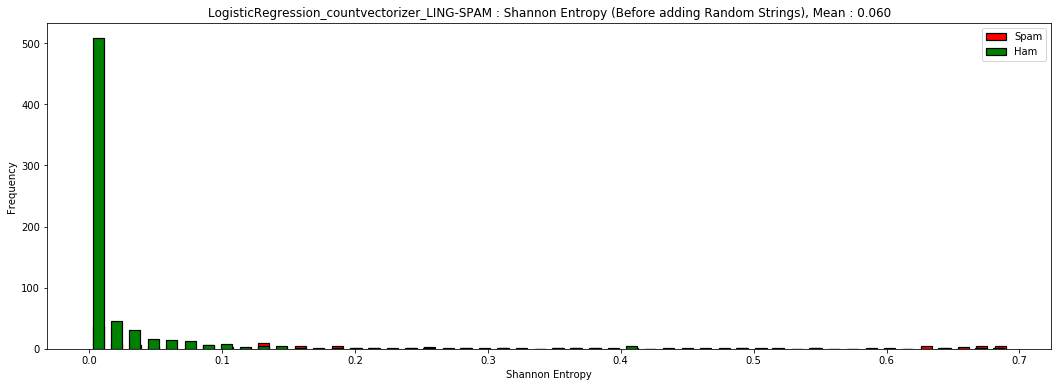

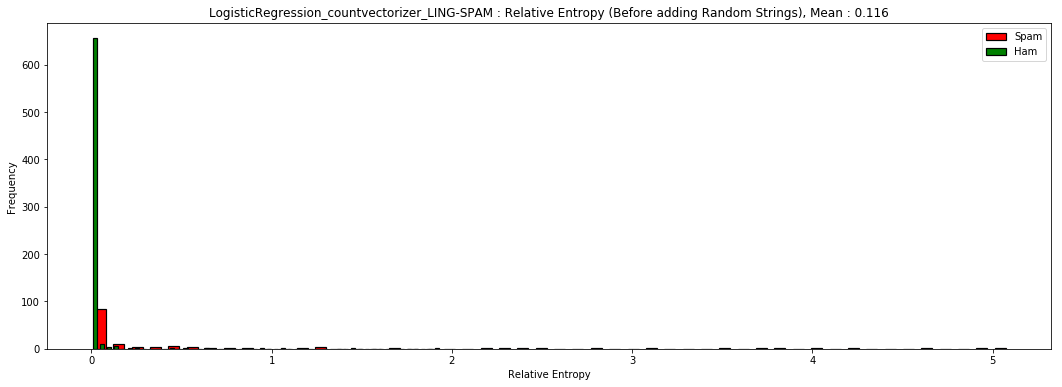

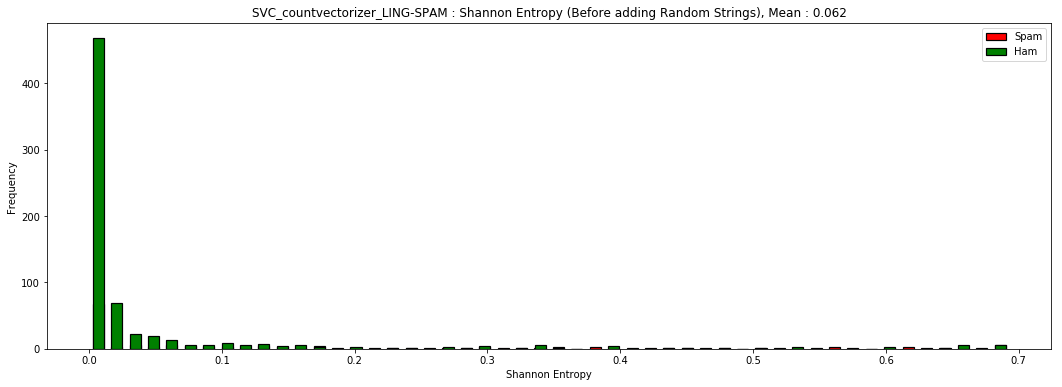

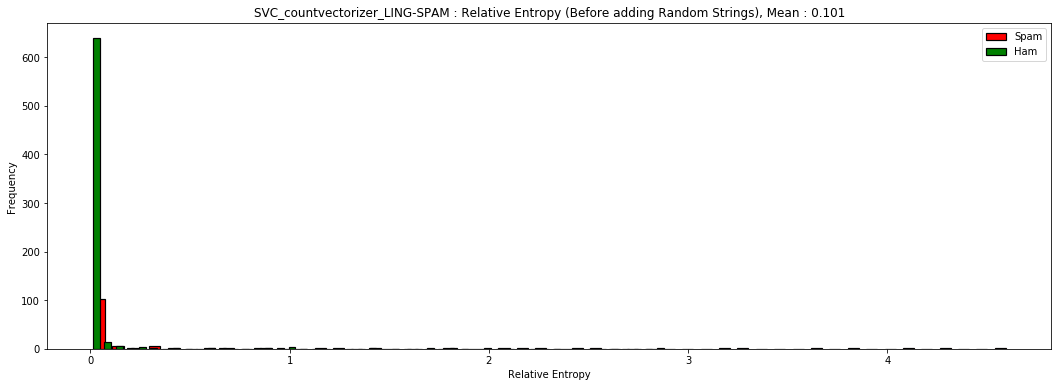

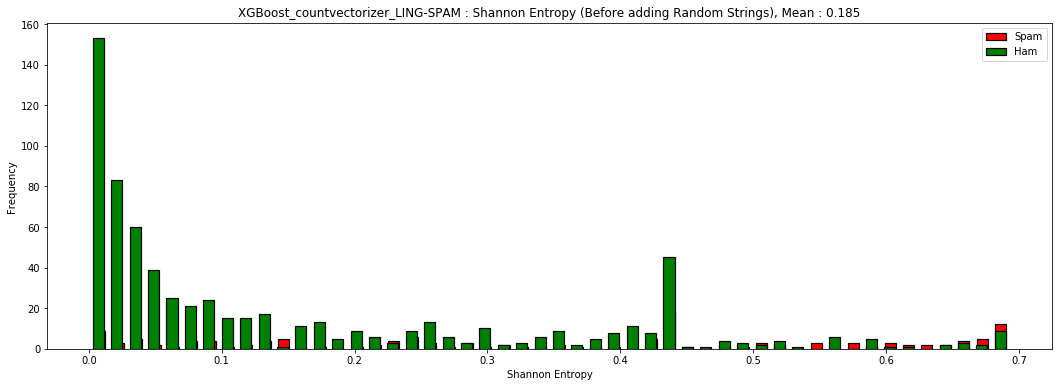

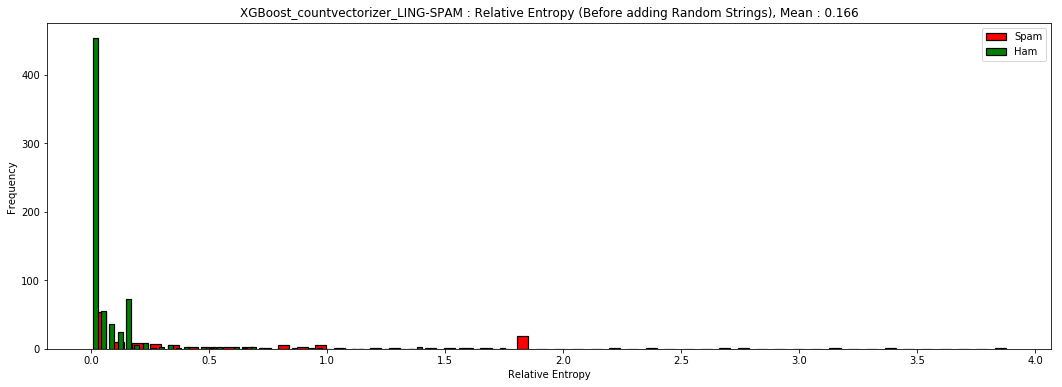

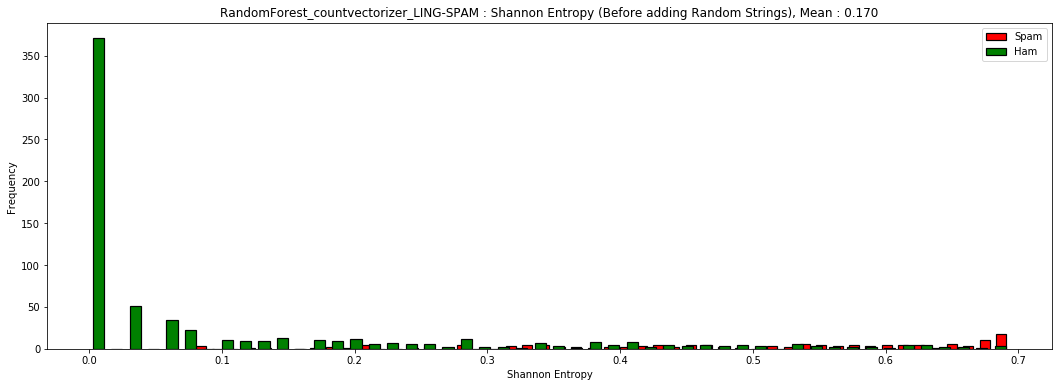

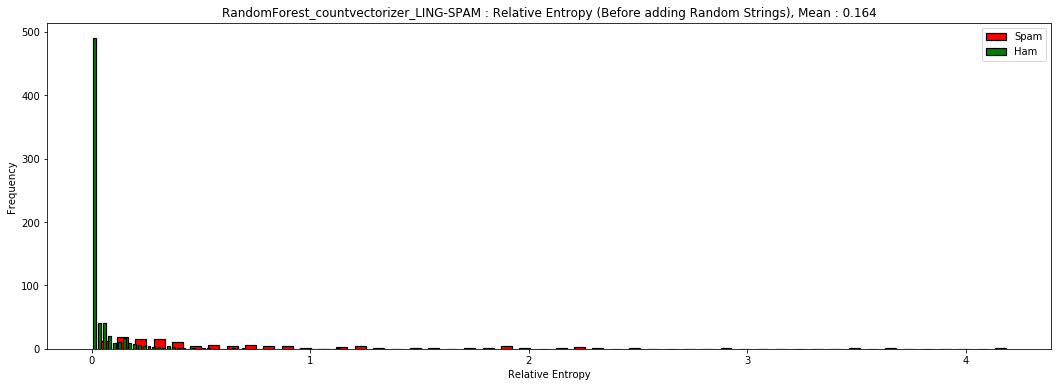

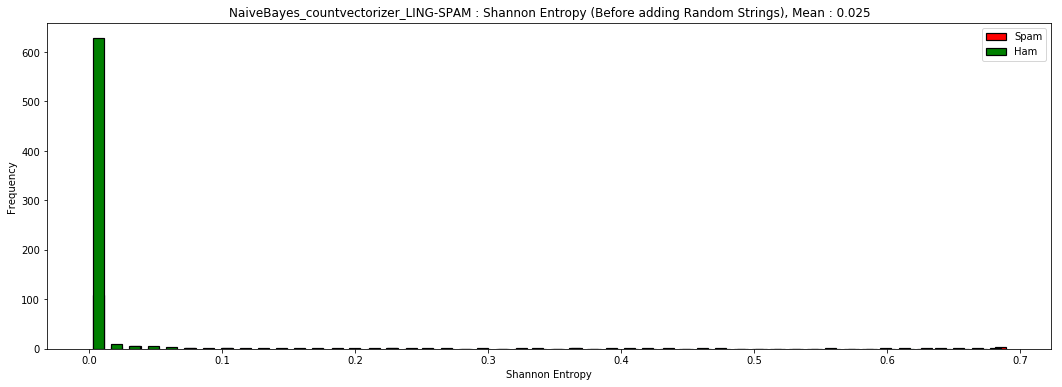

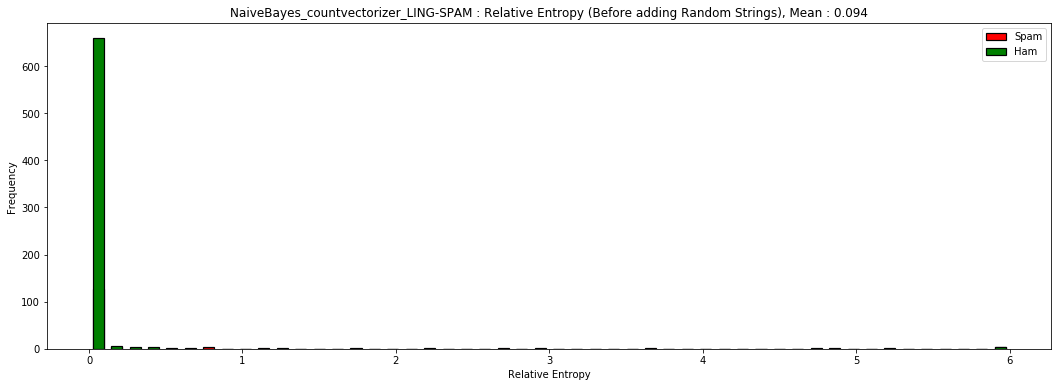

In [28]:
visualise_entropies(dataset, test_x_cleaned, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
LogisticRegression_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  1.3413155861976496
ROC AUC :  0.9903481594286614
Accuracy :  0.9611650485436893
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       685
         1.0       0.97      0.80      0.87       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.96      0.90      0.93       824
weighted avg       0.96      0.96      0.96       824



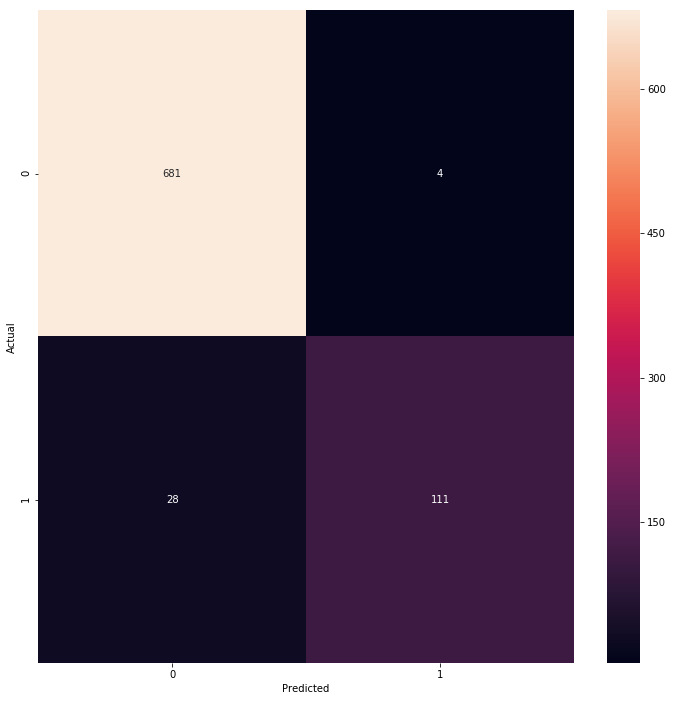

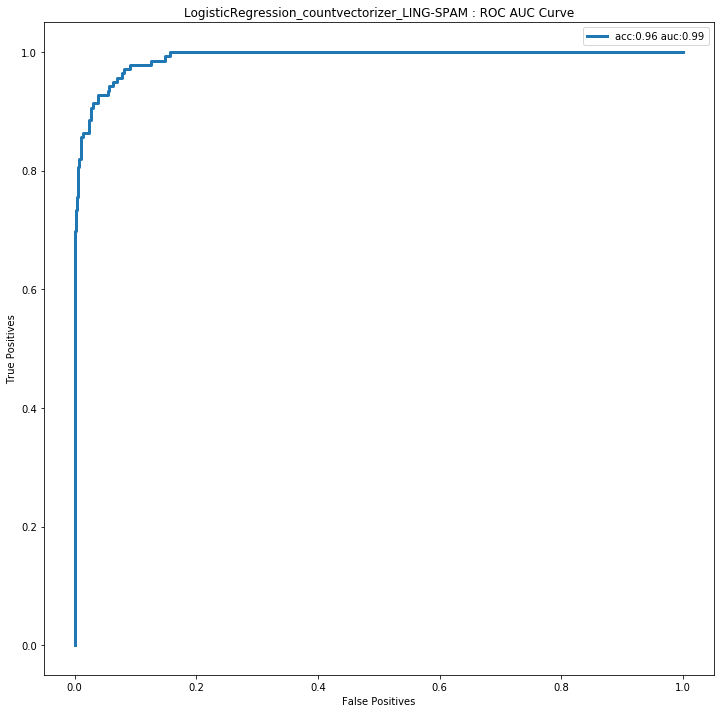

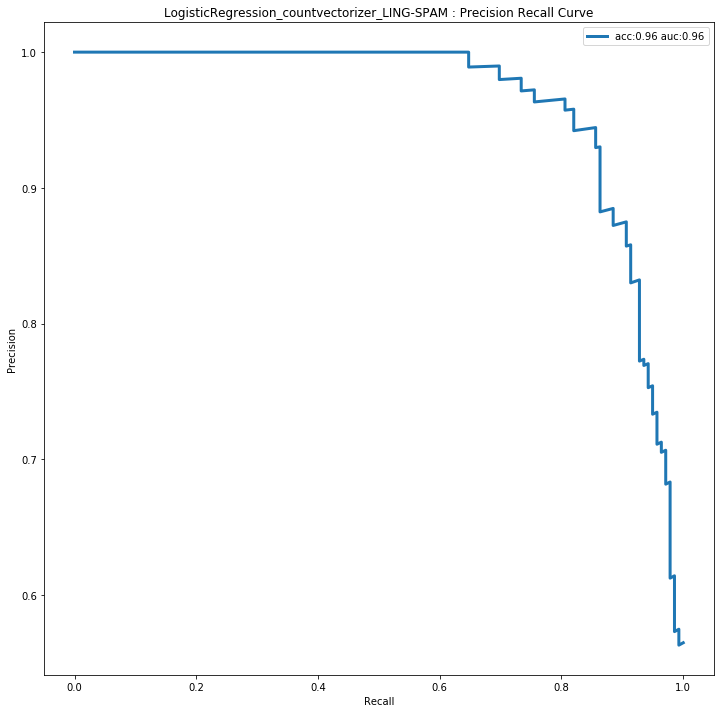

********************************************************************************
SVC_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  1.634724610435616
ROC AUC :  0.9894344378511789
Accuracy :  0.9526699029126213
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       685
         1.0       0.99      0.73      0.84       139

   micro avg       0.95      0.95      0.95       824
   macro avg       0.97      0.86      0.91       824
weighted avg       0.95      0.95      0.95       824



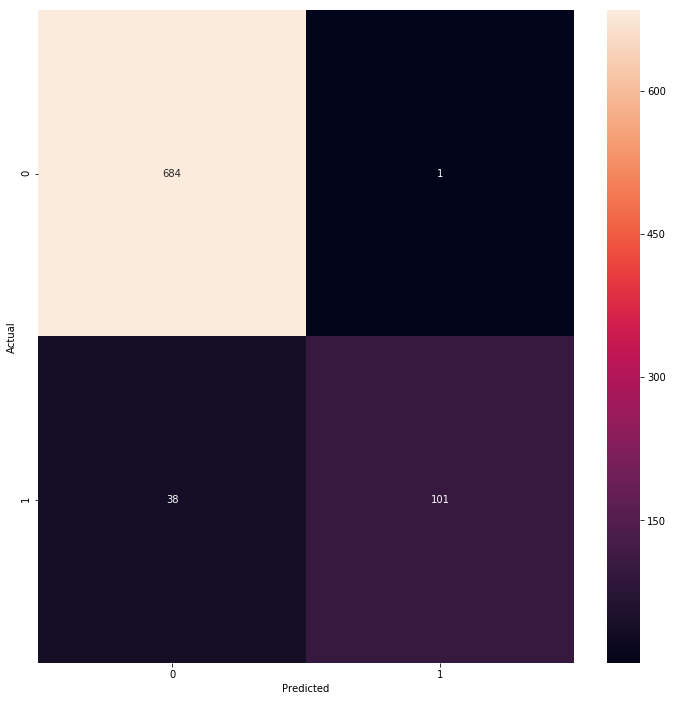

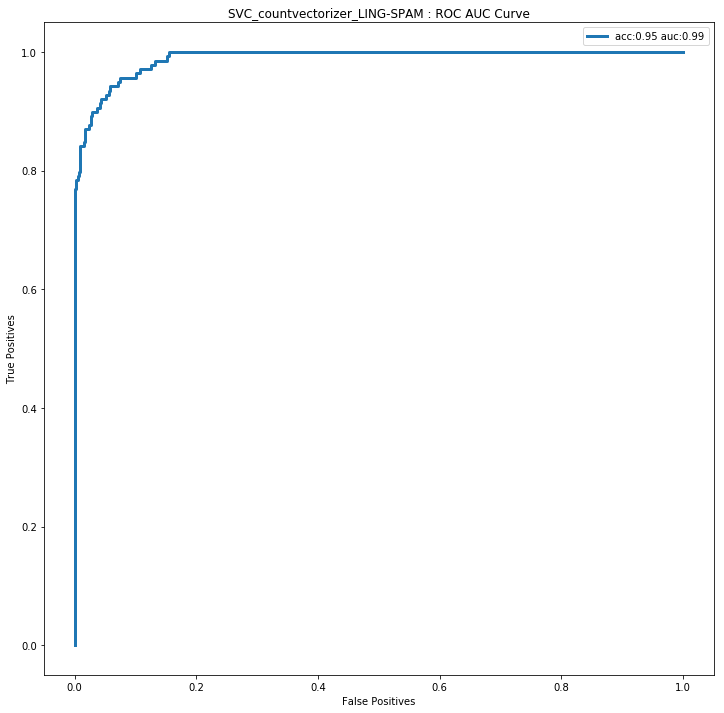

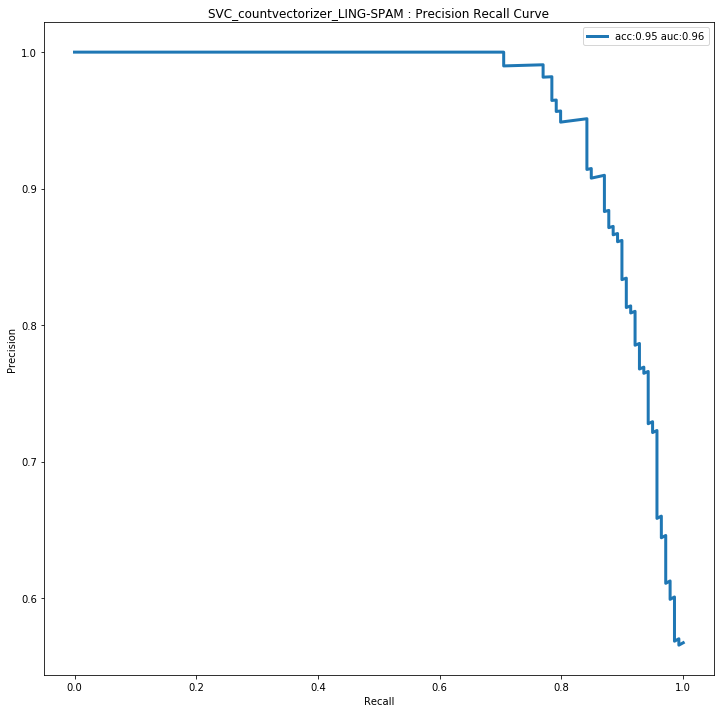

********************************************************************************
XGBoost_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  2.305388225845825
ROC AUC :  0.9670009977419525
Accuracy :  0.933252427184466
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       685
         1.0       0.91      0.67      0.77       139

   micro avg       0.93      0.93      0.93       824
   macro avg       0.92      0.83      0.87       824
weighted avg       0.93      0.93      0.93       824



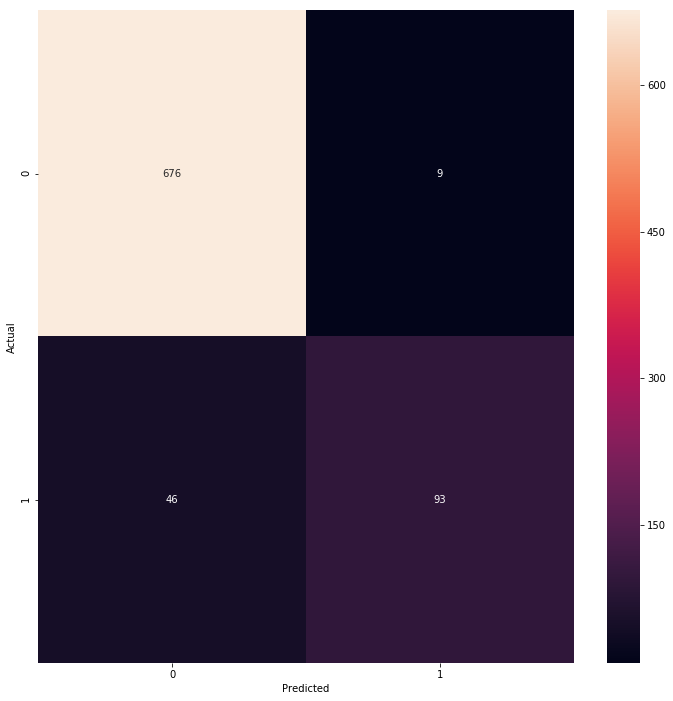

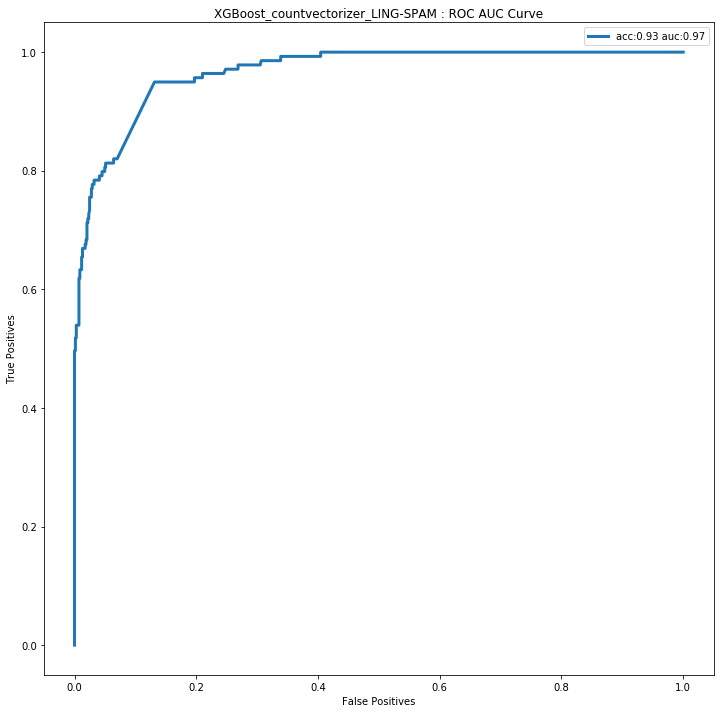

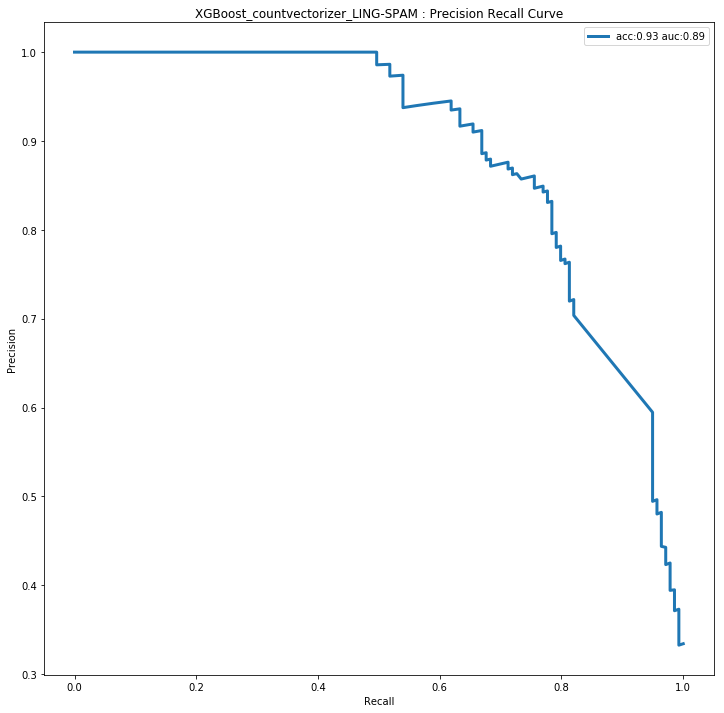

********************************************************************************
RandomForest_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  2.1796324904524105
ROC AUC :  0.9744788111116945
Accuracy :  0.9368932038834952
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       685
         1.0       0.99      0.63      0.77       139

   micro avg       0.94      0.94      0.94       824
   macro avg       0.96      0.82      0.87       824
weighted avg       0.94      0.94      0.93       824



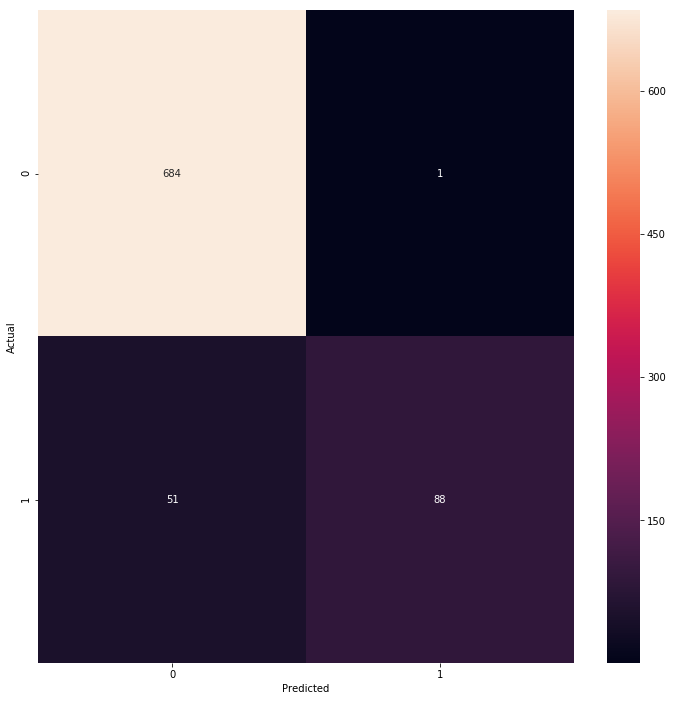

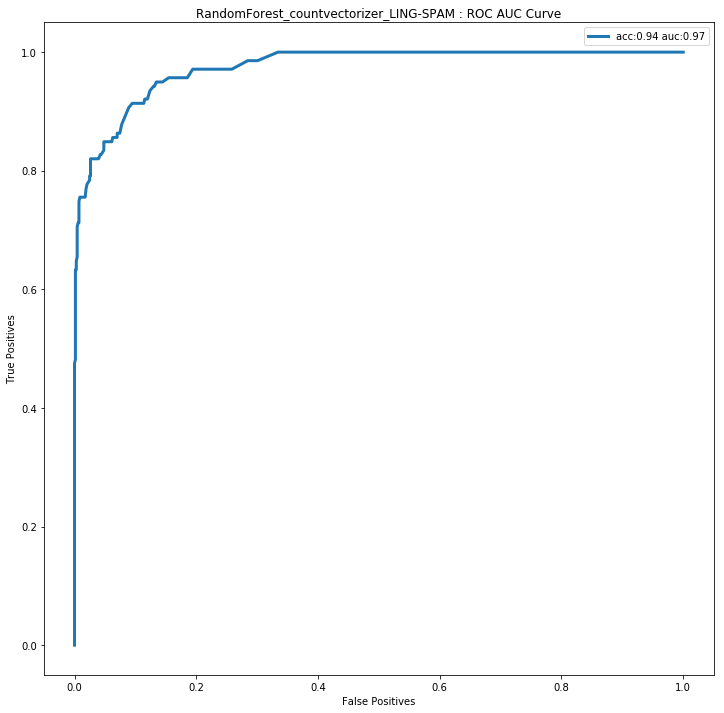

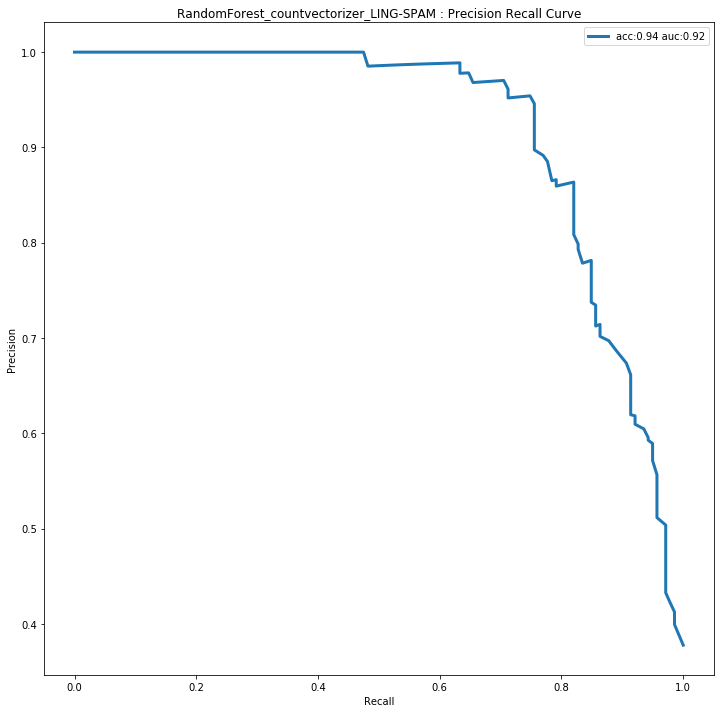

********************************************************************************
NaiveBayes_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  0.8383295192627627
ROC AUC :  0.9942235992228116
Accuracy :  0.9757281553398058
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       685
         1.0       0.93      0.93      0.93       139

   micro avg       0.98      0.98      0.98       824
   macro avg       0.96      0.96      0.96       824
weighted avg       0.98      0.98      0.98       824



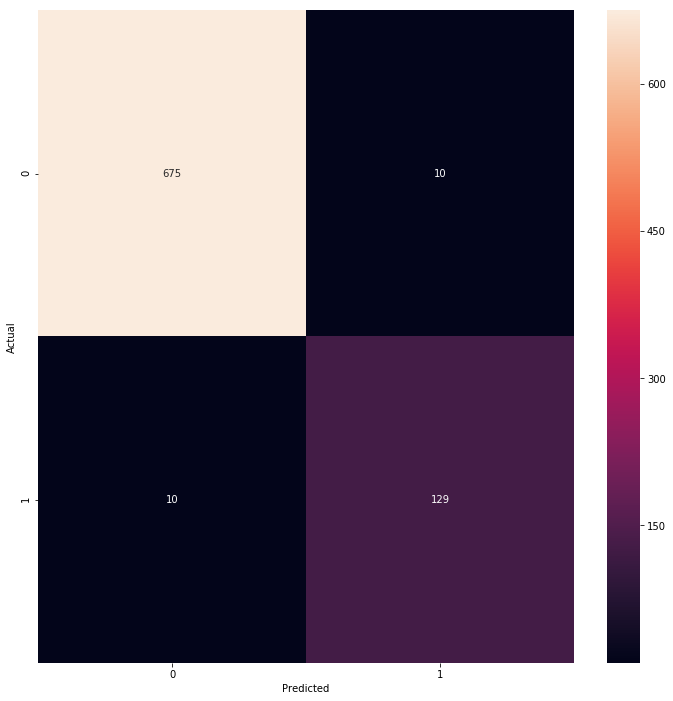

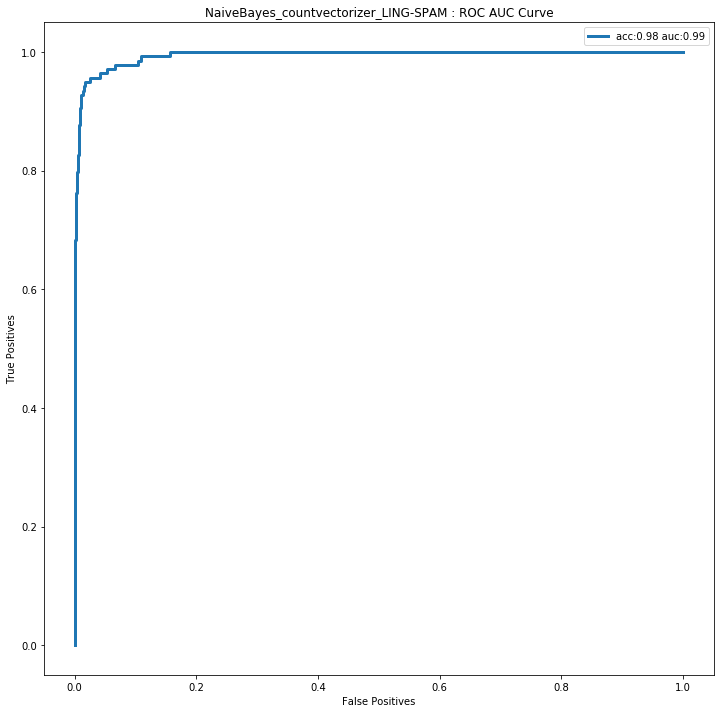

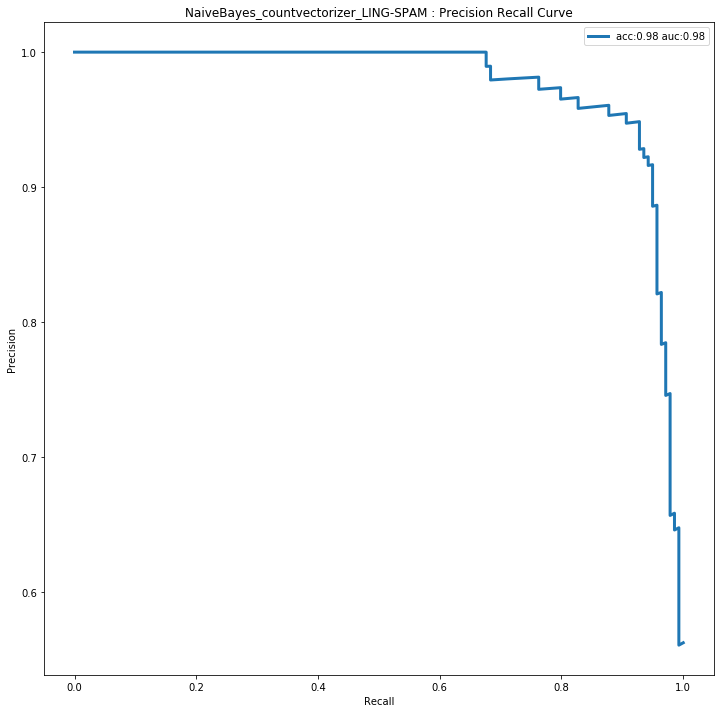

In [29]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cleaned, y_test)

## Adding Meaningful Strings to Test Data

In [30]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_countvectorizer_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.058555151518642844
Mean Relative Entropy :  0.12266378223747634
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2     0.275     2.545     1.0     0.0       0.922       0.078
21    0.255     2.653     1.0     0.0       0.930       0.070
22    0.560     1.395     1.0     0.0       0.752       0.248
27    0.280     2.521     1.0     0.0       0.920       0.080
29    0.205     2.951     1.0     0.0       0.948       0.052
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
137    0.046     4.845     1.0     0.0       0.992       0.008
172    0.582     1.314     0.0     1.0       0.269       0.731
211    0.684     0.840     0.0     1.0       0.432       0.568
525    0.670     0.935     0.0     1.0       0.393       0.

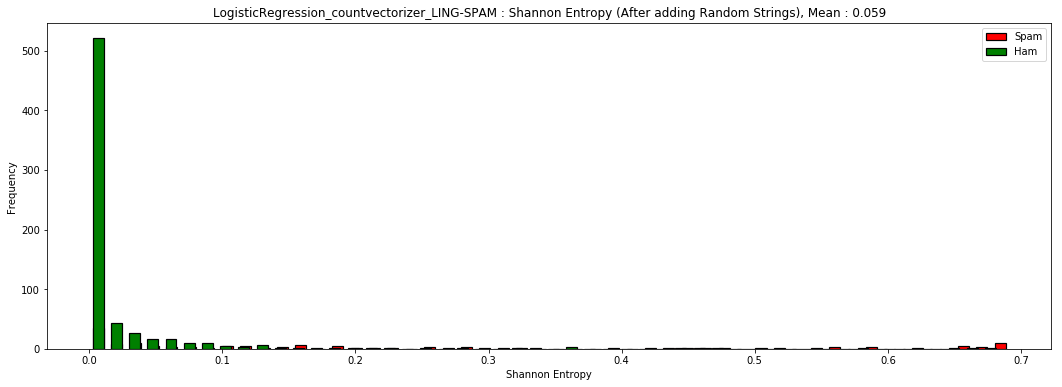

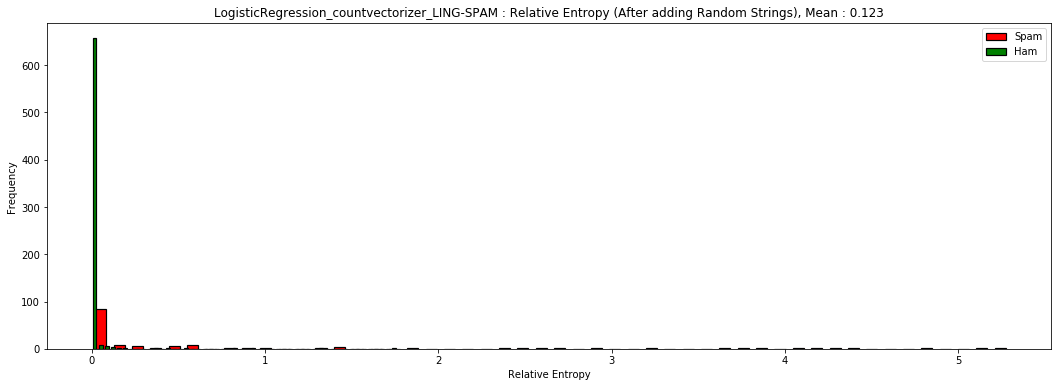

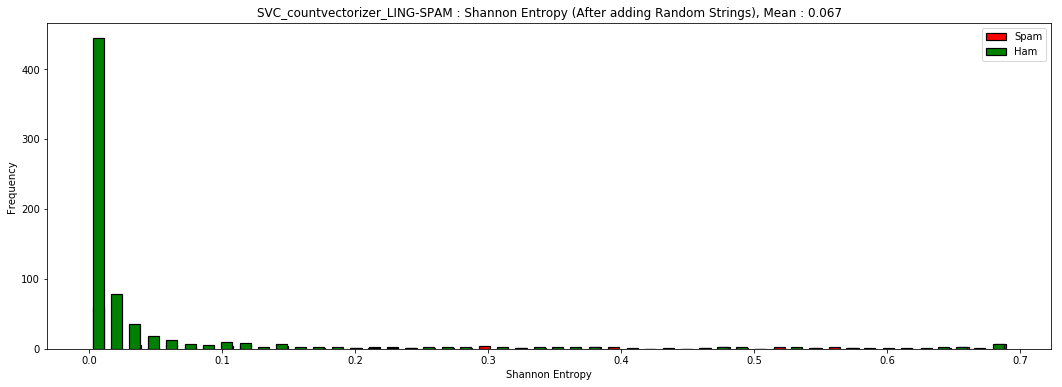

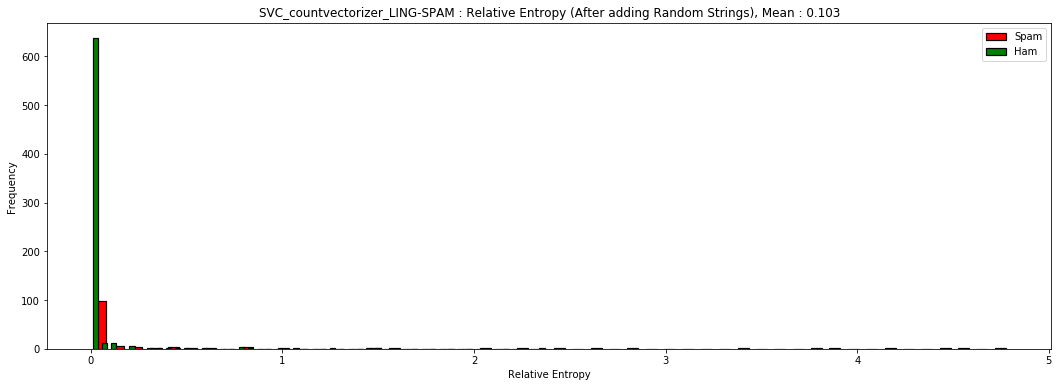

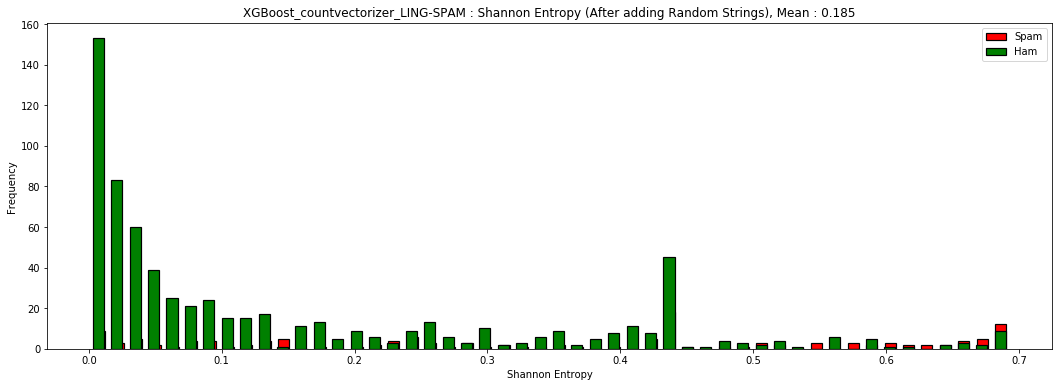

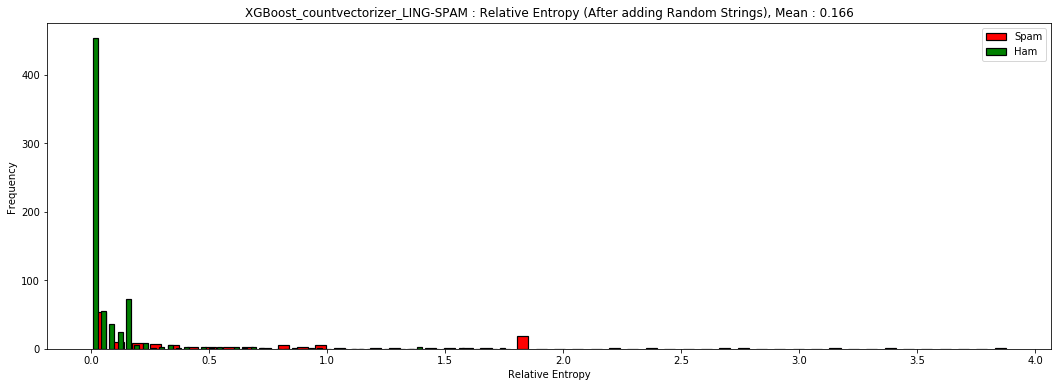

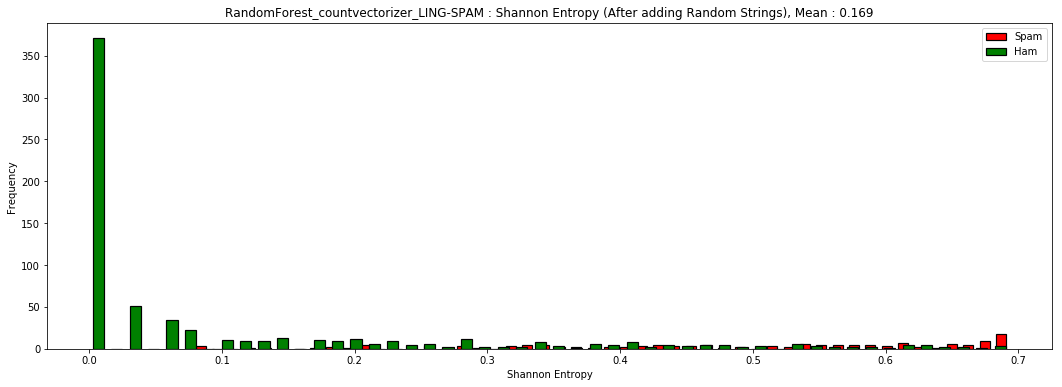

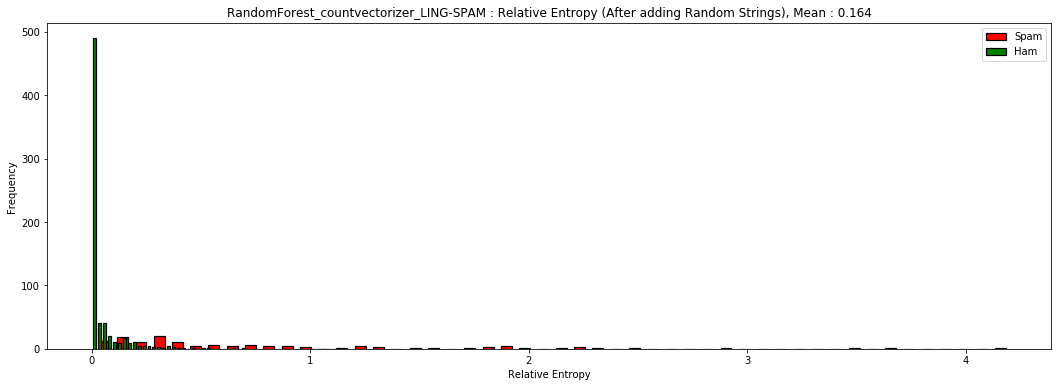

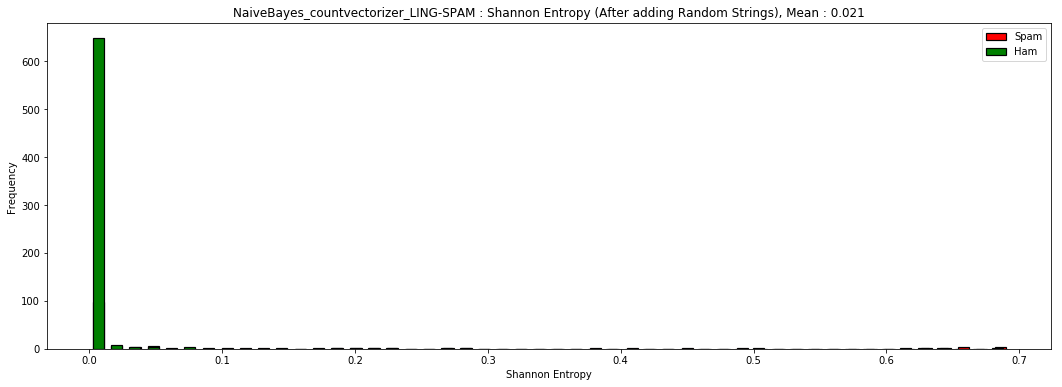

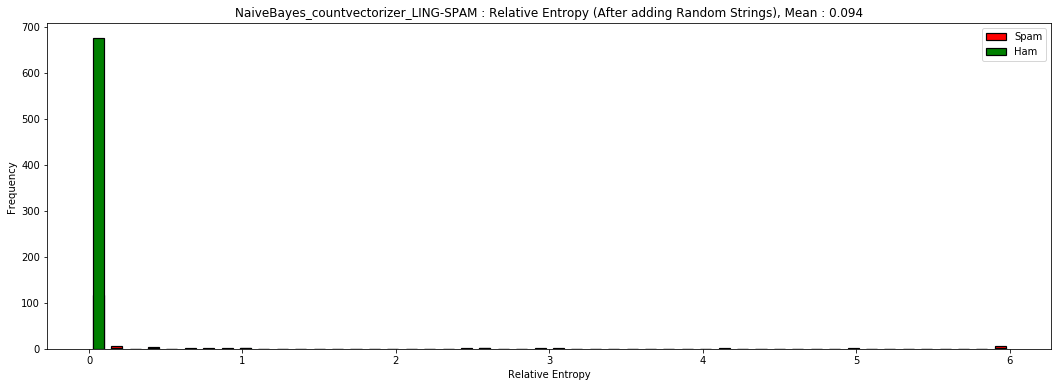

In [31]:
visualise_entropies(dataset, test_x_with_random_strings, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  1.3832315769681722
ROC AUC :  0.9903481594286614
Accuracy :  0.9599514563106796
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       685
         1.0       0.96      0.79      0.87       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.96      0.89      0.92       824
weighted avg       0.96      0.96      0.96       824



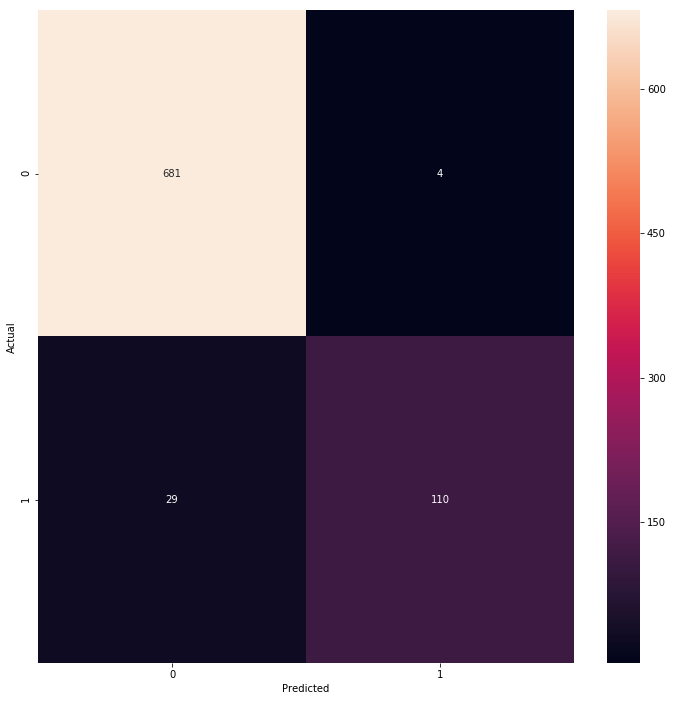

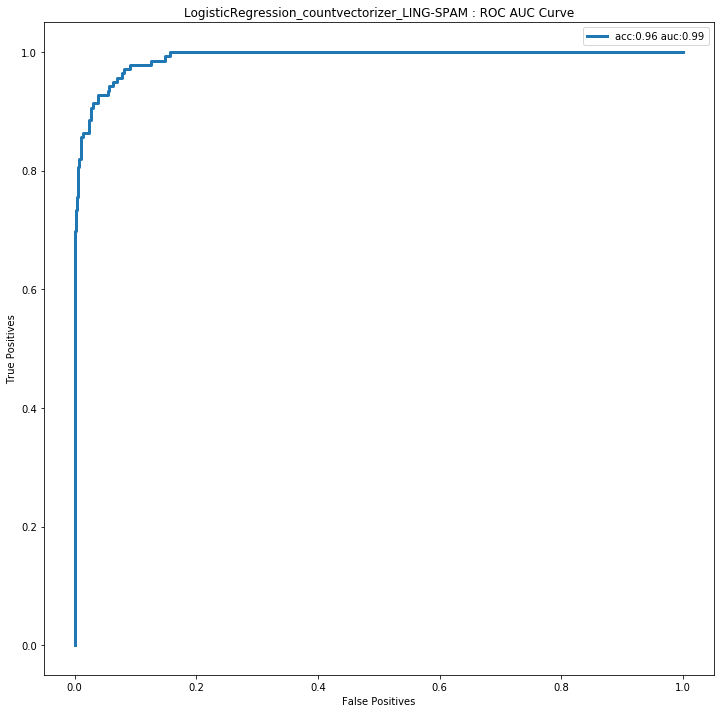

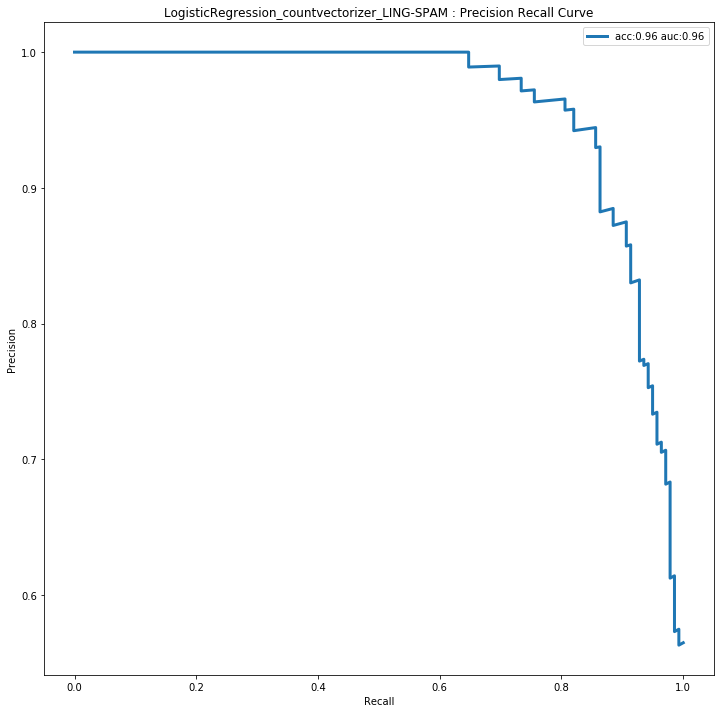

********************************************************************************
SVC_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  1.8443035939029984
ROC AUC :  0.9884892086330935
Accuracy :  0.9466019417475728
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       685
         1.0       1.00      0.68      0.81       139

   micro avg       0.95      0.95      0.95       824
   macro avg       0.97      0.84      0.89       824
weighted avg       0.95      0.95      0.94       824



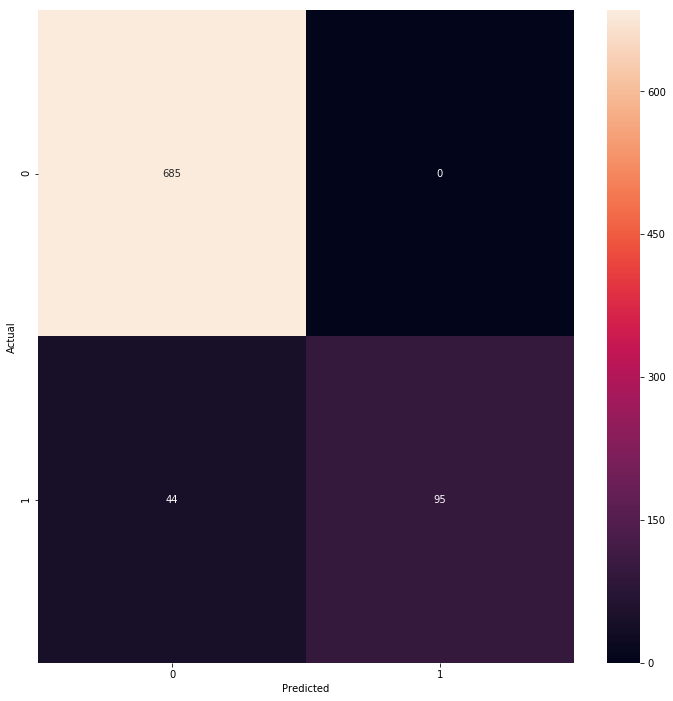

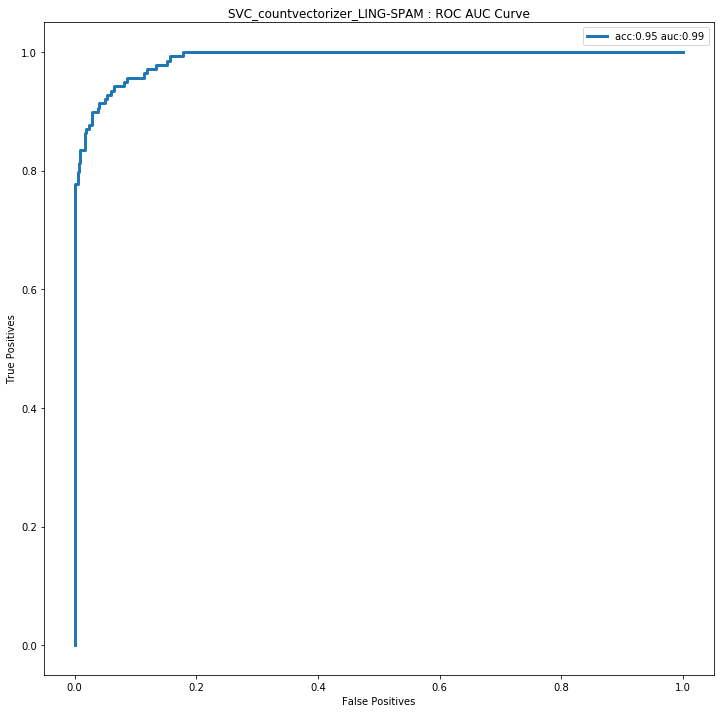

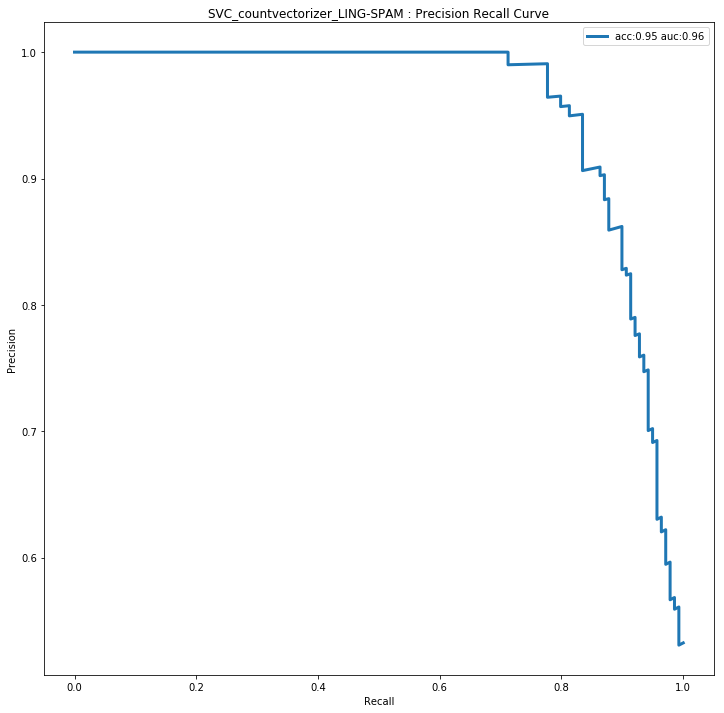

********************************************************************************
XGBoost_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  2.305388225845825
ROC AUC :  0.9670009977419525
Accuracy :  0.933252427184466
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       685
         1.0       0.91      0.67      0.77       139

   micro avg       0.93      0.93      0.93       824
   macro avg       0.92      0.83      0.87       824
weighted avg       0.93      0.93      0.93       824



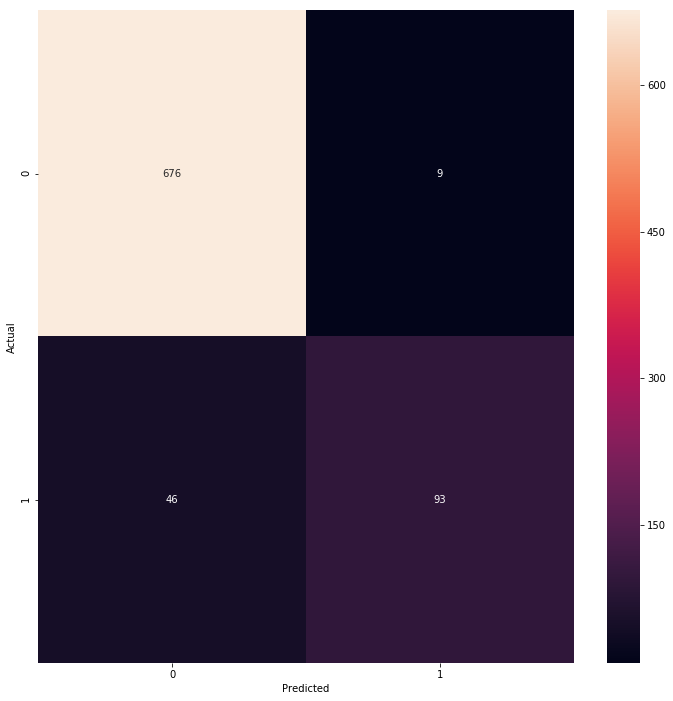

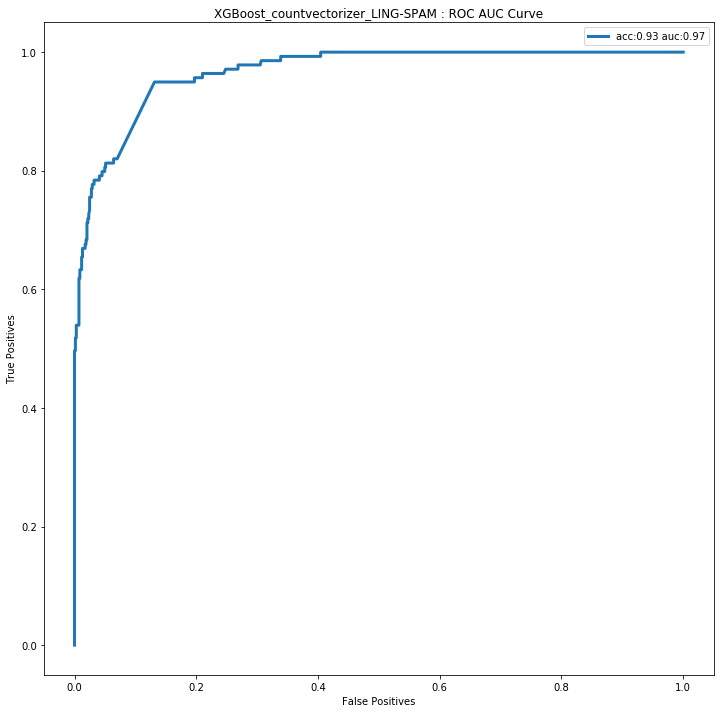

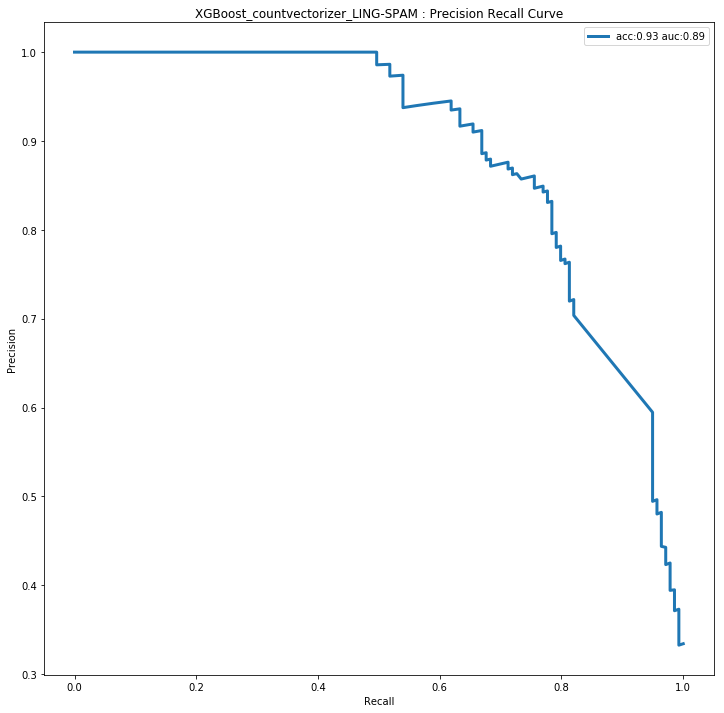

********************************************************************************
RandomForest_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  2.1796324904524105
ROC AUC :  0.9744578060179593
Accuracy :  0.9368932038834952
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       685
         1.0       0.99      0.63      0.77       139

   micro avg       0.94      0.94      0.94       824
   macro avg       0.96      0.82      0.87       824
weighted avg       0.94      0.94      0.93       824



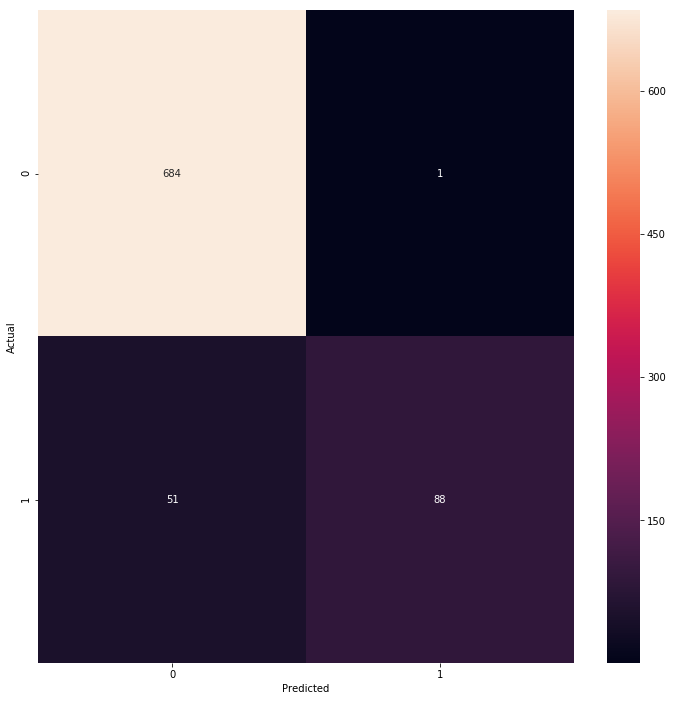

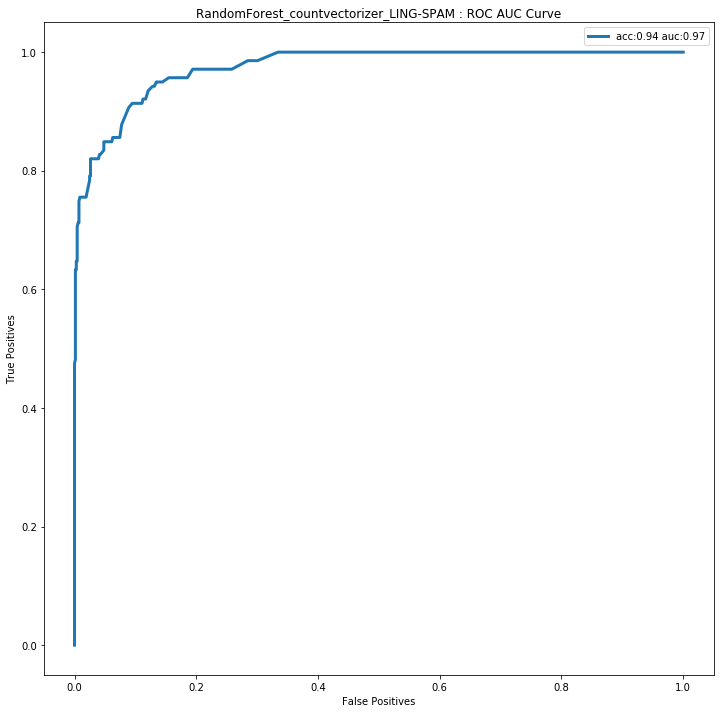

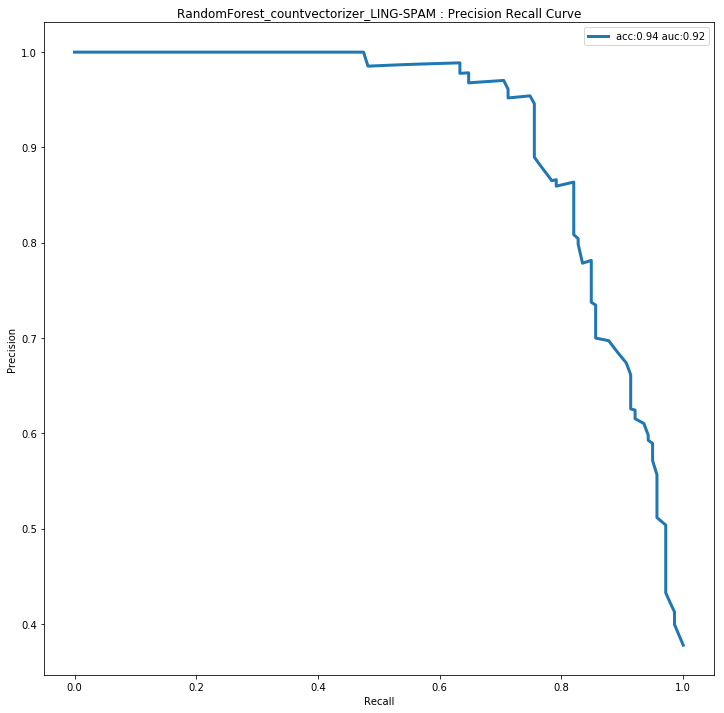

********************************************************************************
NaiveBayes_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  0.8383256377218394
ROC AUC :  0.9942341017696792
Accuracy :  0.9757281553398058
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       685
         1.0       0.95      0.90      0.93       139

   micro avg       0.98      0.98      0.98       824
   macro avg       0.97      0.95      0.96       824
weighted avg       0.98      0.98      0.98       824



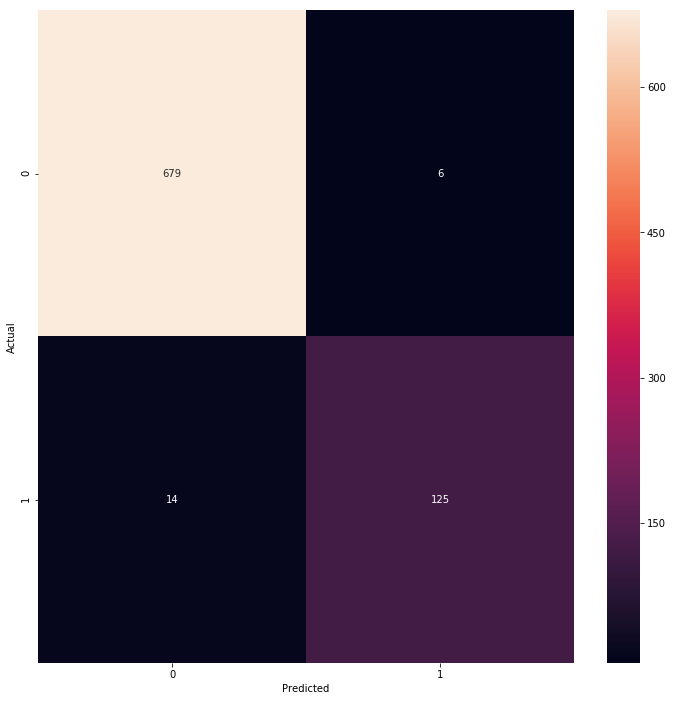

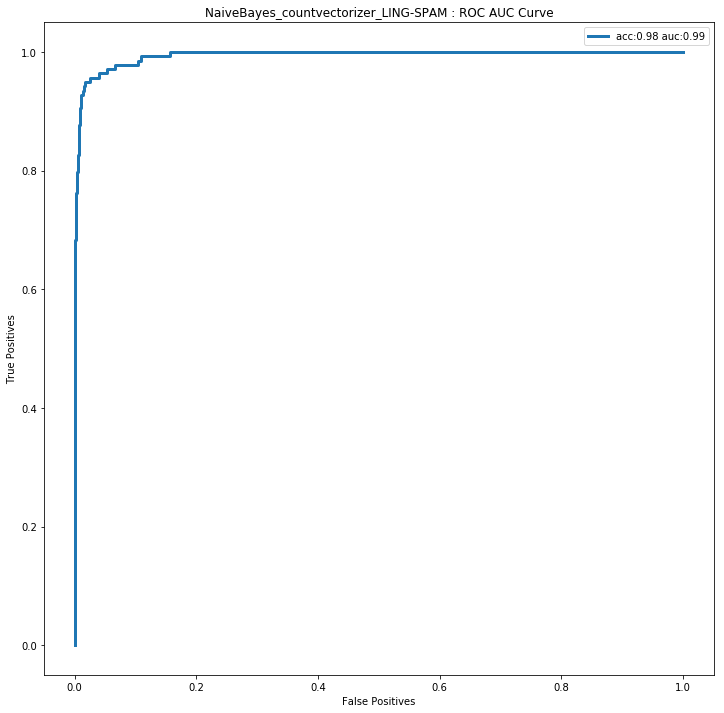

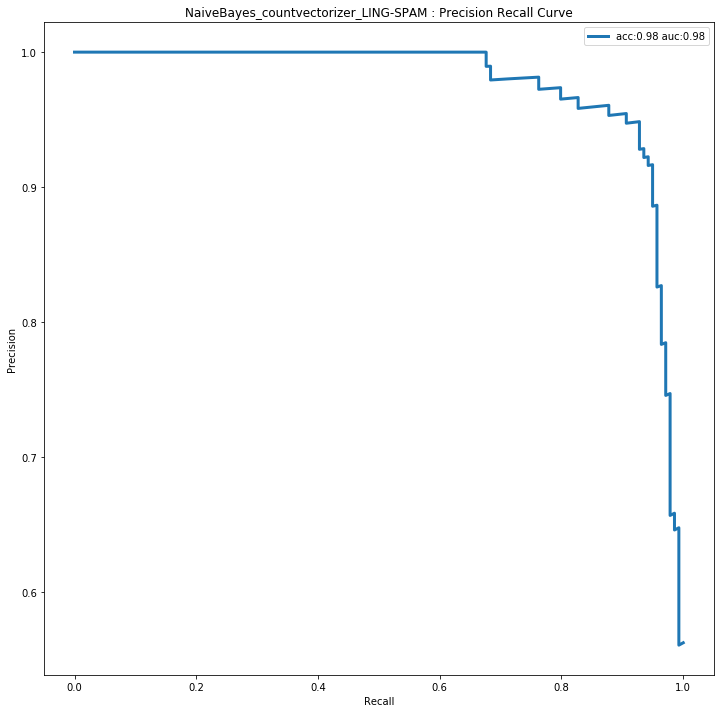

In [32]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings, y_test)

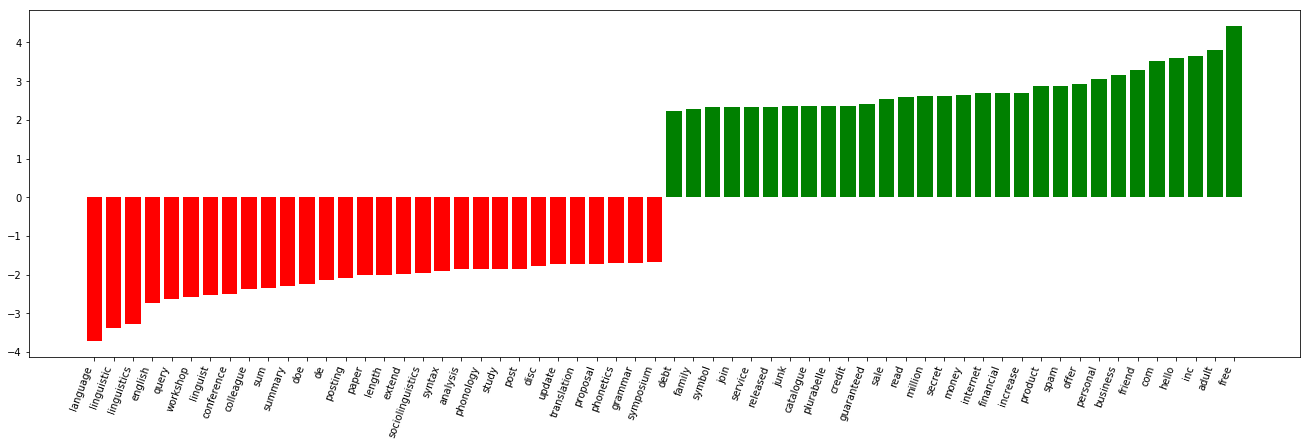

In [33]:
visualize_coefficients(grids['LogisticRegression_countvectorizer_'+dataset].best_estimator_.steps[1][1], grids['LogisticRegression_countvectorizer_'+dataset].best_estimator_.steps[0][1].get_feature_names())

## Adding Meaningful Strings with Scrambled Words to Test Data

In [34]:
## adding meaningful random words that are scrambled now to the test dataset to further confuse the filter
text_x_with_random_scrambled_strings = add_meaningful_scrambled_strings (test_x_cleaned, string_size)

## Visualise Shannon and Relative entropies for various models (After Adding Scrambled Words in Strings)

********************************************************************************
LogisticRegression_countvectorizer_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.16734034869495584
Mean Relative Entropy :  0.5775638730143341
Head 5 : 
   Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
0    0.167     3.224     1.0     0.0        0.96        0.04
1    0.167     3.224     1.0     0.0        0.96        0.04
2    0.167     3.224     1.0     0.0        0.96        0.04
3    0.167     3.224     1.0     0.0        0.96        0.04
4    0.167     3.224     1.0     0.0        0.96        0.04
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
134    0.167     3.224     1.0     0.0        0.96        0.04
135    0.167     3.224     1.0     0.0        0.96        0.04
136    0.167     3.224     1.0     0.0        0.96        0.04
137    0.167     3.224     1.0     0.0        0.96        0.04
138 

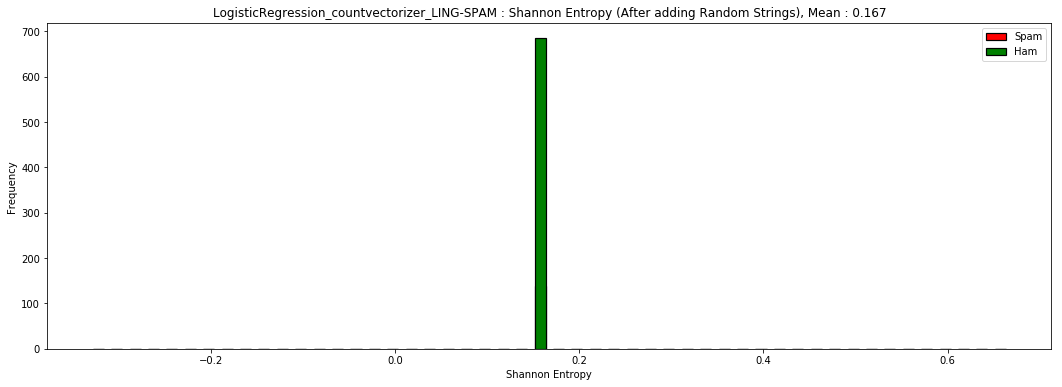

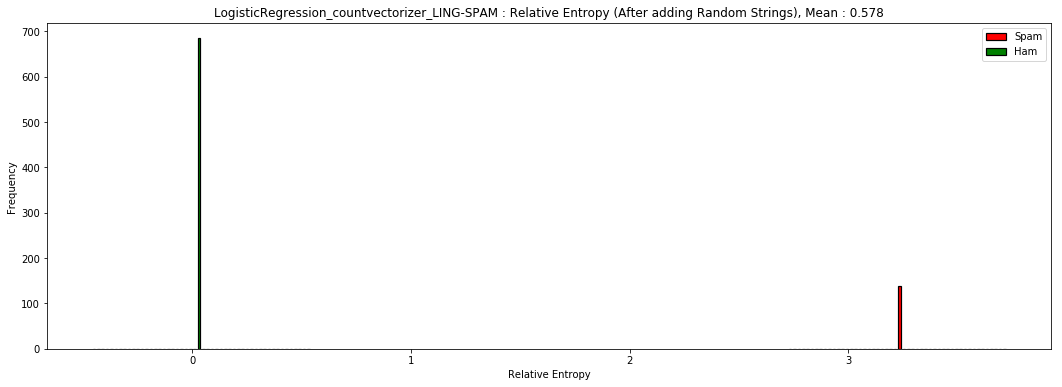

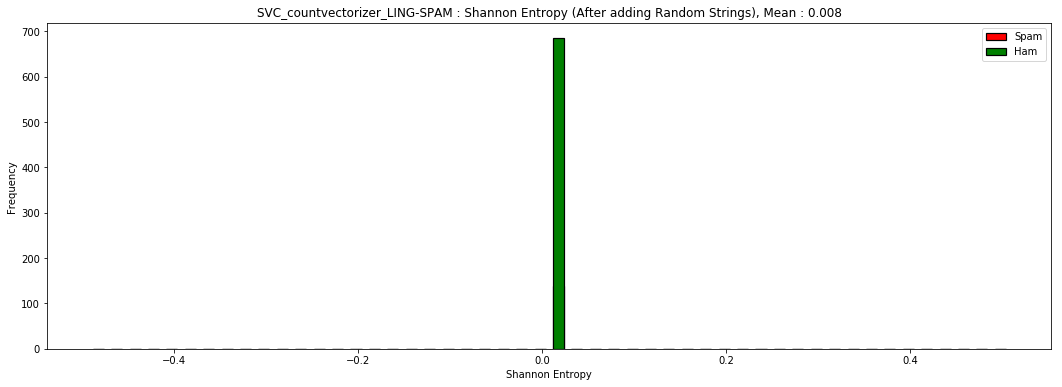

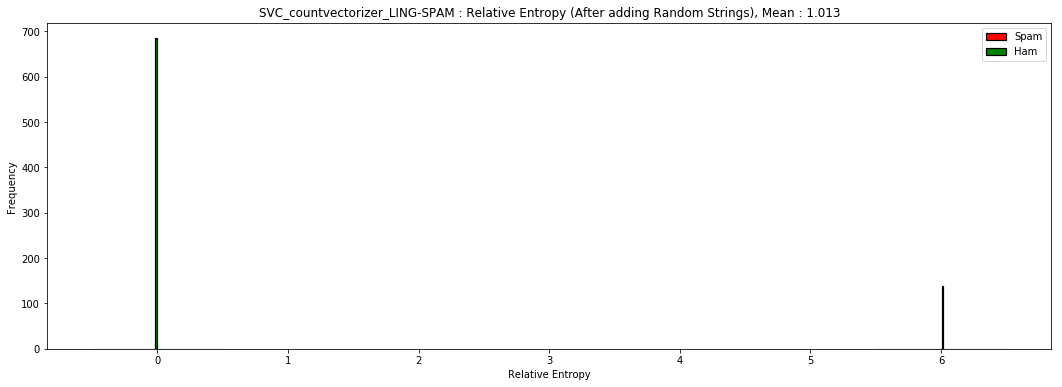

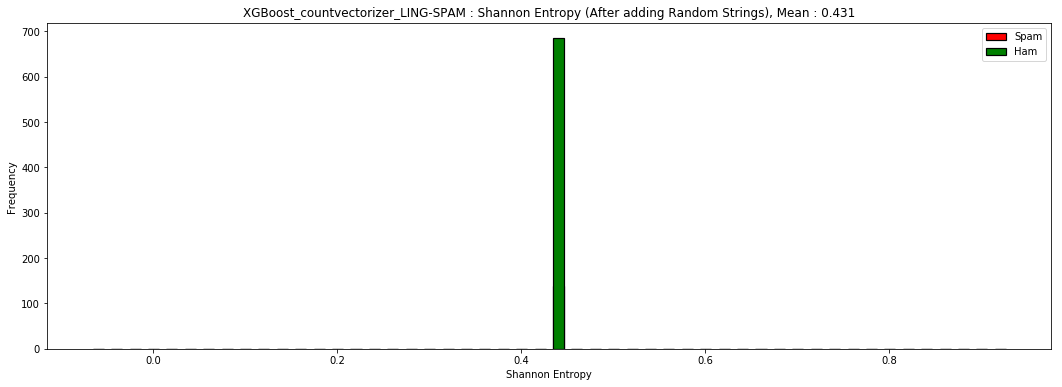

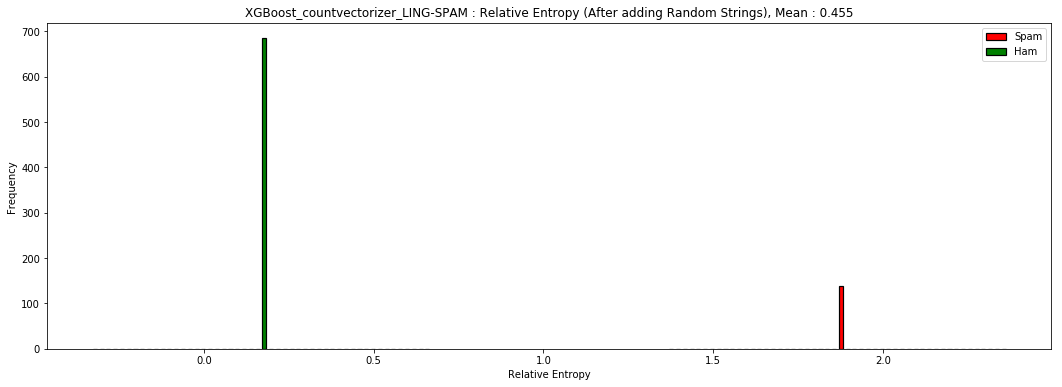

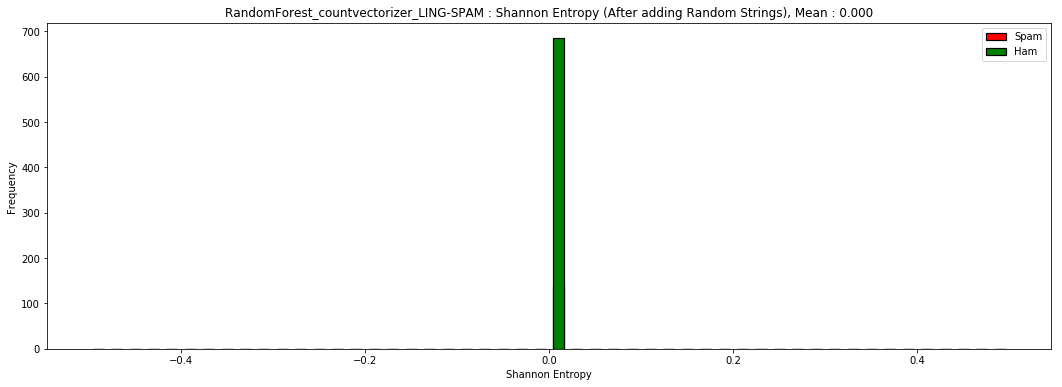

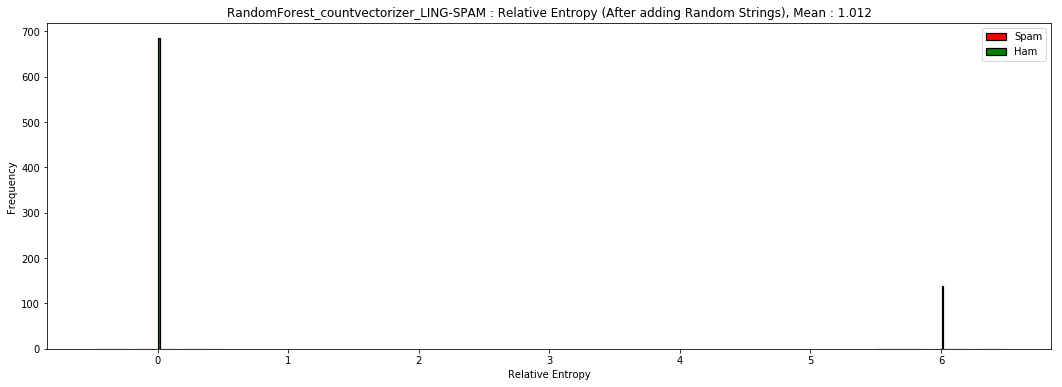

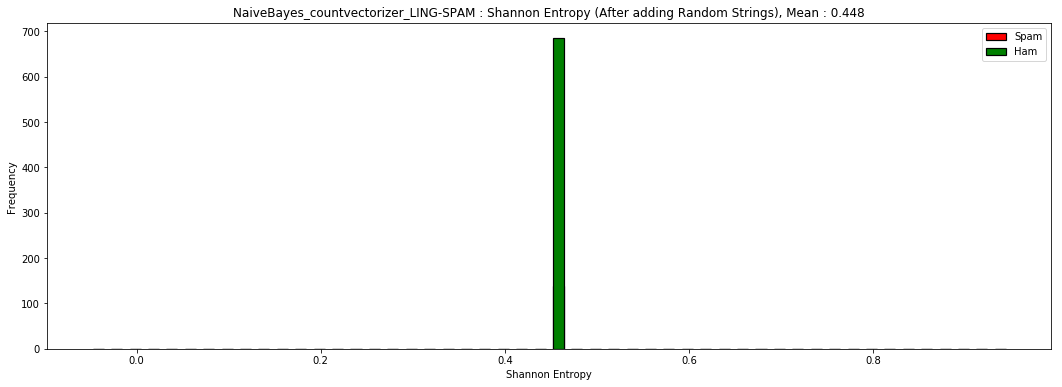

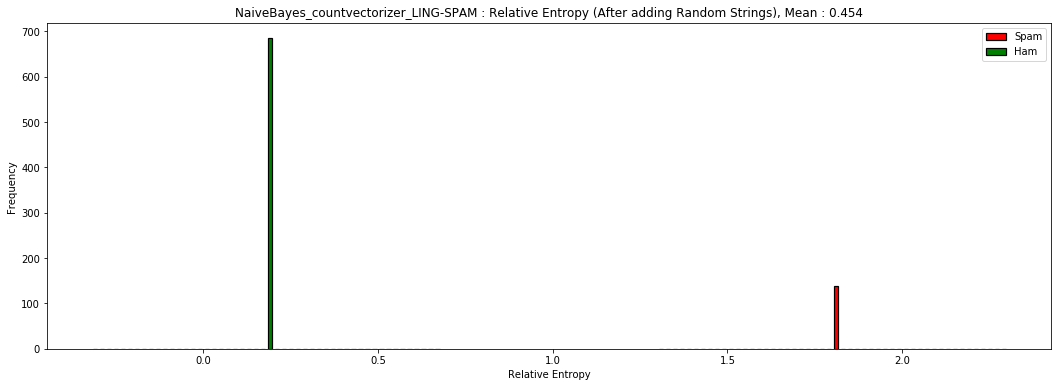

In [35]:
visualise_entropies(dataset, text_x_with_random_scrambled_strings, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Scrambled Words in Strings)

********************************************************************************
LogisticRegression_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  5.826322717102651
ROC AUC :  0.5
Accuracy :  0.8313106796116505
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91       685
         1.0       0.00      0.00      0.00       139

   micro avg       0.83      0.83      0.83       824
   macro avg       0.42      0.50      0.45       824
weighted avg       0.69      0.83      0.75       824



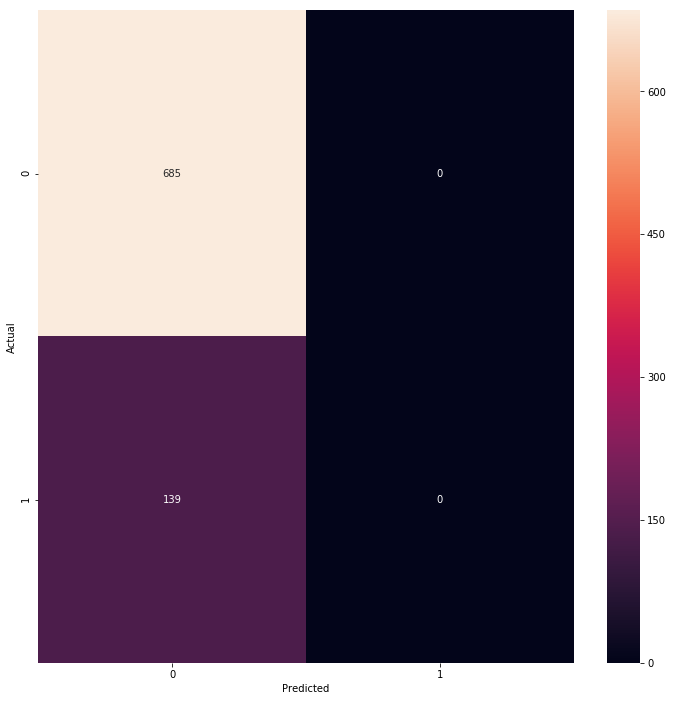

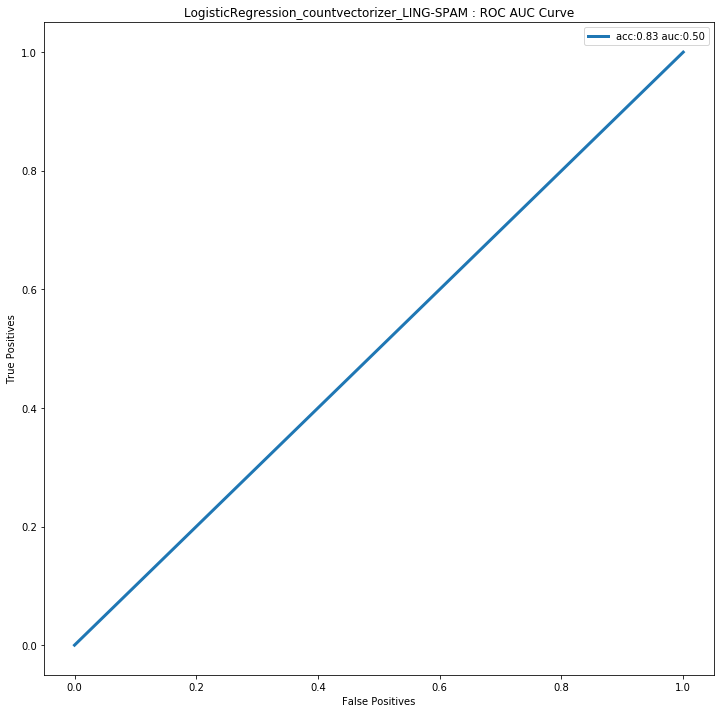

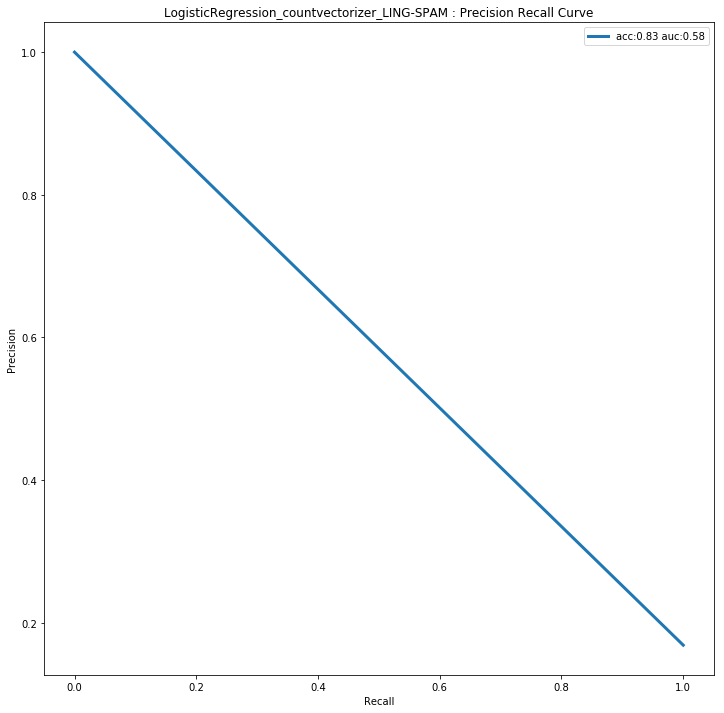

********************************************************************************
SVC_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  5.826322717102651
ROC AUC :  0.5
Accuracy :  0.8313106796116505
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91       685
         1.0       0.00      0.00      0.00       139

   micro avg       0.83      0.83      0.83       824
   macro avg       0.42      0.50      0.45       824
weighted avg       0.69      0.83      0.75       824



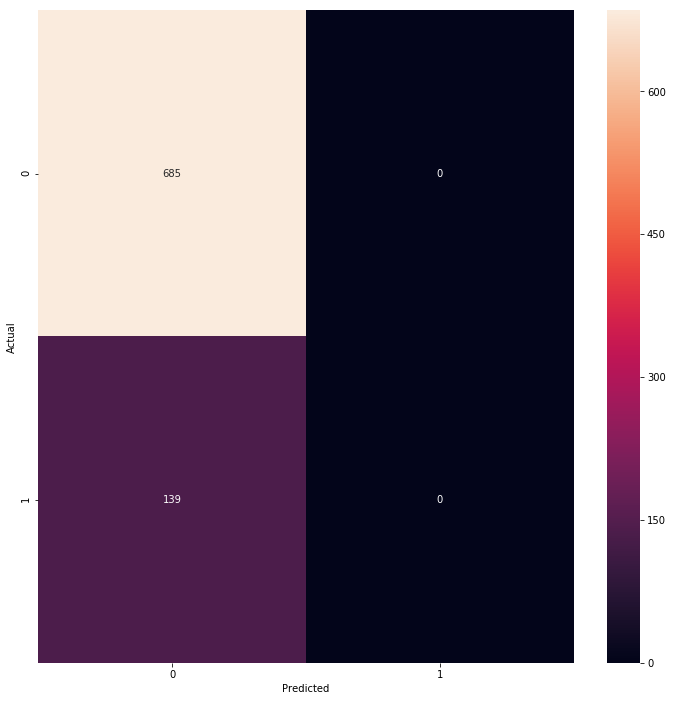

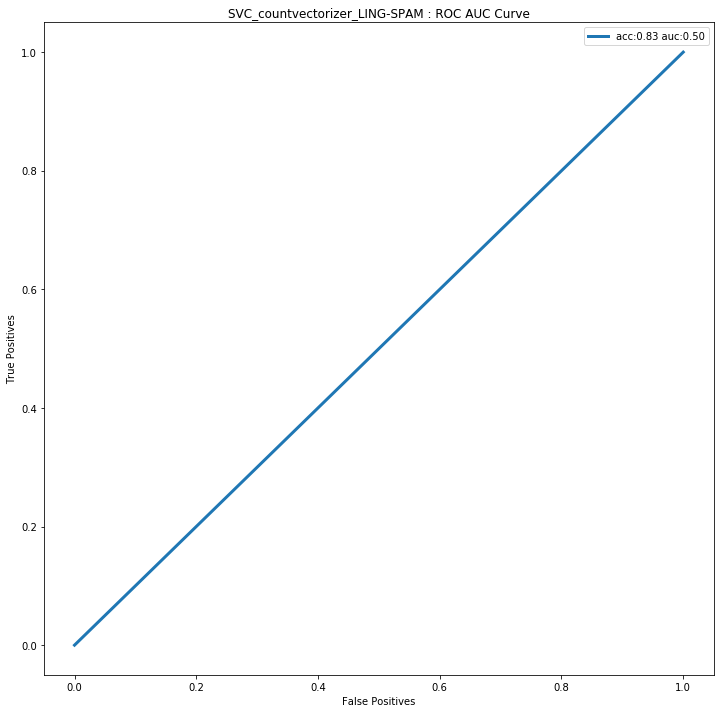

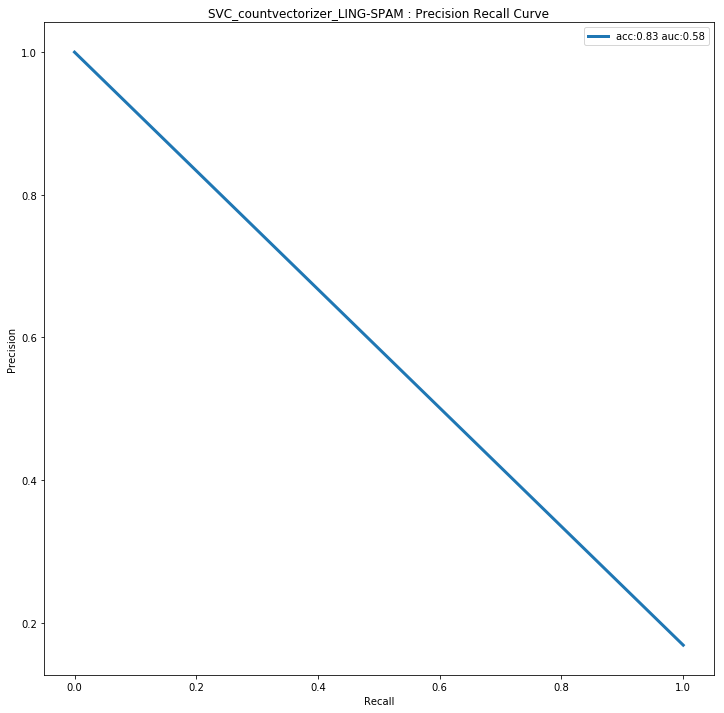

********************************************************************************
XGBoost_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  5.826322717102651
ROC AUC :  0.5
Accuracy :  0.8313106796116505
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91       685
         1.0       0.00      0.00      0.00       139

   micro avg       0.83      0.83      0.83       824
   macro avg       0.42      0.50      0.45       824
weighted avg       0.69      0.83      0.75       824



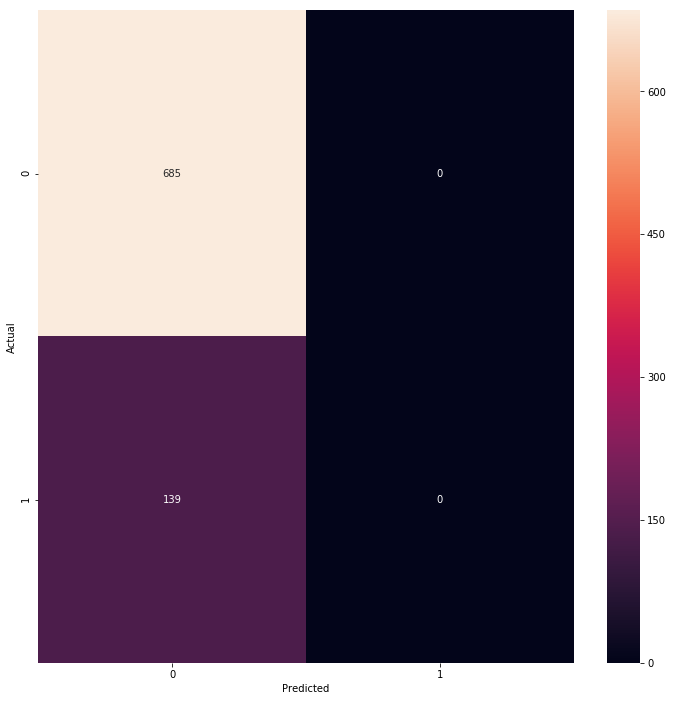

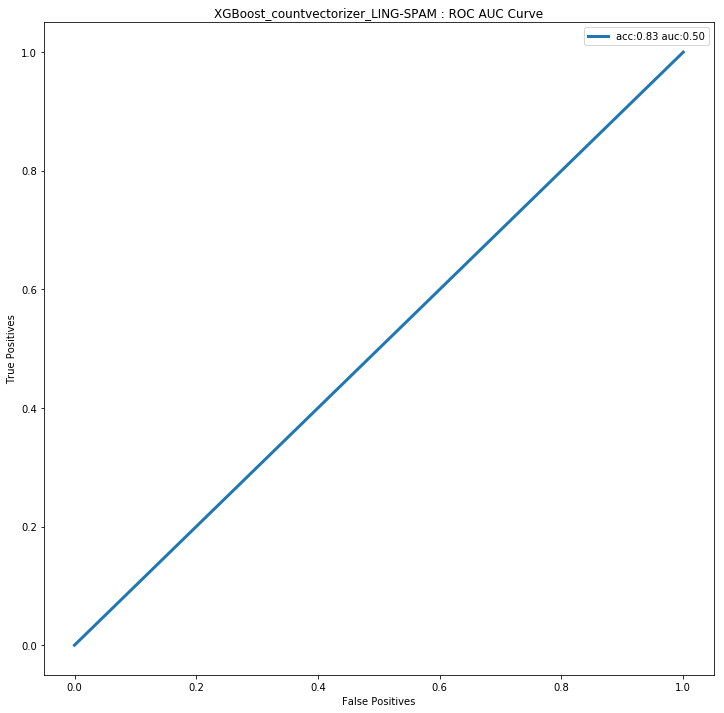

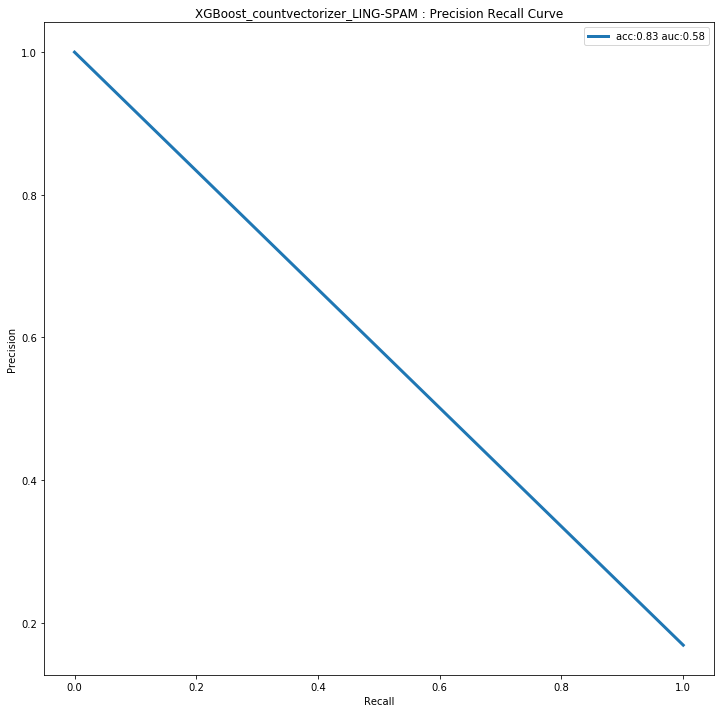

********************************************************************************
RandomForest_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  5.826322717102651
ROC AUC :  0.5
Accuracy :  0.8313106796116505
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91       685
         1.0       0.00      0.00      0.00       139

   micro avg       0.83      0.83      0.83       824
   macro avg       0.42      0.50      0.45       824
weighted avg       0.69      0.83      0.75       824



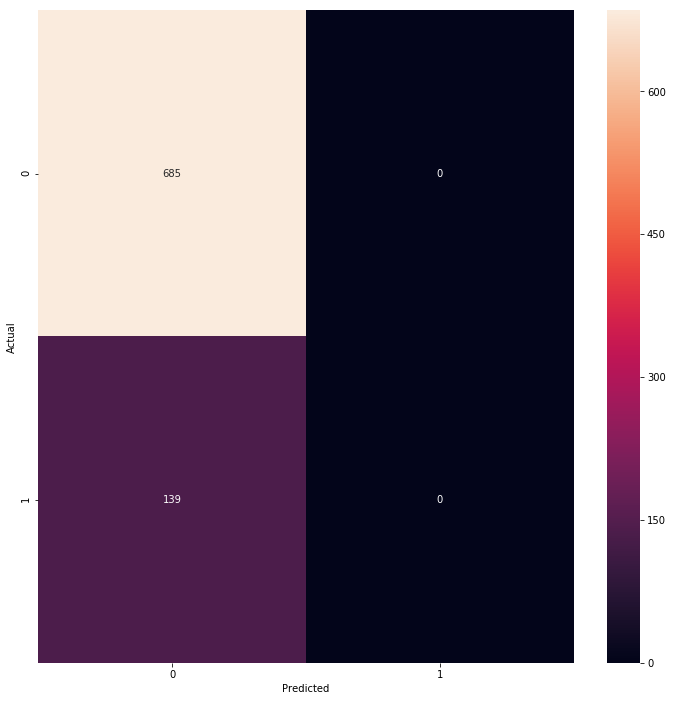

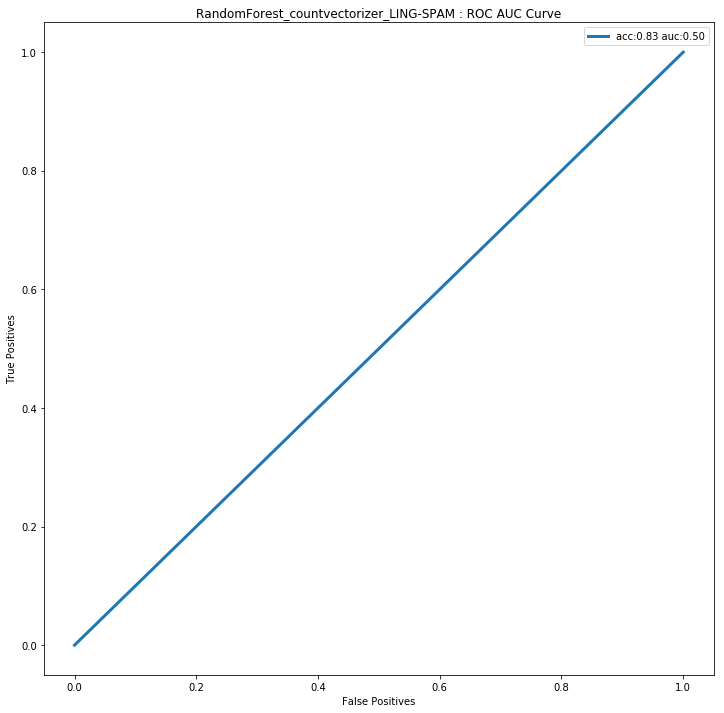

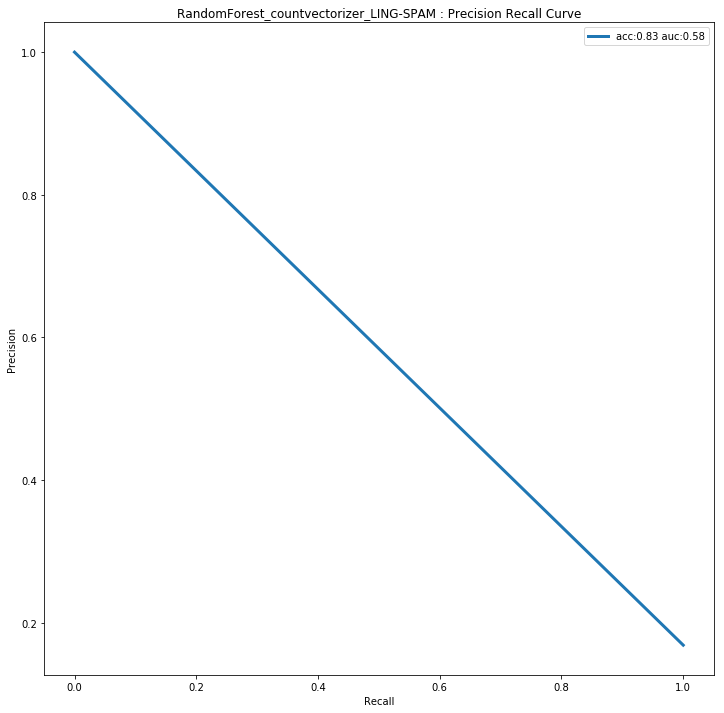

********************************************************************************
NaiveBayes_countvectorizer_LING-SPAM
********************************************************************************
Log Loss :  5.826322717102651
ROC AUC :  0.5
Accuracy :  0.8313106796116505
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91       685
         1.0       0.00      0.00      0.00       139

   micro avg       0.83      0.83      0.83       824
   macro avg       0.42      0.50      0.45       824
weighted avg       0.69      0.83      0.75       824



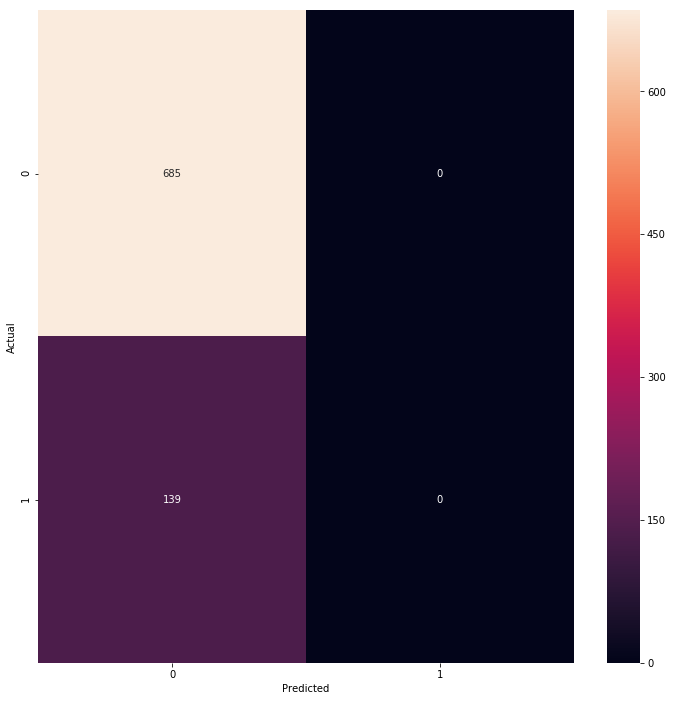

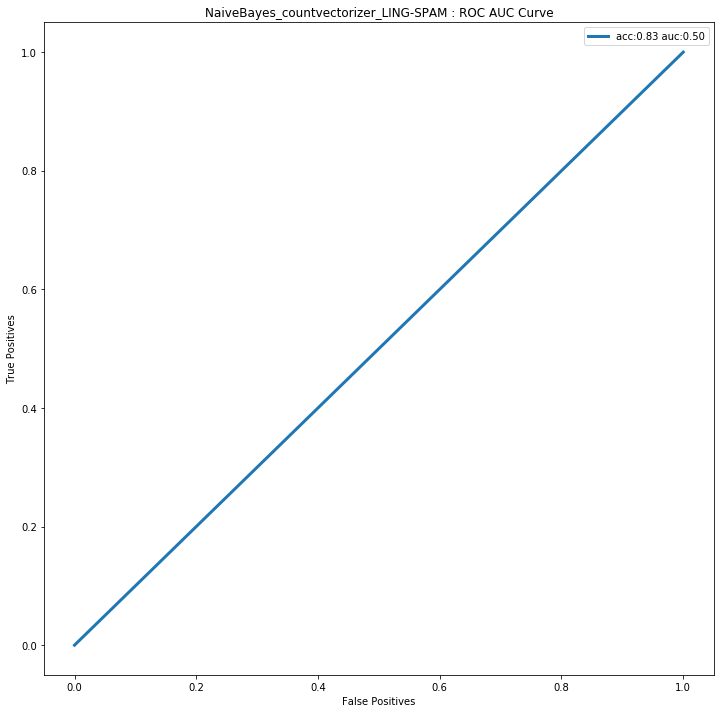

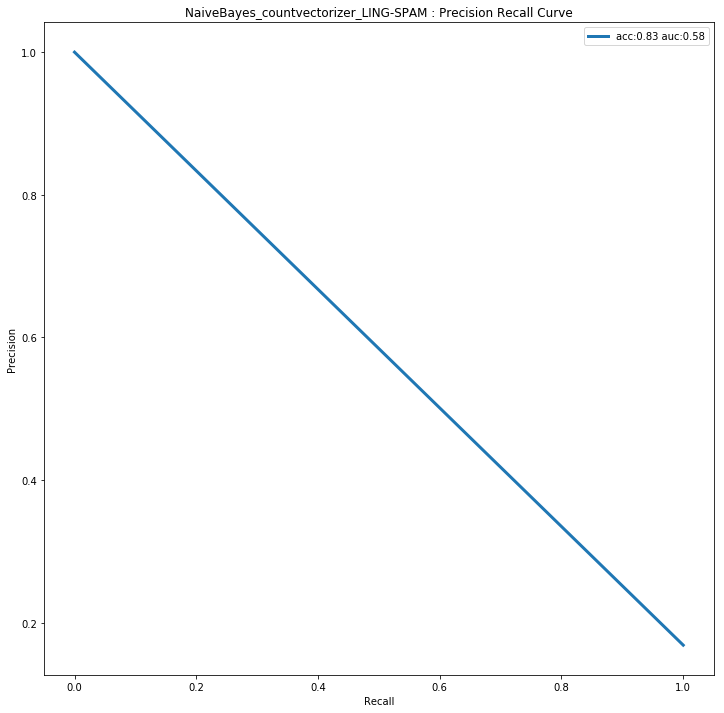

In [36]:
calculate_evaluation_metrics_and_display_metrics(dataset, text_x_with_random_scrambled_strings, y_test)

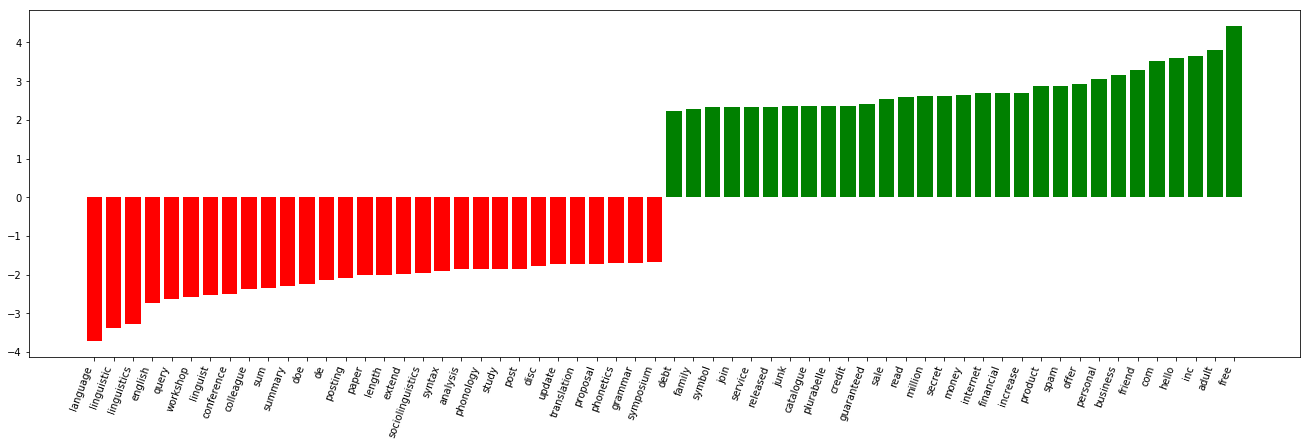

In [37]:
visualize_coefficients(grids['LogisticRegression_countvectorizer_'+dataset].best_estimator_.steps[1][1], grids['LogisticRegression_countvectorizer_'+dataset].best_estimator_.steps[0][1].get_feature_names())

## 2. TFIDF Approach

## Trying various models and keeping track of best performing params

In [38]:
%%time
grids ={}
entropies = {}
try_various_models_on_data(dataset, train_x_cleaned,y_train, test_x_cleaned, y_test, preprocessing='tfidfvectorizer')
gc.enable(); gc.collect();

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   31.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score :  0.9531174480425326
Test Accuracy :  0.9611650485436893
Best Params :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 1)}

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.8min finished


Best Score :  0.9618173030449493
Test Accuracy :  0.9635922330097088
Best Params :  {'svc__C': 10, 'svc__gamma': 0.1, 'tfidfvectorizer__ngram_range': (1, 1)}

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 24.7min finished


Best Score :  0.9062348960850652
Test Accuracy :  0.9053398058252428
Best Params :  {'tfidfvectorizer__ngram_range': (1, 1), 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 1000}

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.4min finished


Best Score :  0.9149347510874819
Test Accuracy :  0.9211165048543689
Best Params :  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 500, 'tfidfvectorizer__ngram_range': (1, 1)}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score :  0.9705171580473658
Test Accuracy :  0.9757281553398058
Best Params :  {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
CPU times: user 19.9 s, sys: 668 ms, total: 20.6 s
Wall time: 28min 49s


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    5.1s finished


## Visualise Shannon and Relative entropies for various models

********************************************************************************
LogisticRegression_tfidfvectorizer_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.0937059512581596
Mean Relative Entropy :  0.09626358155698314
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2     0.500     1.611     1.0     0.0       0.800       0.200
21    0.652     1.028     1.0     0.0       0.642       0.358
22    0.582     1.315     1.0     0.0       0.732       0.268
27    0.655     1.012     1.0     0.0       0.637       0.363
29    0.593     1.271     1.0     0.0       0.719       0.281
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
172    0.683     0.848     0.0     1.0       0.428       0.572
525    0.686     0.825     0.0     1.0       0.438       0.562
591    0.693     0.706     0.0     1.0       0.494       0.506
681    0.681     0.862     0.0     1.0       0.422       0.57

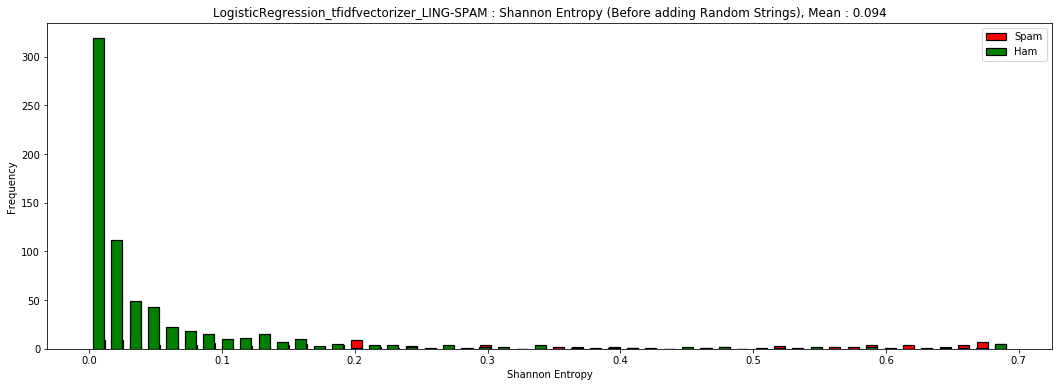

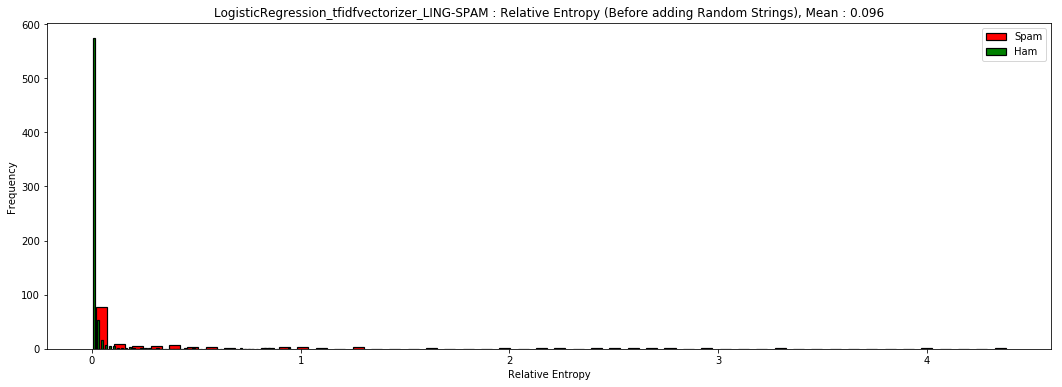

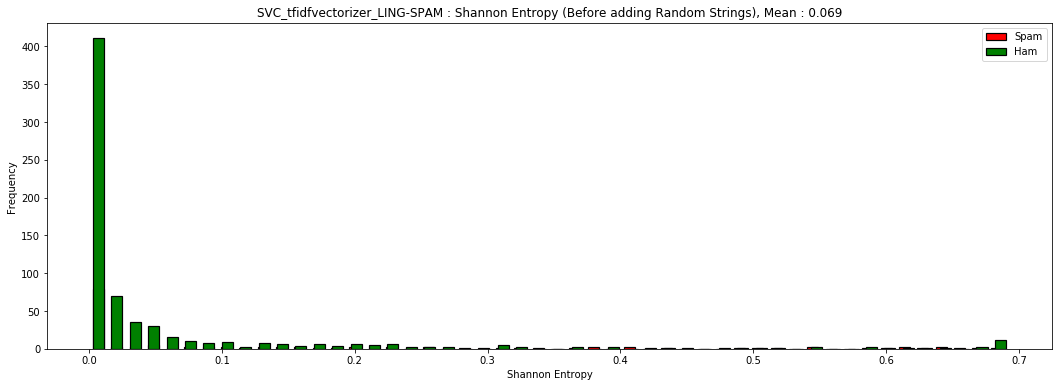

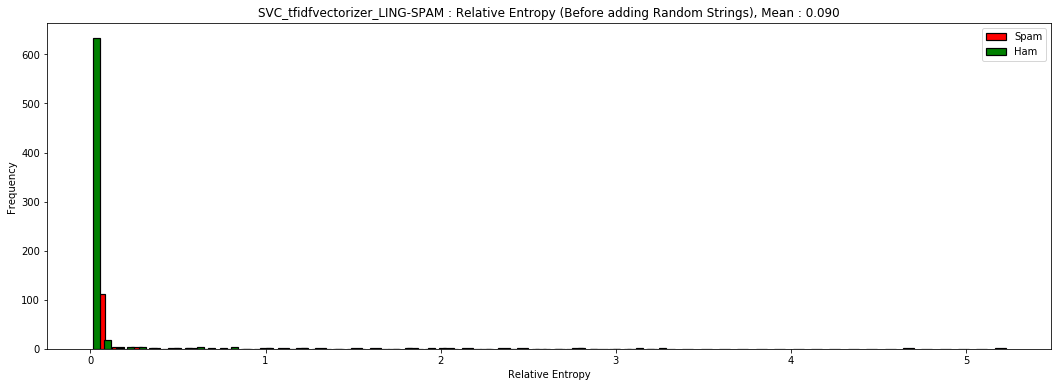

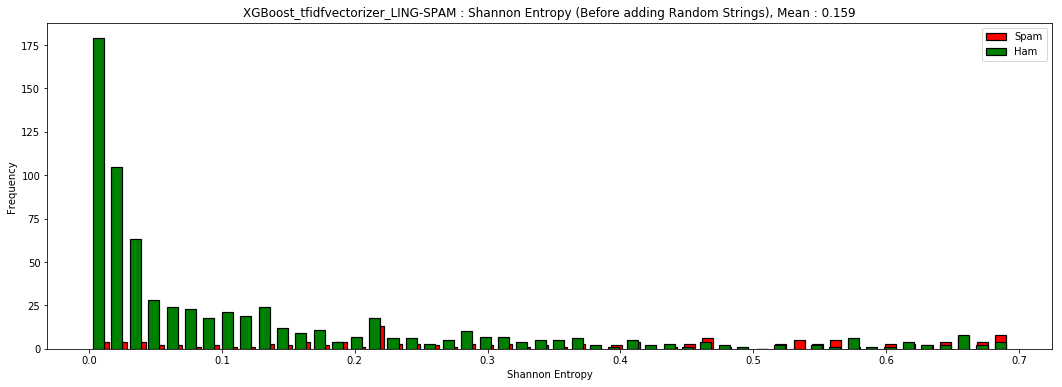

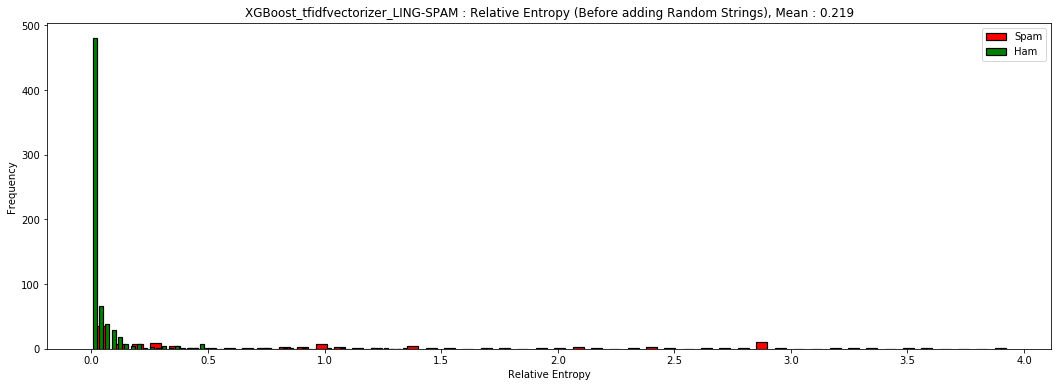

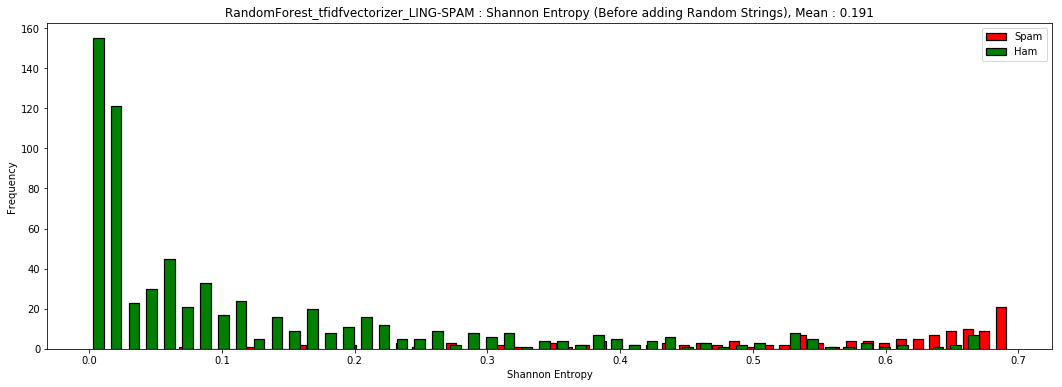

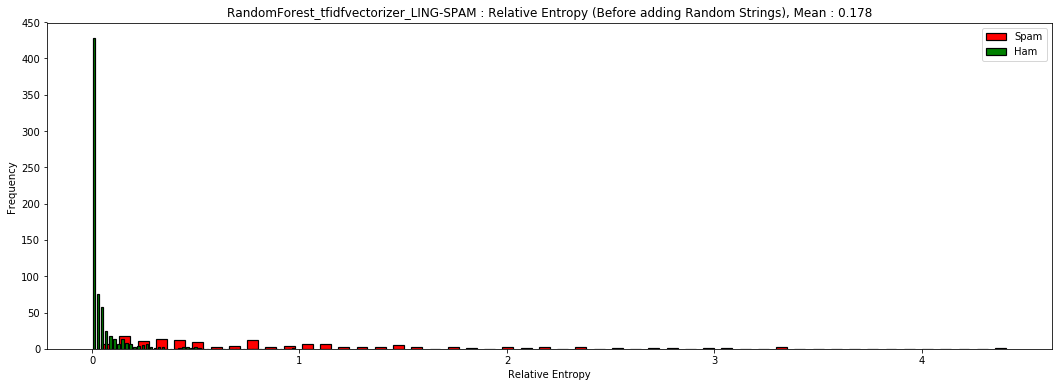

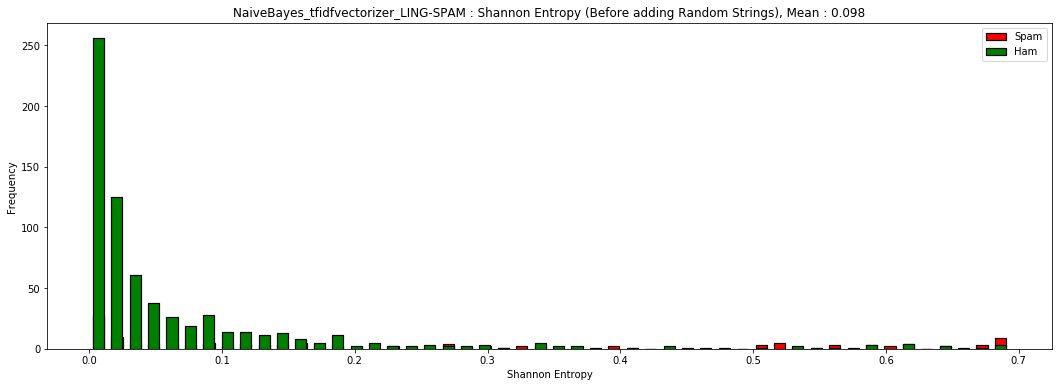

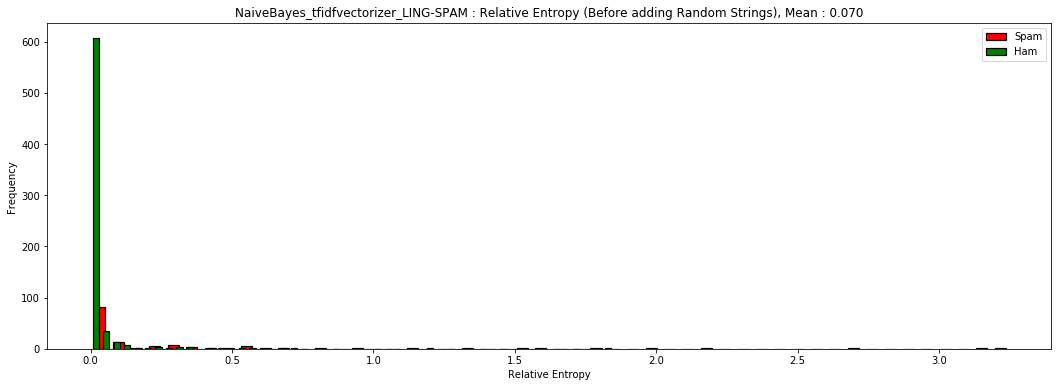

In [39]:
visualise_entropies(dataset, test_x_cleaned, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
LogisticRegression_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  1.3413175269681115
ROC AUC :  0.9921756025836266
Accuracy :  0.9611650485436893
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       685
         1.0       0.95      0.81      0.88       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.96      0.90      0.93       824
weighted avg       0.96      0.96      0.96       824



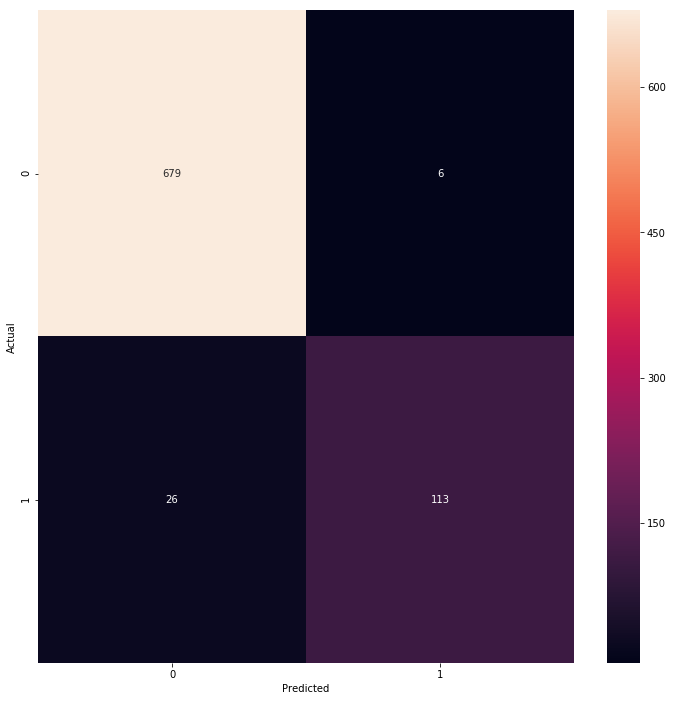

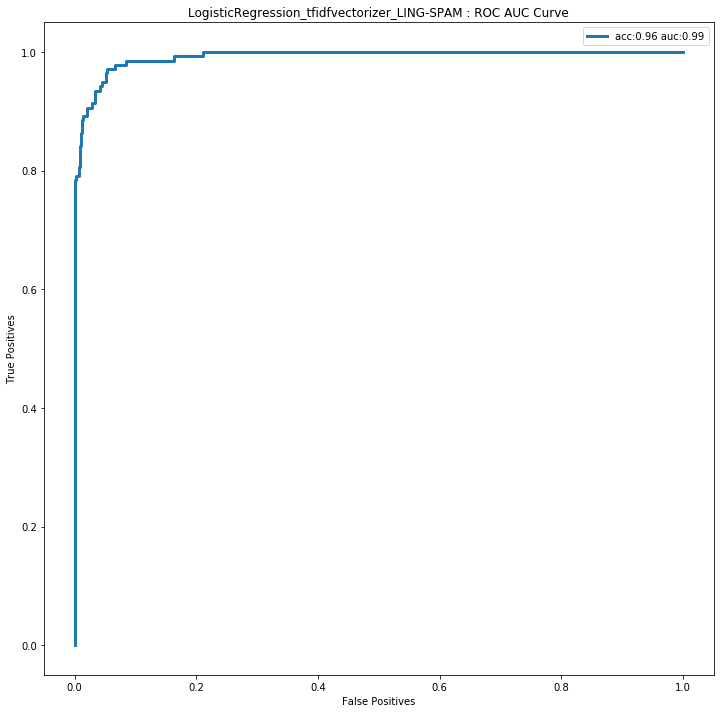

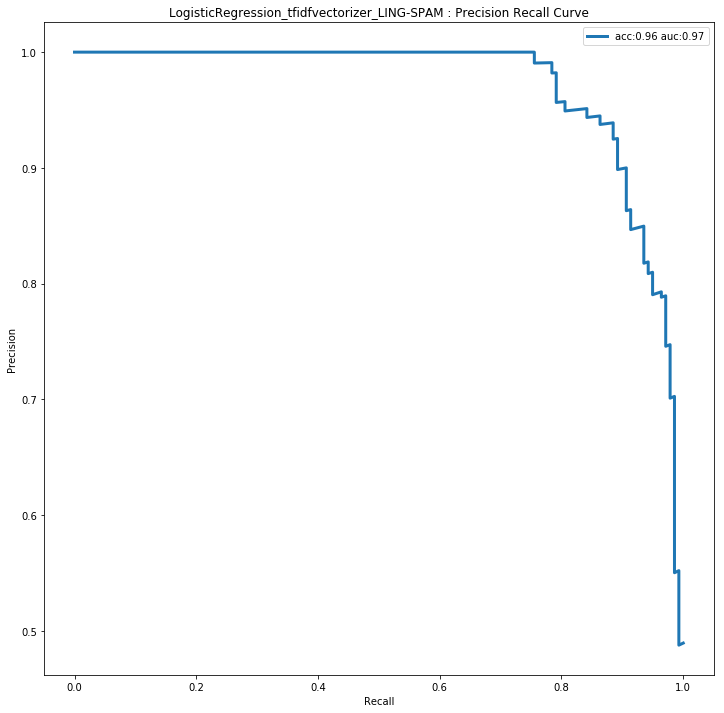

********************************************************************************
SVC_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  1.2574865158122968
ROC AUC :  0.9910098198813212
Accuracy :  0.9635922330097088
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       685
         1.0       0.94      0.83      0.89       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.96      0.91      0.93       824
weighted avg       0.96      0.96      0.96       824



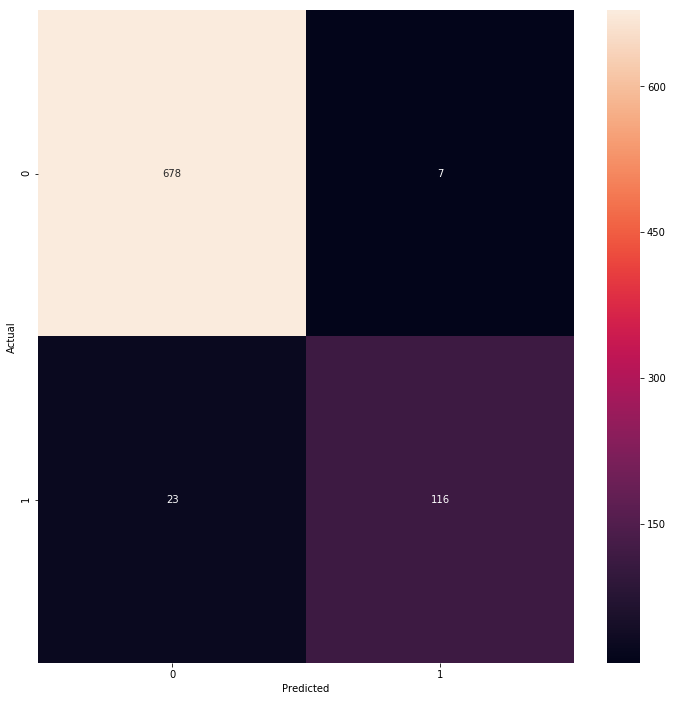

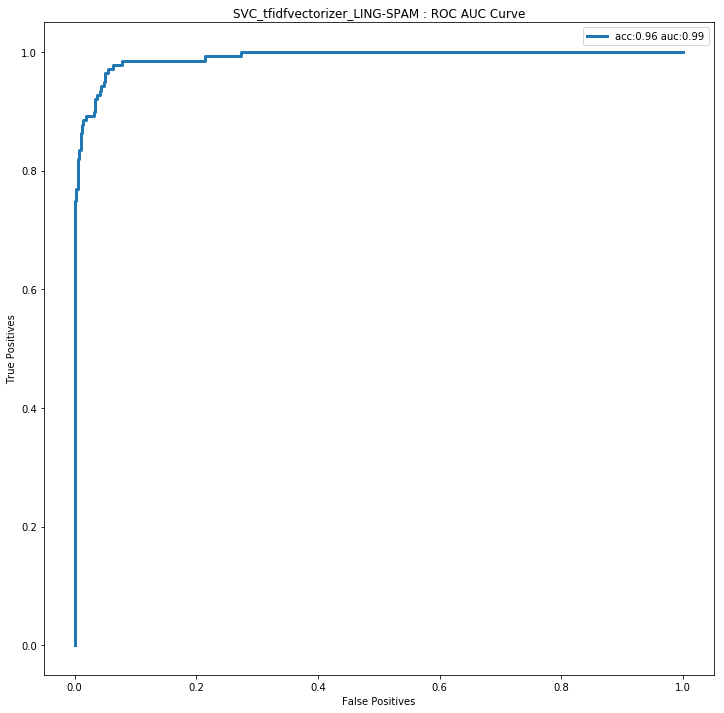

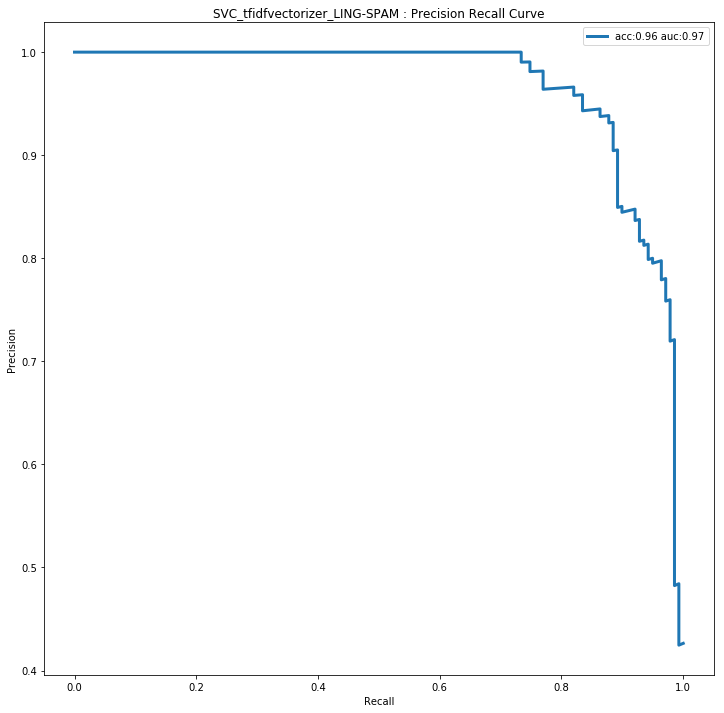

********************************************************************************
XGBoost_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  3.269456983953078
ROC AUC :  0.9497295594181588
Accuracy :  0.9053398058252428
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95       685
         1.0       0.88      0.51      0.65       139

   micro avg       0.91      0.91      0.91       824
   macro avg       0.89      0.75      0.80       824
weighted avg       0.90      0.91      0.89       824



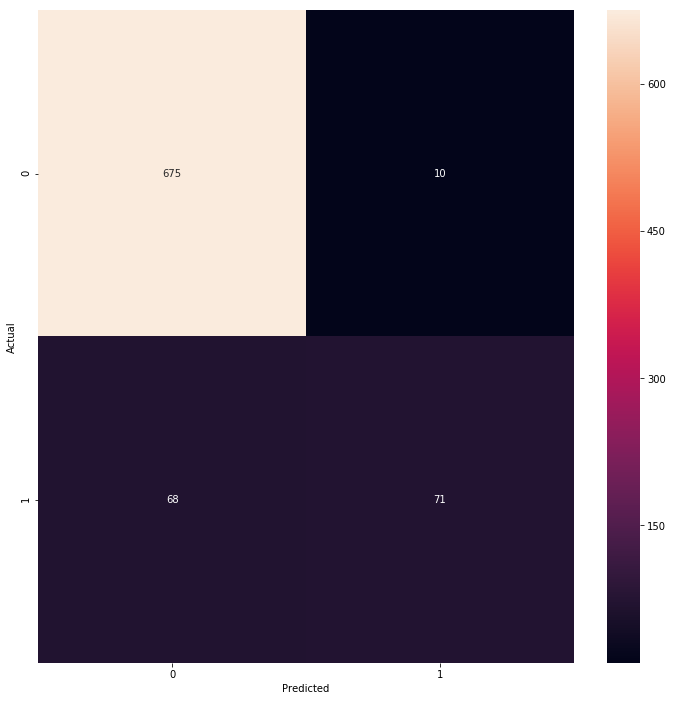

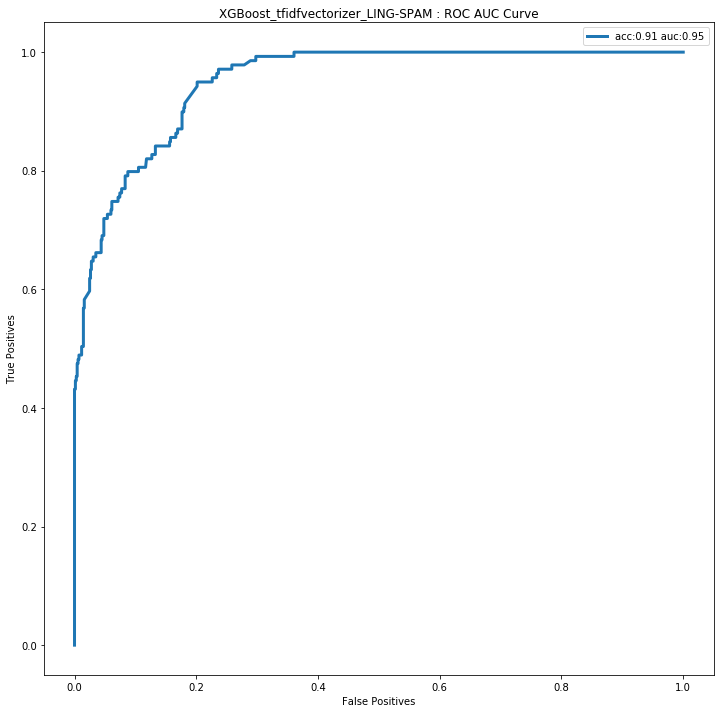

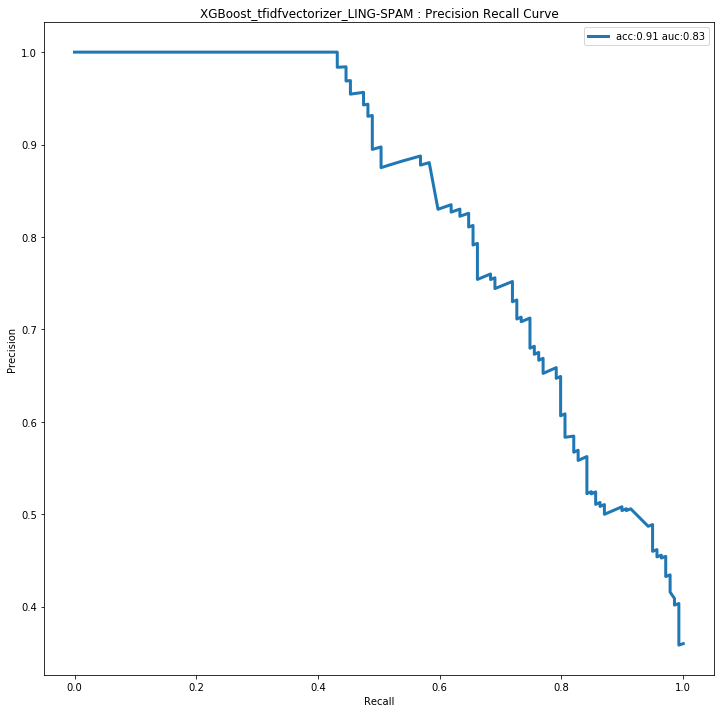

********************************************************************************
RandomForest_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  2.7245403704692057
ROC AUC :  0.9748989129863992
Accuracy :  0.9211165048543689
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       685
         1.0       0.99      0.54      0.70       139

   micro avg       0.92      0.92      0.92       824
   macro avg       0.95      0.77      0.83       824
weighted avg       0.93      0.92      0.91       824



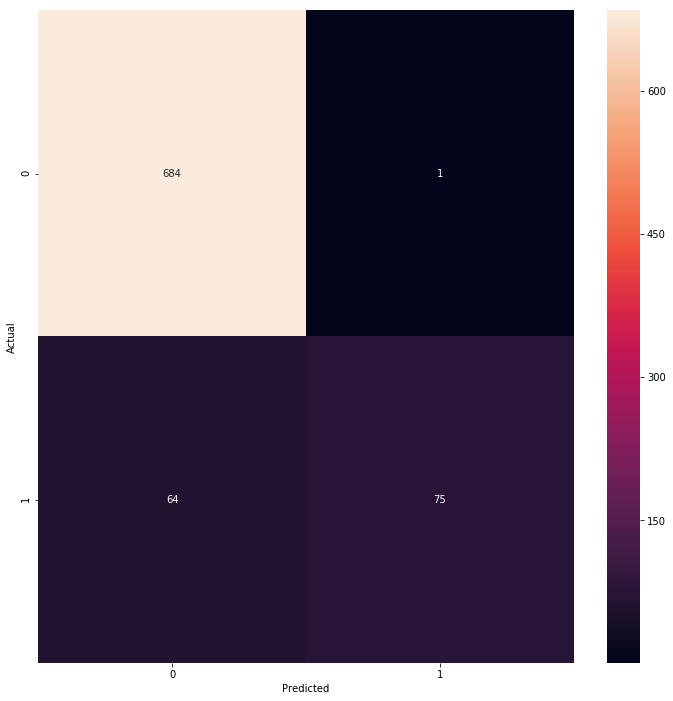

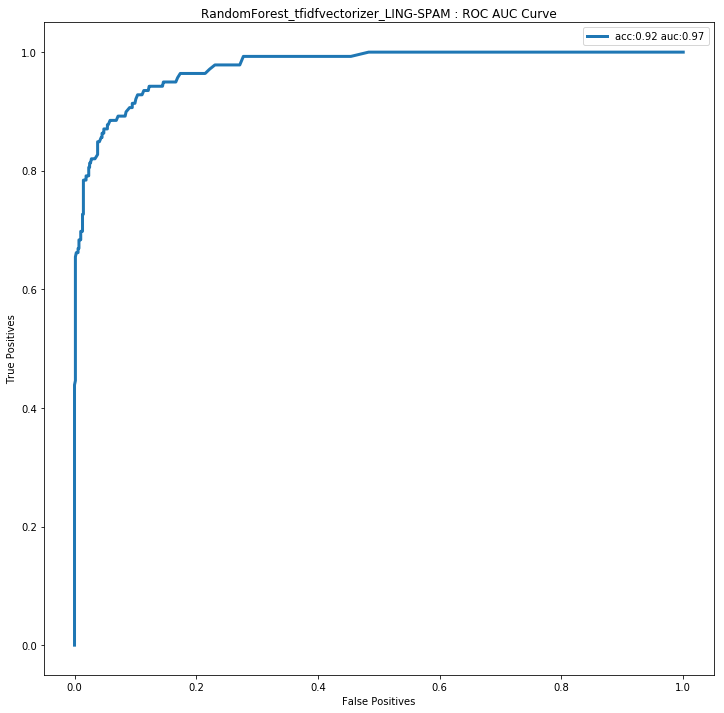

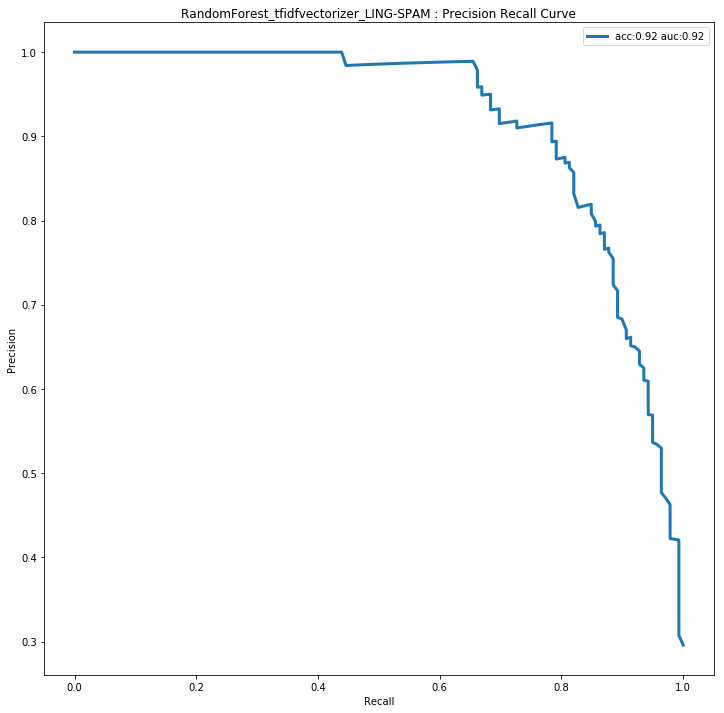

********************************************************************************
NaiveBayes_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  0.8383236969513775
ROC AUC :  0.9957359659717481
Accuracy :  0.9757281553398058
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       685
         1.0       0.97      0.88      0.92       139

   micro avg       0.98      0.98      0.98       824
   macro avg       0.97      0.94      0.96       824
weighted avg       0.98      0.98      0.98       824



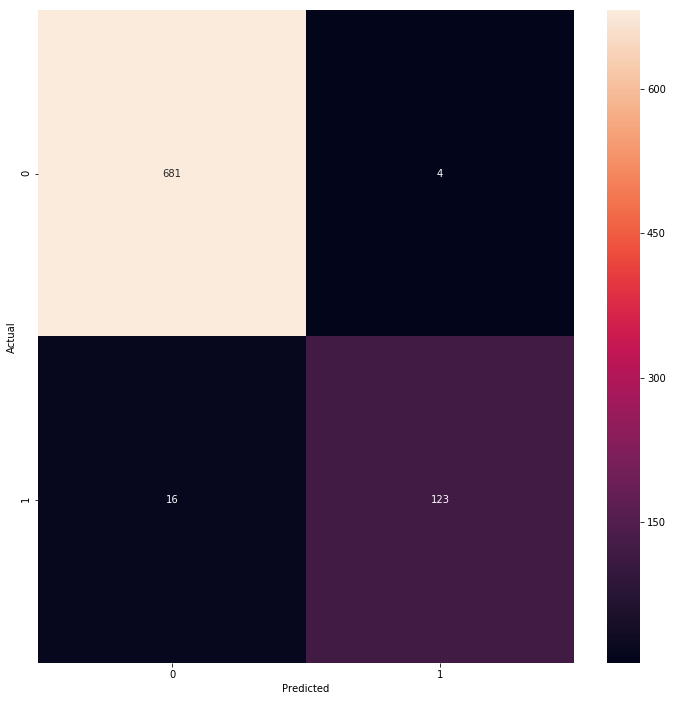

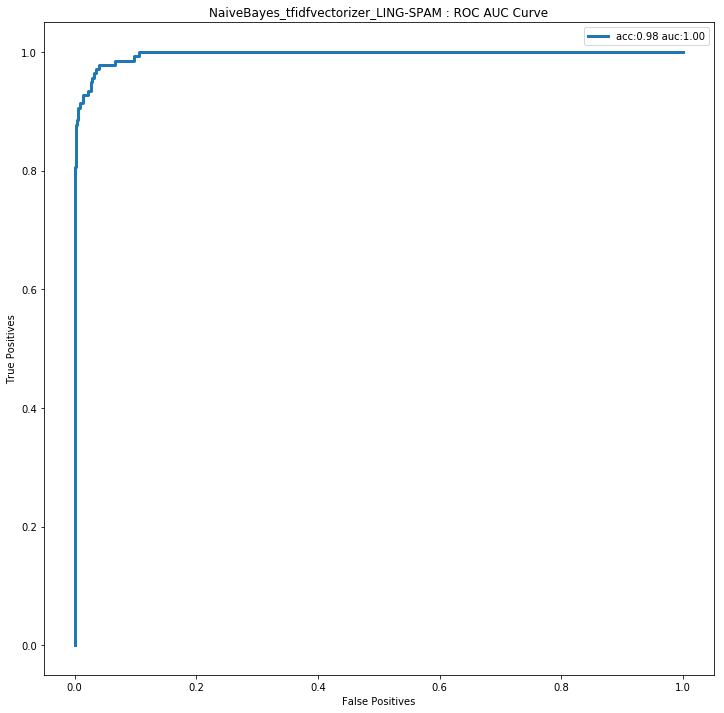

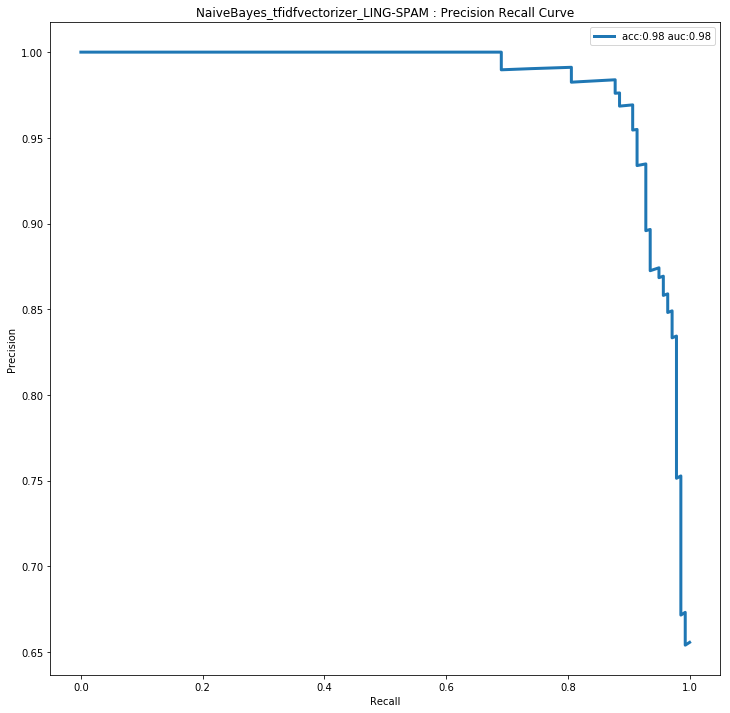

In [40]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cleaned, y_test)

## Adding Meaningful Strings to Test Data

In [41]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_tfidfvectorizer_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.09579643734170055
Mean Relative Entropy :  0.11224475788918803
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2     0.404     1.970     1.0     0.0       0.861       0.139
21    0.570     1.357     1.0     0.0       0.743       0.257
22    0.498     1.617     1.0     0.0       0.801       0.199
27    0.562     1.389     1.0     0.0       0.751       0.249
29    0.467     1.731     1.0     0.0       0.823       0.177
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
119    0.660     0.991     1.0     0.0       0.629       0.371
122    0.223     2.836     1.0     0.0       0.941       0.059
128    0.693     0.722     1.0     0.0       0.514       0.486
136    0.192     3.043     1.0     0.0       0.952       0.0

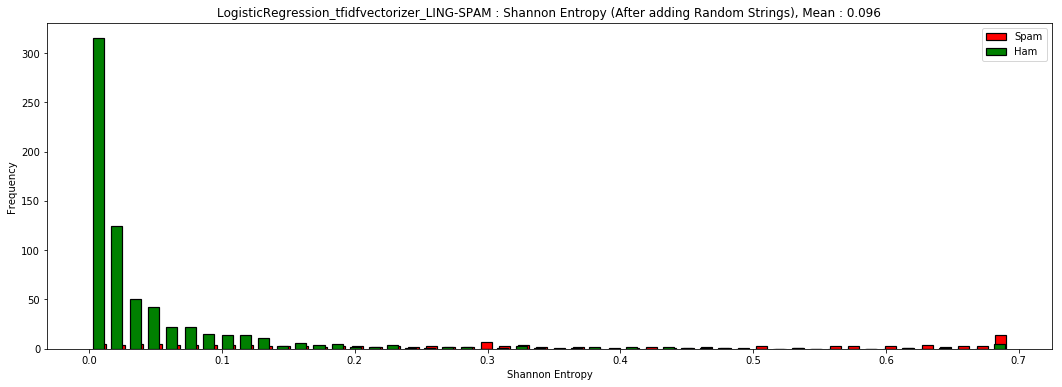

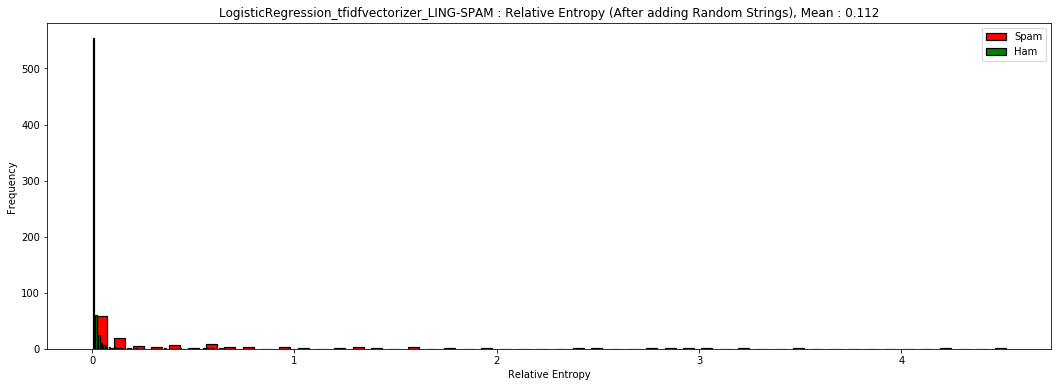

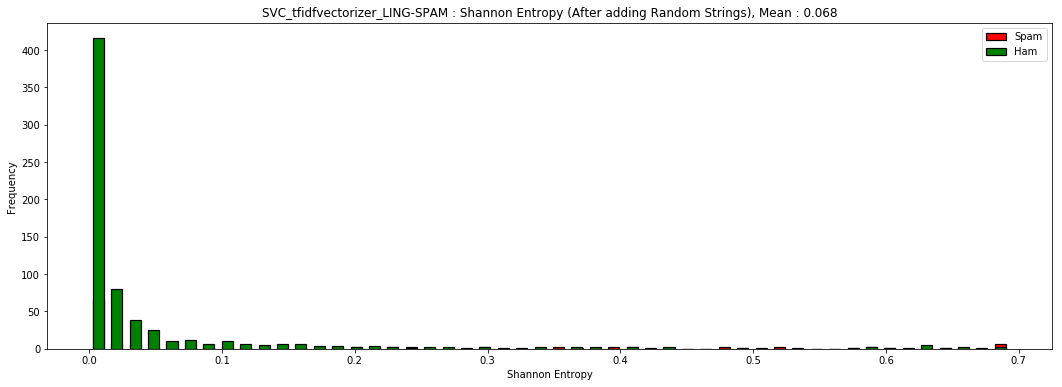

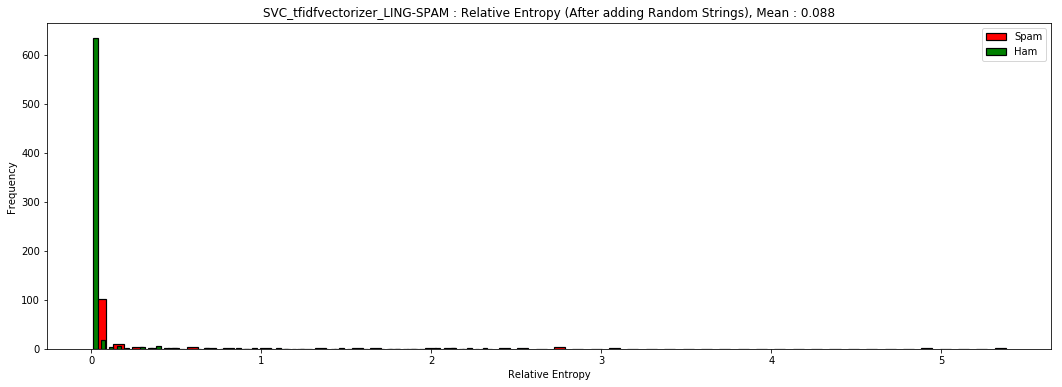

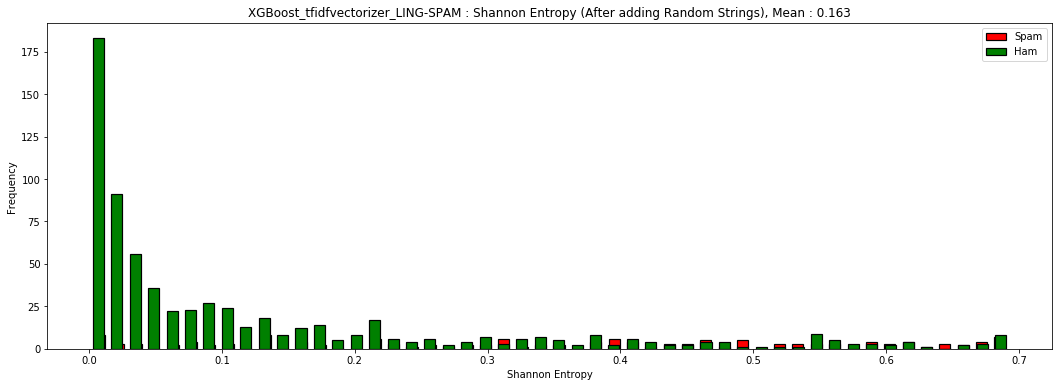

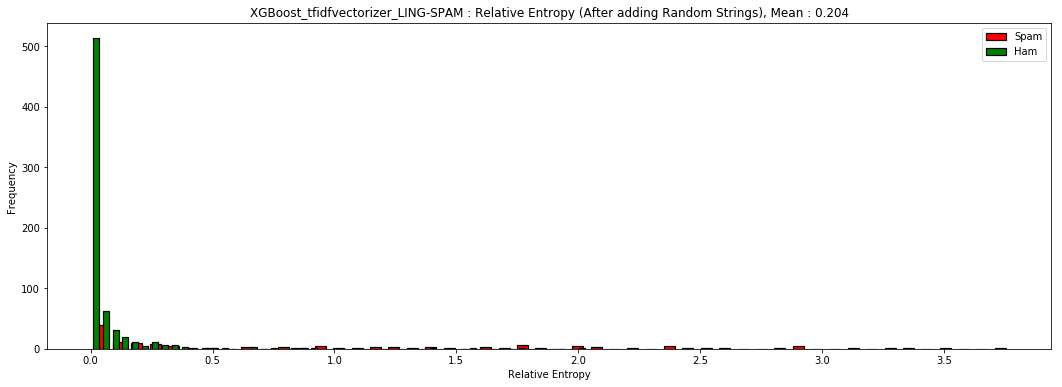

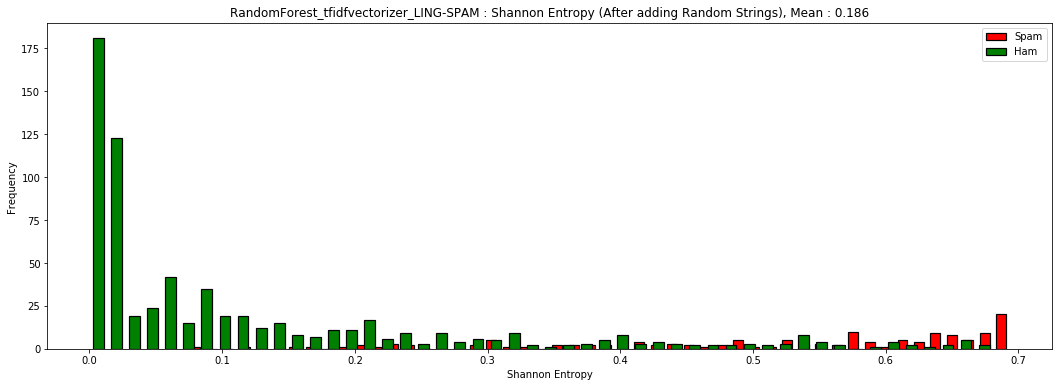

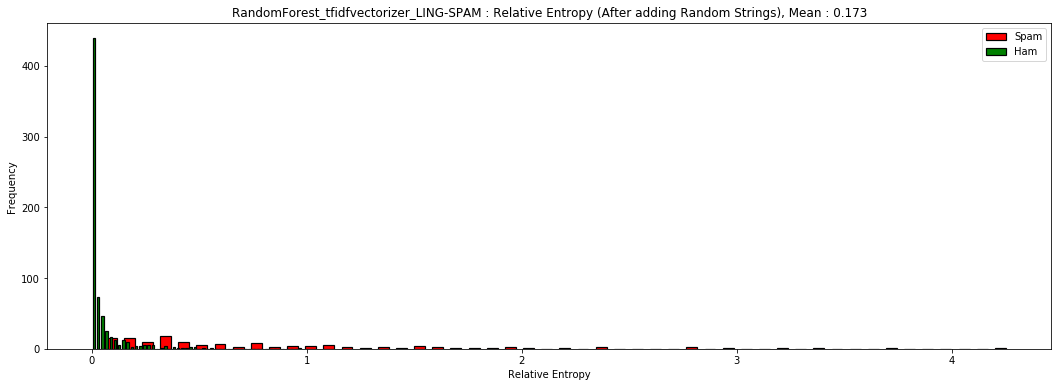

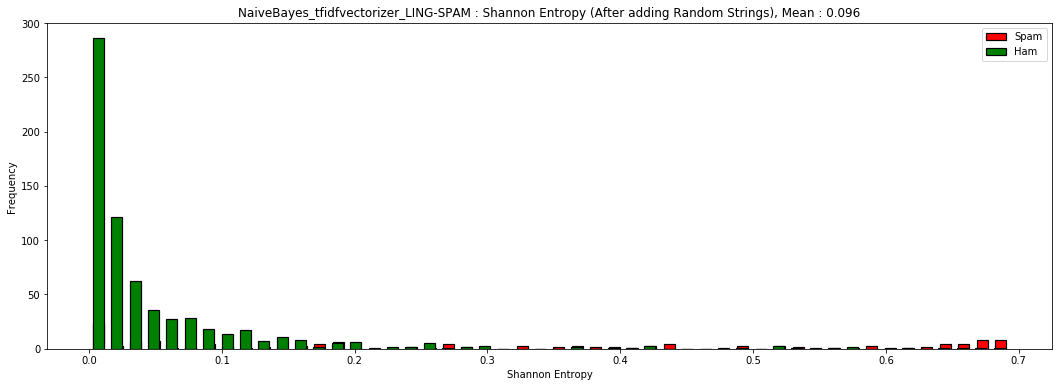

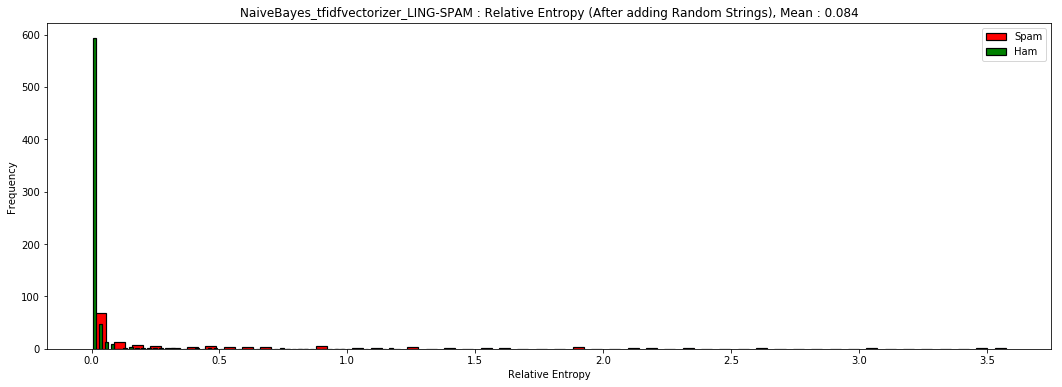

In [42]:
visualise_entropies(dataset, test_x_with_random_strings, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  1.4251436861977718
ROC AUC :  0.9920390694743474
Accuracy :  0.9587378640776699
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       685
         1.0       1.00      0.76      0.86       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.98      0.88      0.92       824
weighted avg       0.96      0.96      0.96       824



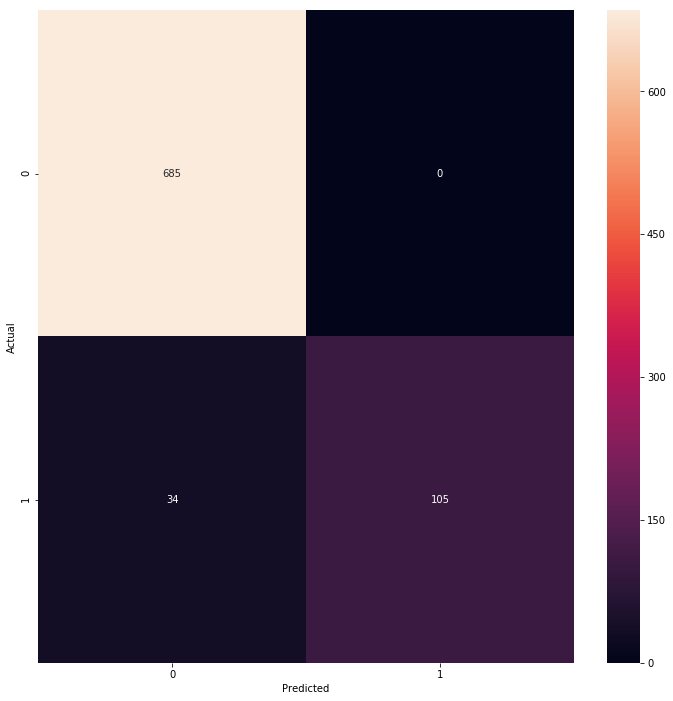

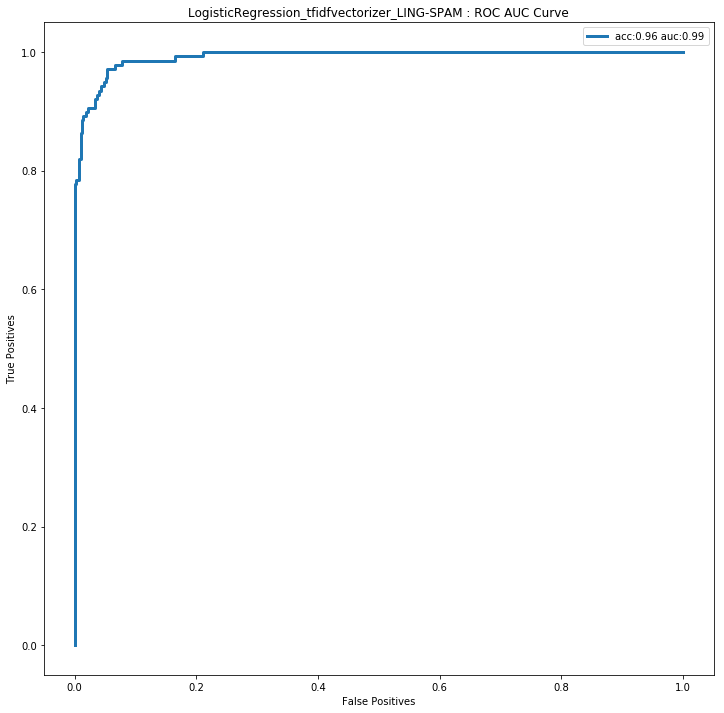

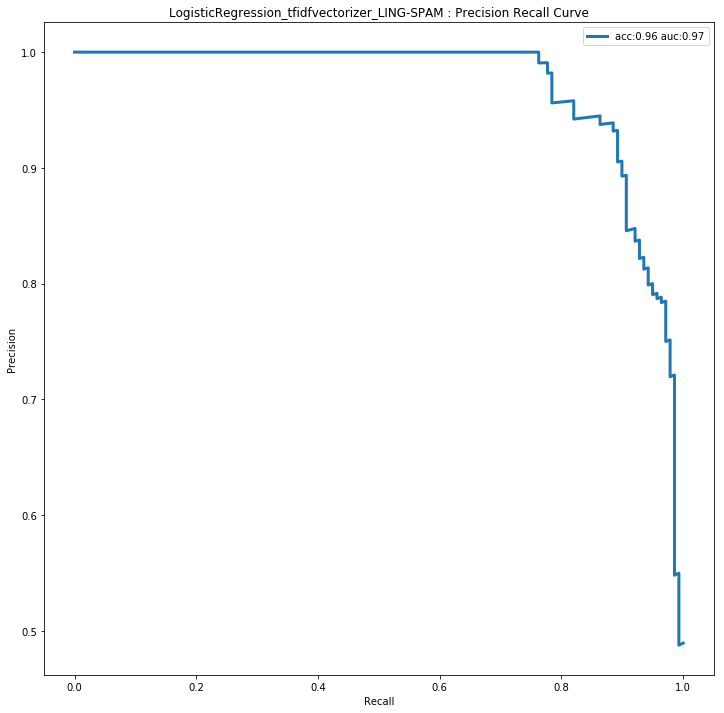

********************************************************************************
SVC_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  1.3832315769681724
ROC AUC :  0.9908207740377042
Accuracy :  0.9599514563106796
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       685
         1.0       0.96      0.79      0.87       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.96      0.89      0.92       824
weighted avg       0.96      0.96      0.96       824



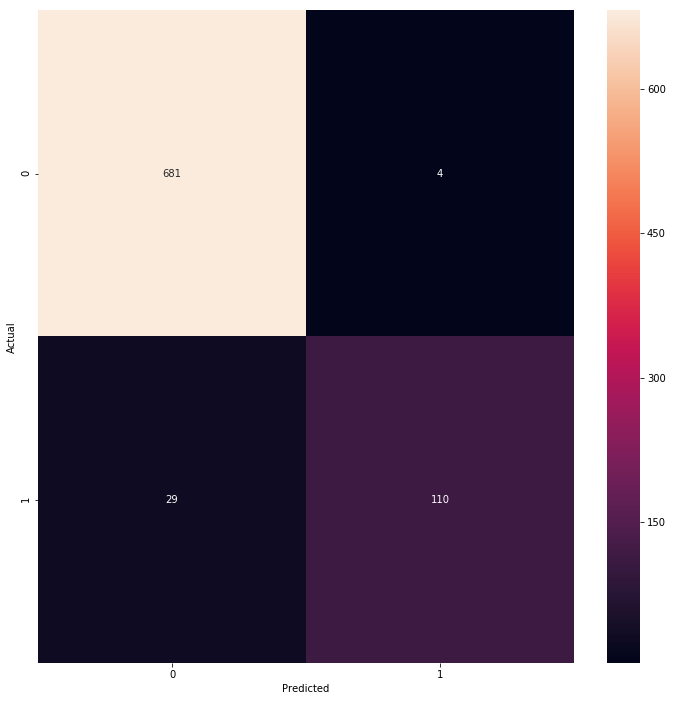

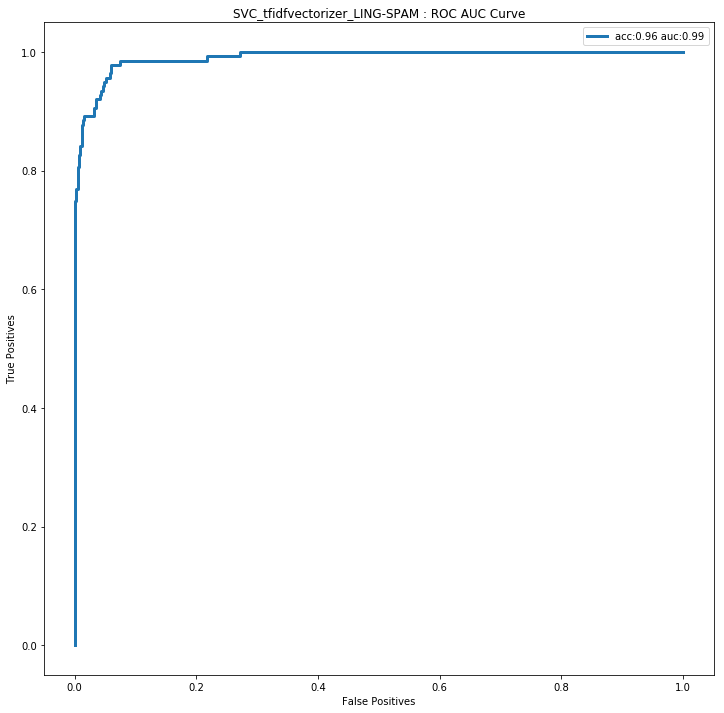

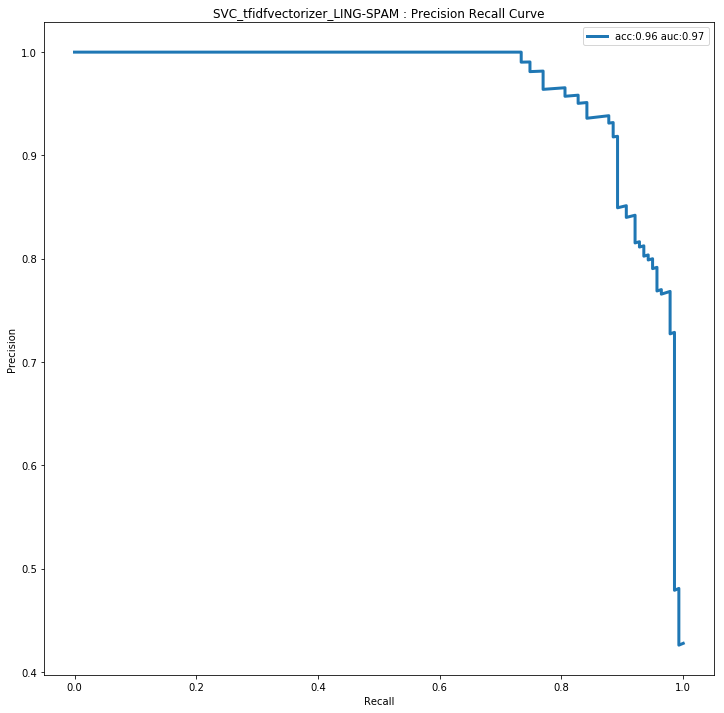

********************************************************************************
XGBoost_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  3.0179620097151725
ROC AUC :  0.9539673370792418
Accuracy :  0.912621359223301
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       685
         1.0       0.88      0.56      0.68       139

   micro avg       0.91      0.91      0.91       824
   macro avg       0.90      0.77      0.82       824
weighted avg       0.91      0.91      0.90       824



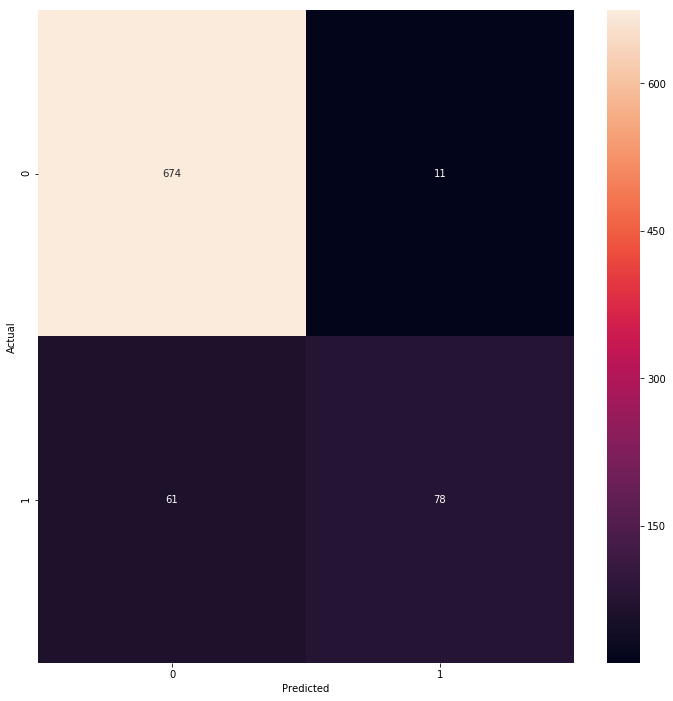

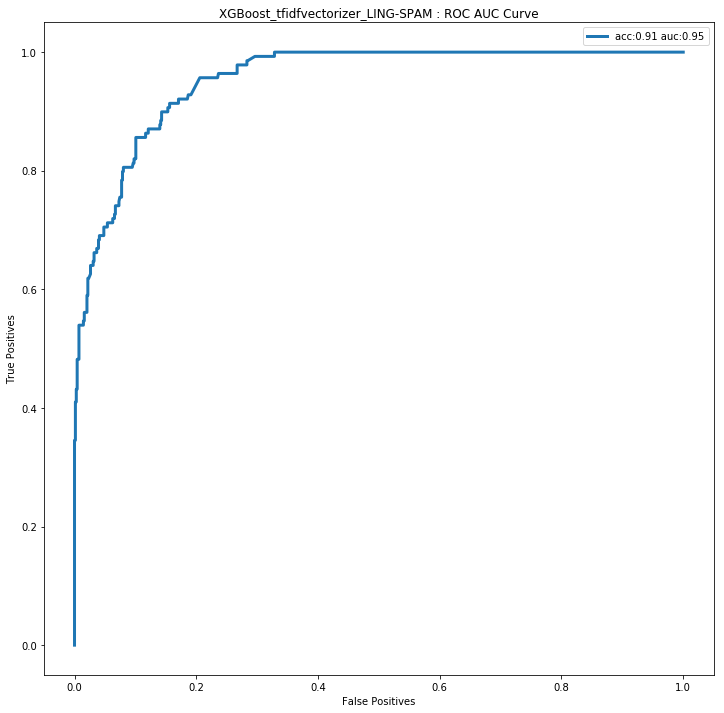

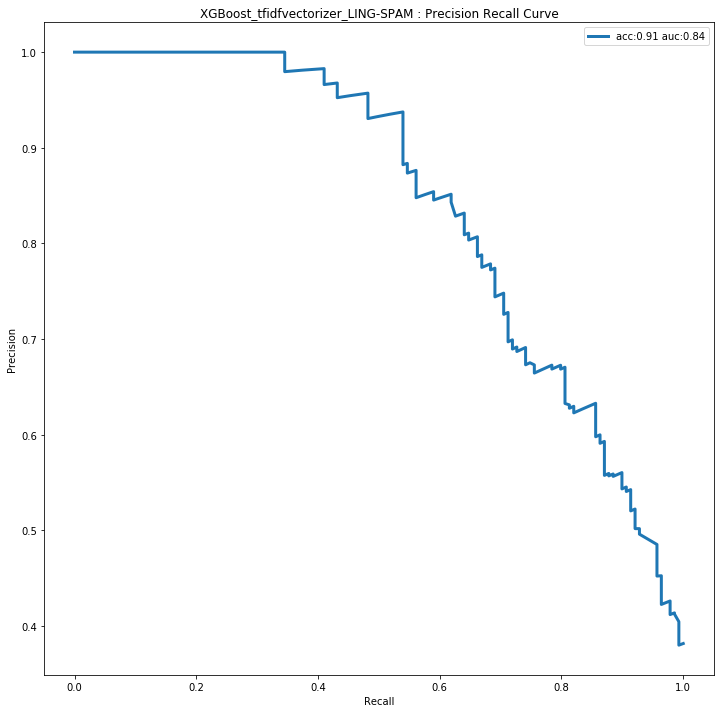

********************************************************************************
RandomForest_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  2.4730444258460693
ROC AUC :  0.9750406973691119
Accuracy :  0.9283980582524272
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       685
         1.0       0.99      0.58      0.73       139

   micro avg       0.93      0.93      0.93       824
   macro avg       0.95      0.79      0.85       824
weighted avg       0.93      0.93      0.92       824



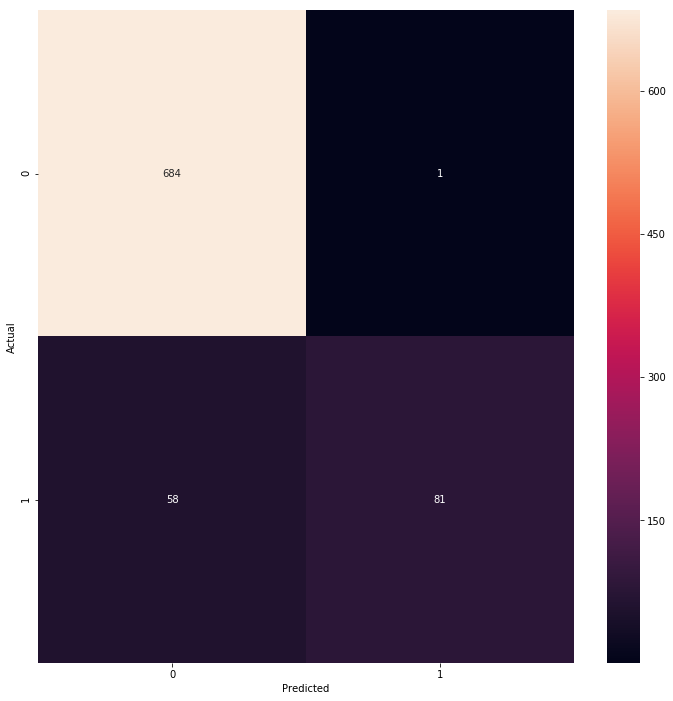

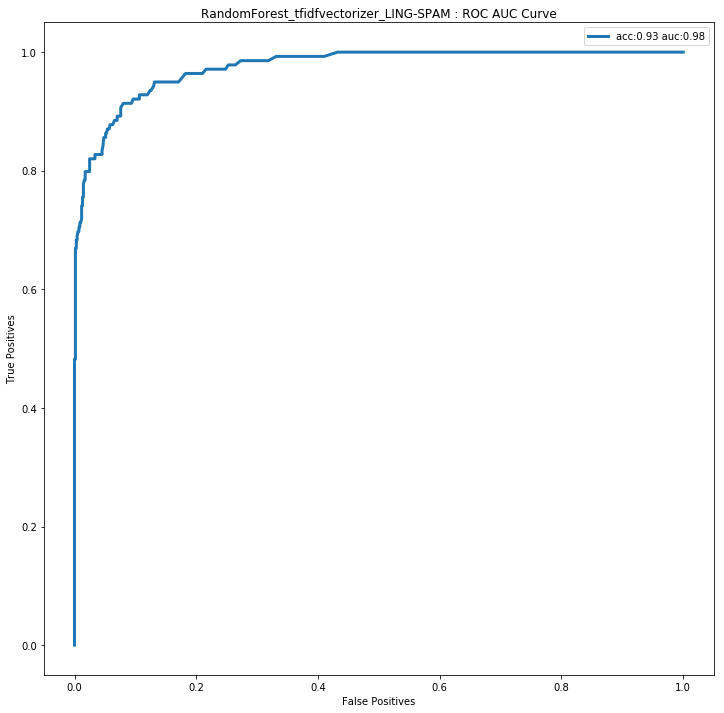

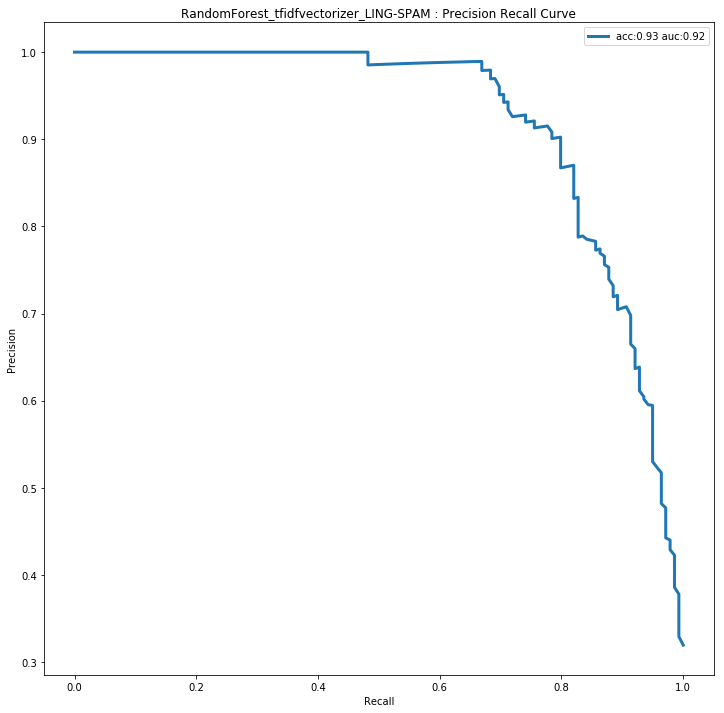

********************************************************************************
NaiveBayes_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  1.1317336915745746
ROC AUC :  0.995578427768734
Accuracy :  0.9672330097087378
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       685
         1.0       0.98      0.82      0.89       139

   micro avg       0.97      0.97      0.97       824
   macro avg       0.97      0.91      0.94       824
weighted avg       0.97      0.97      0.97       824



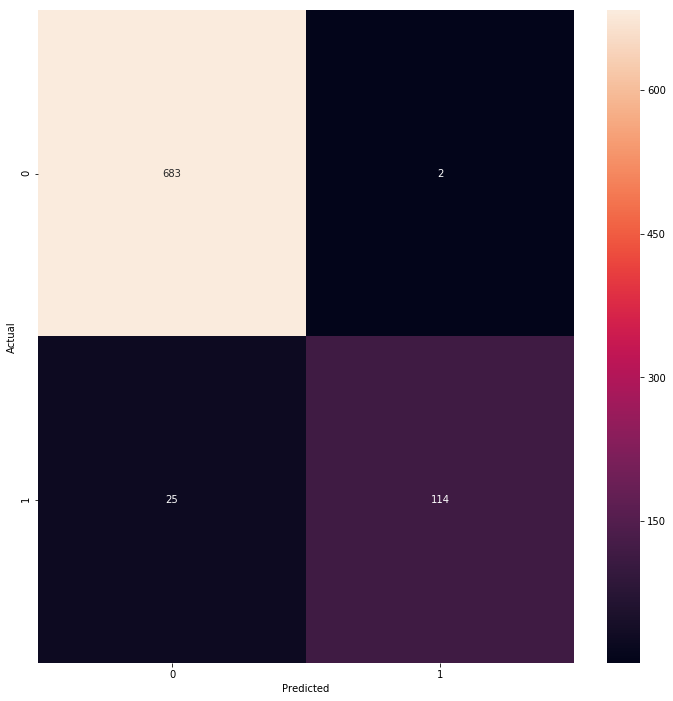

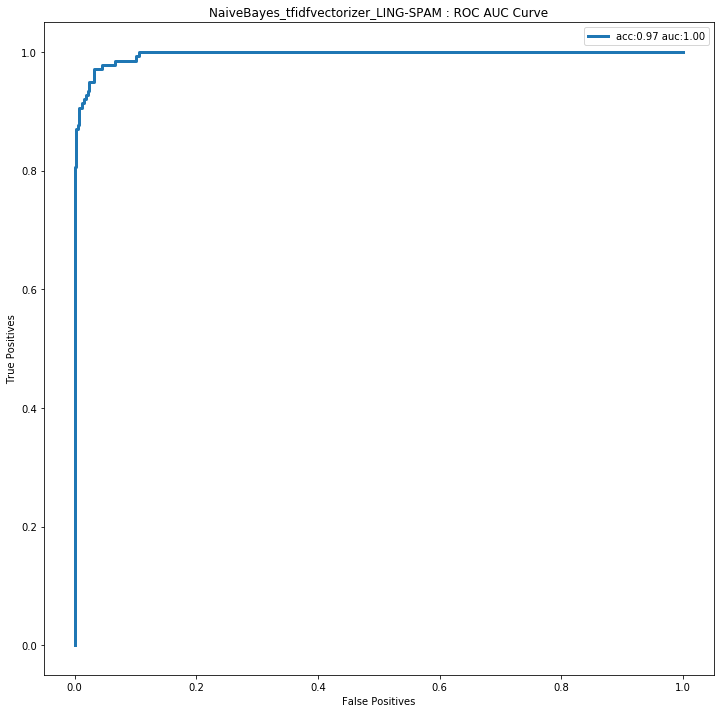

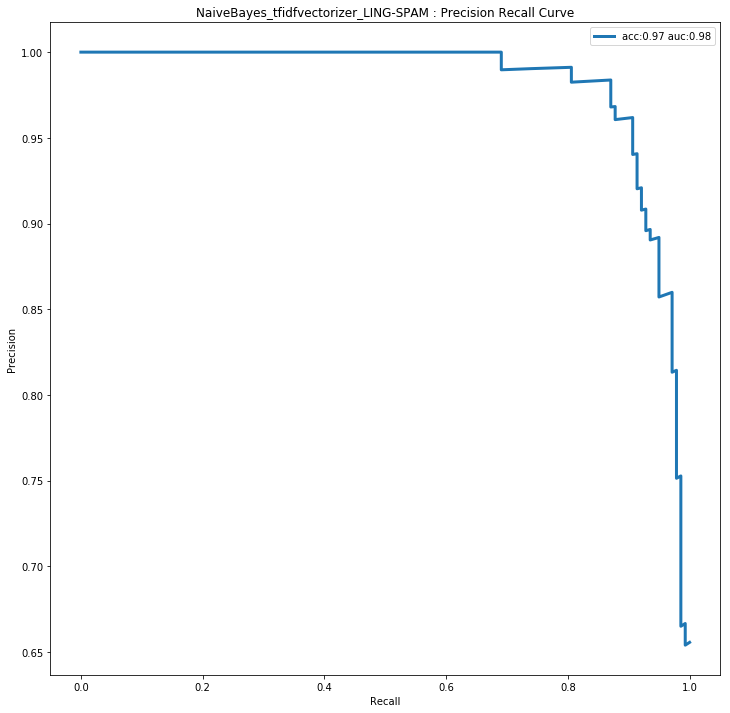

In [43]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings, y_test)

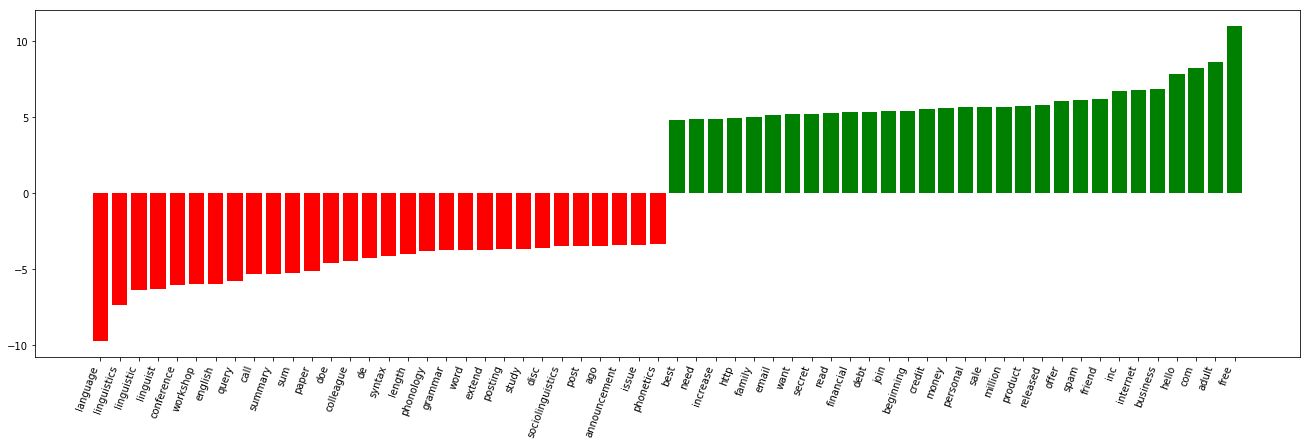

In [44]:
visualize_coefficients(grids['LogisticRegression_tfidfvectorizer_'+dataset].best_estimator_.steps[1][1], grids['LogisticRegression_tfidfvectorizer_'+dataset].best_estimator_.steps[0][1].get_feature_names())

## Adding Meaningful scrambled words Strings to Test Data

In [45]:
## adding meaningful random words that are scrambled now to the test dataset to further confuse the filter
text_x_with_random_scrambled_strings = add_meaningful_scrambled_strings (test_x_cleaned, string_size)

## Visualise Shannon and Relative entropies for various models (After Adding Scrambled Words in Strings)

********************************************************************************
LogisticRegression_tfidfvectorizer_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.2572467368150487
Mean Relative Entropy :  0.5068286537572622
Head 5 : 
   Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
0    0.257     2.639     1.0     0.0       0.929       0.071
1    0.257     2.639     1.0     0.0       0.929       0.071
2    0.257     2.639     1.0     0.0       0.929       0.071
3    0.257     2.639     1.0     0.0       0.929       0.071
4    0.257     2.639     1.0     0.0       0.929       0.071
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
134    0.257     2.639     1.0     0.0       0.929       0.071
135    0.257     2.639     1.0     0.0       0.929       0.071
136    0.257     2.639     1.0     0.0       0.929       0.071
137    0.257     2.639     1.0     0.0       0.929       0.071
138  

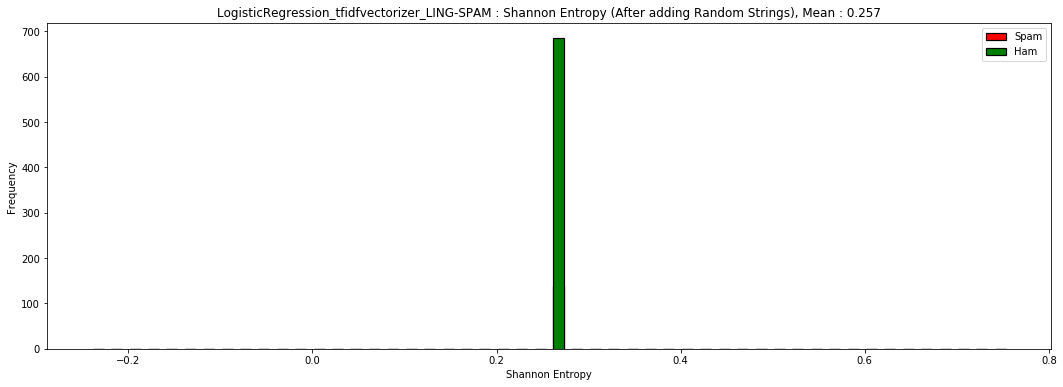

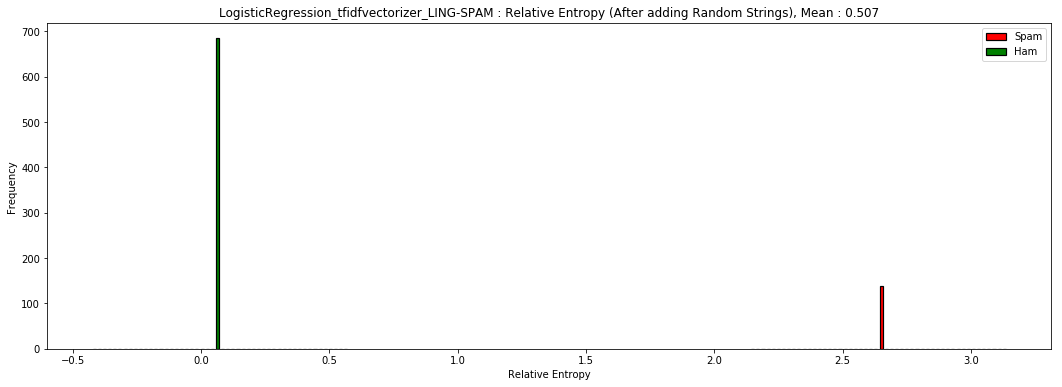

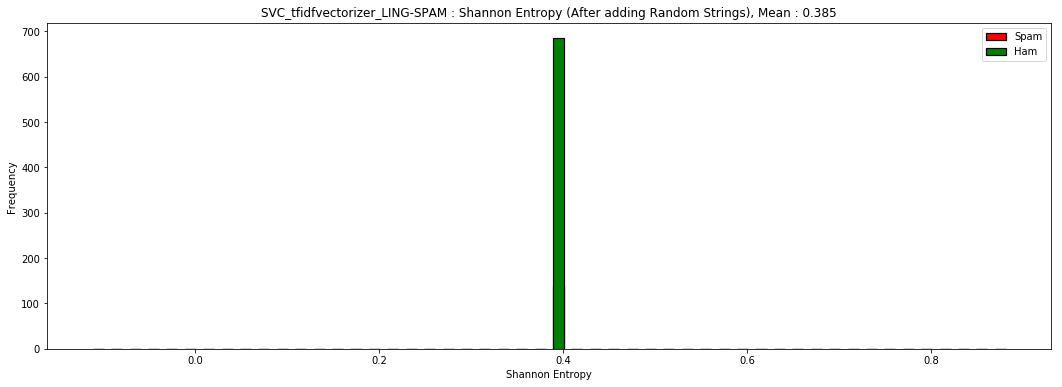

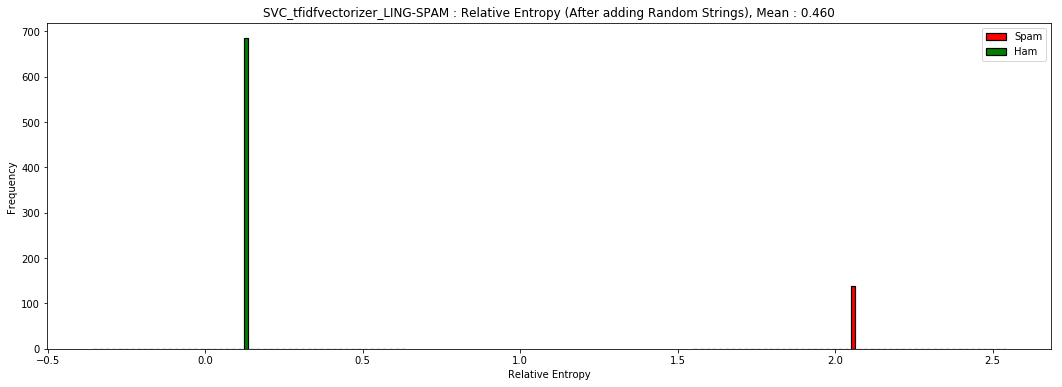

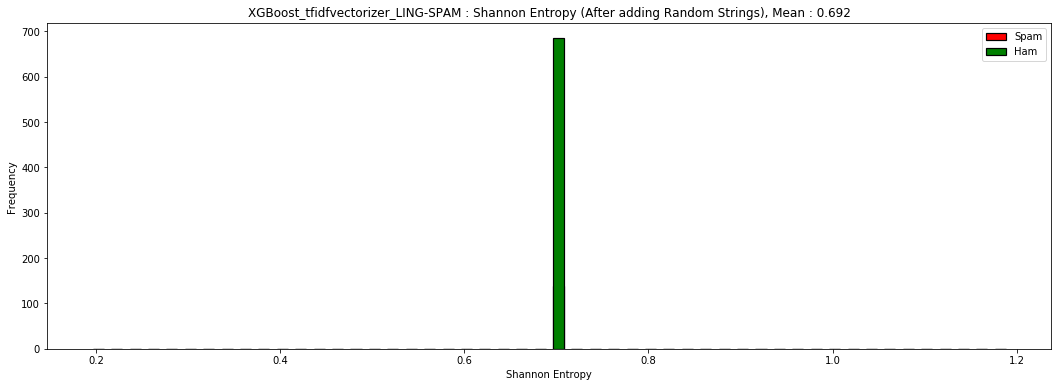

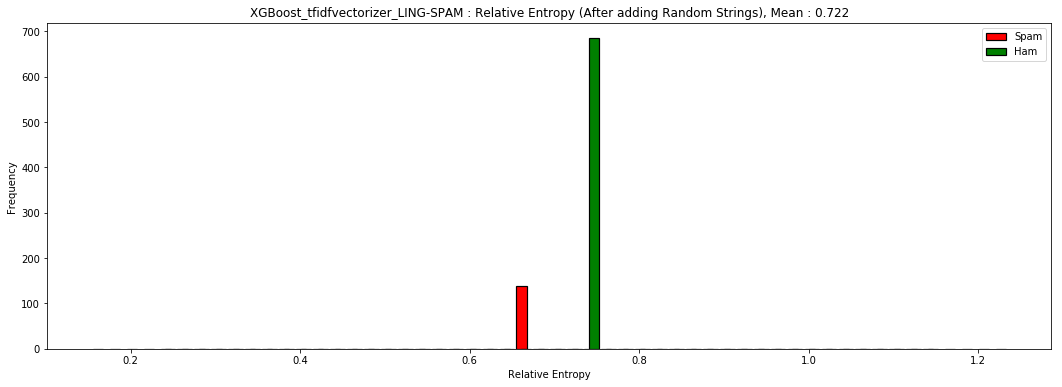

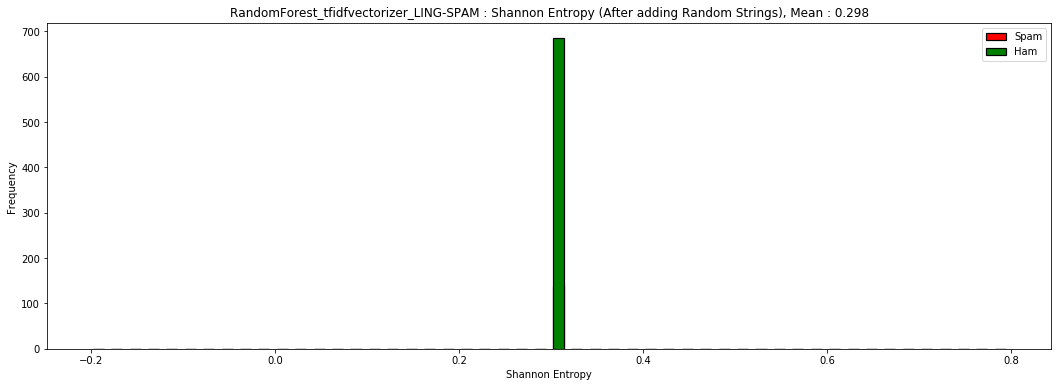

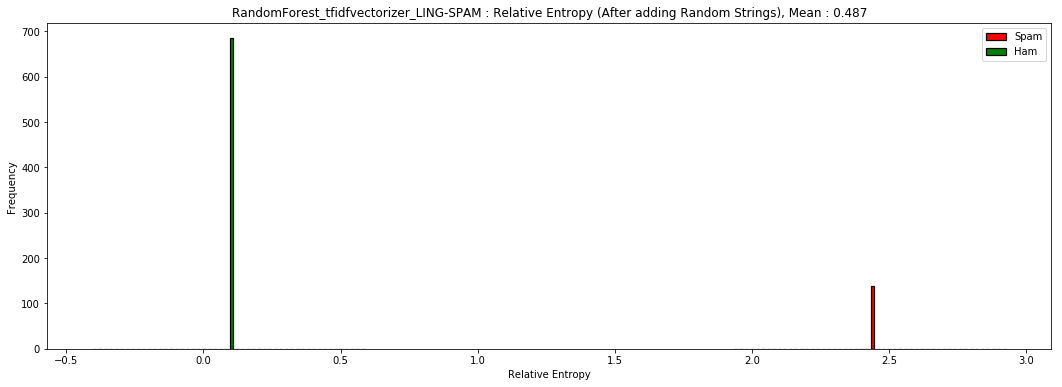

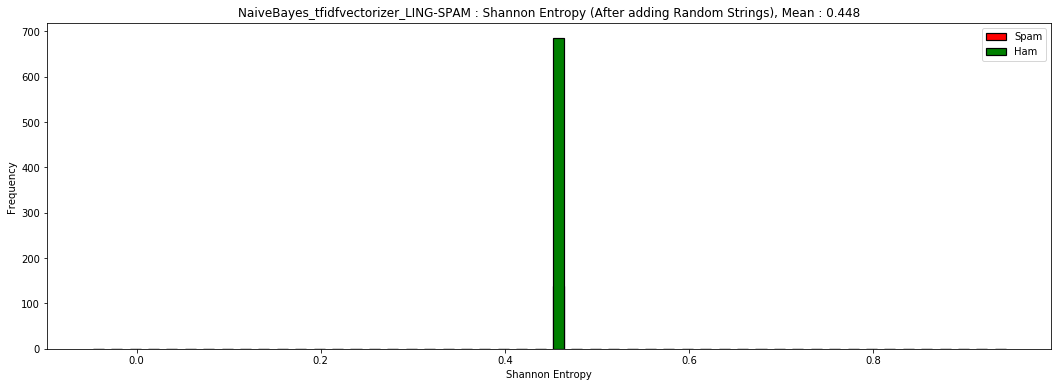

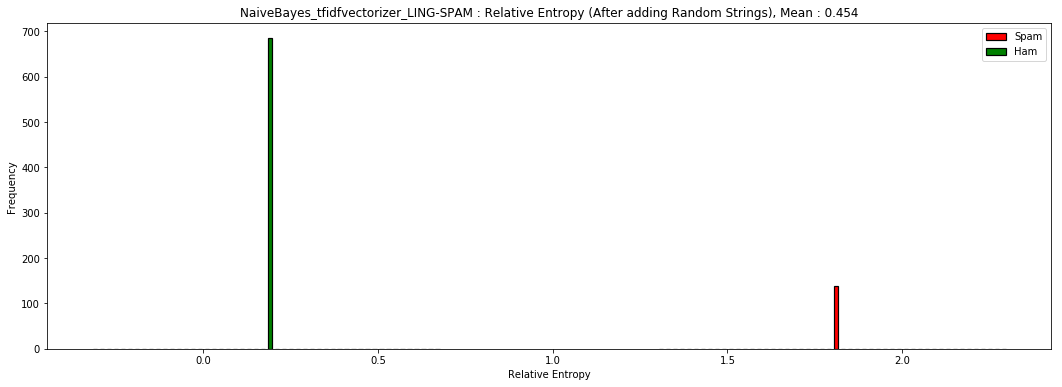

In [46]:
visualise_entropies(dataset, text_x_with_random_scrambled_strings, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Scrambled Words in Strings)

********************************************************************************
LogisticRegression_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  1.4251436861977718
ROC AUC :  0.9920390694743474
Accuracy :  0.9587378640776699
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       685
         1.0       1.00      0.76      0.86       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.98      0.88      0.92       824
weighted avg       0.96      0.96      0.96       824



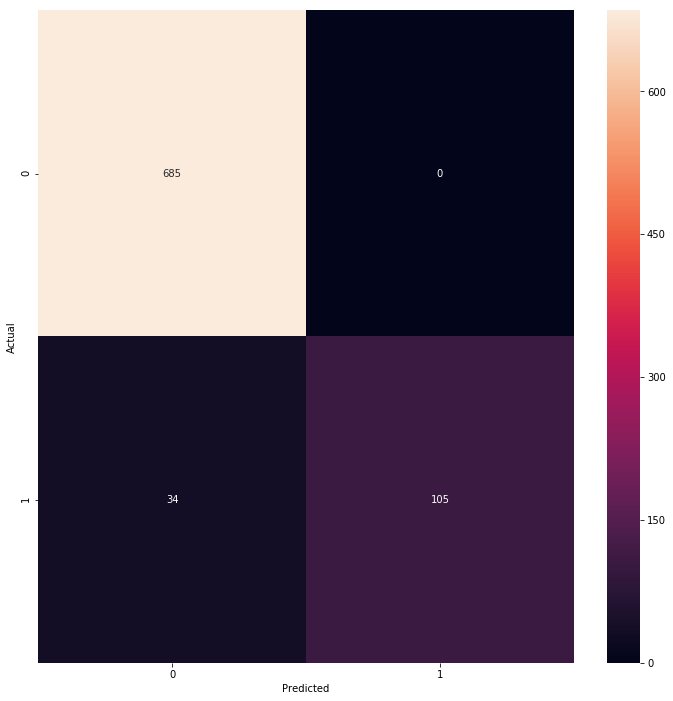

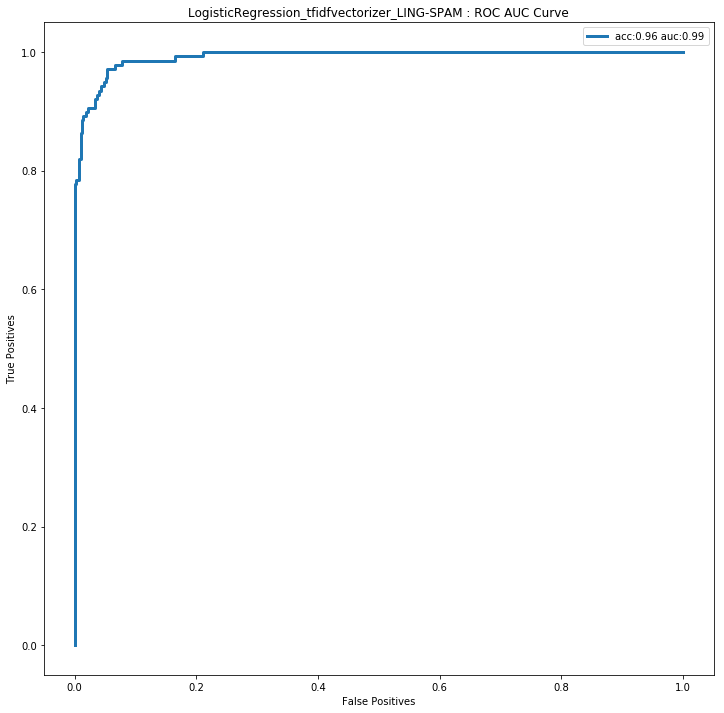

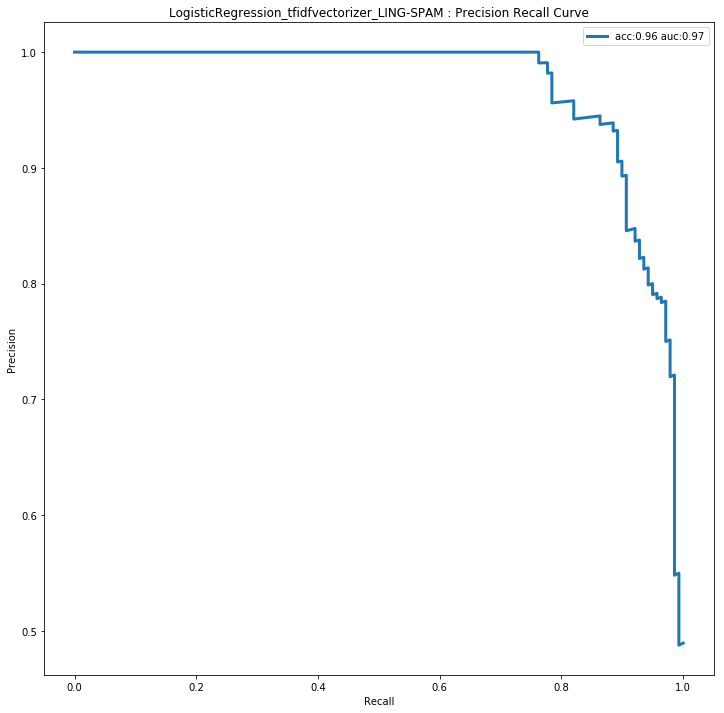

********************************************************************************
SVC_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  1.3832315769681724
ROC AUC :  0.9908207740377042
Accuracy :  0.9599514563106796
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       685
         1.0       0.96      0.79      0.87       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.96      0.89      0.92       824
weighted avg       0.96      0.96      0.96       824



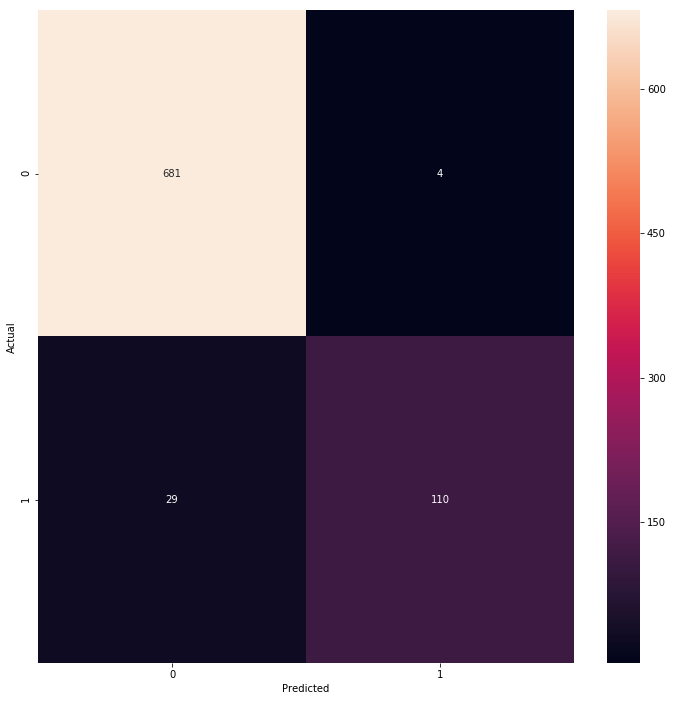

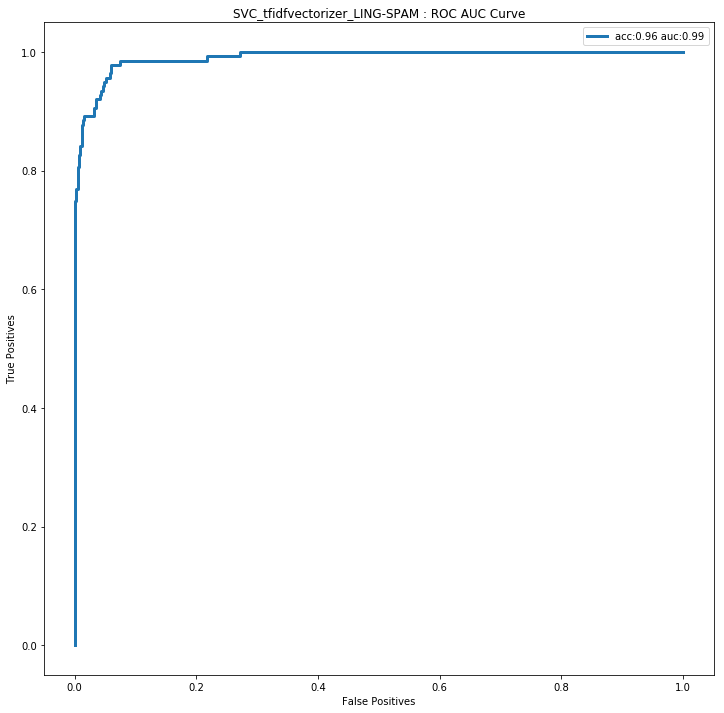

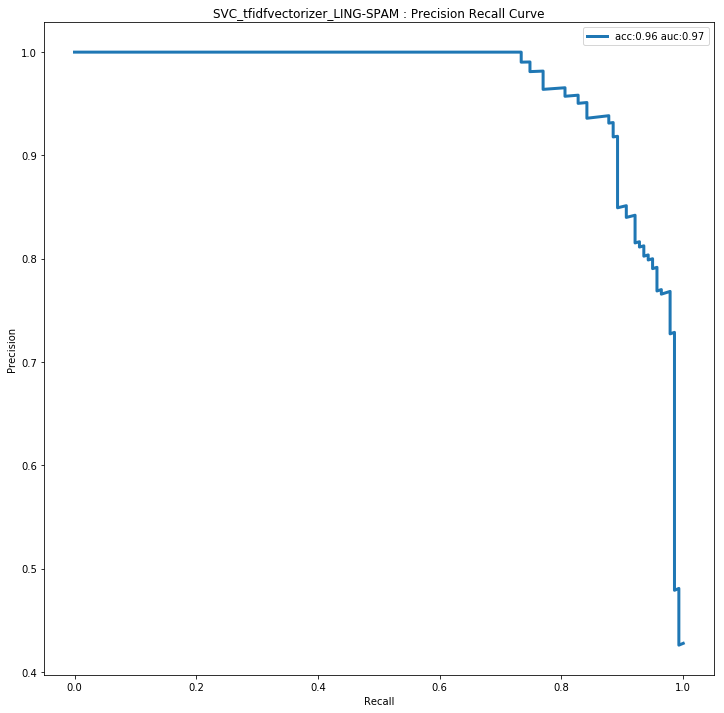

********************************************************************************
XGBoost_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  3.0179620097151725
ROC AUC :  0.9539673370792418
Accuracy :  0.912621359223301
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       685
         1.0       0.88      0.56      0.68       139

   micro avg       0.91      0.91      0.91       824
   macro avg       0.90      0.77      0.82       824
weighted avg       0.91      0.91      0.90       824



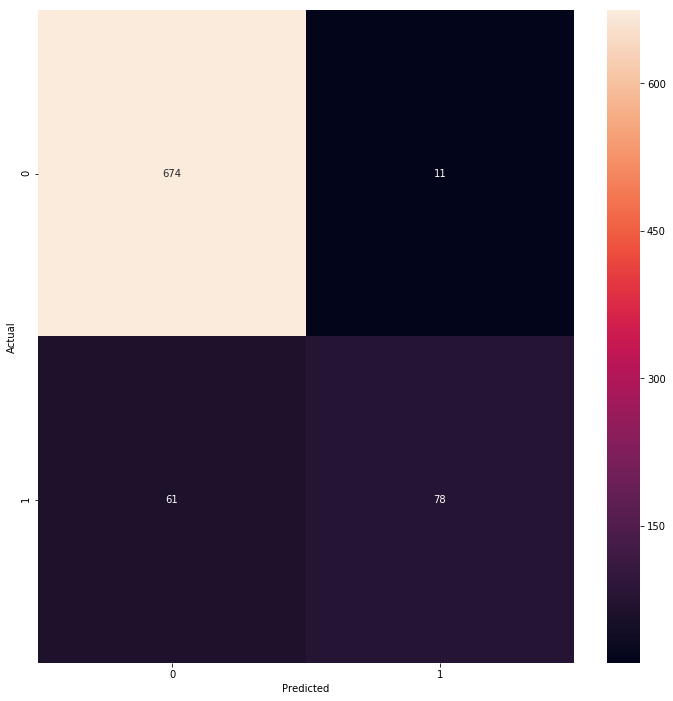

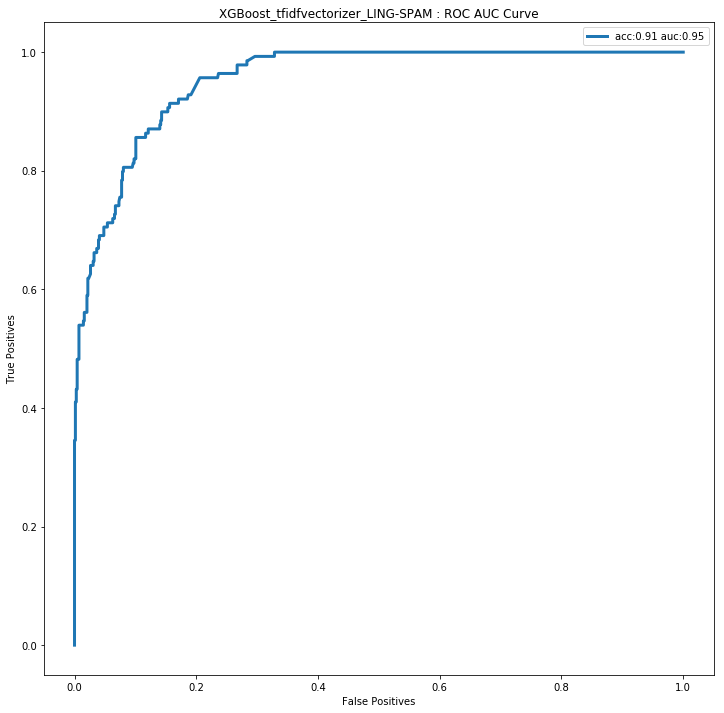

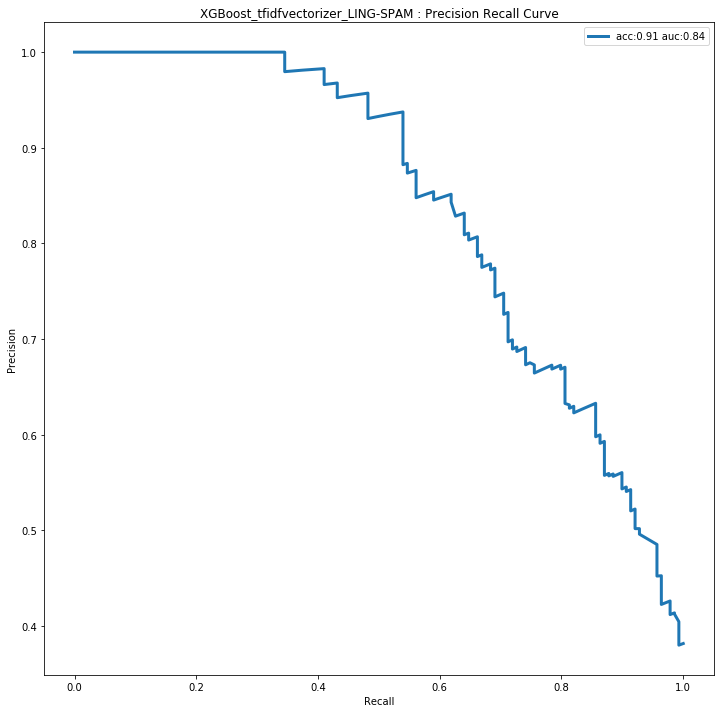

********************************************************************************
RandomForest_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  2.4730444258460693
ROC AUC :  0.9750406973691119
Accuracy :  0.9283980582524272
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       685
         1.0       0.99      0.58      0.73       139

   micro avg       0.93      0.93      0.93       824
   macro avg       0.95      0.79      0.85       824
weighted avg       0.93      0.93      0.92       824



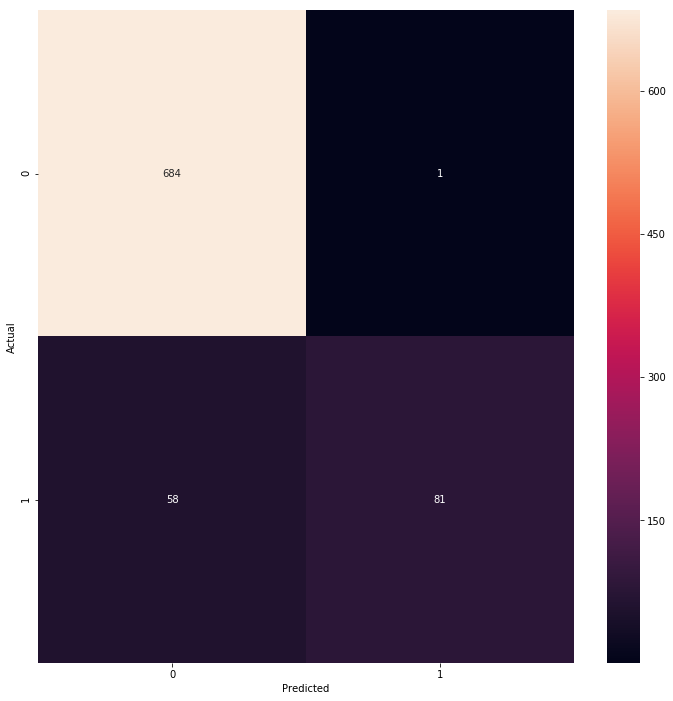

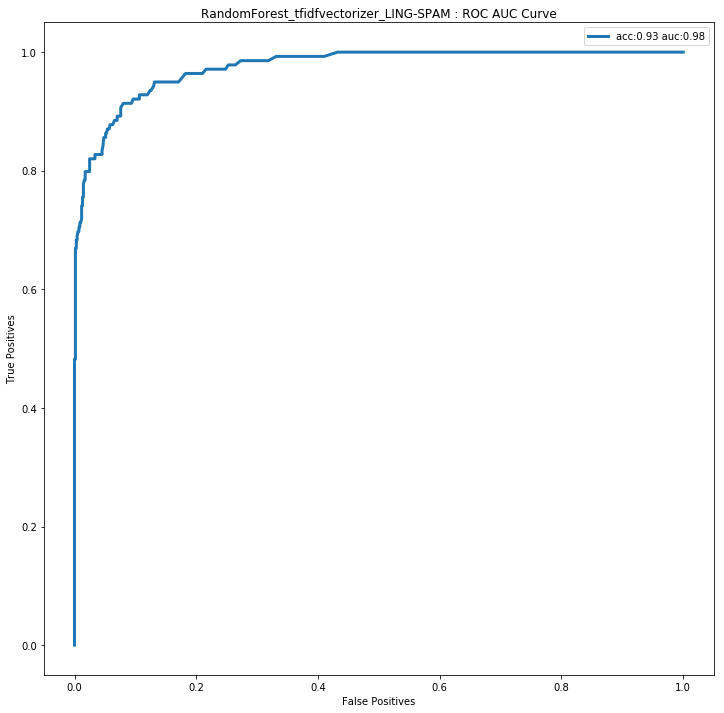

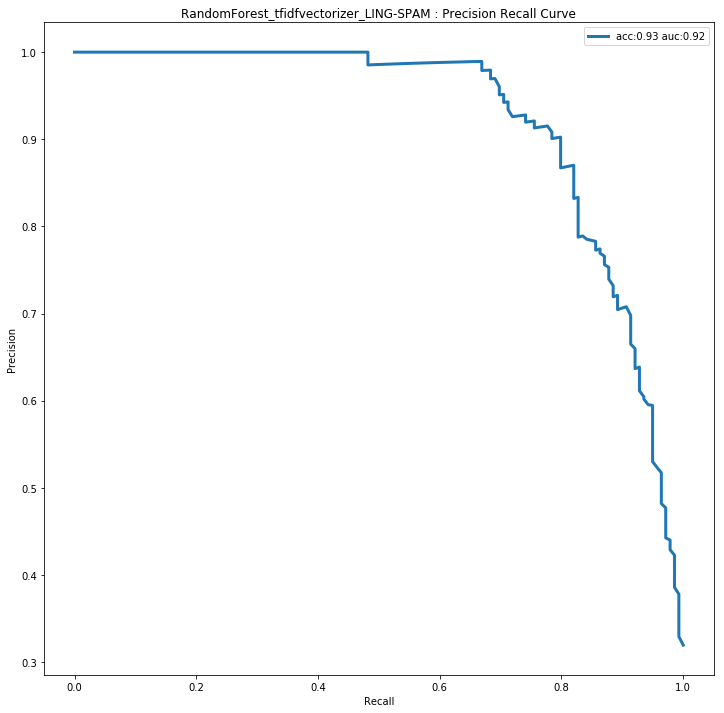

********************************************************************************
NaiveBayes_tfidfvectorizer_LING-SPAM
********************************************************************************
Log Loss :  1.1317336915745746
ROC AUC :  0.995578427768734
Accuracy :  0.9672330097087378
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       685
         1.0       0.98      0.82      0.89       139

   micro avg       0.97      0.97      0.97       824
   macro avg       0.97      0.91      0.94       824
weighted avg       0.97      0.97      0.97       824



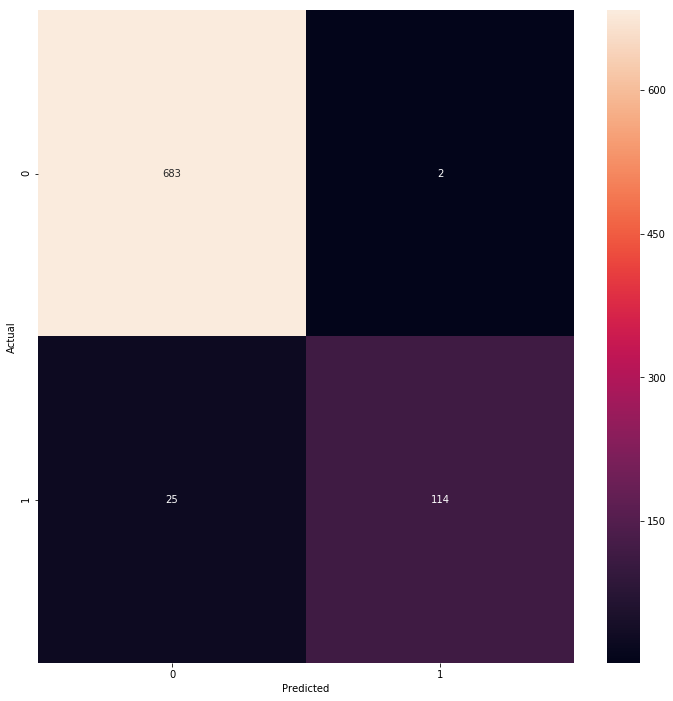

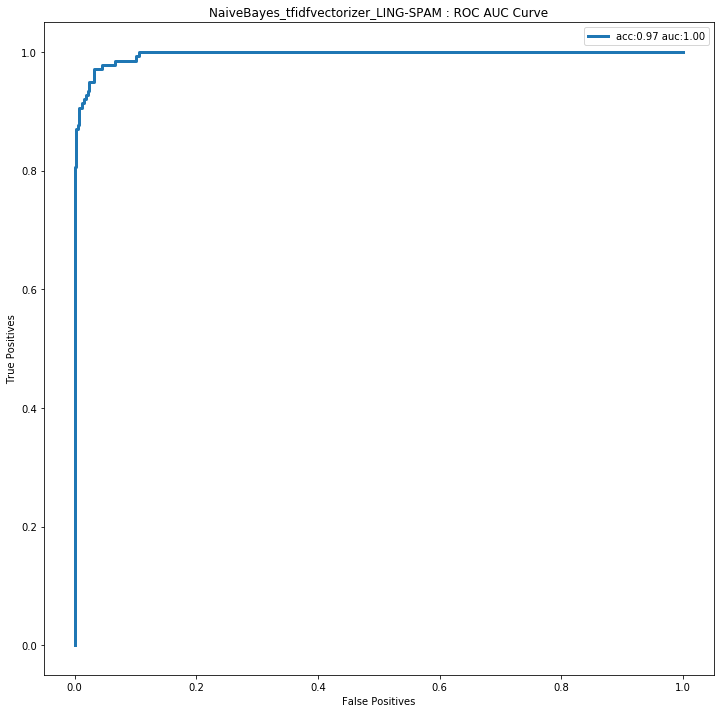

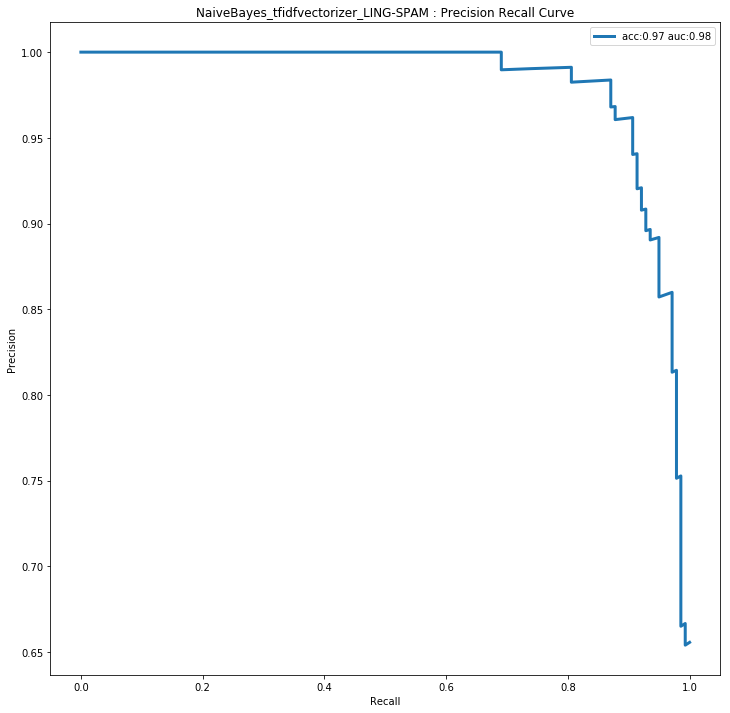

In [47]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings, y_test)

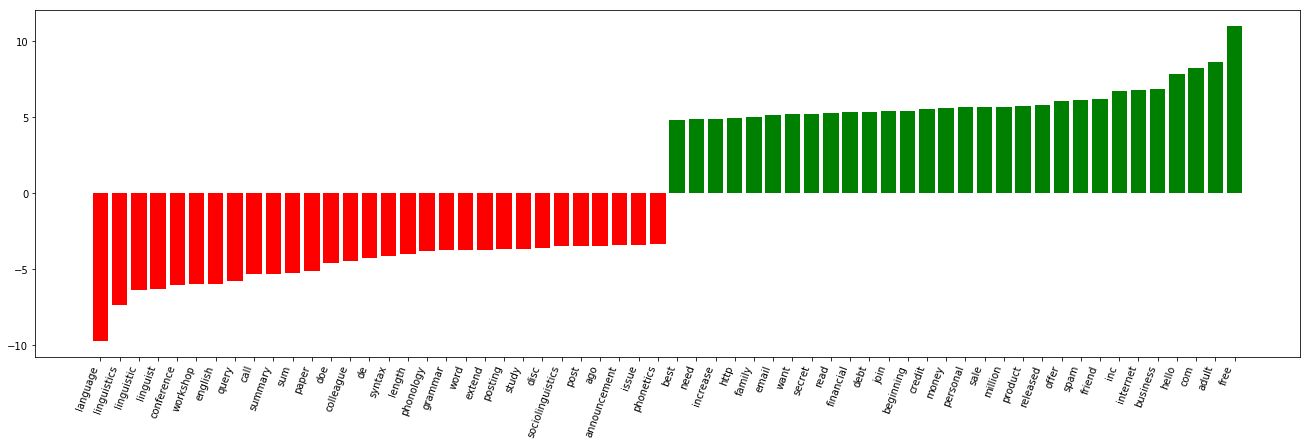

In [48]:
visualize_coefficients(grids['LogisticRegression_tfidfvectorizer_'+dataset].best_estimator_.steps[1][1], grids['LogisticRegression_tfidfvectorizer_'+dataset].best_estimator_.steps[0][1].get_feature_names())

## 3. Word Embeddings Approach

## Trying various models and keeping track of best performing params

In [49]:
%%time
grids = {}
entropies = {}

train_x_glove = np.array([text2vec(x,embedding_size) for x in train_x_cleaned])
test_x_glove = np.array([text2vec(x,embedding_size) for x in test_x_cleaned])

try_various_models_on_data(dataset, train_x_glove,y_train, test_x_glove, y_test, preprocessing='Embedding')
gc.enable(); gc.collect();

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score :  0.9681005316578057
Test Accuracy :  0.9635922330097088
Best Params :  {'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   28.4s finished


Best Score :  0.9690671822136298
Test Accuracy :  0.9648058252427184
Best Params :  {'svc__C': 1.0, 'svc__gamma': 1.0}

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.8min finished


Best Score :  0.9555340744320928
Test Accuracy :  0.9550970873786407
Best Params :  {'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 500}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   53.9s finished


Best Score :  0.9246012566457226
Test Accuracy :  0.9271844660194175
Best Params :  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 100}

CPU times: user 21.7 s, sys: 192 ms, total: 21.9 s
Wall time: 5min 35s


## Visualise Shannon and Relative entropies for various models

********************************************************************************
LogisticRegression_Embedding_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.12461335098069477
Mean Relative Entropy :  0.09510242861297476
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2     0.693     0.706     1.0     0.0       0.506       0.494
63    0.677     0.888     1.0     0.0       0.589       0.411
68    0.681     0.866     1.0     0.0       0.579       0.421
81    0.291     2.463     1.0     0.0       0.915       0.085
85    0.689     0.792     1.0     0.0       0.547       0.453
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
591    0.602     1.239     0.0     1.0       0.290       0.710
592    0.678     0.883     0.0     1.0       0.413       0.587
614    0.675     0.906     0.0     1.0       0.404       0.596
709    0.672     0.923     0.0     1.0       0.397       0.603
790

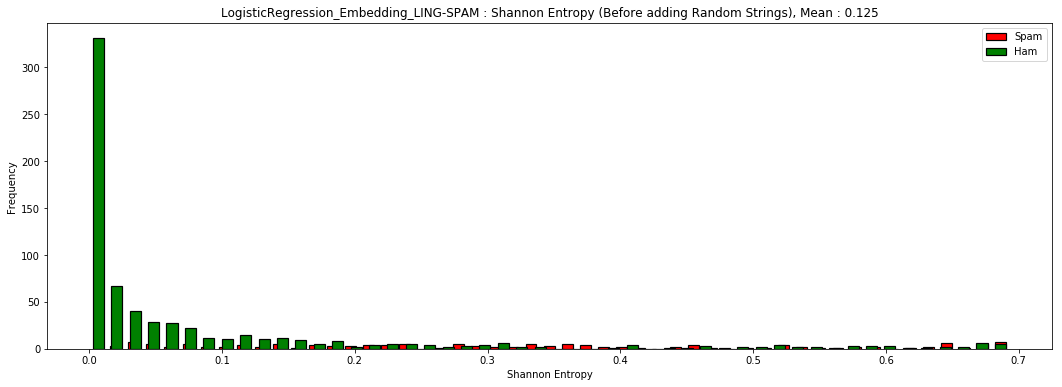

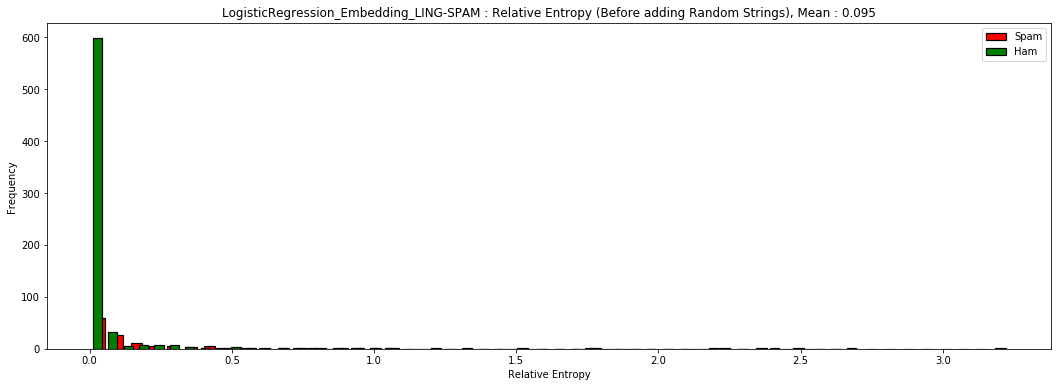

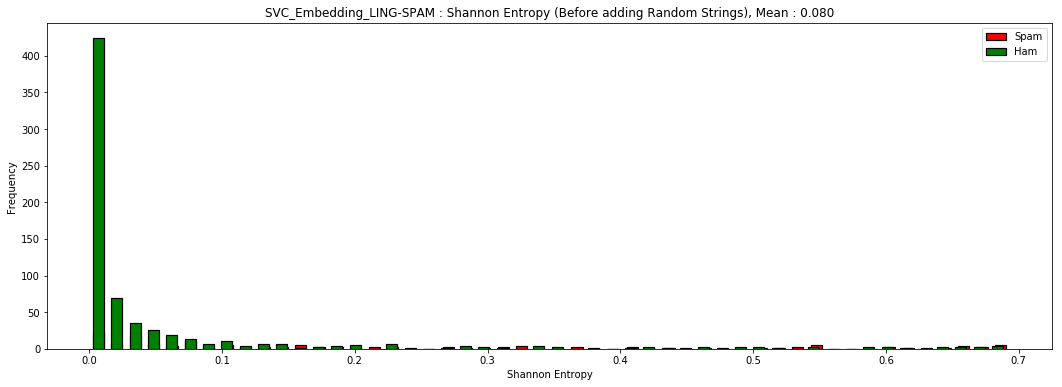

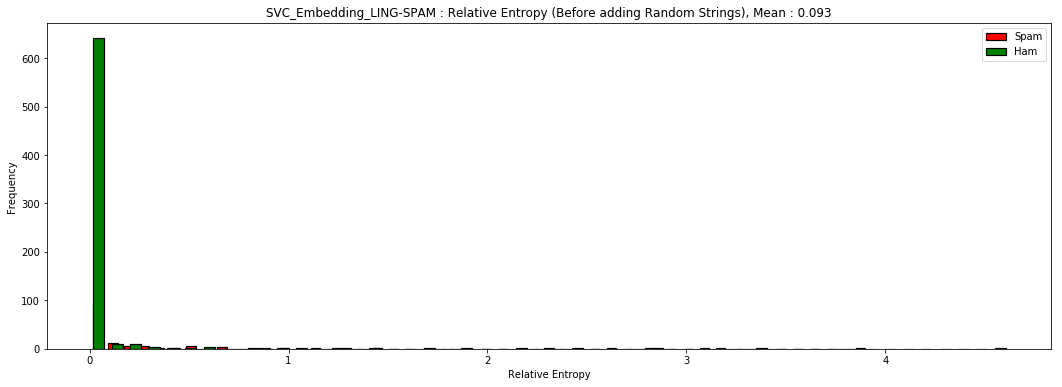

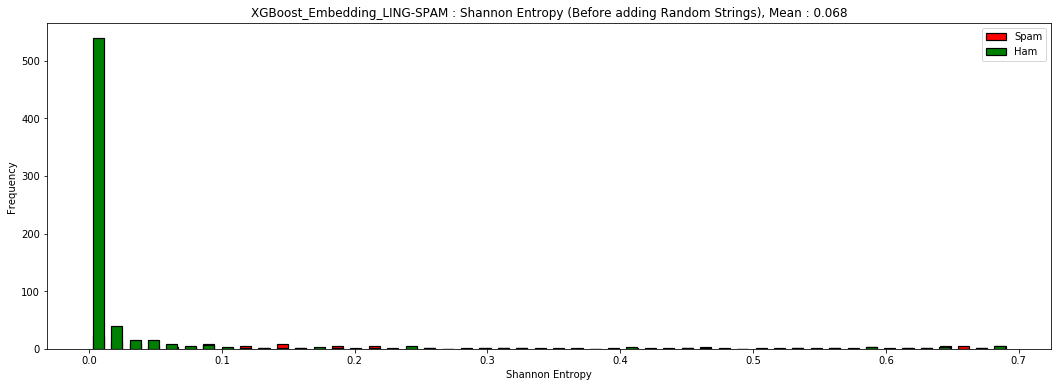

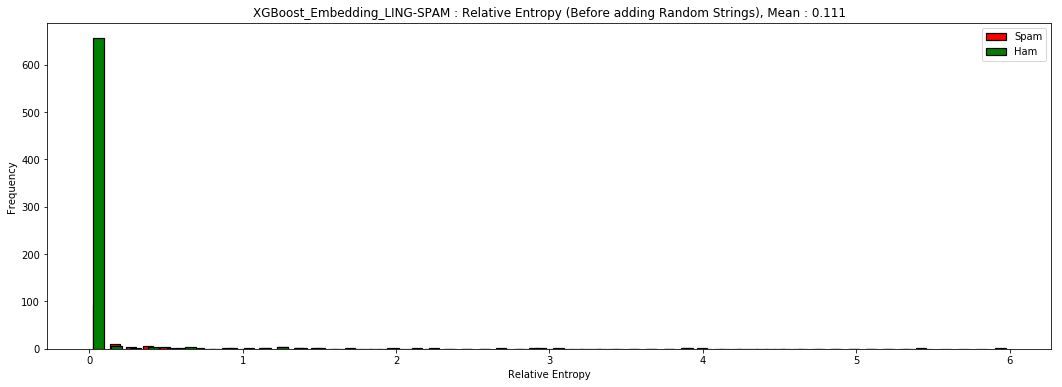

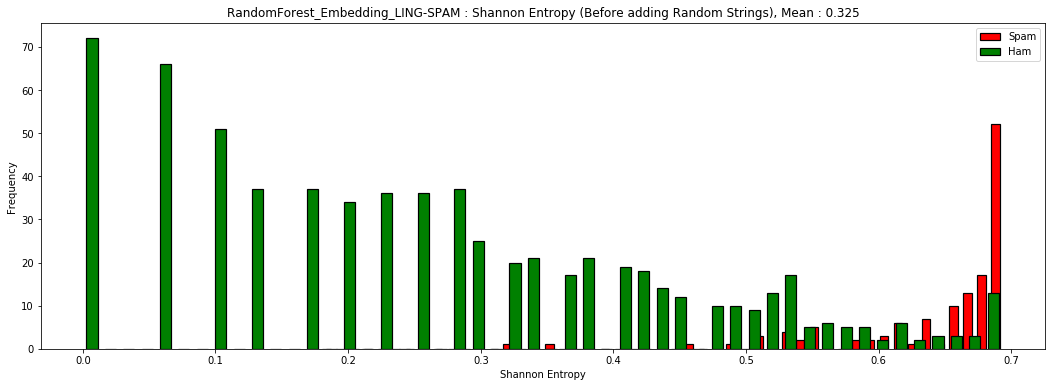

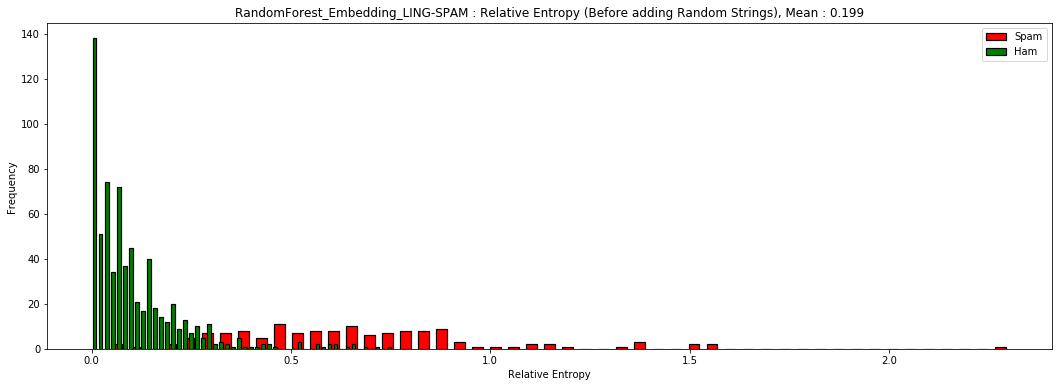

In [50]:
visualise_entropies(dataset, test_x_glove, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
LogisticRegression_Embedding_LING-SPAM
********************************************************************************
Log Loss :  1.2574923381236818
ROC AUC :  0.9909678096938507
Accuracy :  0.9635922330097088
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       685
         1.0       0.90      0.88      0.89       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.94      0.93      0.93       824
weighted avg       0.96      0.96      0.96       824



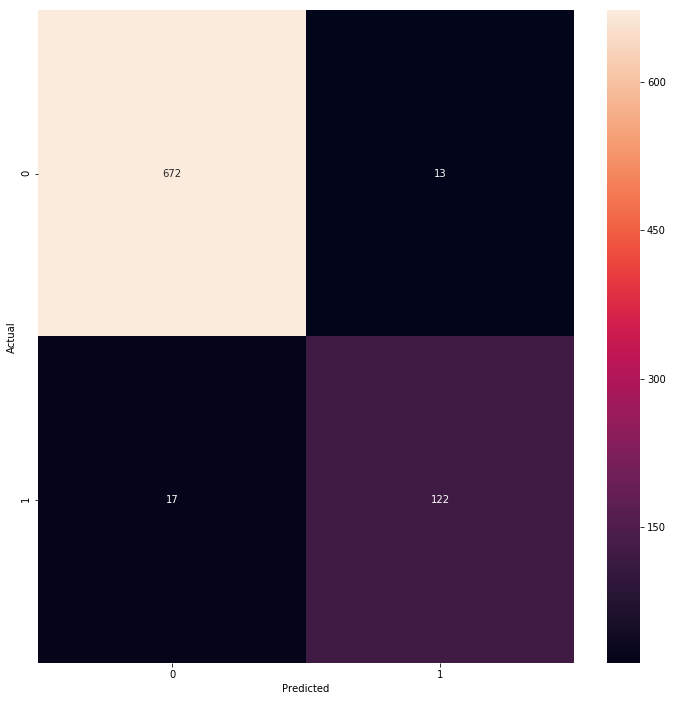

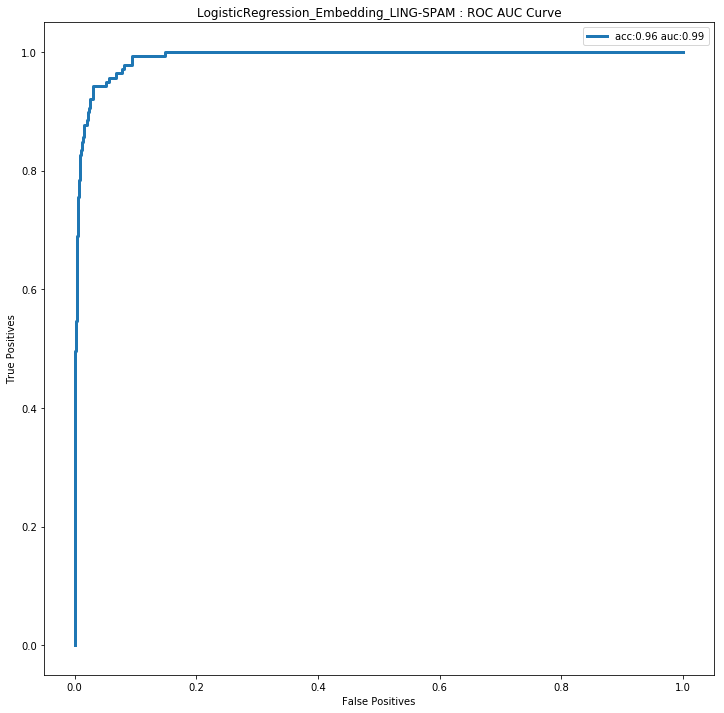

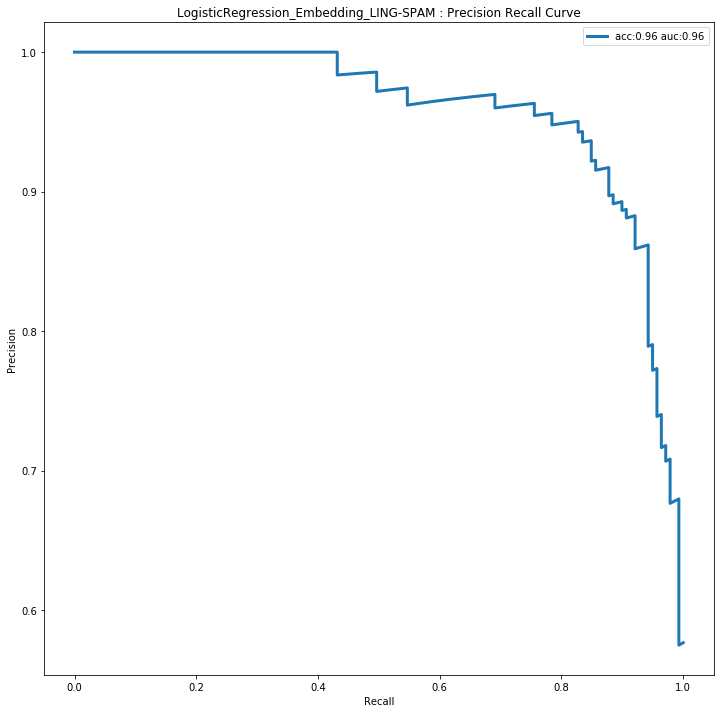

********************************************************************************
SVC_Embedding_LING-SPAM
********************************************************************************
Log Loss :  1.2155763473531591
ROC AUC :  0.9908942918657775
Accuracy :  0.9648058252427184
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       685
         1.0       0.90      0.88      0.89       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.94      0.93      0.94       824
weighted avg       0.96      0.96      0.96       824



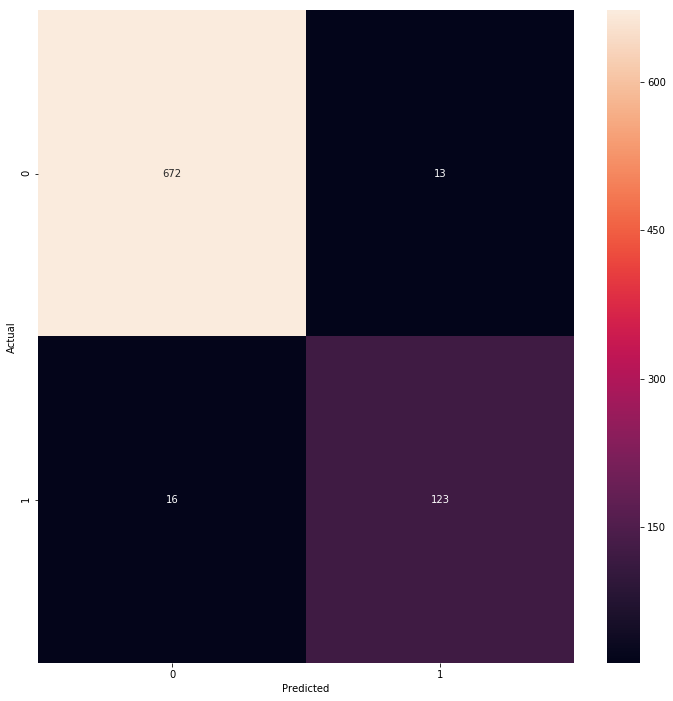

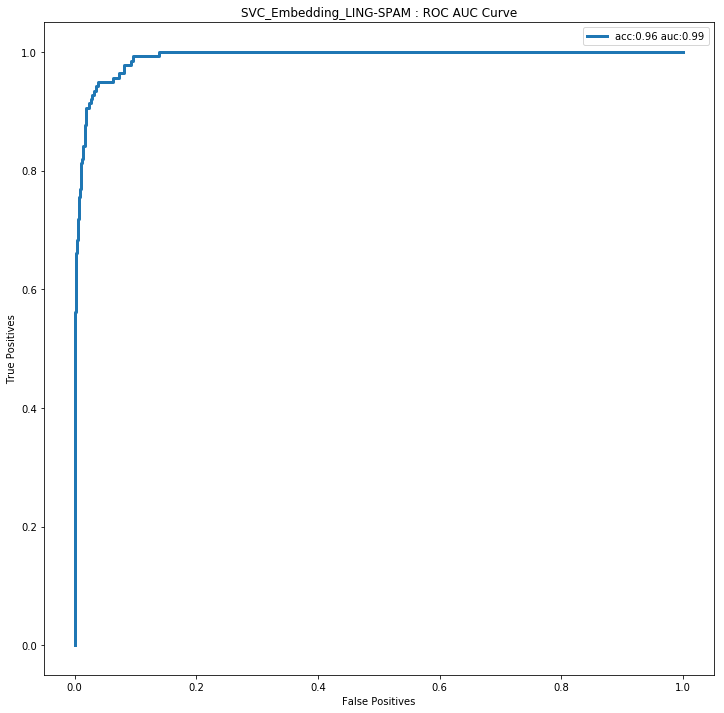

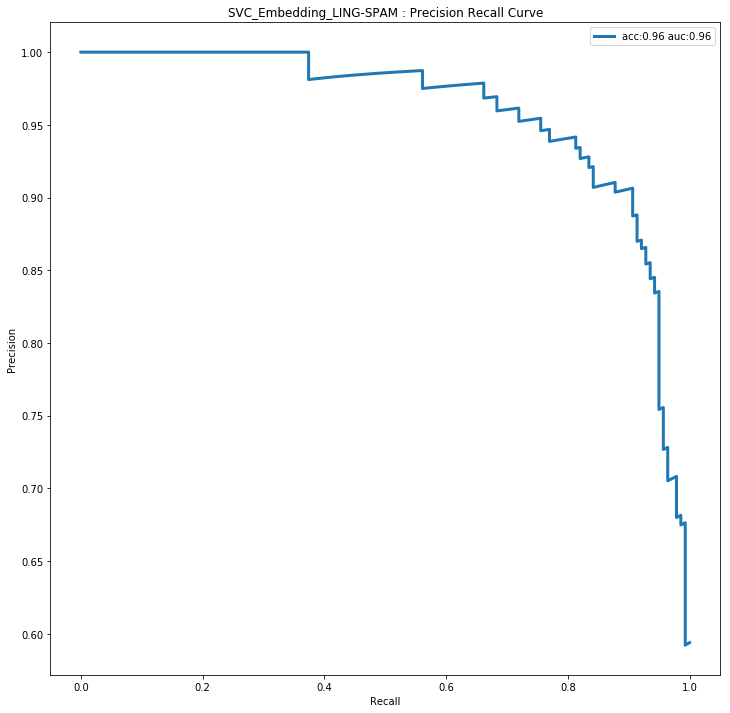

********************************************************************************
XGBoost_Embedding_LING-SPAM
********************************************************************************
Log Loss :  1.550906214287802
ROC AUC :  0.9888673003203277
Accuracy :  0.9550970873786407
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       685
         1.0       0.89      0.84      0.86       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.93      0.91      0.92       824
weighted avg       0.95      0.96      0.95       824



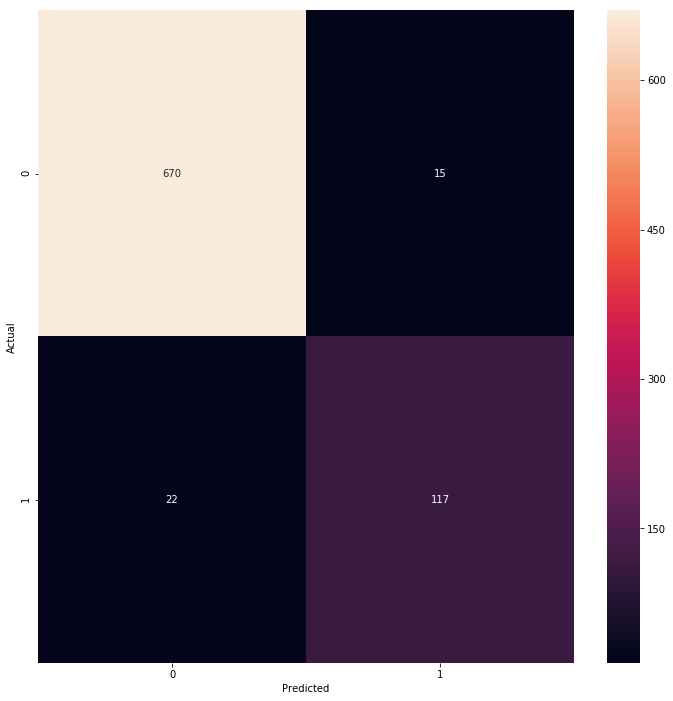

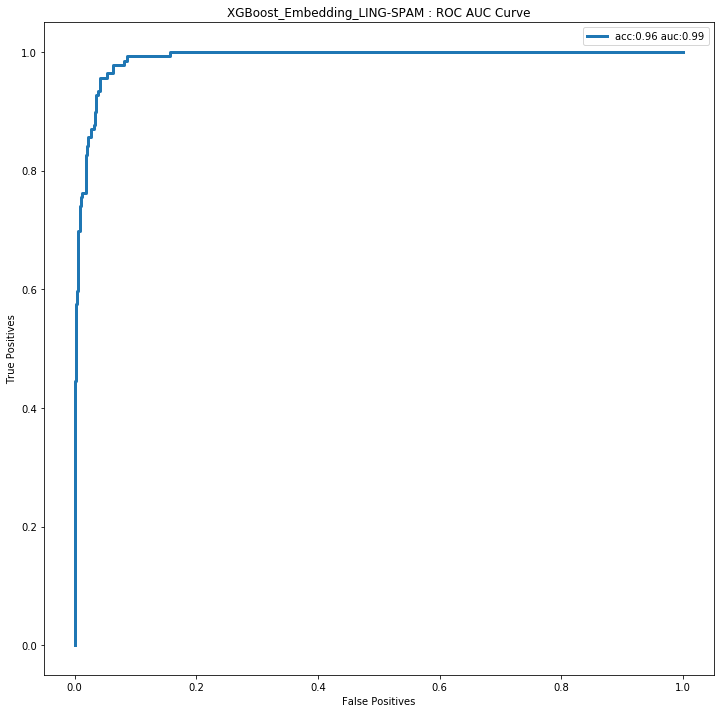

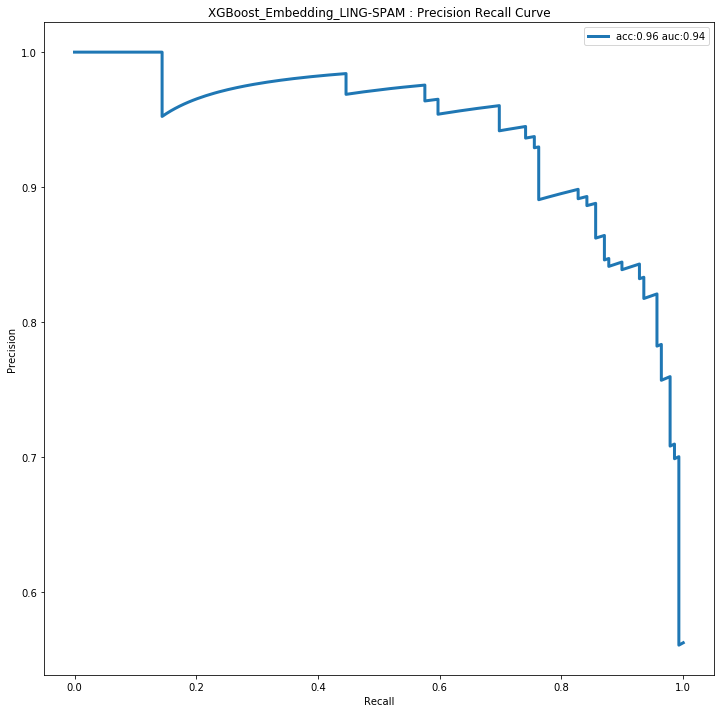

********************************************************************************
RandomForest_Embedding_LING-SPAM
********************************************************************************
Log Loss :  2.5149613870018226
ROC AUC :  0.9866722680249961
Accuracy :  0.9271844660194175
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       685
         1.0       0.98      0.58      0.73       139

   micro avg       0.93      0.93      0.93       824
   macro avg       0.95      0.79      0.84       824
weighted avg       0.93      0.93      0.92       824



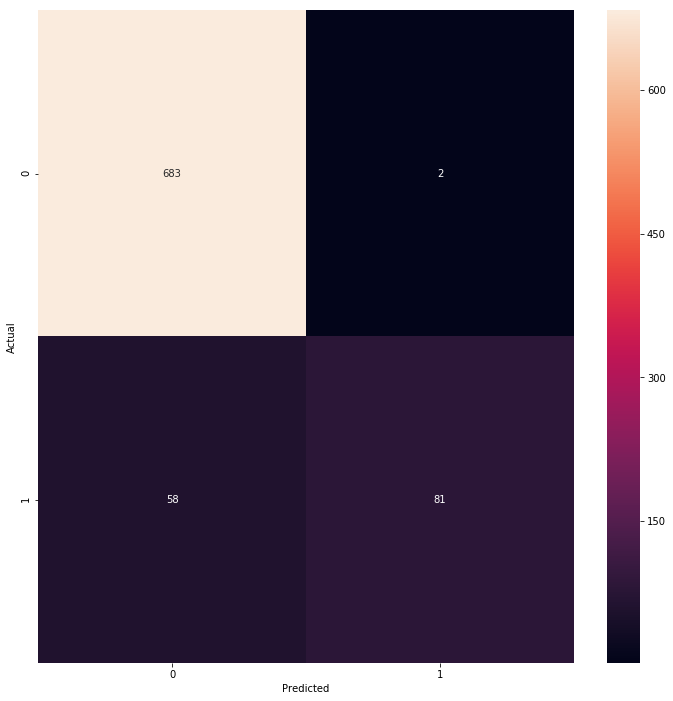

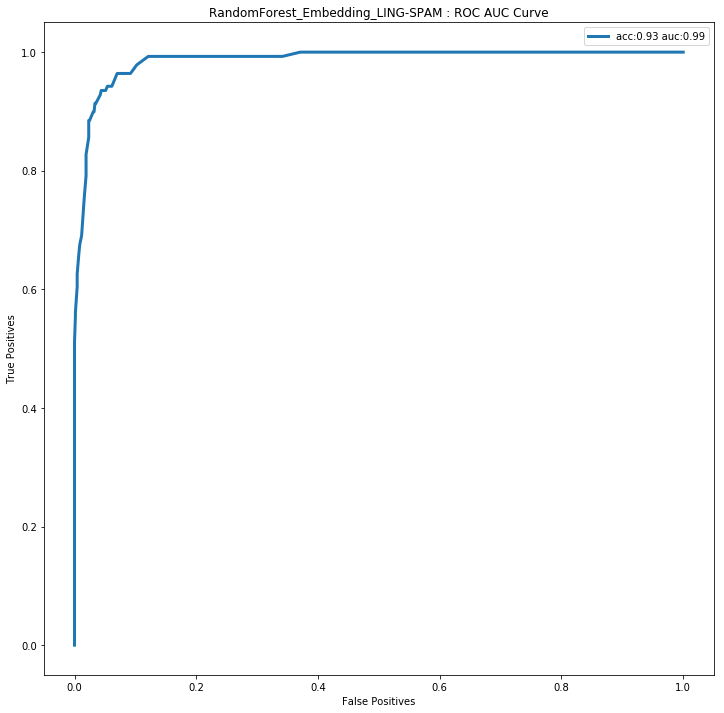

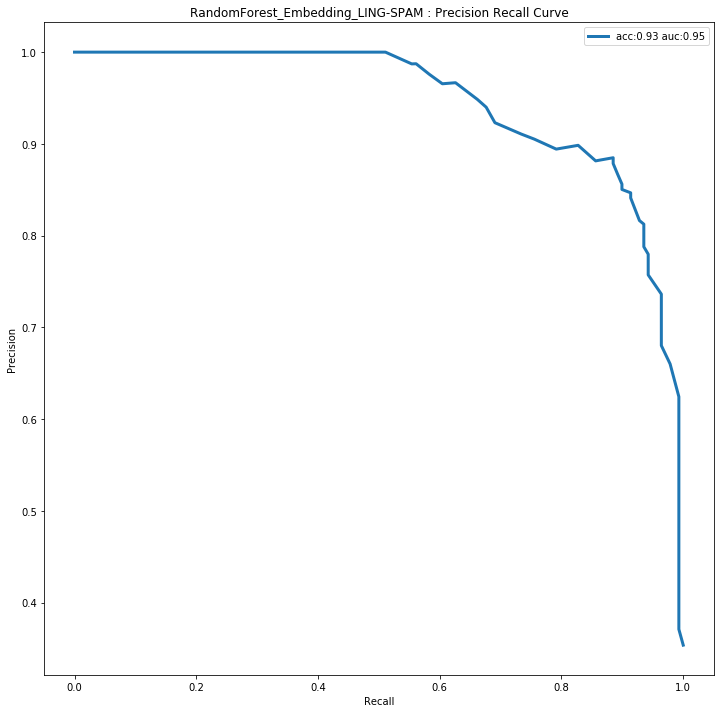

In [51]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_glove, y_test)

## Adding Meaningful Strings to Test Data

In [52]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
test_x_with_random_strings_glove = np.array([text2vec(x,embedding_size) for x in test_x_cleaned])

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.12461335098069477
Mean Relative Entropy :  0.09510242861297476
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2     0.693     0.706     1.0     0.0       0.506       0.494
63    0.677     0.888     1.0     0.0       0.589       0.411
68    0.681     0.866     1.0     0.0       0.579       0.421
81    0.291     2.463     1.0     0.0       0.915       0.085
85    0.689     0.792     1.0     0.0       0.547       0.453
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
591    0.602     1.239     0.0     1.0       0.290       0.710
592    0.678     0.883     0.0     1.0       0.413       0.587
614    0.675     0.906     0.0     1.0       0.404       0.596
709    0.672     0.923     0.0     1.0       0.397       0.603
790

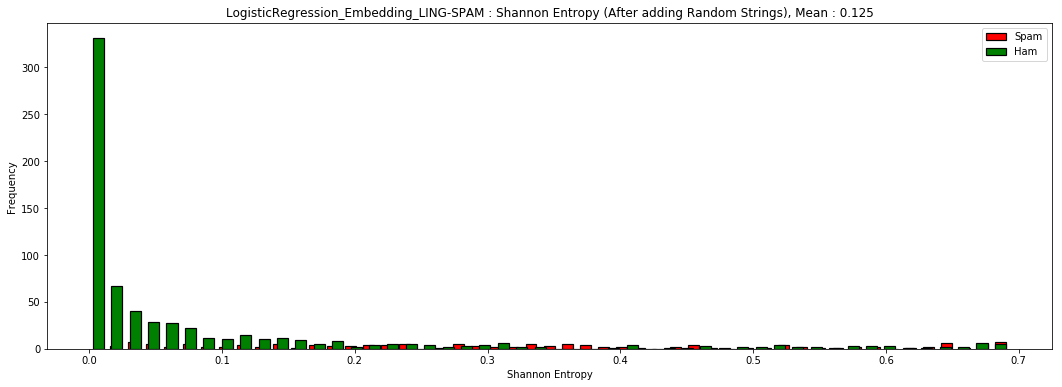

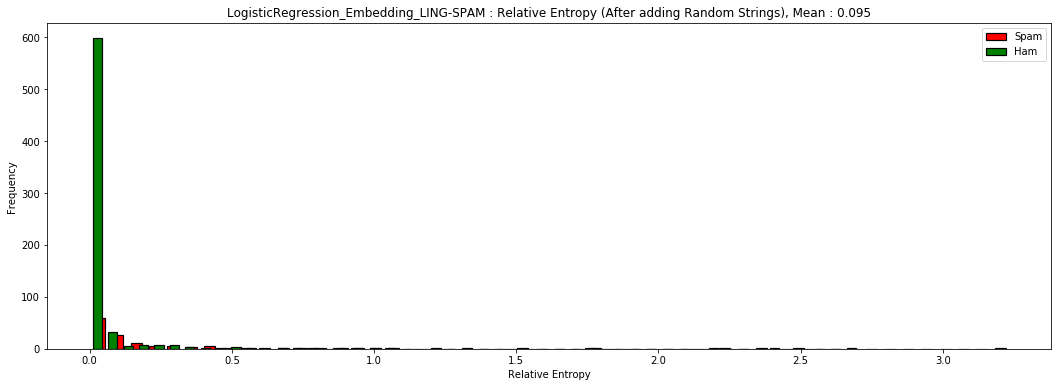

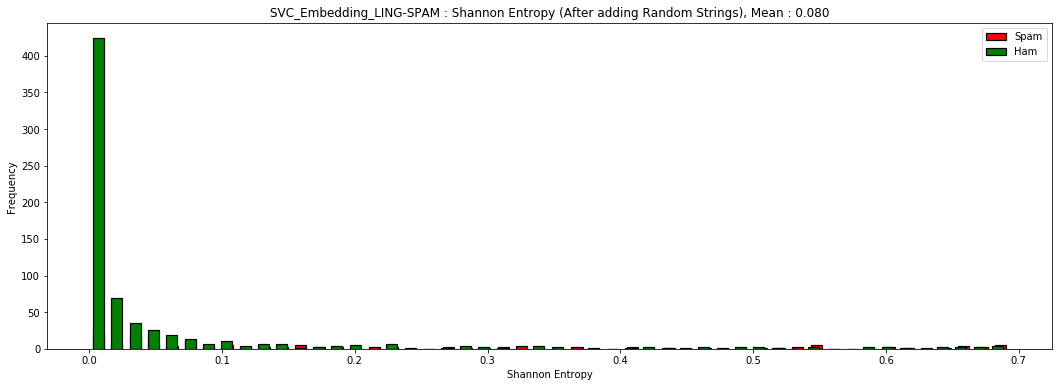

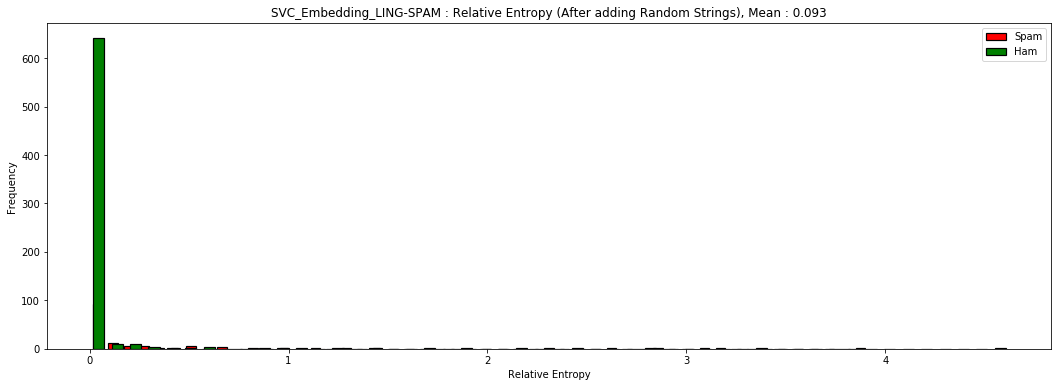

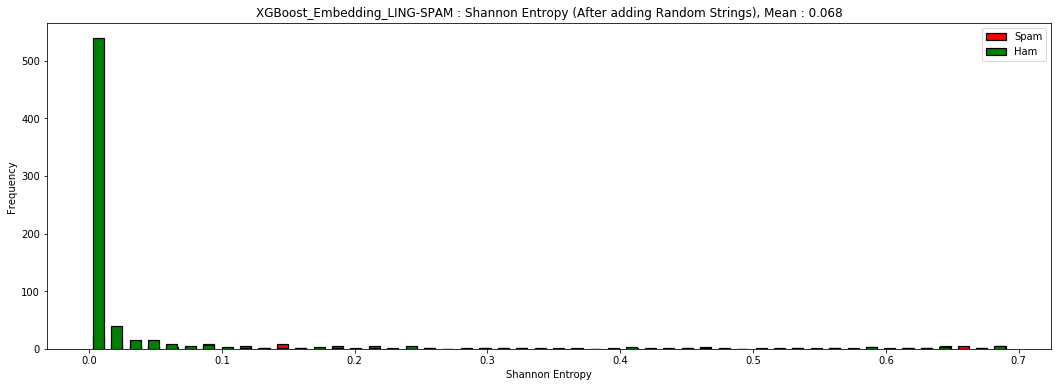

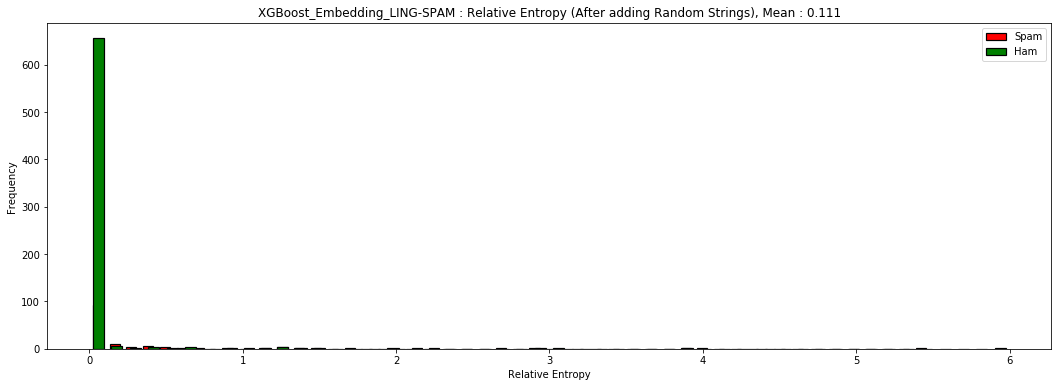

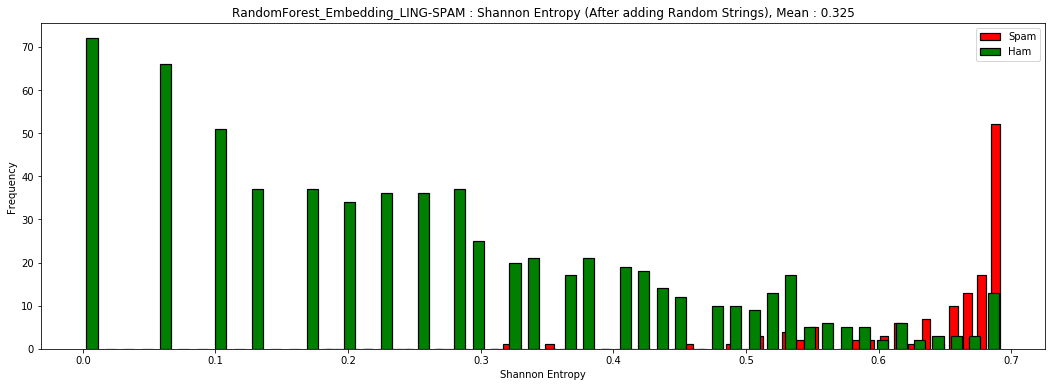

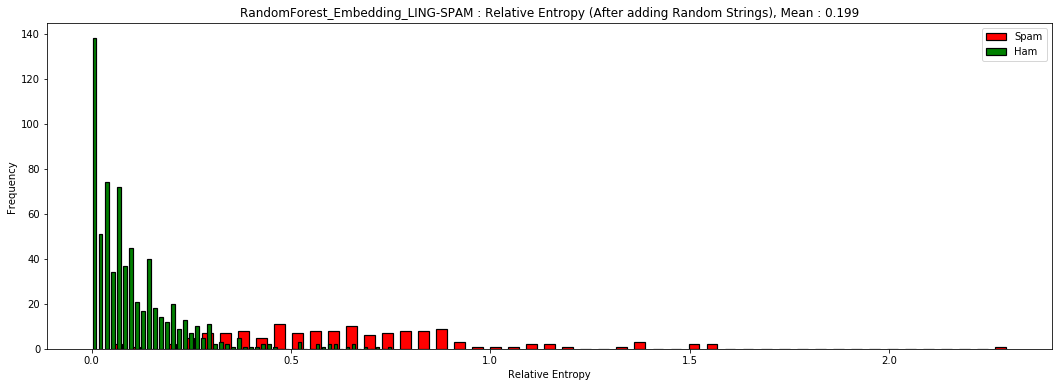

In [53]:
visualise_entropies(dataset, test_x_with_random_strings_glove, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_LING-SPAM
********************************************************************************
Log Loss :  1.2574923381236818
ROC AUC :  0.9909678096938507
Accuracy :  0.9635922330097088
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       685
         1.0       0.90      0.88      0.89       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.94      0.93      0.93       824
weighted avg       0.96      0.96      0.96       824



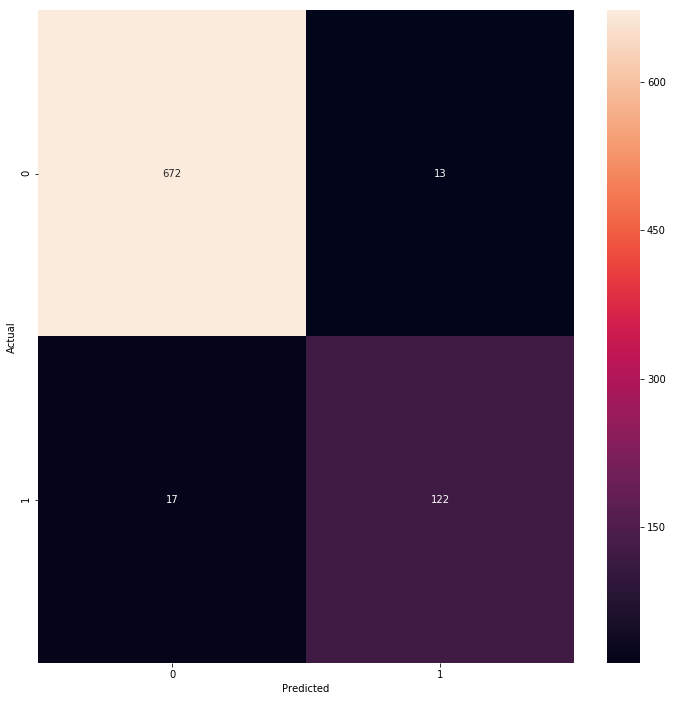

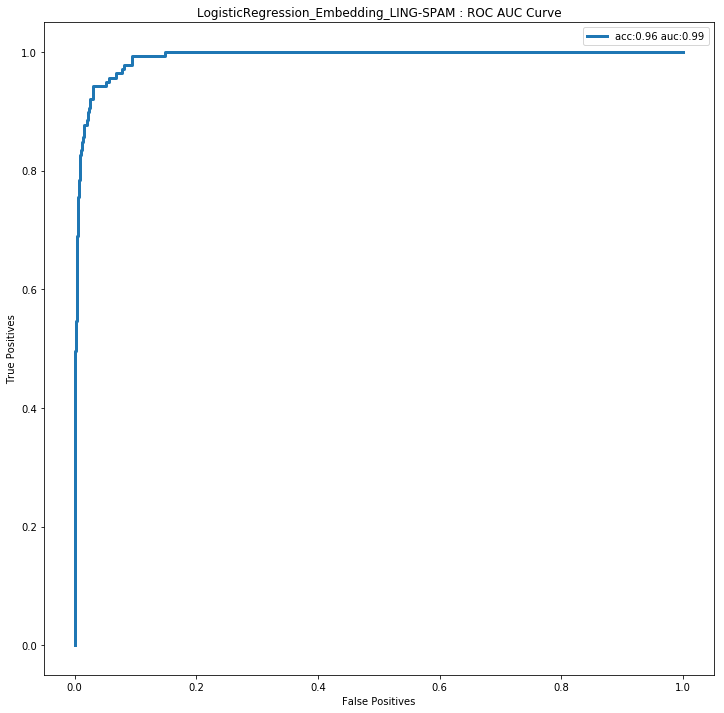

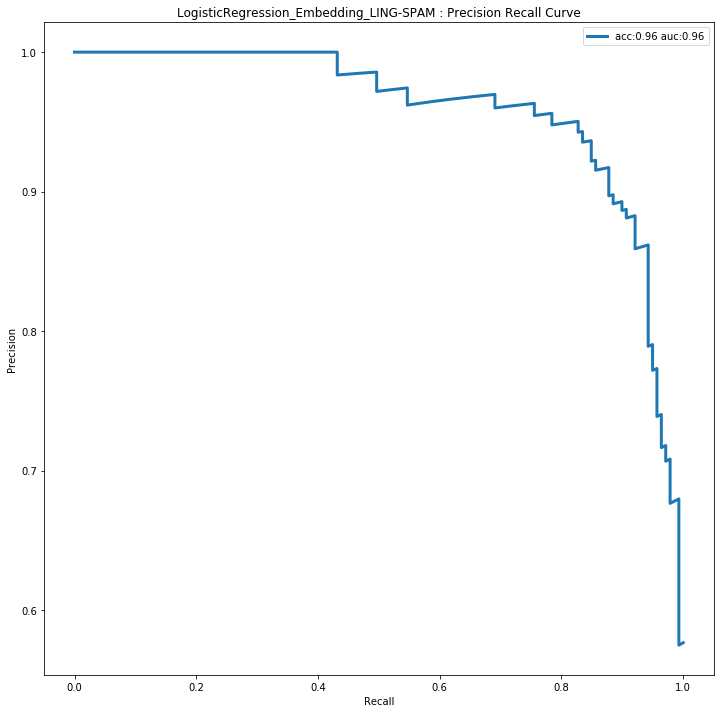

********************************************************************************
SVC_Embedding_LING-SPAM
********************************************************************************
Log Loss :  1.2155763473531591
ROC AUC :  0.9908942918657775
Accuracy :  0.9648058252427184
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       685
         1.0       0.90      0.88      0.89       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.94      0.93      0.94       824
weighted avg       0.96      0.96      0.96       824



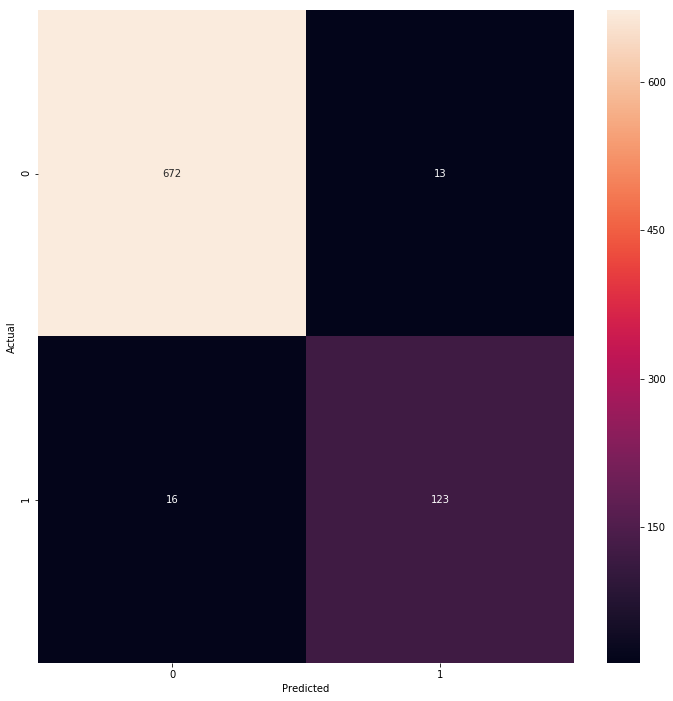

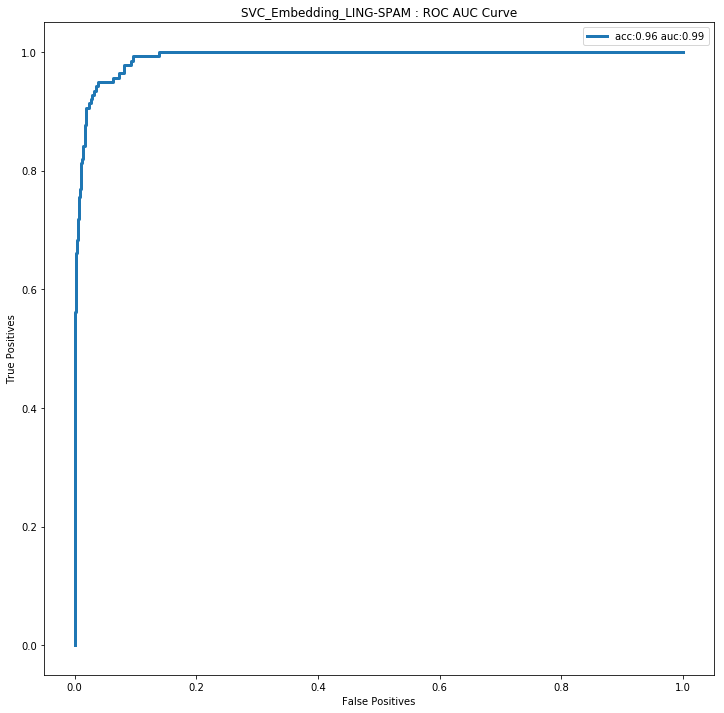

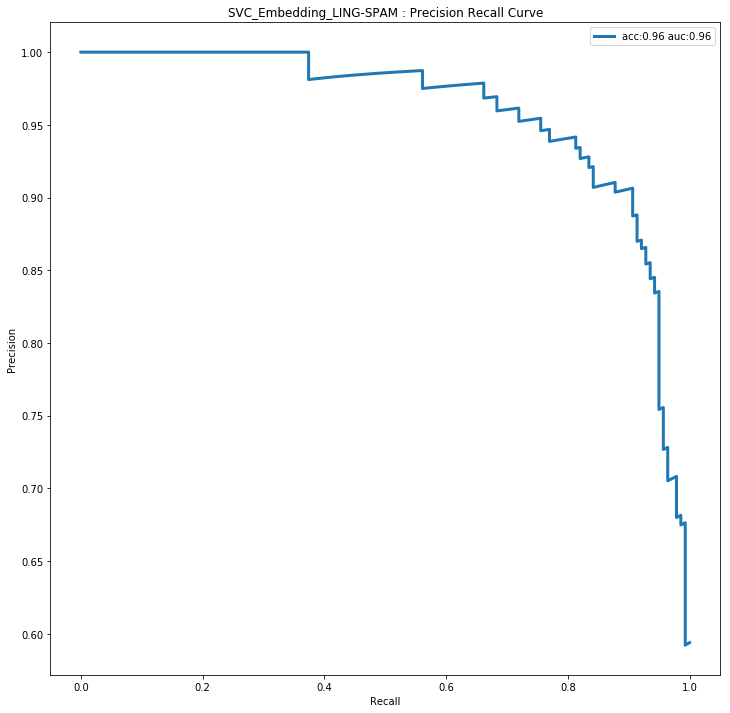

********************************************************************************
XGBoost_Embedding_LING-SPAM
********************************************************************************
Log Loss :  1.550906214287802
ROC AUC :  0.9888673003203277
Accuracy :  0.9550970873786407
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       685
         1.0       0.89      0.84      0.86       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.93      0.91      0.92       824
weighted avg       0.95      0.96      0.95       824



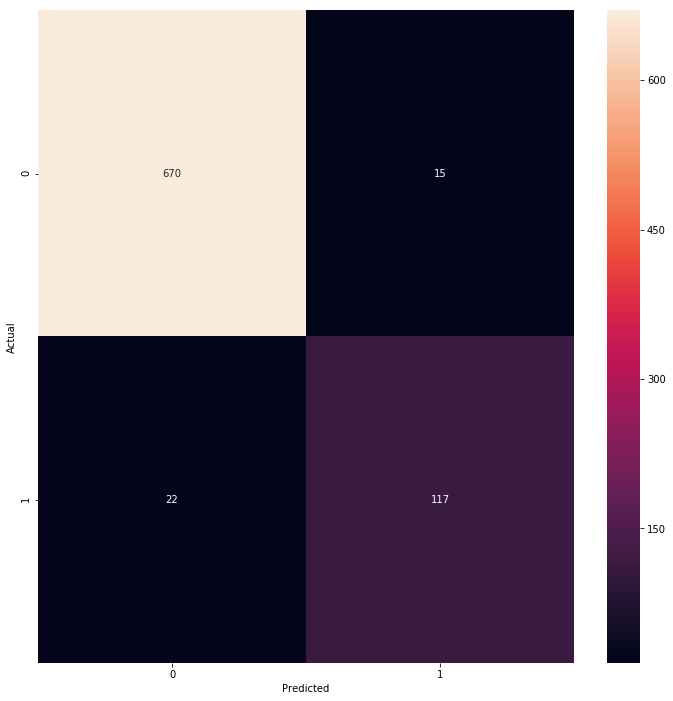

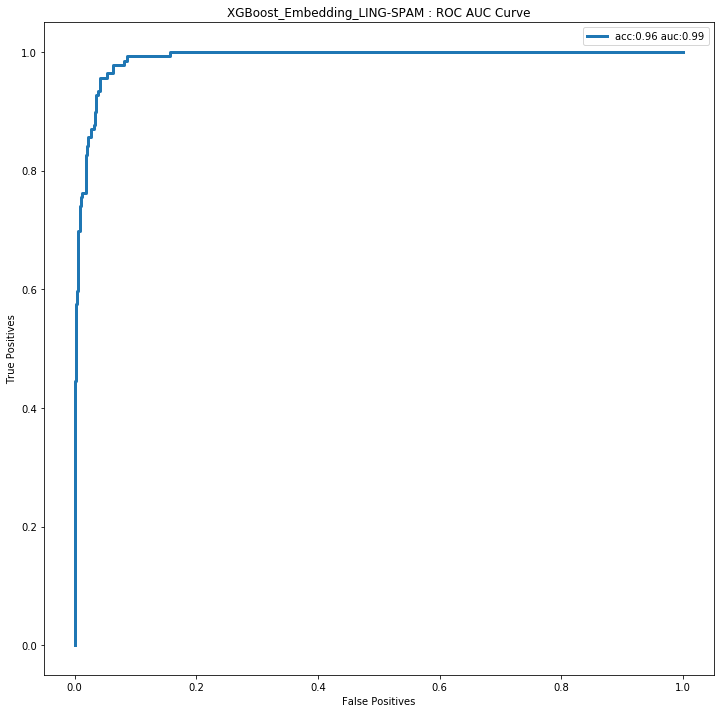

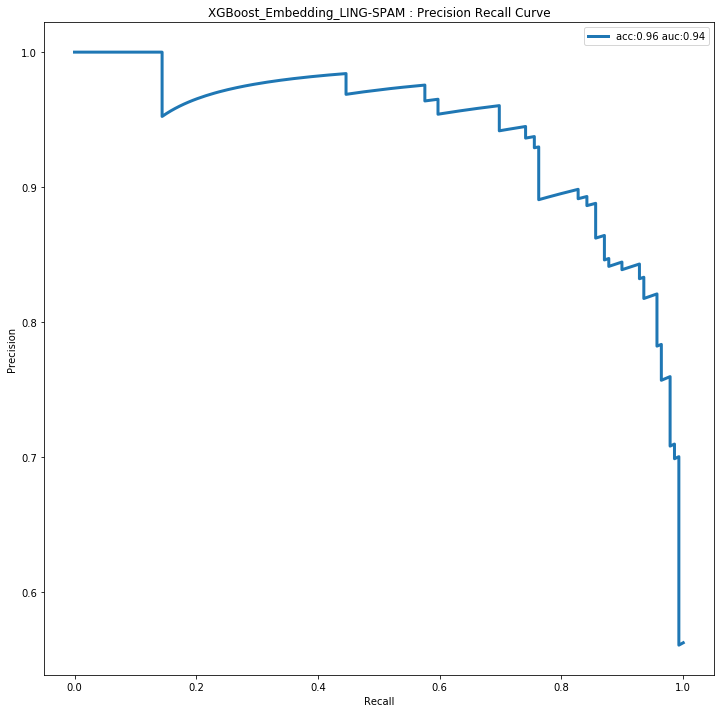

********************************************************************************
RandomForest_Embedding_LING-SPAM
********************************************************************************
Log Loss :  2.5149613870018226
ROC AUC :  0.9866722680249961
Accuracy :  0.9271844660194175
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       685
         1.0       0.98      0.58      0.73       139

   micro avg       0.93      0.93      0.93       824
   macro avg       0.95      0.79      0.84       824
weighted avg       0.93      0.93      0.92       824



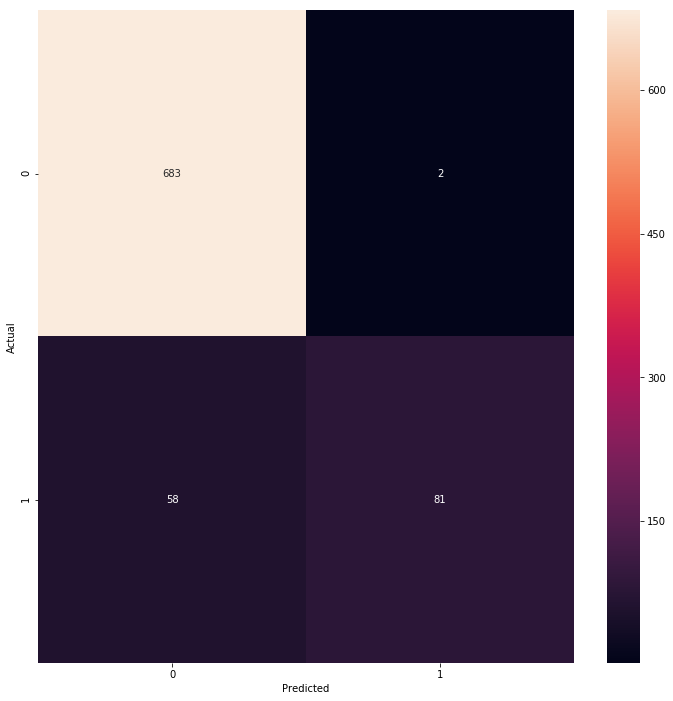

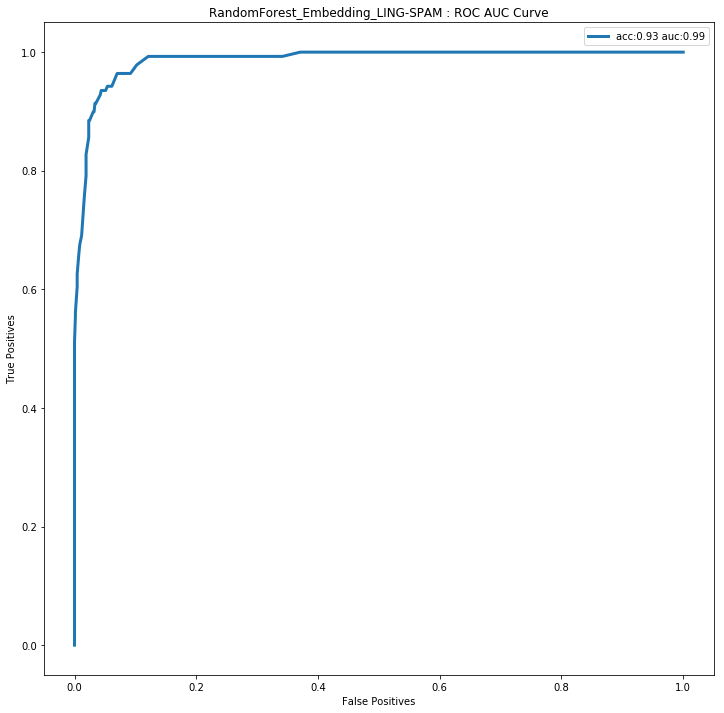

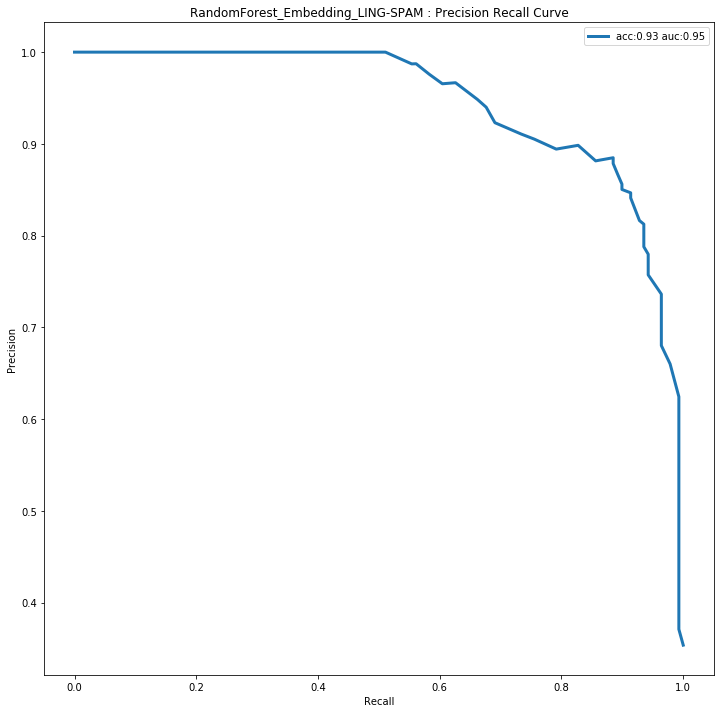

In [54]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_glove, y_test)

## Adding Meaningful scrambled words Strings to Test Data

In [55]:
## adding meaningful random words that are scrambled now to the test dataset to further confuse the filter
test_x_with_random_scrambled_strings = add_meaningful_scrambled_strings (test_x_cleaned, string_size)
test_x_with_random_scrambled_strings_glove = np.array([text2vec(x,embedding_size) for x in test_x_cleaned])

## Visualise Shannon and Relative entropies for various models (After Adding Scrambled Words Strings)

********************************************************************************
LogisticRegression_Embedding_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.12461335098069477
Mean Relative Entropy :  0.09510242861297476
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2     0.693     0.706     1.0     0.0       0.506       0.494
63    0.677     0.888     1.0     0.0       0.589       0.411
68    0.681     0.866     1.0     0.0       0.579       0.421
81    0.291     2.463     1.0     0.0       0.915       0.085
85    0.689     0.792     1.0     0.0       0.547       0.453
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
591    0.602     1.239     0.0     1.0       0.290       0.710
592    0.678     0.883     0.0     1.0       0.413       0.587
614    0.675     0.906     0.0     1.0       0.404       0.596
709    0.672     0.923     0.0     1.0       0.397       0.603
790

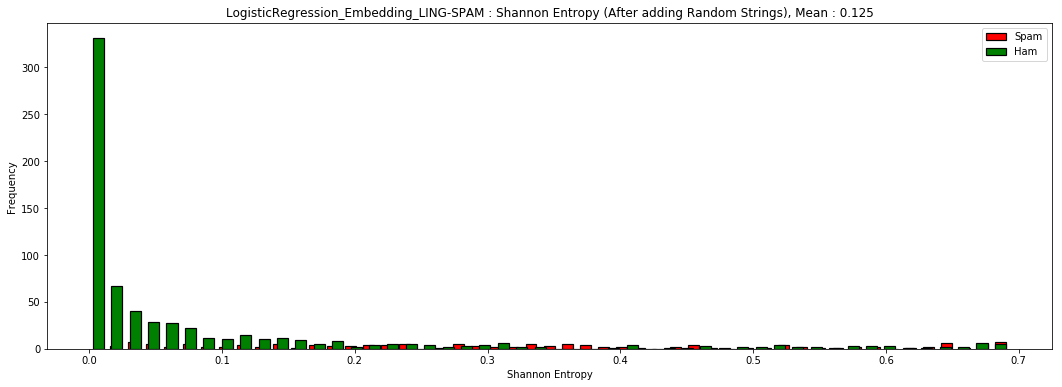

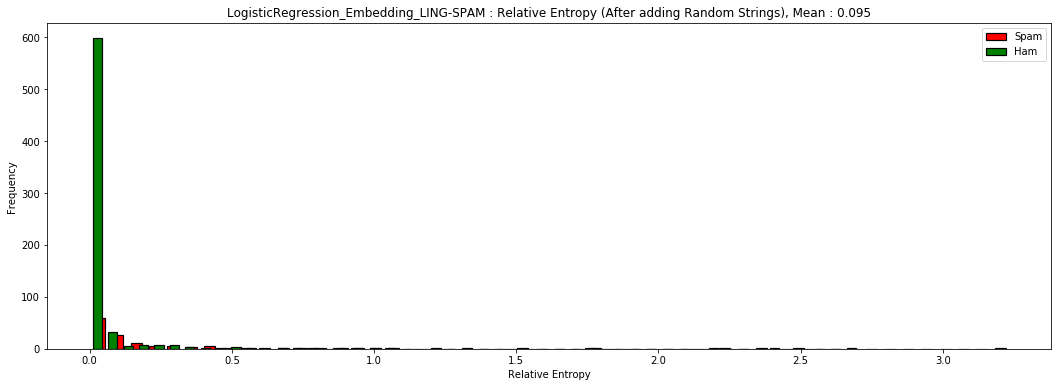

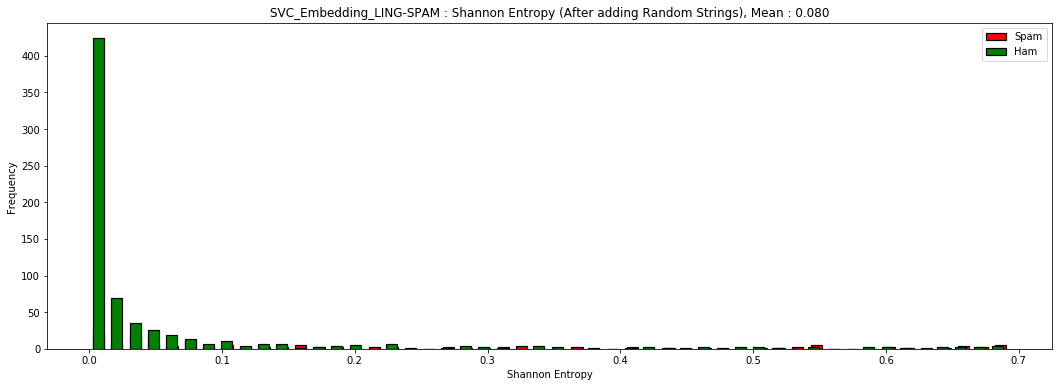

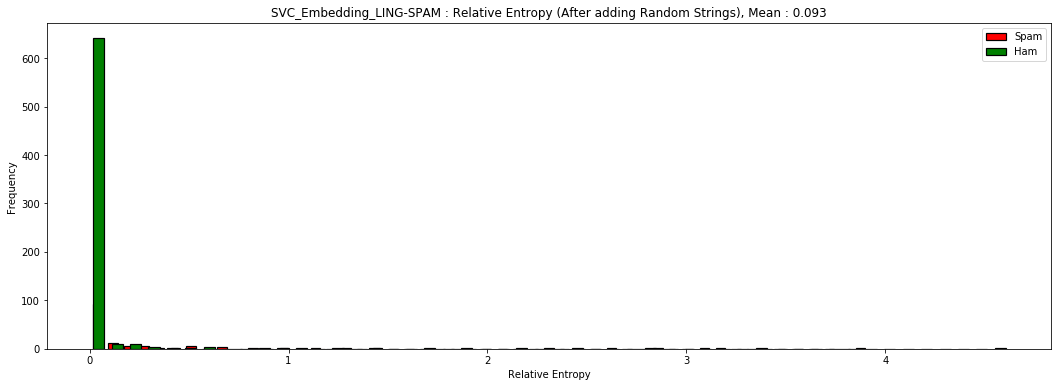

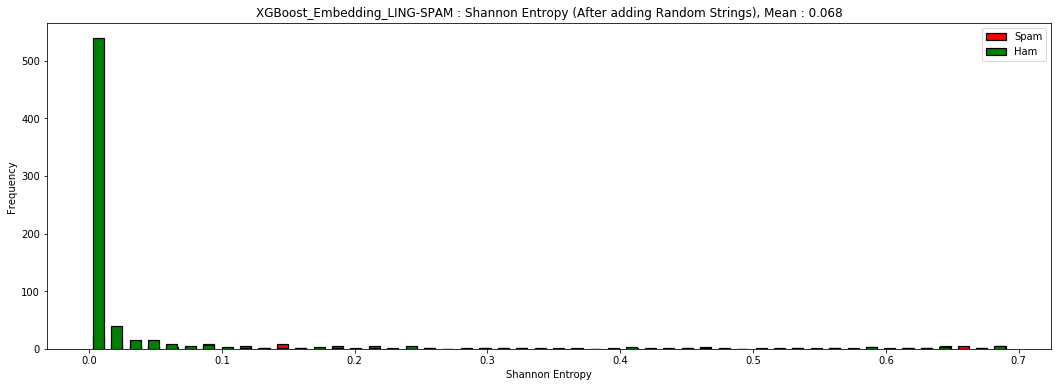

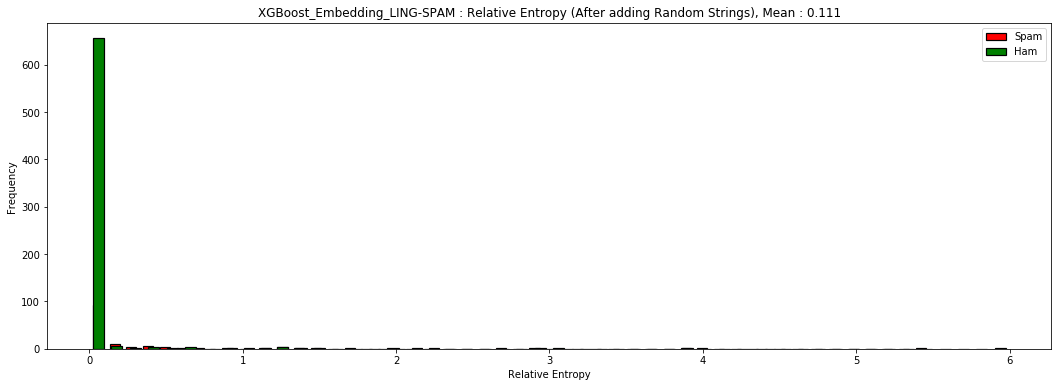

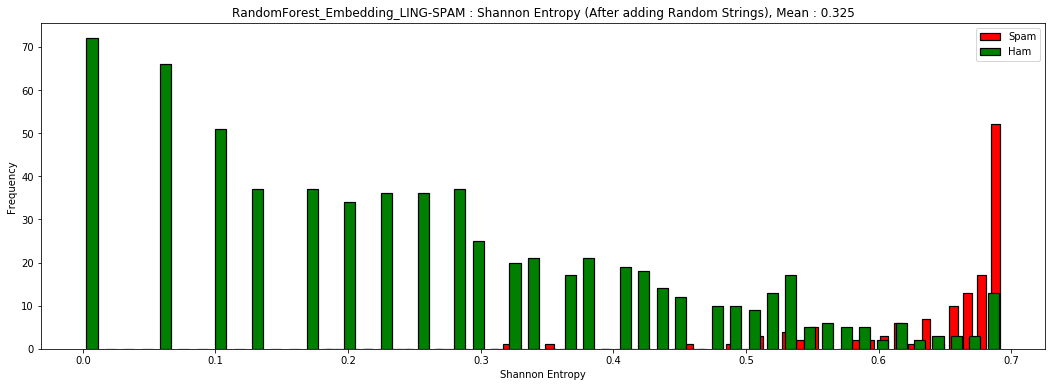

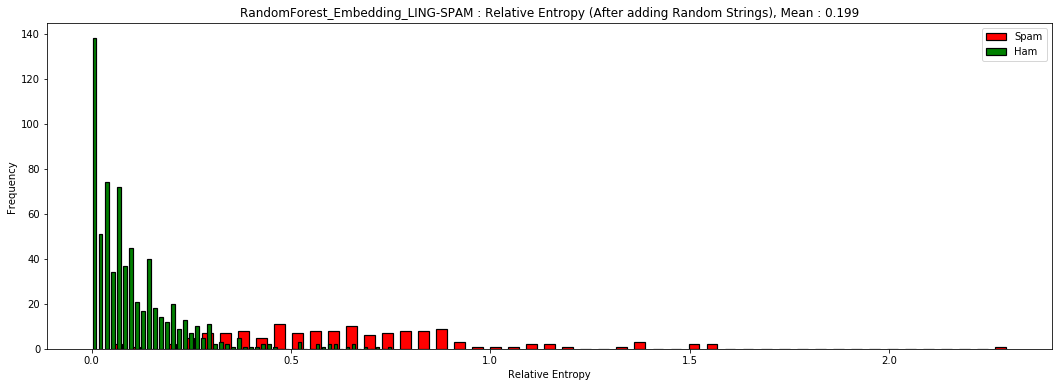

In [56]:
visualise_entropies(dataset, test_x_with_random_scrambled_strings_glove, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Scrambled Words Adding Strings)

********************************************************************************
LogisticRegression_Embedding_LING-SPAM
********************************************************************************
Log Loss :  1.2574923381236818
ROC AUC :  0.9909678096938507
Accuracy :  0.9635922330097088
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       685
         1.0       0.90      0.88      0.89       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.94      0.93      0.93       824
weighted avg       0.96      0.96      0.96       824



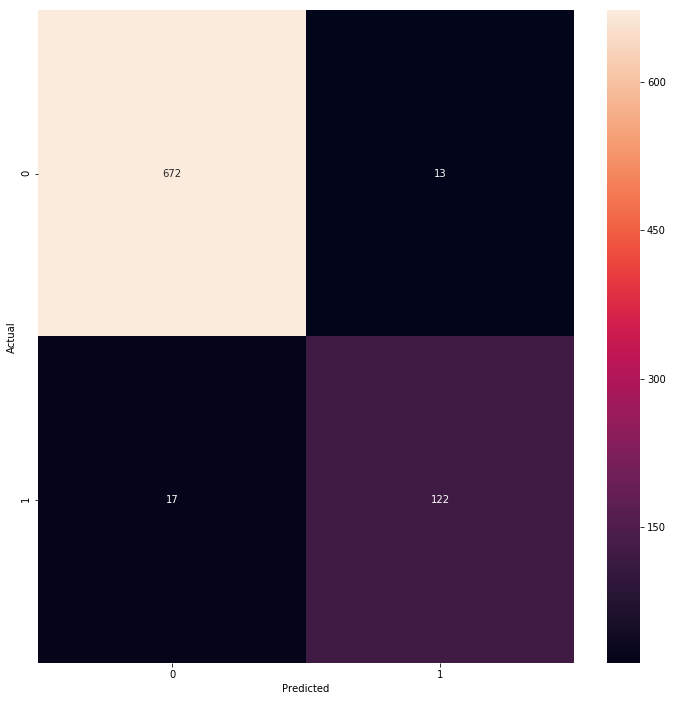

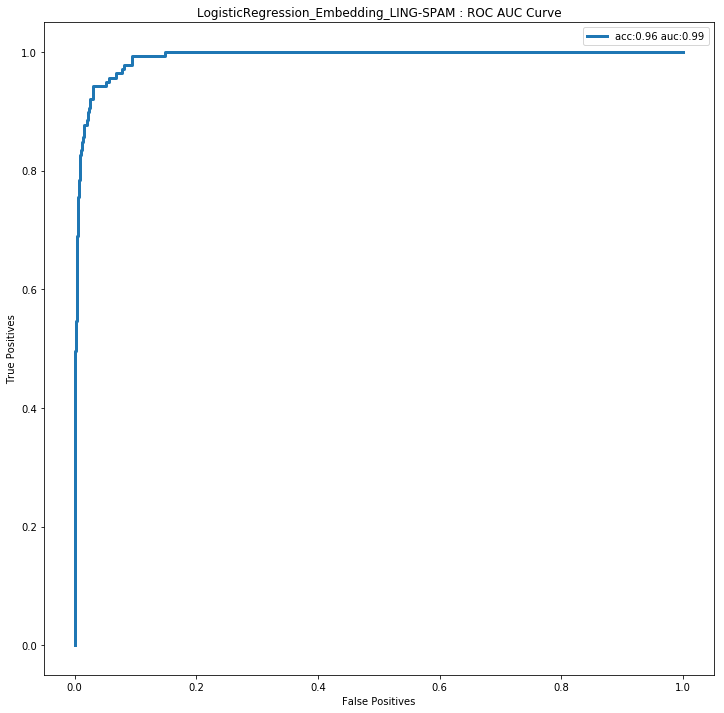

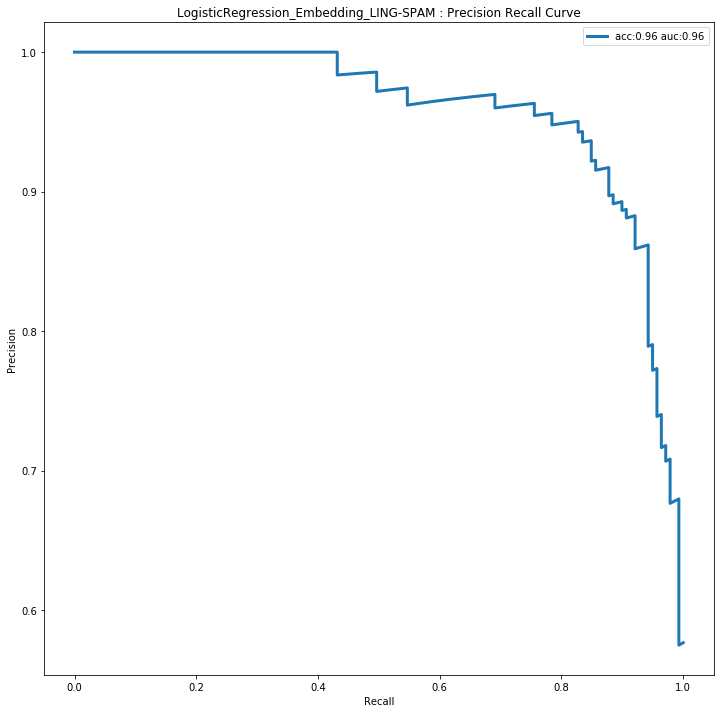

********************************************************************************
SVC_Embedding_LING-SPAM
********************************************************************************
Log Loss :  1.2155763473531591
ROC AUC :  0.9908942918657775
Accuracy :  0.9648058252427184
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       685
         1.0       0.90      0.88      0.89       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.94      0.93      0.94       824
weighted avg       0.96      0.96      0.96       824



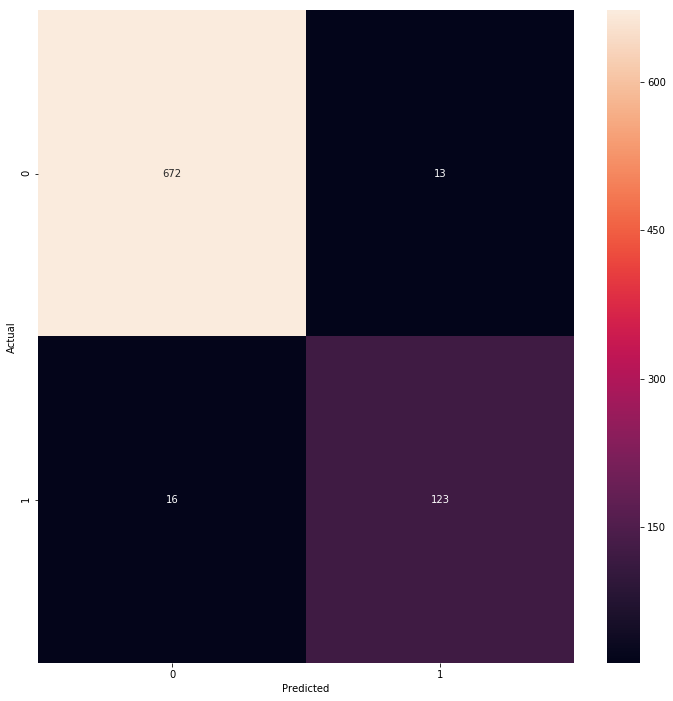

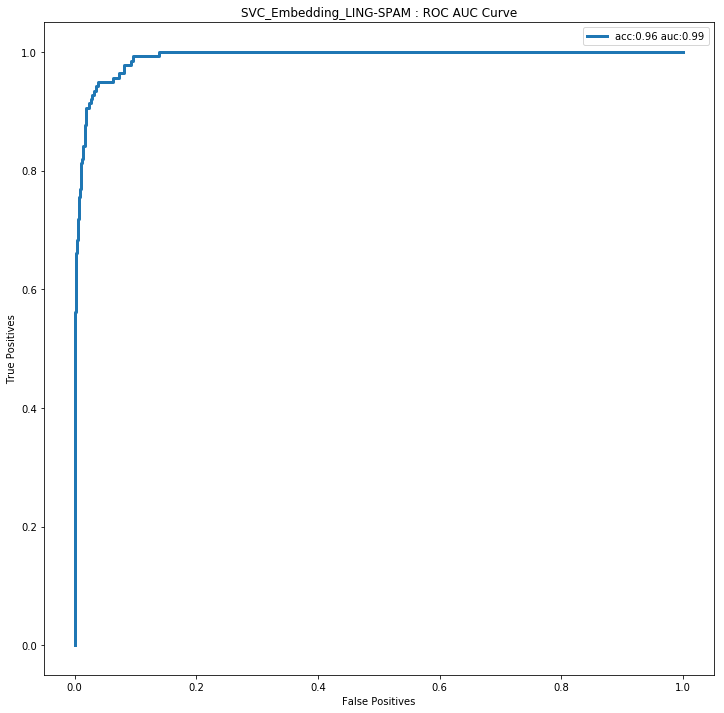

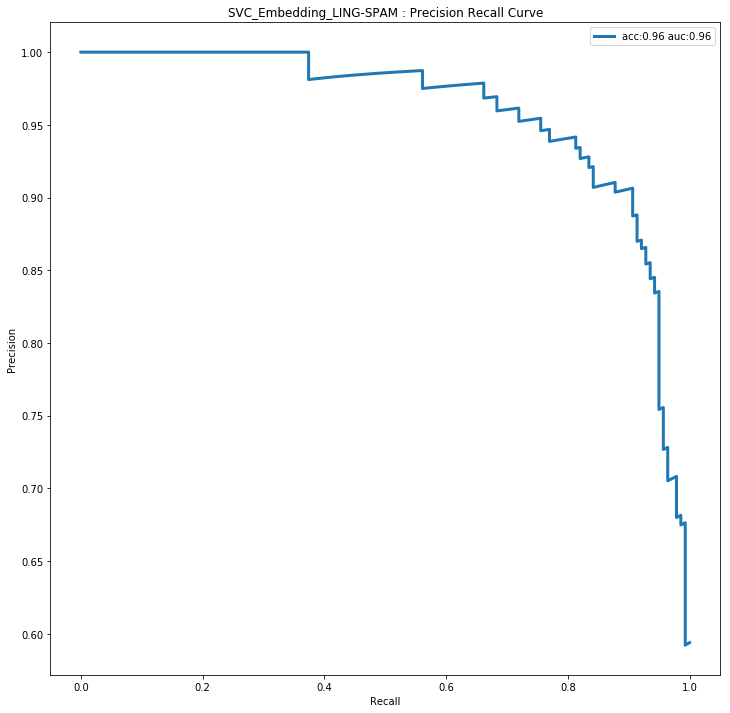

********************************************************************************
XGBoost_Embedding_LING-SPAM
********************************************************************************
Log Loss :  1.550906214287802
ROC AUC :  0.9888673003203277
Accuracy :  0.9550970873786407
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       685
         1.0       0.89      0.84      0.86       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.93      0.91      0.92       824
weighted avg       0.95      0.96      0.95       824



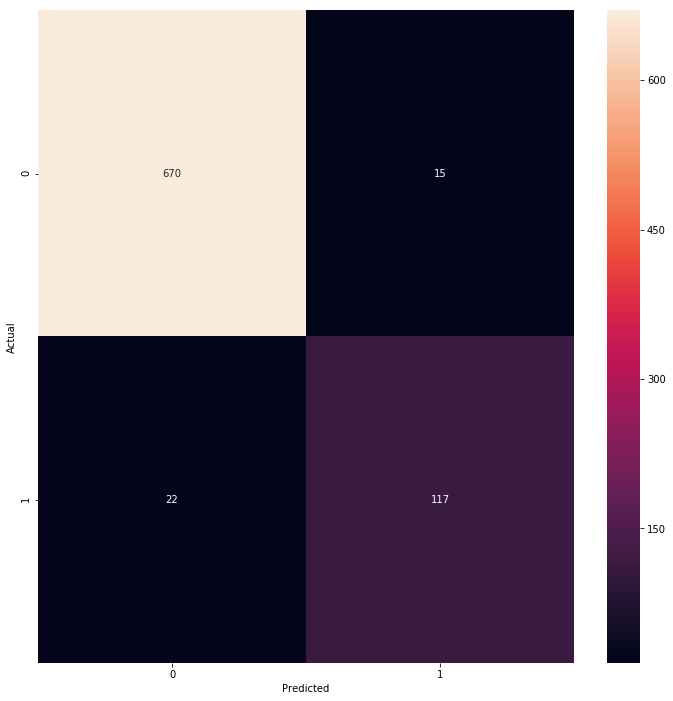

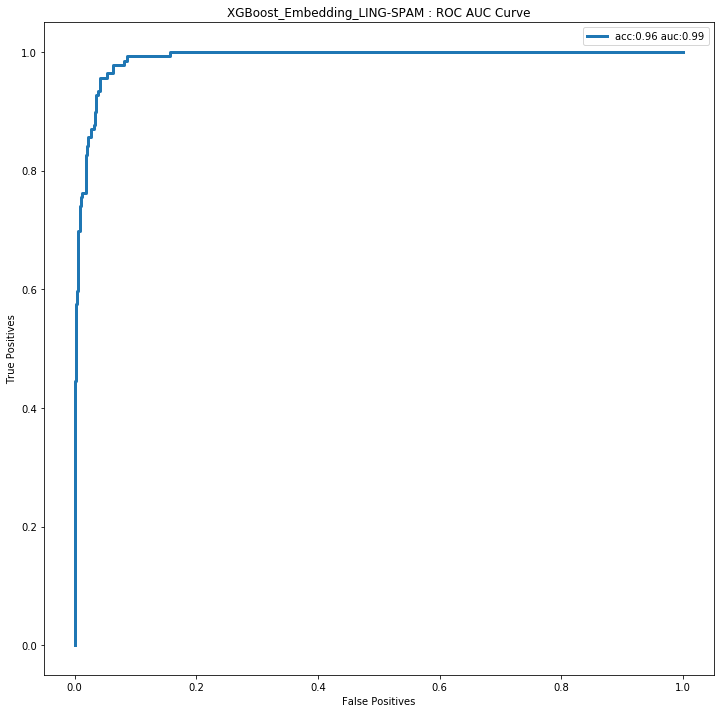

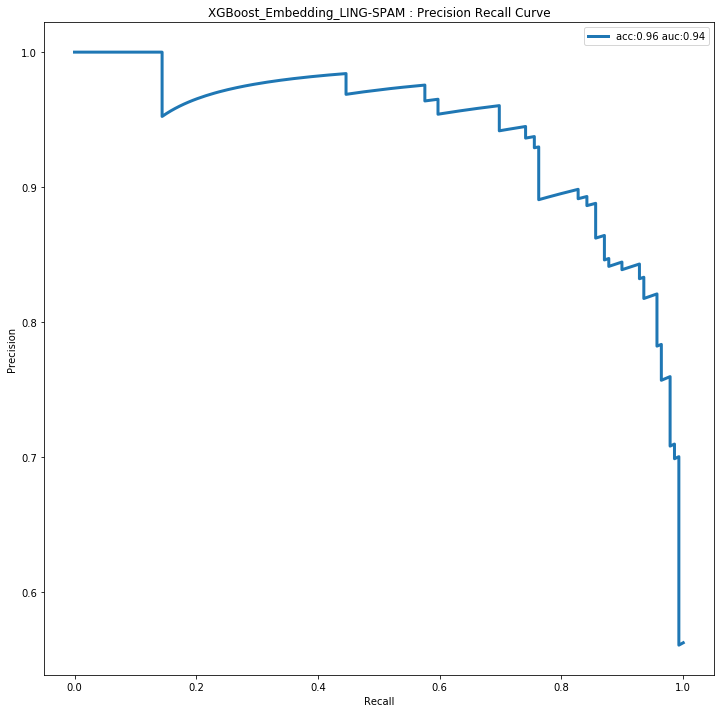

********************************************************************************
RandomForest_Embedding_LING-SPAM
********************************************************************************
Log Loss :  2.5149613870018226
ROC AUC :  0.9866722680249961
Accuracy :  0.9271844660194175
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       685
         1.0       0.98      0.58      0.73       139

   micro avg       0.93      0.93      0.93       824
   macro avg       0.95      0.79      0.84       824
weighted avg       0.93      0.93      0.92       824



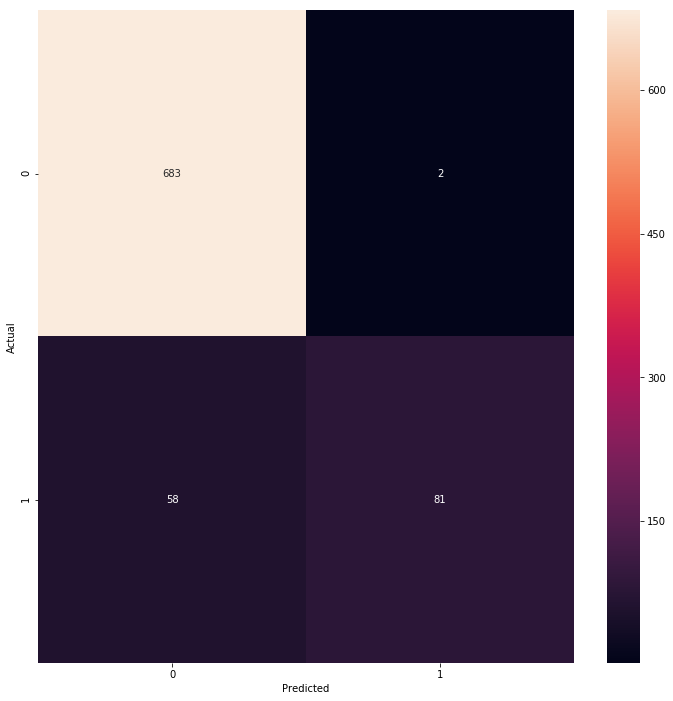

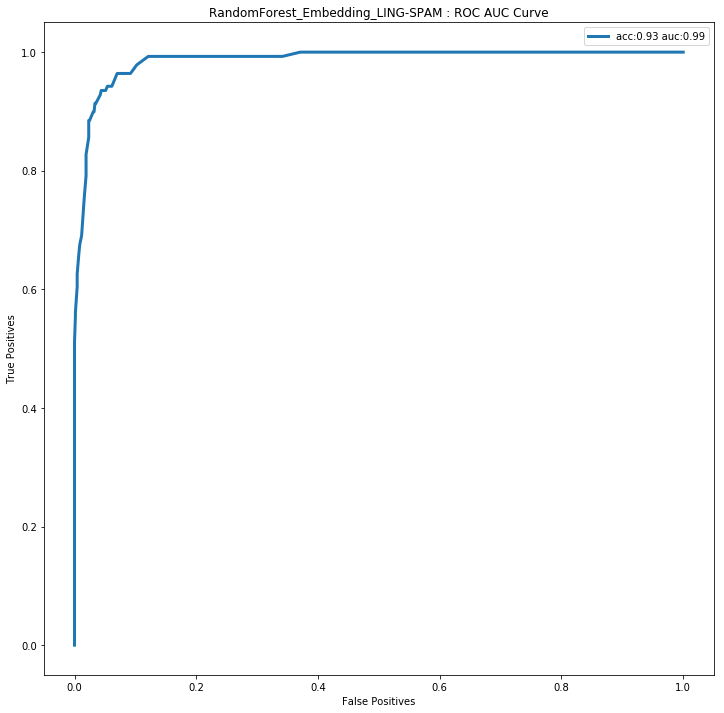

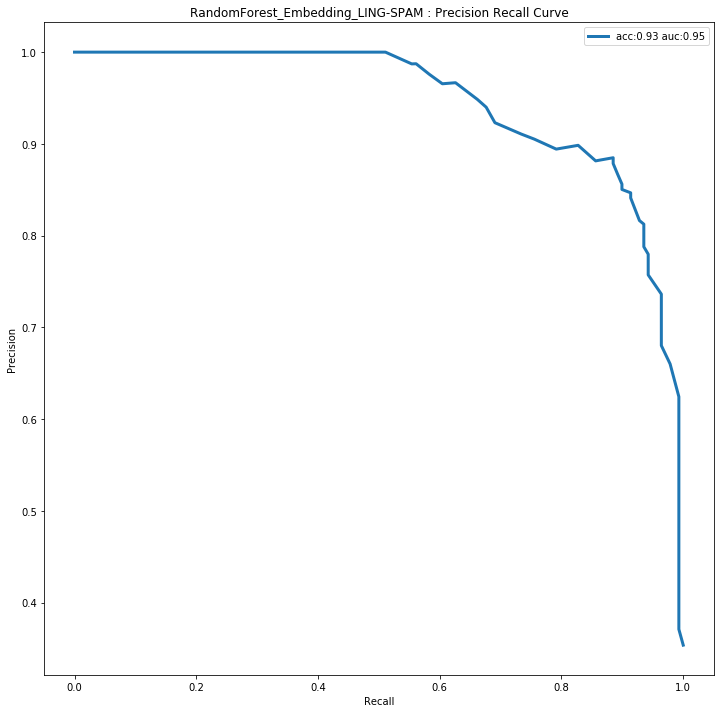

In [57]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_scrambled_strings_glove, y_test)

## 4. Embeddings with Dense Network

In [58]:
grids = {}
num_max = 1000
le = LabelEncoder()
tok = Tokenizer(num_words=num_max)
tok.fit_on_texts(train_x_cleaned)
train_x_dense = tok.texts_to_matrix(train_x_cleaned,mode='count')
test_x_dense = tok.texts_to_matrix(test_x_cleaned,mode='count')
print(y_train.shape,train_x_dense.shape, y_test.shape, test_x_dense.shape)

(2069,) (2069, 1000) (824,) (824, 1000)


In [59]:
dense_model = get_dense_model(num_max)
dense_model.fit(train_x_dense,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

grids['DNN_'+dataset] = copy.deepcopy(dense_model)

gc.enable(); gc.collect();

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
compile done
Instructions for updating:
Use tf.cast instead.
Train on 1655 samples, validate on 414 samples
Epoch 1/10
1655/1655 [==============================] - 6s 4ms/step - loss: 0.3671 - acc: 0.8248 - binary_accuracy: 0.8248 - val_loss: 0.0662 - val_acc: 0.9879 - val_binary_accuracy: 0.9879
Epoch 2/10
1655/1655 [==============================] - 0s 160us/step - loss: 0.0621 - acc: 0.9813 - binary_accuracy: 0.9813 - val_loss: 0.0257 - val_acc: 0.9879 - val_binary_accuracy: 0.9879
Epoch 3/10
1655/1655 [==============================] - 0s 157us/step - loss: 0.0156 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0384 - val_acc: 0.9879 - val_binary_accuracy: 0.9879
Epoch 4/10
1655/1655 [==============================] - 0s 154us/step - loss: 0.0052 - acc: 0.9988 - binary_accuracy: 0.9988 - val_

## Visualise Shannon and Relative entropies for various models

********************************************************************************
DNN_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.033358194
Mean Relative Entropy :  0.16527486562350516
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2     0.001     6.000     1.0       0       1.000   1.084e-04
21    0.193     3.032     1.0       0       0.952   4.824e-02
27    0.103     3.854     1.0       0       0.979   2.120e-02
29    0.040     5.018     1.0       0       0.993   6.618e-03
53    0.056     4.613     1.0       0       0.990   9.926e-03
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
681    0.304     2.403     0.0       1   9.045e-02       0.910
694    0.004     6.000     0.0       1   5.087e-04       0.999
790    0.668     0.943     0.0       1   3.893e-01       0.611
809    0.247     2.696     0.0       1   6.745e-02       0.933
816    0.453     1.781     0.0      

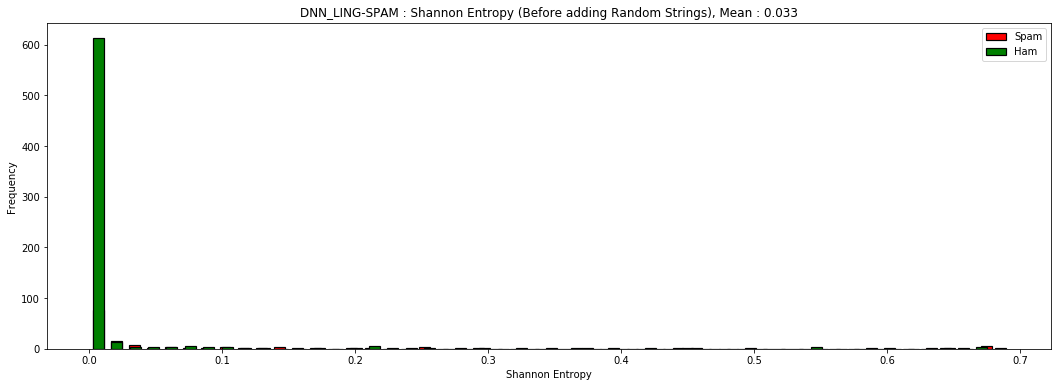

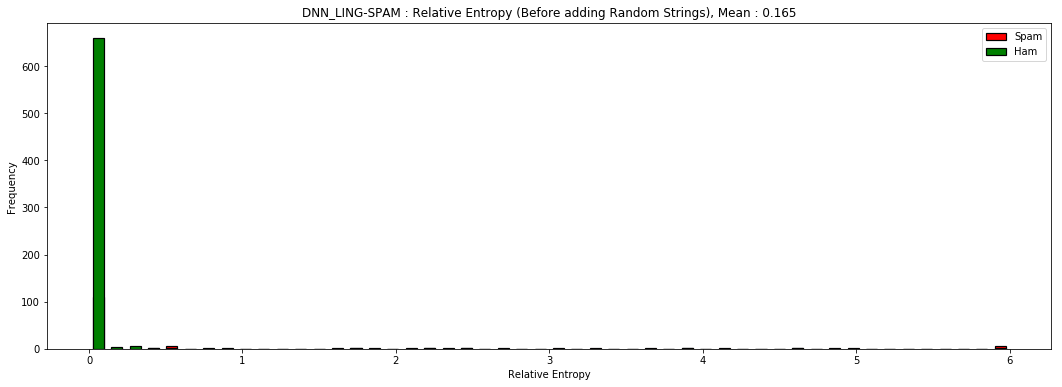

In [60]:
visualise_entropies(dataset, test_x_dense, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
DNN_LING-SPAM
********************************************************************************
Log Loss :  1.4670732623615257
ROC AUC :  0.9843564564406868
Accuracy :  0.9575242718446602
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       685
         1.0       0.89      0.85      0.87       139

   micro avg       0.96      0.96      0.96       824
   macro avg       0.93      0.91      0.92       824
weighted avg       0.96      0.96      0.96       824



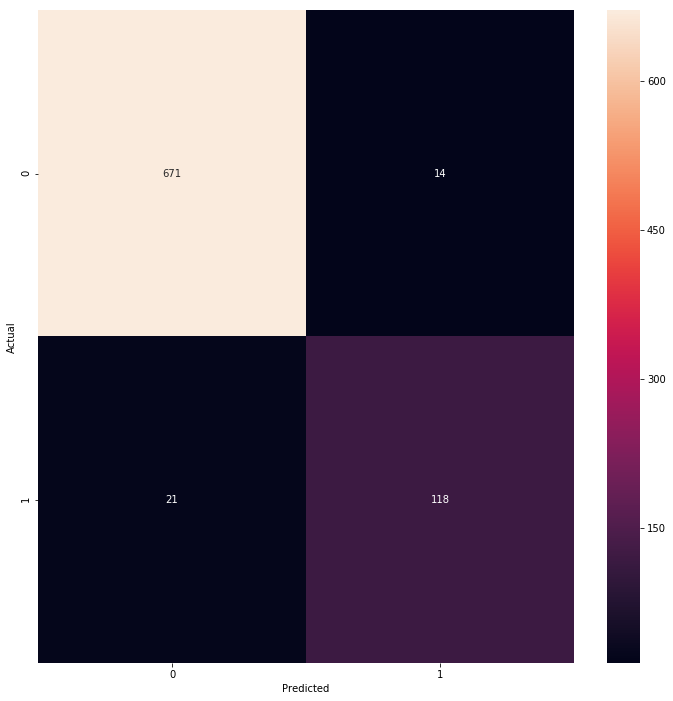

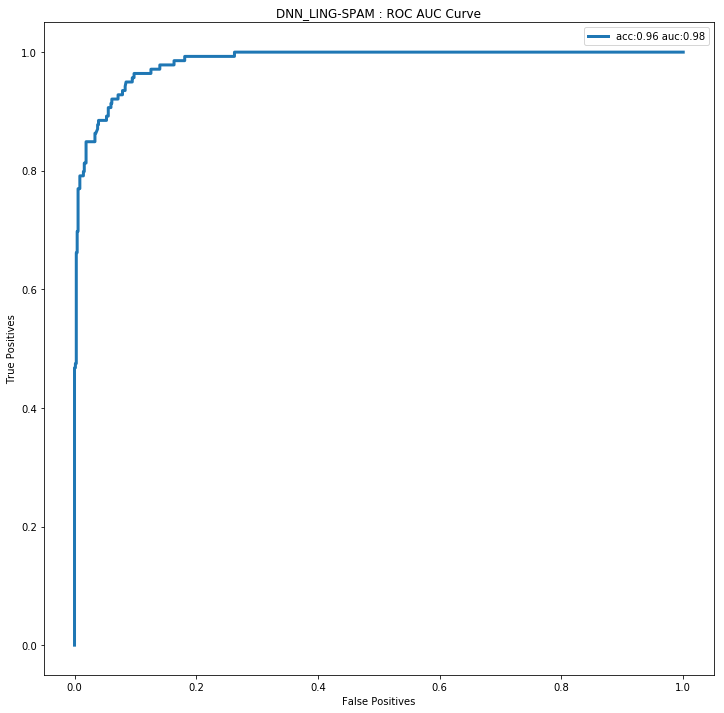

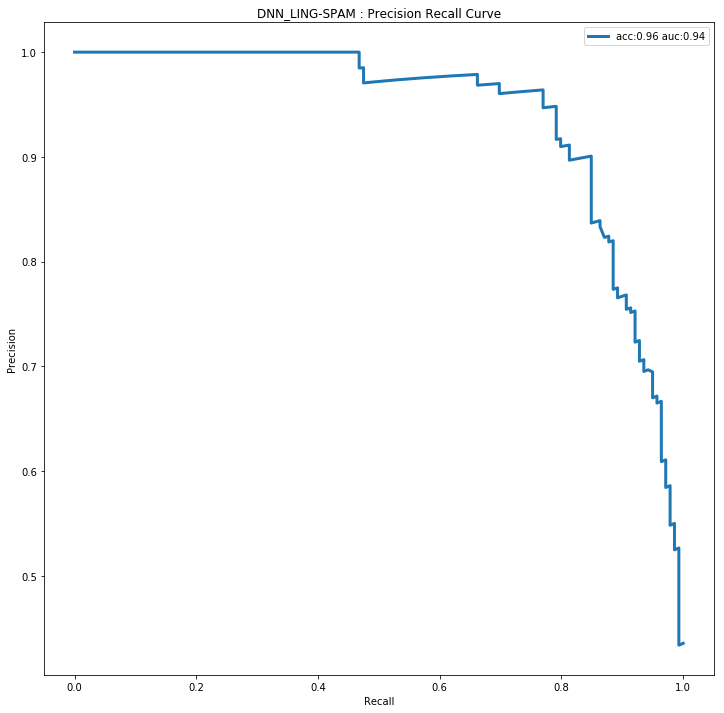

In [61]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_dense, y_test)

In [62]:
#dense_model.evaluate(test_x_dense, y_test)

## Adding Meaningful Strings to Test Data

In [63]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
test_x_with_random_strings_dense = tok.texts_to_matrix(test_x_with_random_strings,mode='count')

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
DNN_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.034771487
Mean Relative Entropy :  0.2236841668367484
Head 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2   5.659e-05     6.000     1.0       0       1.000   4.232e-06
7   4.777e-01     1.692     1.0       0       0.816   1.842e-01
15  9.952e-02     3.893     1.0       0       0.980   2.038e-02
21  9.210e-03     6.000     1.0       0       0.999   1.191e-03
24  1.527e-01     3.344     1.0       0       0.965   3.530e-02
Tail 5 : 
       Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
136  1.782e-04     6.000     1.0       0       1.000   1.469e-05
137  5.067e-05     6.000     1.0       0       1.000   3.755e-06
150  6.786e-01     0.880     0.0       1       0.415   5.852e-01
525  8.047e-02     4.159     0.0       1       0.016   9.844e-01
694  1.185e-01 

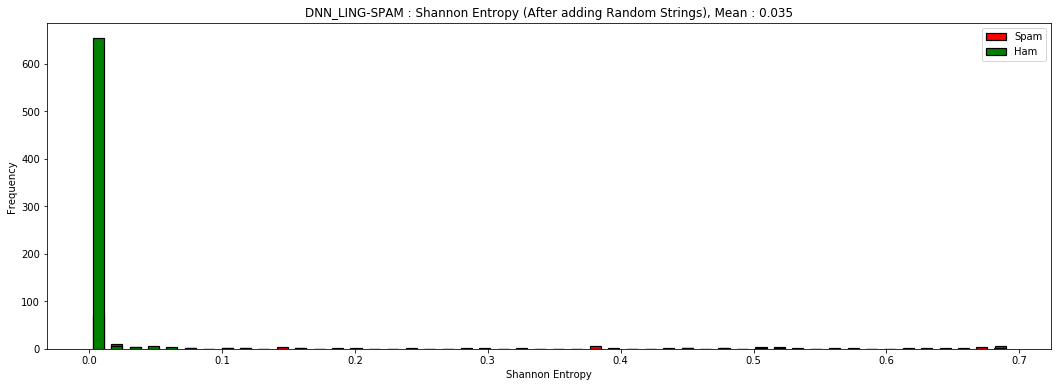

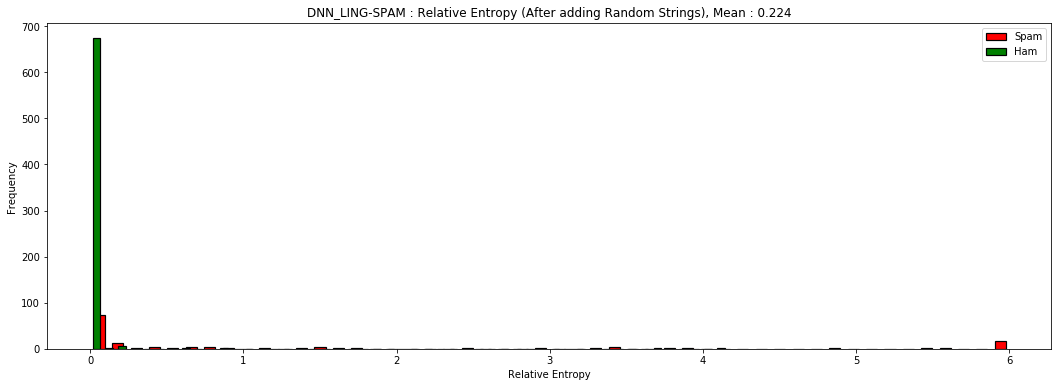

In [64]:
visualise_entropies(dataset, test_x_with_random_strings_dense, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
DNN_LING-SPAM
********************************************************************************
Log Loss :  1.8862224958292133
ROC AUC :  0.9836947959880271
Accuracy :  0.9453883495145631
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       685
         1.0       0.97      0.70      0.81       139

   micro avg       0.95      0.95      0.95       824
   macro avg       0.96      0.85      0.89       824
weighted avg       0.95      0.95      0.94       824



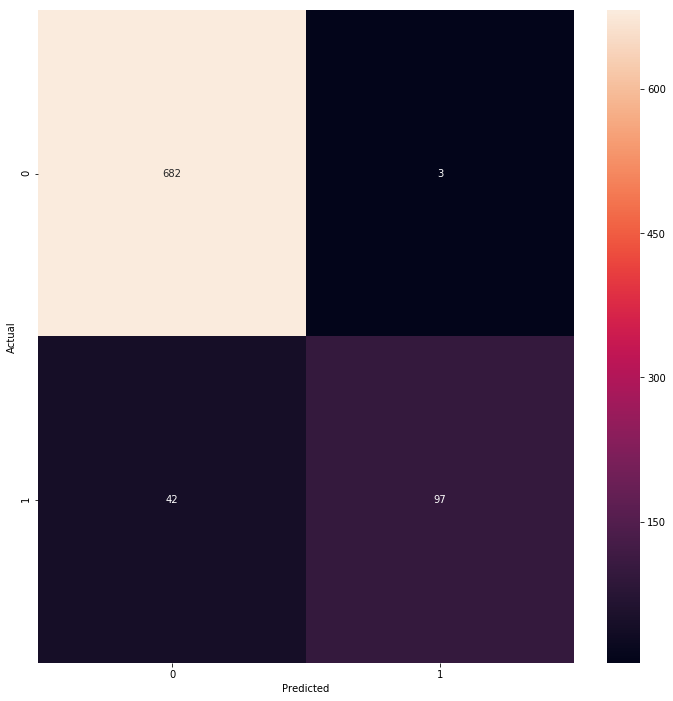

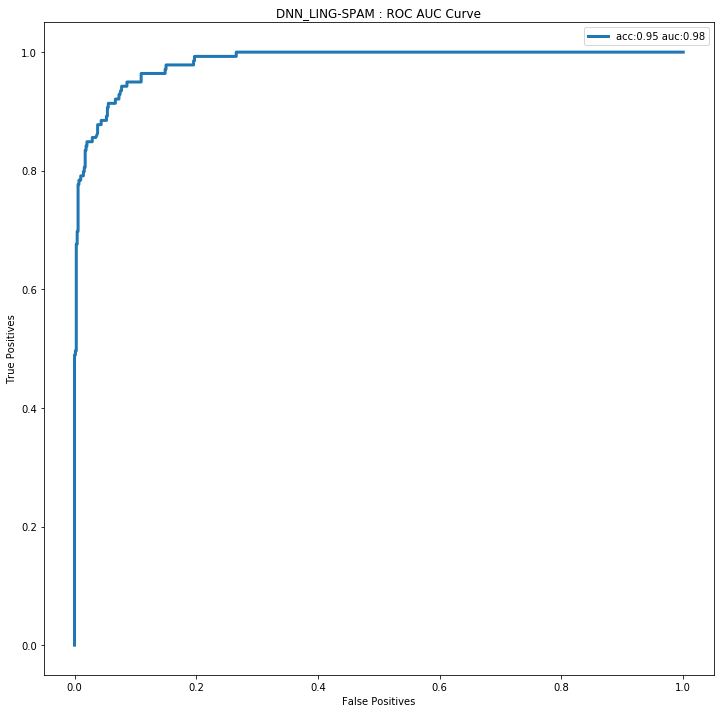

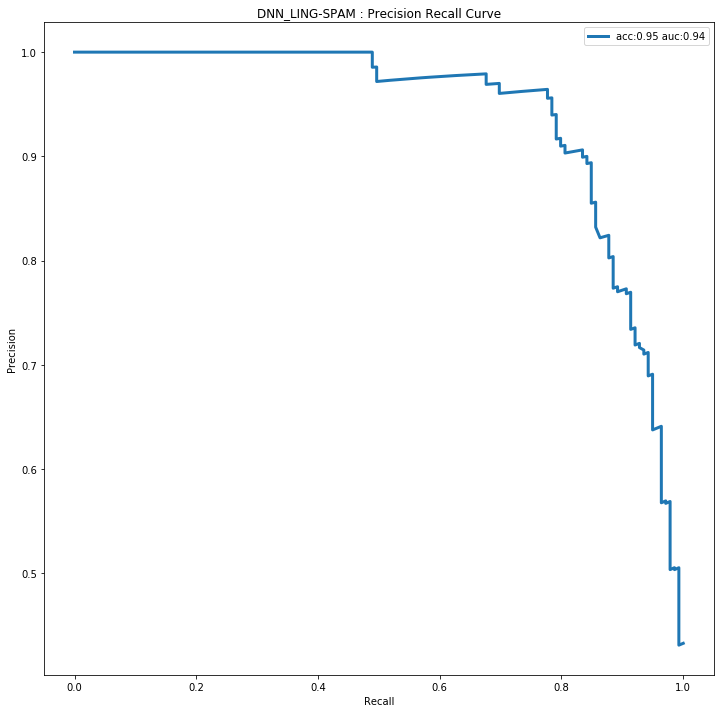

In [65]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_dense, y_test)

## Adding Meaningful Scrambled Words Strings to Test Data

In [66]:
## adding meaningful random words that are scrambled now to the test dataset to further confuse the filter
test_x_with_random_scrambled_strings = add_meaningful_scrambled_strings (test_x_cleaned, string_size)
test_x_with_random_scrambled_strings_dense = tok.texts_to_matrix(test_x_with_random_scrambled_strings,mode='count')

## Visualise Shannon and Relative entropies for various models (After Adding Scrambled Words Strings)

********************************************************************************
DNN_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.50468814
Mean Relative Entropy :  1.3634020988954516
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
139    0.505     1.594     0.0       1       0.203       0.797
140    0.505     1.594     0.0       1       0.203       0.797
141    0.505     1.594     0.0       1       0.203       0.797
142    0.505     1.594     0.0       1       0.203       0.797
143    0.505     1.594     0.0       1       0.203       0.797
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
819    0.505     1.594     0.0       1       0.203       0.797
820    0.505     1.594     0.0       1       0.203       0.797
821    0.505     1.594     0.0       1       0.203       0.797
822    0.505     1.594     0.0       1       0.203       0.797
823    0.505     1.594     0.0  

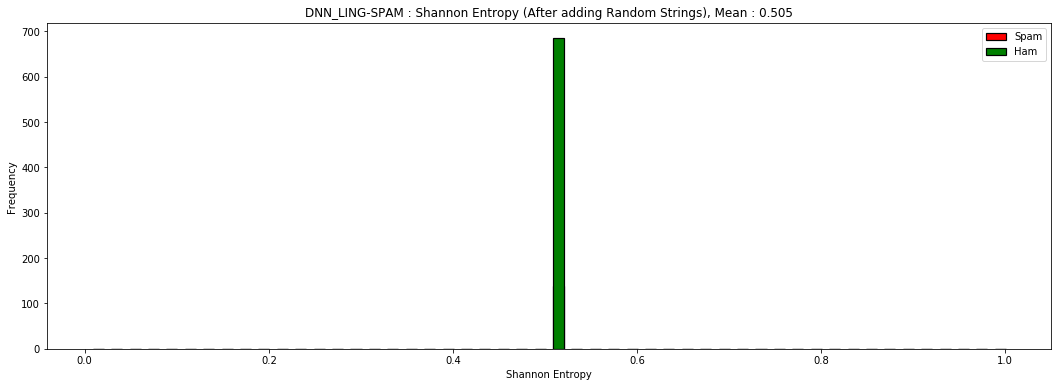

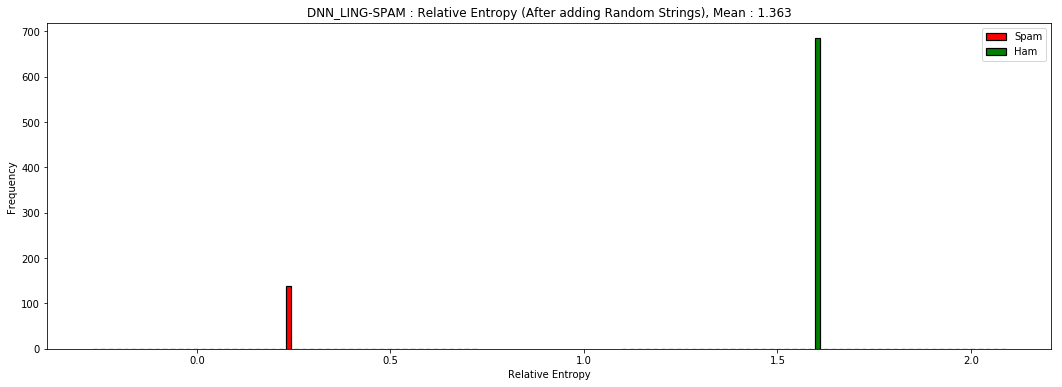

In [67]:
## visualise_entropies(dataset, test_x_with_random_strings_dense, y_test,'After')
visualise_entropies(dataset, test_x_with_random_scrambled_strings_dense, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Scrambled Words Strings)

********************************************************************************
DNN_LING-SPAM
********************************************************************************
Log Loss :  28.713118391691143
ROC AUC :  0.5
Accuracy :  0.16868932038834952
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       685
         1.0       0.17      1.00      0.29       139

   micro avg       0.17      0.17      0.17       824
   macro avg       0.08      0.50      0.14       824
weighted avg       0.03      0.17      0.05       824



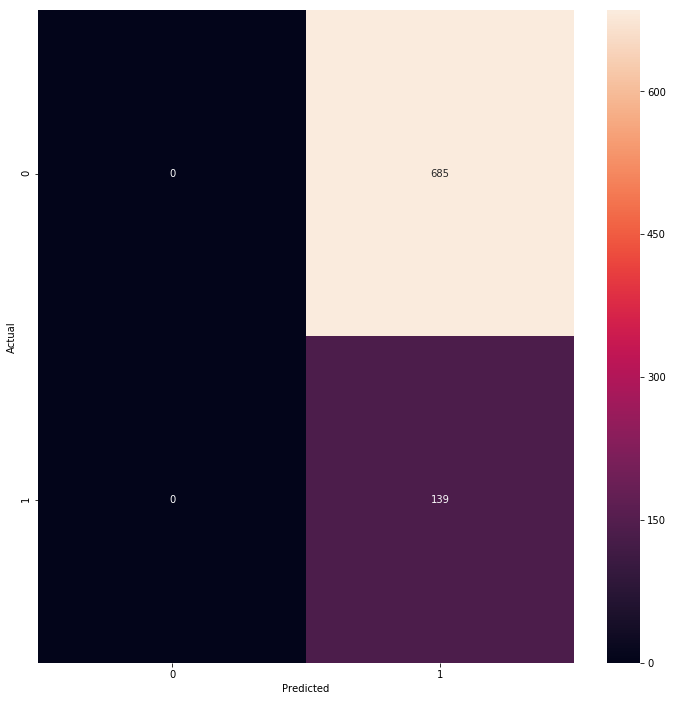

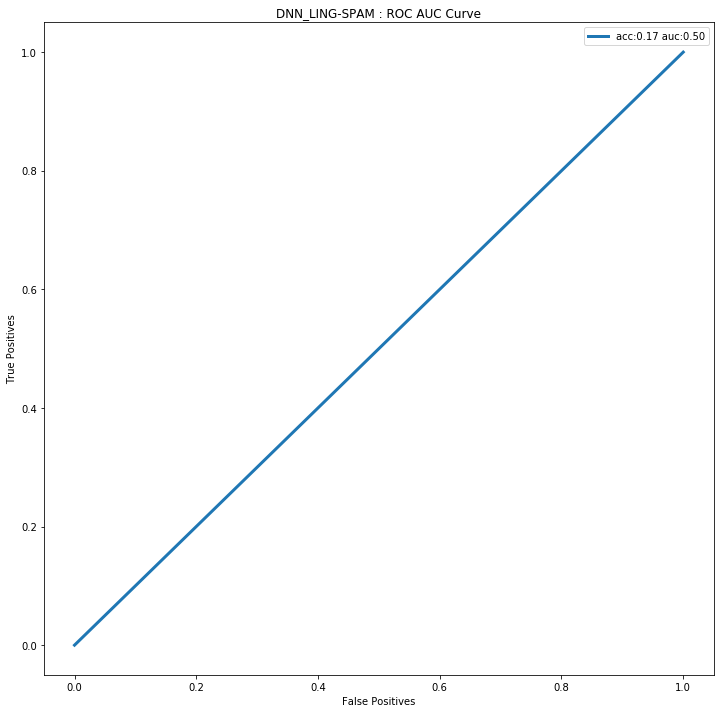

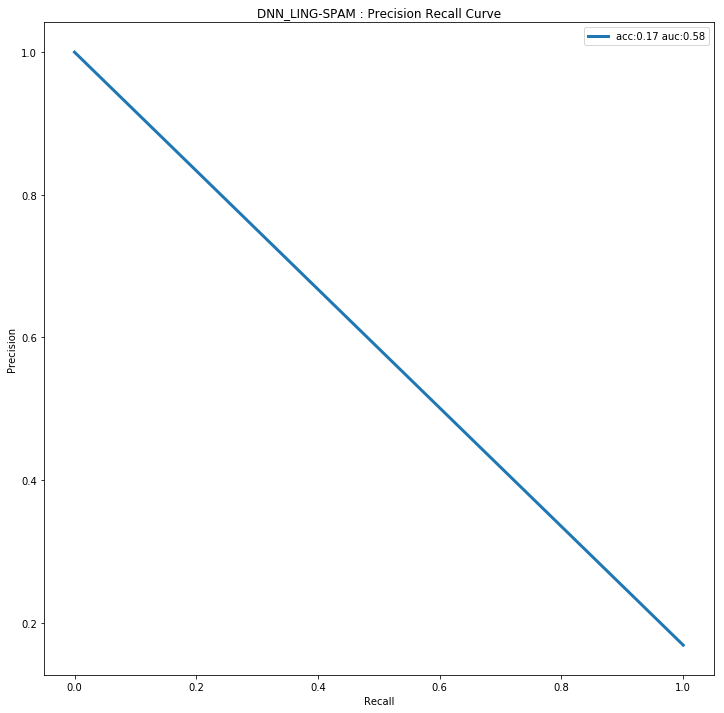

In [68]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_scrambled_strings_dense, y_test)

## 5. Embeddings with CNNs

### Initial Data Cleaning

In [69]:
grids = {}
max_len = 100
cnn_train_seq = tok.texts_to_sequences(train_x_cleaned)
cnn_test_seq = tok.texts_to_sequences(test_x_cleaned)
#print(cnn_texts_seq[0])
train_x_cnn = sequence.pad_sequences(cnn_train_seq,maxlen=max_len)
test_x_cnn = sequence.pad_sequences(cnn_test_seq,maxlen=max_len)
#print(train_x_cnn[0])
print(train_x_cnn.shape)

(2069, 100)


## CNN Version 1

### Training Model

In [70]:
cnn_v1 = get_cnn_model_v1(max_len)
cnn_v1.fit(train_x_cnn,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

grids['CNN_V1_'+dataset] = copy.deepcopy(cnn_v1)

gc.enable(); gc.collect();

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1655 samples, validate on 414 samples
Epoch 1/10
1655/1655 [==============================] - 1s 610us/step - loss: 0.5219 - acc: 0.7934 - binary_accuracy: 0.7934 - val_loss: 0.2594 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/10
1655/1655 [==============================] - 0s 198us/step - loss: 0.3391 - acc: 0.7976 - binary_accuracy: 0.7976 - val_loss: 0.0595 - val_acc: 0.9855 - val_binary_accuracy: 0.9855
Epoch 3/10
1655/1655 [==============================] - 0s 199us/step - loss: 0.1414 - acc: 0.9692 - binary_accuracy: 0.9692 - val_loss: 0.0622 - val_acc: 0.9638 - val_binary_accuracy: 0.9638
Epoch 4/10
1655/1655 [==============================] - 0s 195us/step - loss: 0.0509 - acc: 0.9879 - binary_accuracy: 0.9879 - val_loss: 0.0782 - val_acc: 0.9662 - val_binary_accuracy: 0.9662
Epoch 5/10
1655/1655 [==============================] - 0s 196us/step - loss: 0.0276 - acc: 0.9927 - binary

## Visualise Shannon and Relative entropies for various models

********************************************************************************
CNN_V1_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.041375544
Mean Relative Entropy :  0.19027816205480347
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2     0.677     0.889     1.0       0       0.589       0.411
24    0.068     4.367     1.0       0       0.987       0.013
27    0.248     2.691     1.0       0       0.932       0.068
30    0.674     0.910     1.0       0       0.597       0.403
43    0.086     4.080     1.0       0       0.983       0.017
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
730    0.375     2.089     0.0       1       0.124       0.876
749    0.691     0.762     0.0       1       0.467       0.533
786    0.329     2.285     0.0       1       0.102       0.898
809    0.020     5.821     0.0       1       0.003       0.997
816    0.049     4.774     0.0   

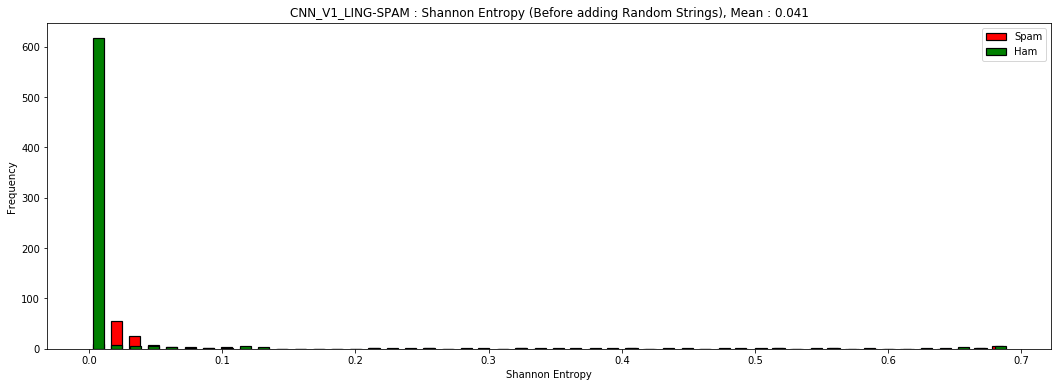

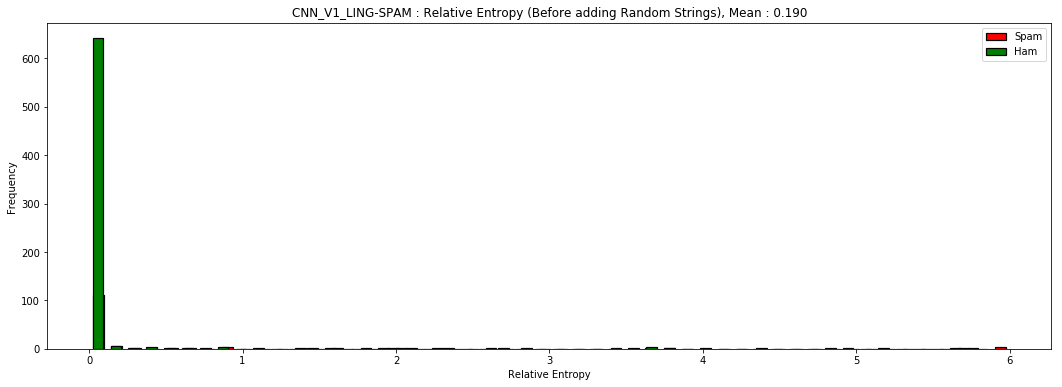

In [71]:
visualise_entropies(dataset, test_x_cnn, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
CNN_V1_LING-SPAM
********************************************************************************
Log Loss :  2.053912659312536
ROC AUC :  0.982933361340125
Accuracy :  0.9405339805825242
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       685
         1.0       0.80      0.86      0.83       139

   micro avg       0.94      0.94      0.94       824
   macro avg       0.89      0.91      0.90       824
weighted avg       0.94      0.94      0.94       824



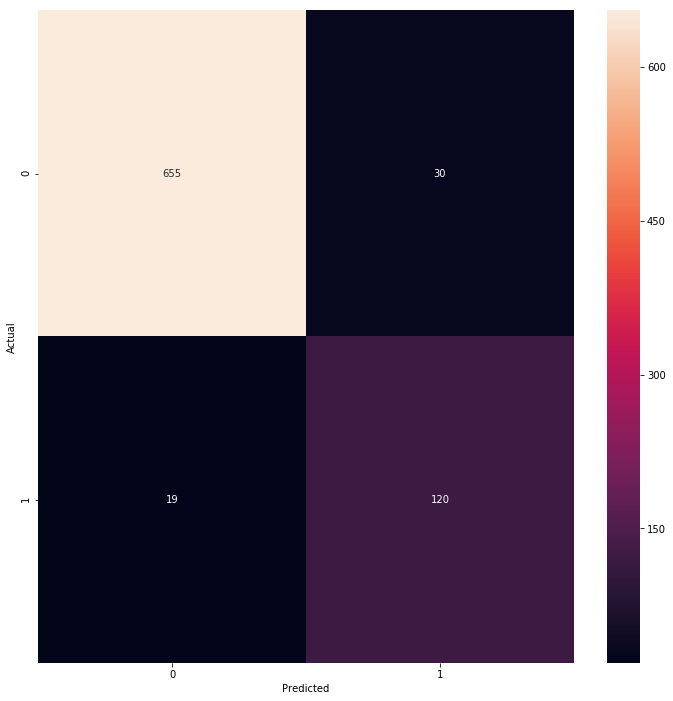

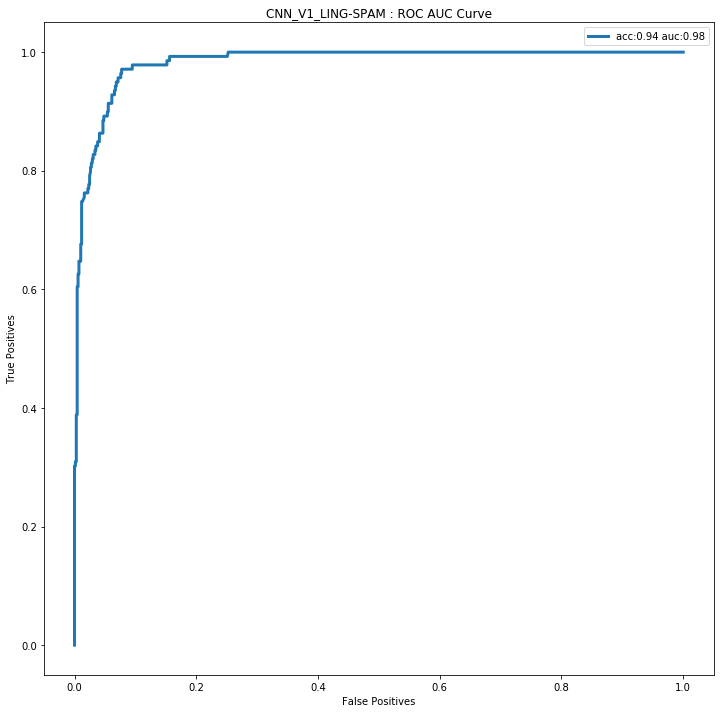

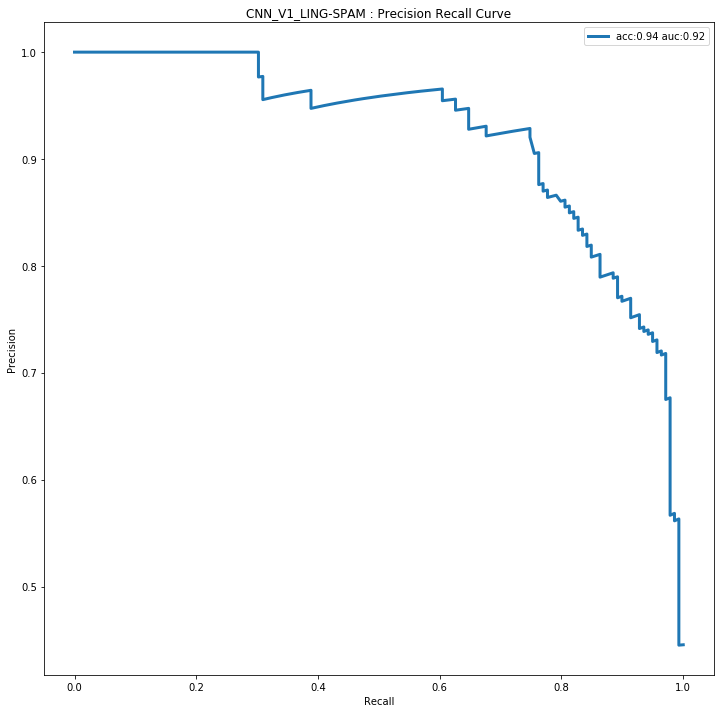

In [72]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cnn, y_test)

## Adding Meaningful Strings to Test Data

In [73]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V1_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.060020123
Mean Relative Entropy :  0.2668258615365297
Head 5 : 
   Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2    0.002     6.000     1.0       0       1.000   2.443e-04
3    0.692     0.741     1.0       0       0.524   4.764e-01
5    0.381     2.061     1.0       0       0.873   1.273e-01
7    0.016     6.000     1.0       0       0.998   2.247e-03
8    0.364     2.134     1.0       0       0.882   1.183e-01
Tail 5 : 
       Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
137  6.113e-04     6.000     1.0       0       1.000   5.671e-05
150  1.991e-01     2.992     0.0       1       0.050   9.498e-01
242  2.642e-01     2.602     0.0       1       0.074   9.259e-01
591  3.350e-01     2.258     0.0       1       0.105   8.954e-01
816  1.807e-01     3.121     0

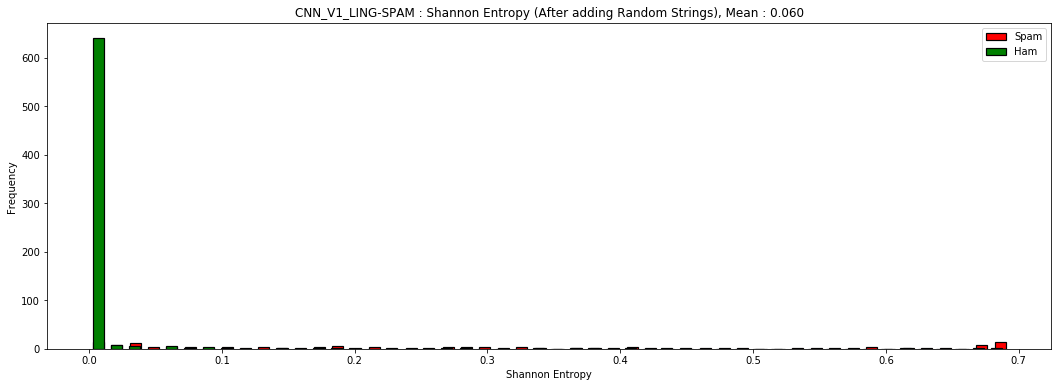

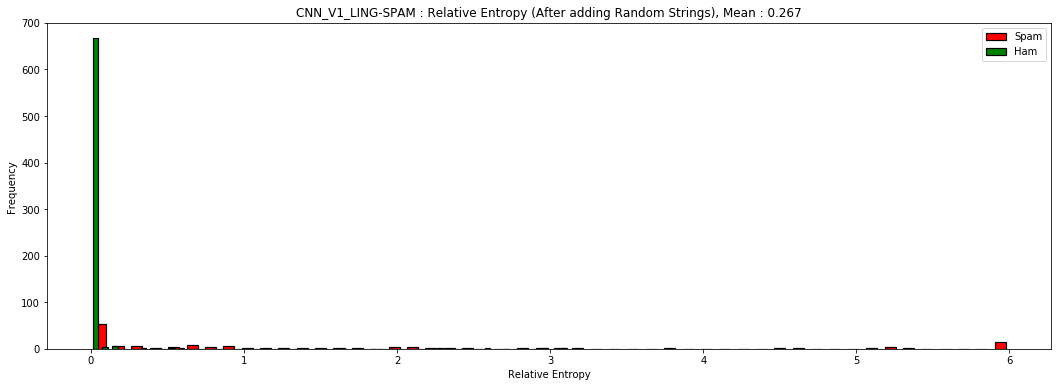

In [74]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V1_LING-SPAM
********************************************************************************
Log Loss :  2.6826272908543753
ROC AUC :  0.979351992858268
Accuracy :  0.9223300970873787
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       685
         1.0       0.95      0.57      0.71       139

   micro avg       0.92      0.92      0.92       824
   macro avg       0.94      0.78      0.83       824
weighted avg       0.92      0.92      0.91       824



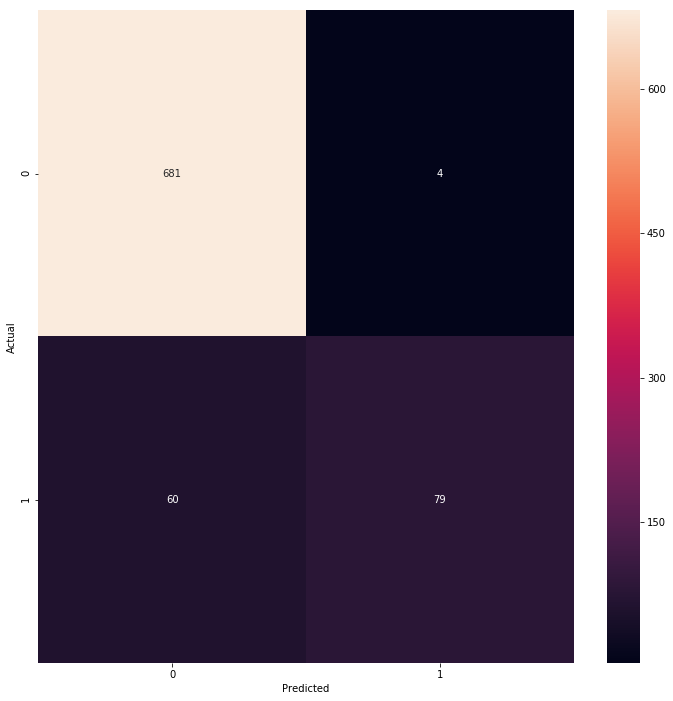

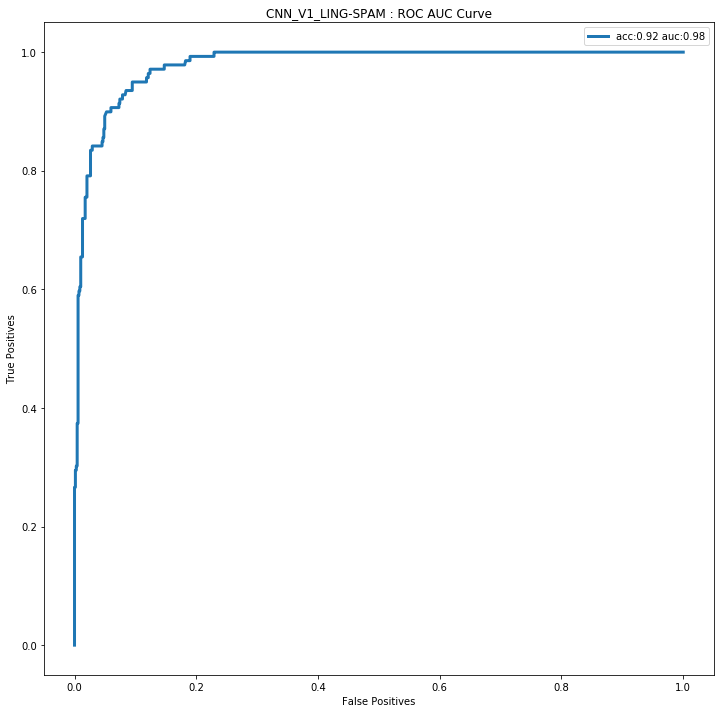

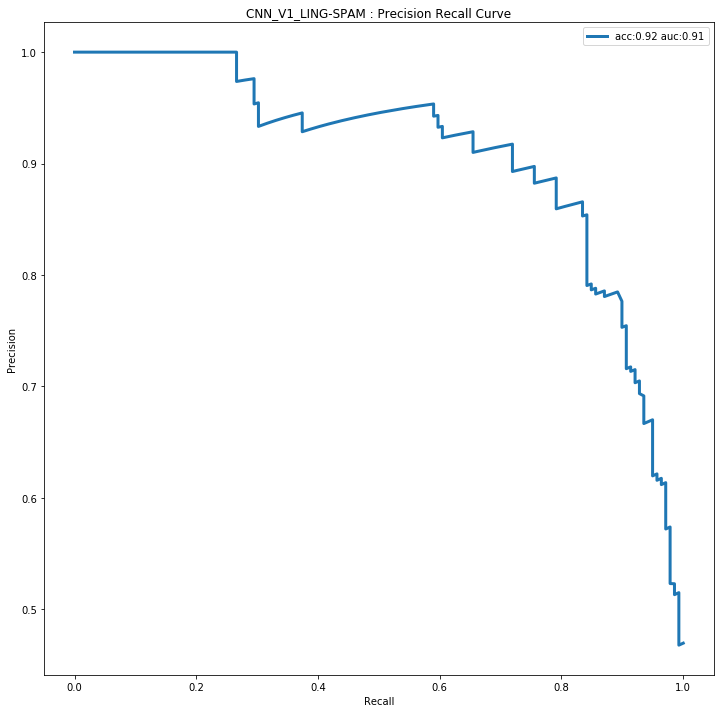

In [75]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)

## Adding Meaningful Scrambled Words Strings to Test Data

In [76]:
## adding meaningful random words that are scrambled now to the test dataset to further confuse the filter
text_x_with_random_scrambled_strings = add_meaningful_scrambled_strings (test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_scrambled_strings)
test_x_with_random_scrambled_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding SCrambled Words Strings)

********************************************************************************
CNN_V1_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.10760605
Mean Relative Entropy :  3.158121732000174
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
139    0.108     3.794     0.0       1       0.022       0.978
140    0.108     3.794     0.0       1       0.022       0.978
141    0.108     3.794     0.0       1       0.022       0.978
142    0.108     3.794     0.0       1       0.022       0.978
143    0.108     3.794     0.0       1       0.022       0.978
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
819    0.108     3.794     0.0       1       0.022       0.978
820    0.108     3.794     0.0       1       0.022       0.978
821    0.108     3.794     0.0       1       0.022       0.978
822    0.108     3.794     0.0       1       0.022       0.978
823    0.108     3.794     0.0

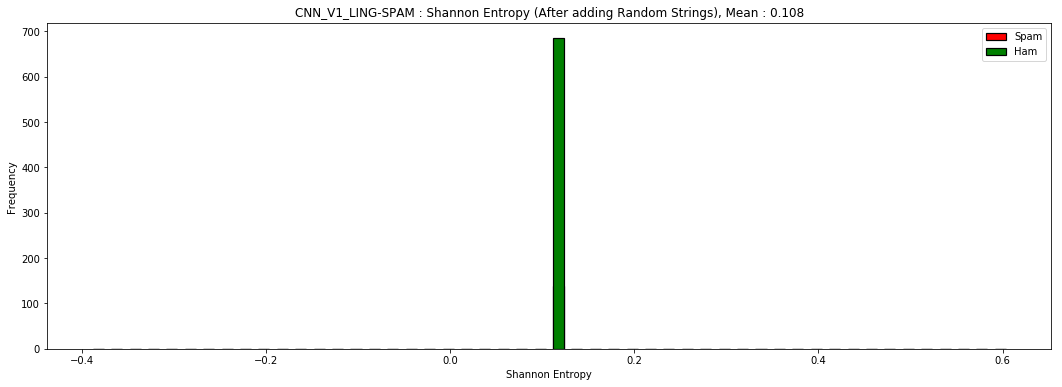

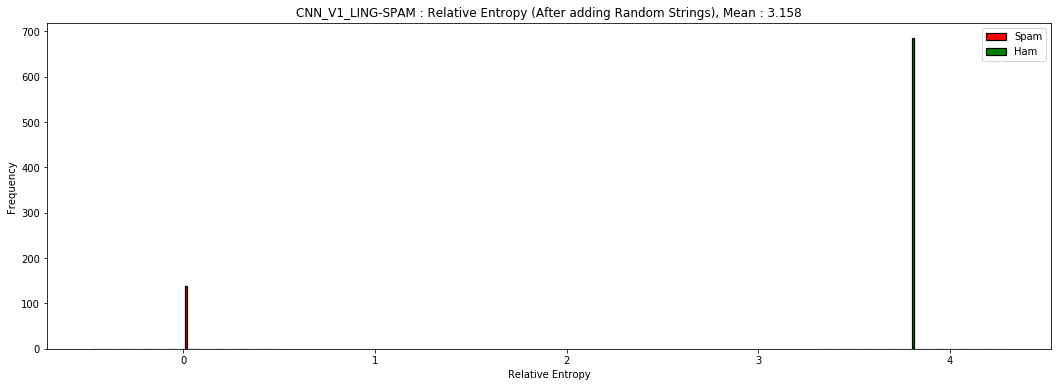

In [77]:
visualise_entropies(dataset, test_x_with_random_scrambled_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Scrambled Words Strings)

********************************************************************************
CNN_V1_LING-SPAM
********************************************************************************
Log Loss :  28.713118391691143
ROC AUC :  0.5
Accuracy :  0.16868932038834952
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       685
         1.0       0.17      1.00      0.29       139

   micro avg       0.17      0.17      0.17       824
   macro avg       0.08      0.50      0.14       824
weighted avg       0.03      0.17      0.05       824



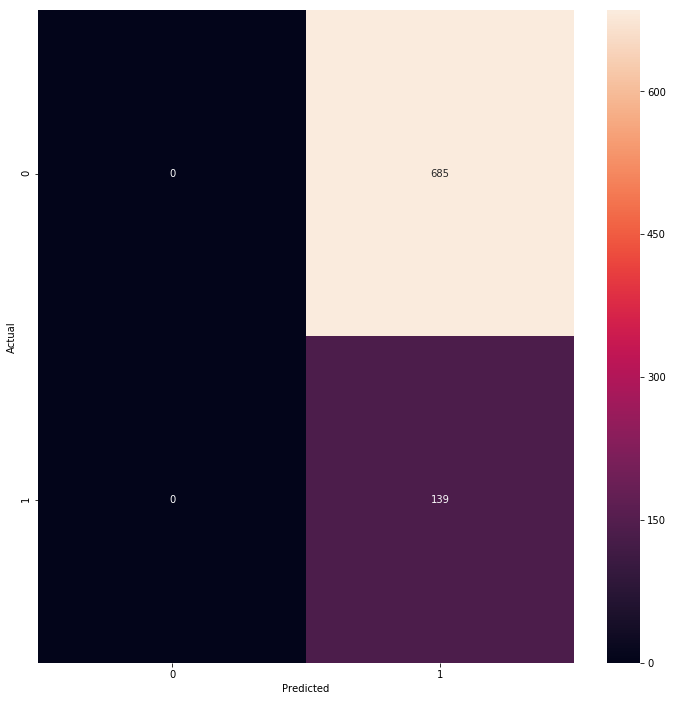

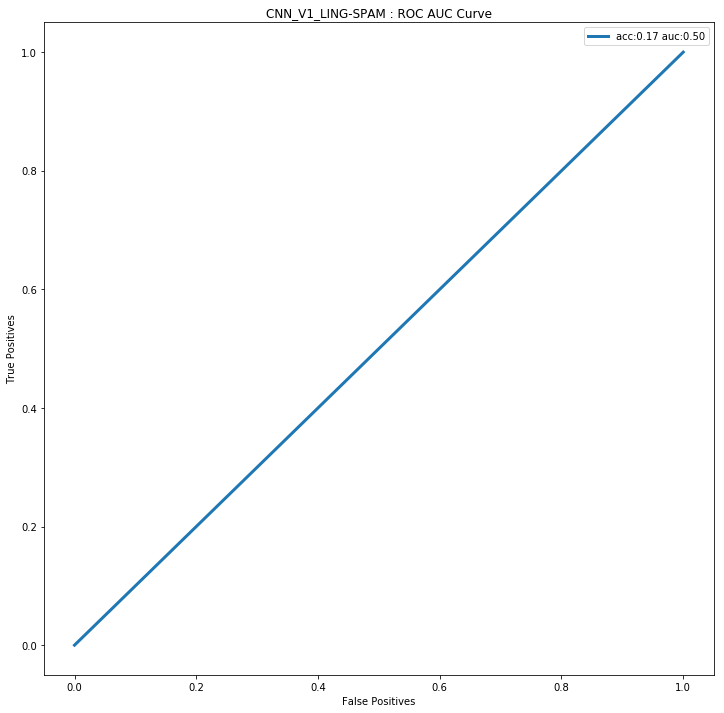

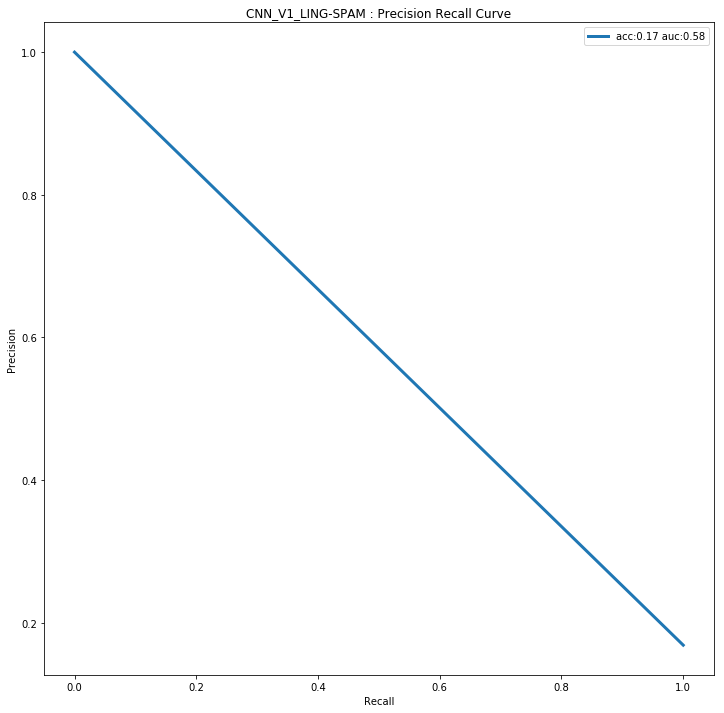

In [78]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_scrambled_strings_cnn, y_test)

## CNN Version 2

### Training Model

In [79]:
grids = {}
cnn_v2 = get_cnn_model_v2(max_len)
cnn_v2.fit(train_x_cnn,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

grids['CNN_V2_'+dataset] = copy.deepcopy(cnn_v2)

gc.enable(); gc.collect();

Train on 1655 samples, validate on 414 samples
Epoch 1/10
1655/1655 [==============================] - 1s 764us/step - loss: 0.5175 - acc: 0.7934 - binary_accuracy: 0.7934 - val_loss: 0.1935 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/10
1655/1655 [==============================] - 0s 187us/step - loss: 0.2707 - acc: 0.8308 - binary_accuracy: 0.8308 - val_loss: 0.0435 - val_acc: 0.9783 - val_binary_accuracy: 0.9783
Epoch 3/10
1655/1655 [==============================] - 0s 193us/step - loss: 0.1493 - acc: 0.9722 - binary_accuracy: 0.9722 - val_loss: 0.0523 - val_acc: 0.9686 - val_binary_accuracy: 0.9686
Epoch 4/10
1655/1655 [==============================] - 0s 190us/step - loss: 0.0560 - acc: 0.9837 - binary_accuracy: 0.9837 - val_loss: 0.0770 - val_acc: 0.9734 - val_binary_accuracy: 0.9734
Epoch 5/10
1655/1655 [==============================] - 0s 191us/step - loss: 0.0301 - acc: 0.9927 - binary_accuracy: 0.9927 - val_loss: 0.0939 - val_acc: 0.9734 - val_binary_accuracy: 

## Visualise Shannon and Relative entropies for various models

********************************************************************************
CNN_V2_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.034685872
Mean Relative Entropy :  0.23900923666146742
Head 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2   6.922e-01     0.738     1.0       0       0.522   4.779e-01
7   2.120e-01     2.907     1.0       0       0.945   5.464e-02
21  9.545e-04     6.000     1.0       0       1.000   9.280e-05
24  2.111e-01     2.913     1.0       0       0.946   5.434e-02
27  2.328e-02     5.656     1.0       0       0.997   3.498e-03
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
694    0.072     4.292     0.0       1       0.014       0.986
749    0.522     1.531     0.0       1       0.216       0.784
786    0.070     4.338     0.0       1       0.013       0.987
809    0.054     4.660     0.0       1       0.009       0.991
816    0.056     4.61

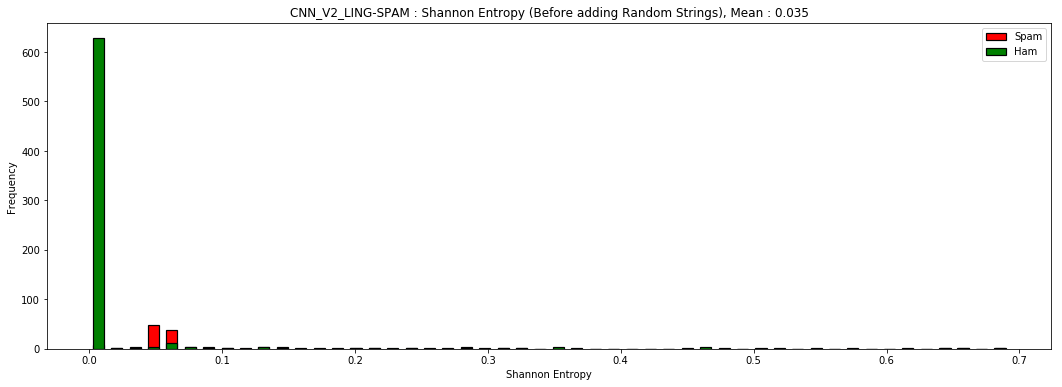

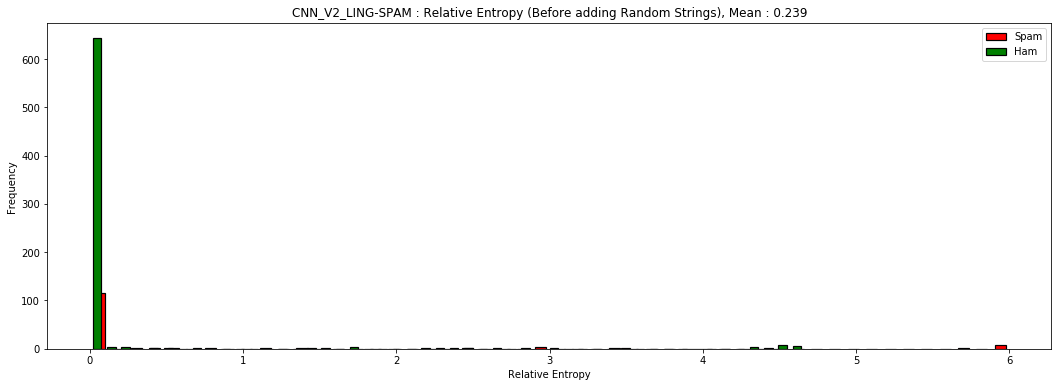

In [80]:
visualise_entropies(dataset, test_x_cnn, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
CNN_V2_LING-SPAM
********************************************************************************
Log Loss :  2.1796635427797972
ROC AUC :  0.9768261303366066
Accuracy :  0.9368932038834952
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       685
         1.0       0.78      0.86      0.82       139

   micro avg       0.94      0.94      0.94       824
   macro avg       0.88      0.91      0.89       824
weighted avg       0.94      0.94      0.94       824



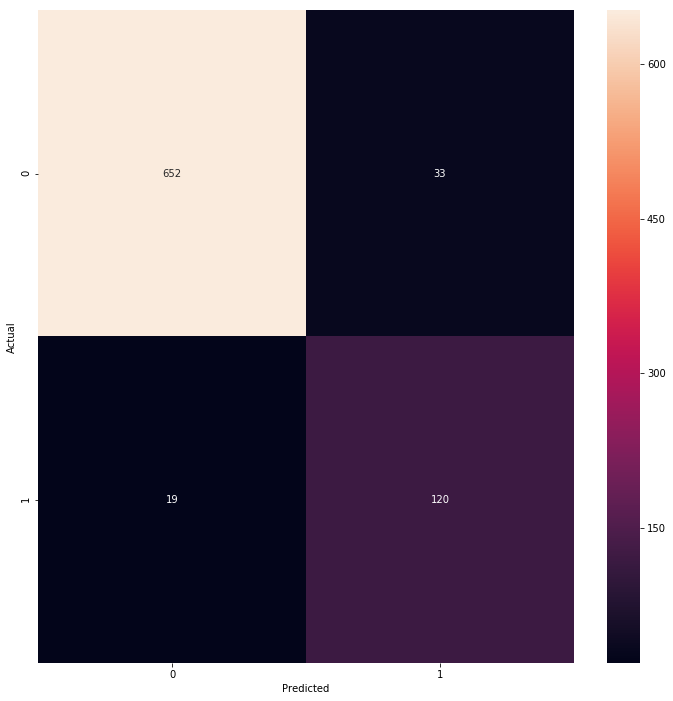

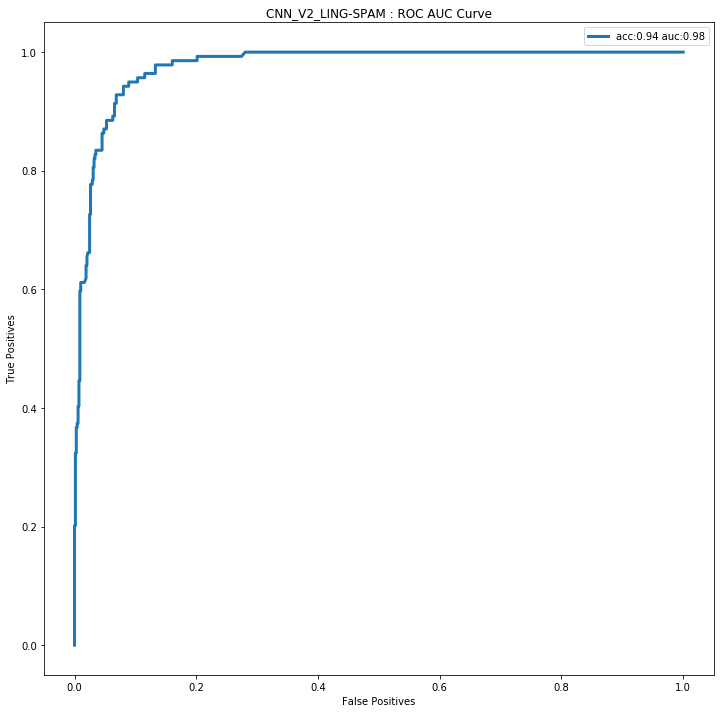

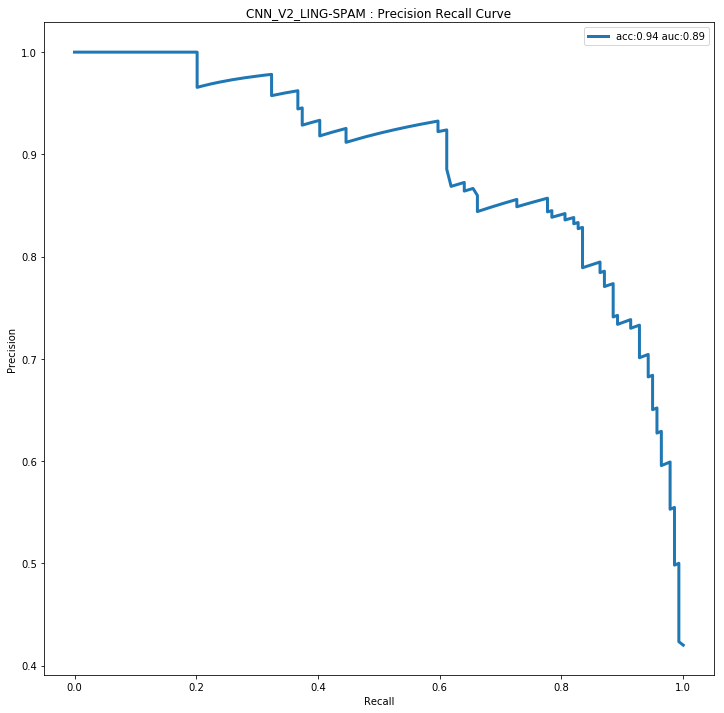

In [81]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cnn, y_test)

## Adding Meaningful Strings to Test Data

In [82]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V2_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.06077483
Mean Relative Entropy :  0.2551047749542028
Head 5 : 
   Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2    0.075     4.252     1.0       0       0.986       0.014
3    0.477     1.695     1.0       0       0.816       0.184
7    0.029     5.413     1.0       0       0.996       0.004
8    0.674     0.912     1.0       0       0.598       0.402
9    0.618     1.176     1.0       0       0.692       0.308
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
610    0.522     1.532     0.0       1       0.216       0.784
624    0.662     0.979     0.0       1       0.376       0.624
694    0.325     2.305     0.0       1       0.100       0.900
809    0.619     1.173     0.0       1       0.309       0.691
816    0.116     3.701     0.0       1   

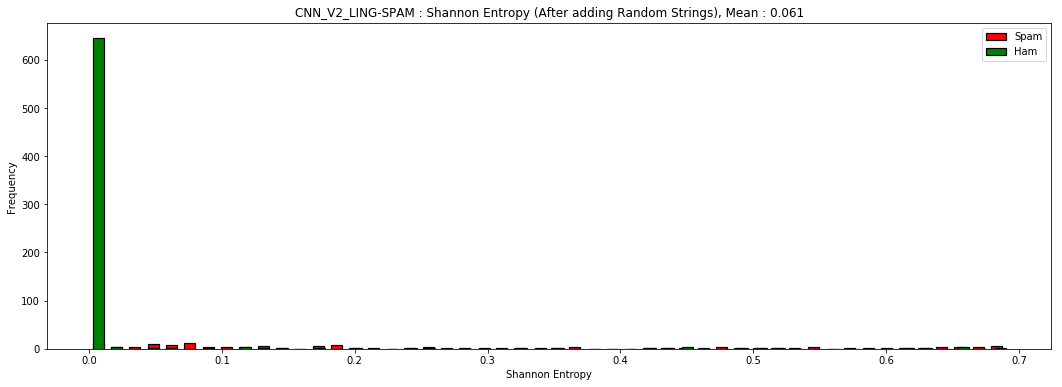

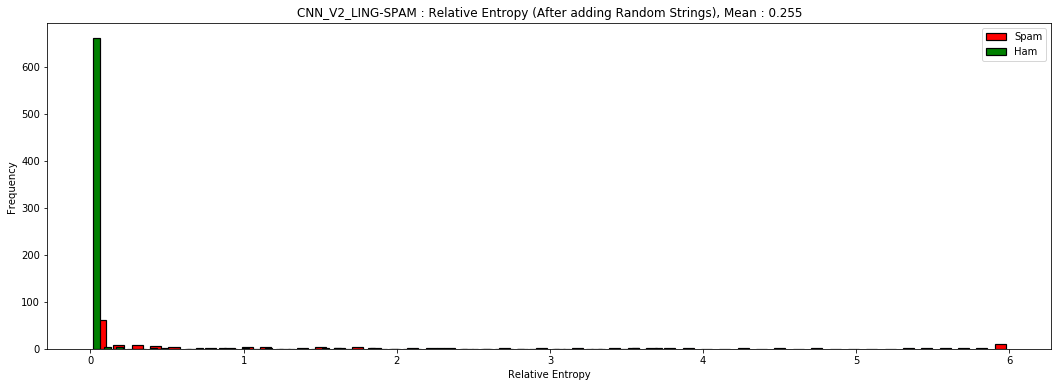

In [83]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V2_LING-SPAM
********************************************************************************
Log Loss :  2.6826360243214524
ROC AUC :  0.9773565089534212
Accuracy :  0.9223300970873787
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       685
         1.0       0.87      0.63      0.73       139

   micro avg       0.92      0.92      0.92       824
   macro avg       0.90      0.81      0.84       824
weighted avg       0.92      0.92      0.92       824



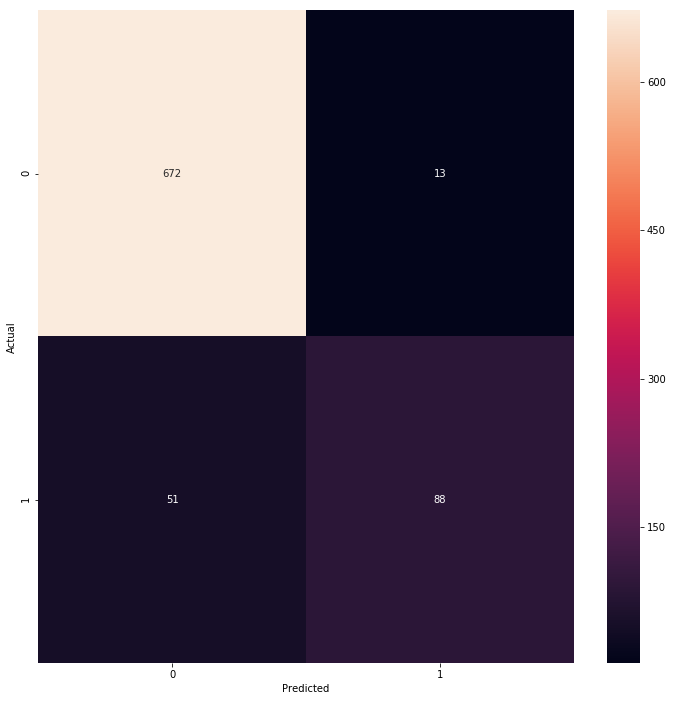

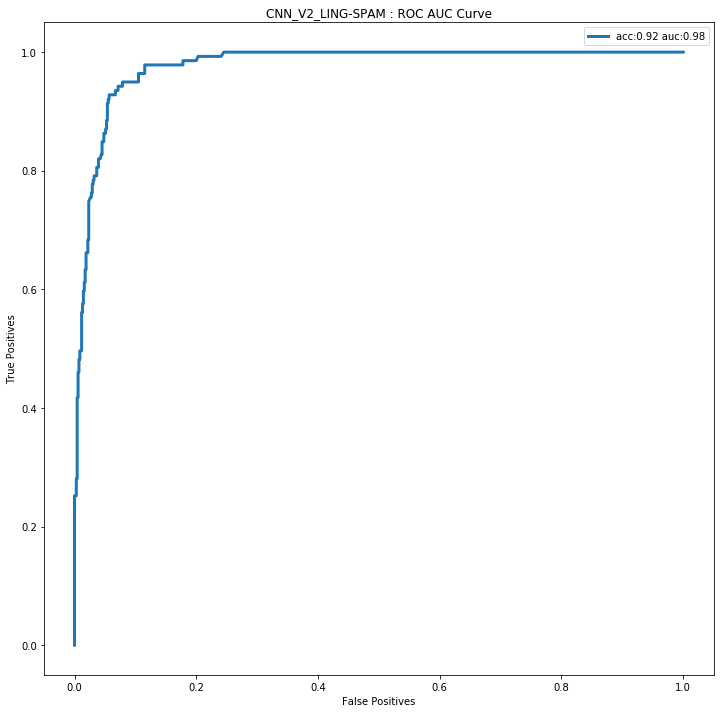

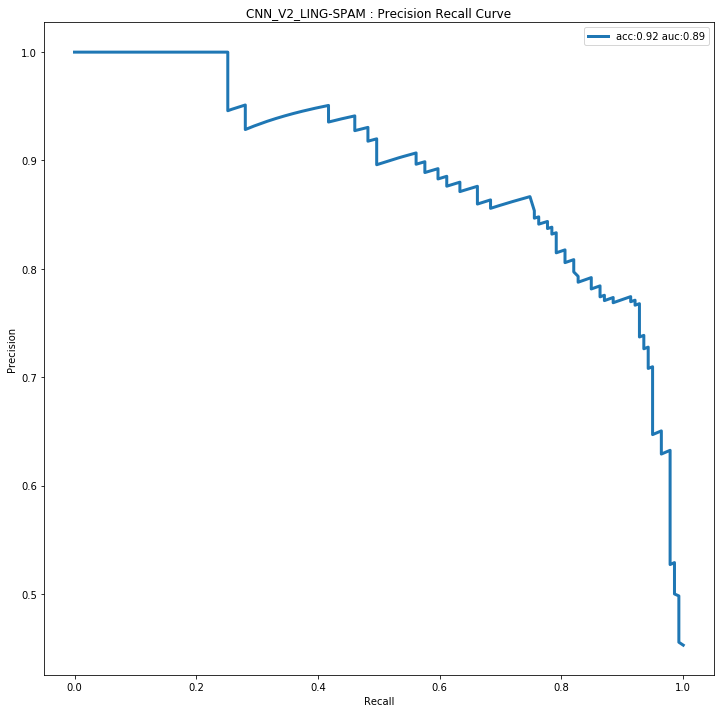

In [84]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)

## Adding Meaningful Scrambled Words Strings to Test Data

In [85]:
## adding meaningful random words that are scrambled now to the test dataset to further confuse the filter


test_x_with_random_scrambled_strings = add_meaningful_scrambled_strings(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_scrambled_strings)
test_x_with_random_scrambled_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Scrambled Words Strings)

********************************************************************************
CNN_V2_LING-SPAM
********************************************************************************
Mean Shannon Entropy :  0.0636459
Mean Relative Entropy :  3.7002560103674864
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
139    0.064     4.449     0.0       1       0.012       0.988
140    0.064     4.449     0.0       1       0.012       0.988
141    0.064     4.449     0.0       1       0.012       0.988
142    0.064     4.449     0.0       1       0.012       0.988
143    0.064     4.449     0.0       1       0.012       0.988
Tail 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
819    0.064     4.449     0.0       1       0.012       0.988
820    0.064     4.449     0.0       1       0.012       0.988
821    0.064     4.449     0.0       1       0.012       0.988
822    0.064     4.449     0.0       1       0.012       0.988
823    0.064     4.449     0.0

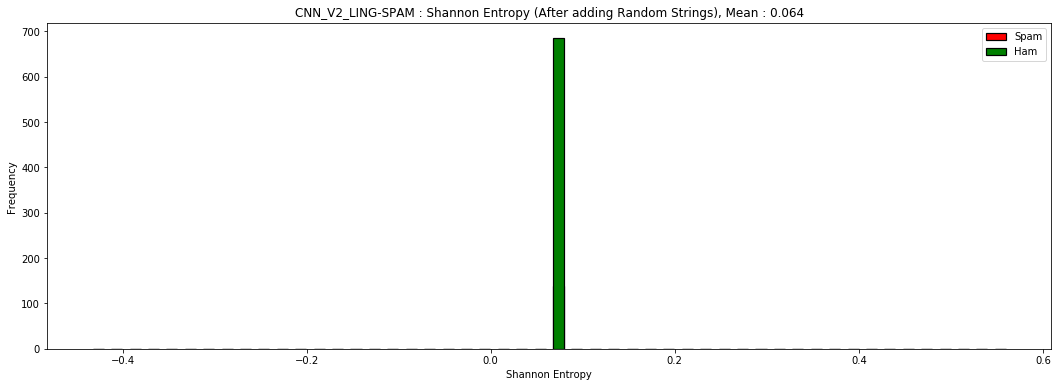

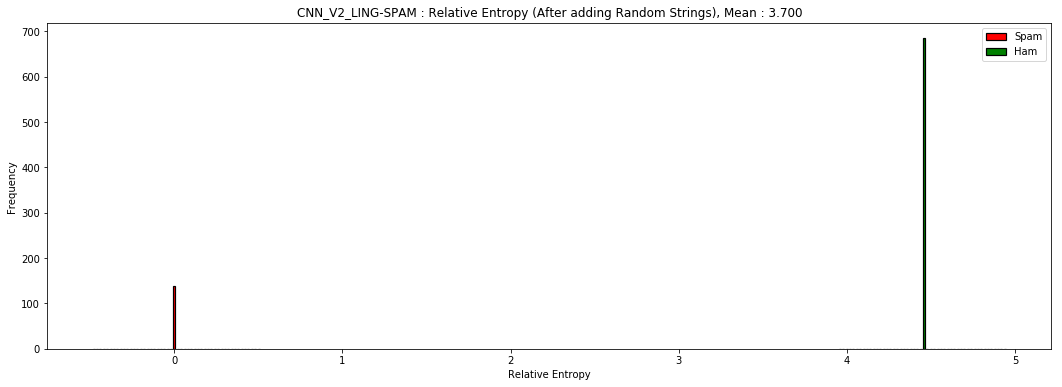

In [86]:
visualise_entropies(dataset, test_x_with_random_scrambled_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Scrambled Words Strings)

********************************************************************************
CNN_V2_LING-SPAM
********************************************************************************
Log Loss :  28.713118391691143
ROC AUC :  0.5
Accuracy :  0.16868932038834952
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       685
         1.0       0.17      1.00      0.29       139

   micro avg       0.17      0.17      0.17       824
   macro avg       0.08      0.50      0.14       824
weighted avg       0.03      0.17      0.05       824



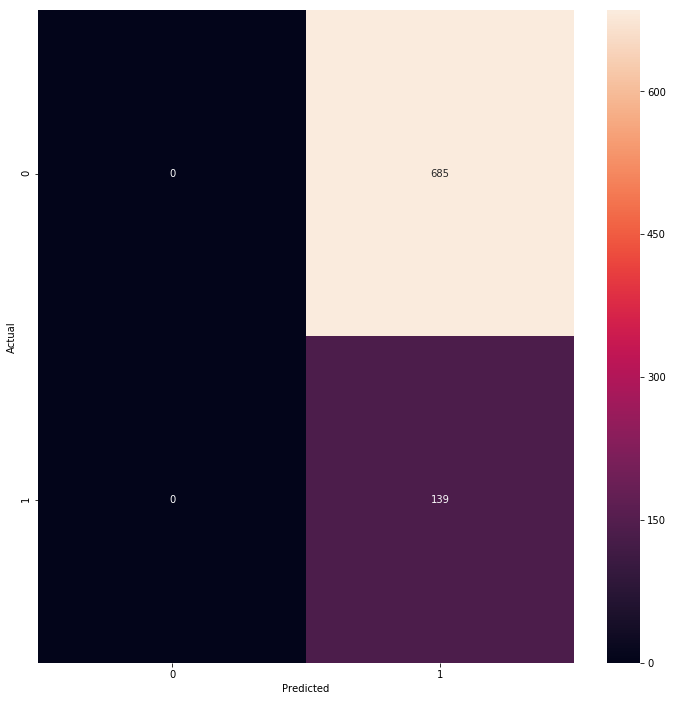

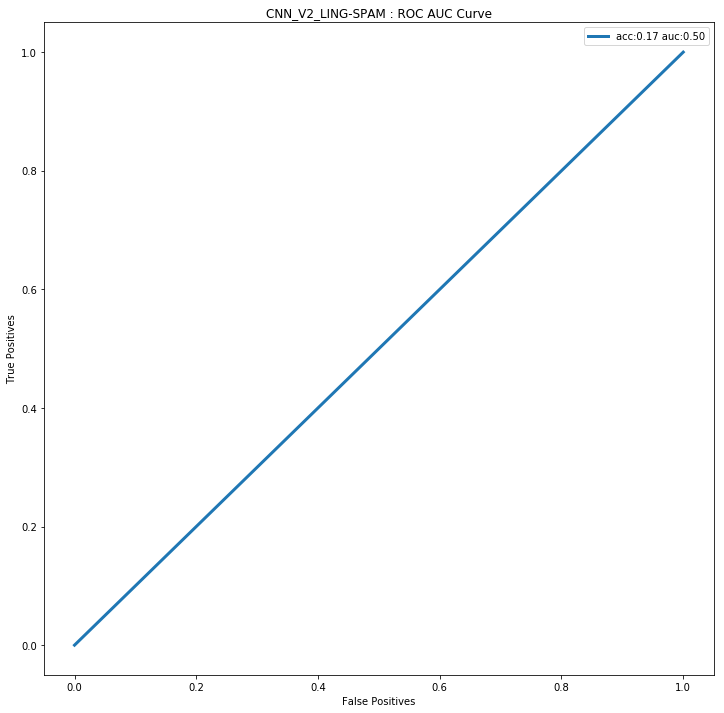

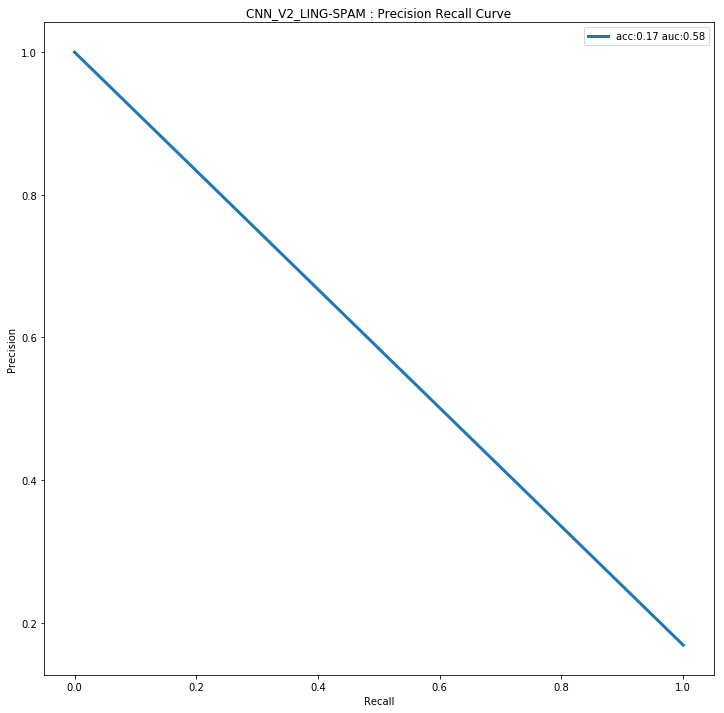

In [87]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_scrambled_strings_cnn, y_test)